# Script for analysing the simulated data from the robot experiment

started 21st of February, 2018

## table of contents

1. importing libraries
2. importing data
3. data treatmeant (merging, handling missing data)
4. plotting "almost raw" data
5. calculating means,std and N for each evaluation and participant
6. plotting averaged data
<br>    a) change of performance between evals
<br>    b) plan vs. test
<br>    c) plan vs. test seperated by searchmethod
<br>    d) influence of testing
<br>    e) influence of keystrokes between evaluations
7. comparative statistics
<br>    a) paired sample t-test & performance jumps
<br>    b) plan vs. test
<br>    c) ultra vs. blink
<br>    d) influence of testing
<br>    e) typing behaviour
<br>    f) self-reported pleasedness and experience


### 1. importing libraries
- numpy
- pandas
- matplotlib
- Mann Whitney U test and Spearman rank correlation test from scipi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import stats
from numpy import median

%matplotlib inline
import pathlib

# make the notebook full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# and tell pandas to actually show ALL columns instead of ... in the middle
pd.set_option('display.max_columns', 0)

### 2. importing data
Defining the header row of the data which has no column headers.

The simulated raw data comes in 4 batches that were simulated from one c# file each in one night each.
- first batch: p41 to p48 
- second batch: p49 to p56
- third batch: p57 to p64
- forth batch: p65 to p71

importing keylogger data that includes the amount of keystrokes and the keylogger analysis that determines the digraphs for indicating programming experience according to Thomas et al.

importing also the "paperdata" that the participants or the experimentor filled out on paper (i.e. questionnaires)

In [2]:
cols = ['datetime', 'participant', 'evaluation', 'codename', 'dataSrc','StartConfig','iteration','startX','startY','startPhi','redblink','greenblink','blueblink','redcube','greencube','bluecube','bonus','penalty','lastcube','overalltime','boxestouched','edgetouches','distance','turninganglesum','taskcomplete','removedcubes','fallofftime','lastmovedtime','timeout']

df_p41p48 = pd.read_csv('/TrollLABS/robotExp/results/simulationResults/data/p41top48summaryFile.txt',sep='\t', index_col=0, header=None, names = cols)
df_p49p56 = pd.read_csv('/TrollLABS/robotExp/results/simulationResults/data/p49top56summaryFile.txt',sep='\t', index_col=0, header=None, names = cols)
df_p57p64 = pd.read_csv('/TrollLABS/robotExp/results/simulationResults/data/p57top64summaryFile.txt',sep='\t', index_col=0, header=None, names = cols)
df_p65p71 = pd.read_csv('/TrollLABS/robotExp/results/simulationResults/data/p65top71summaryFile.txt',sep='\t', index_col=0, header=None, names = cols)

cols = ['parti','evalu','evaltime','tests','keystrokes']
keylog = pd.read_csv('/TrollLABS/robotExp/results/experimentalResults/keyloggerData/evaldata.txt', sep='\t', header = None, names = cols)

cols = ['part','valid','condition','comment','scheduled','arrived','gender','year_born','study_program','semester','pleased','enjoy','skill_C','skill_Arduino','skill_LEGO','skill_Python','CTest_time','CTest_result','pleased_before_eval1','pleased_after_eval1','eval1_touched','eval1_1stCube','eval1_2ndCube','eval1_3rdCube','eval1_SumBonus','eval1_SumPenalty','eval1_fellOff','eval1_stopped','eval1_abort','eval_TimeOverall','eval2_pleased','eval2_touched','eval2_1stCube','eval2_2ndCube','eval2_3rdCube','eval2_SumBonus','eval2_SumPenalty','eval2_fellOff','eval2_stopped','eval2_abort','eval2_TimeOverall','eval3_pleased','eval3_touched','eval3_1stCube','eval3_2ndCube','eval3_3rdCube','eval3_SumBonus','eval3_SumPenalty','eval3_fellOff','eval3_stopped','eval3_abort','eval3_TimeOverall','eval4_pleased','eval4_touched','eval4_1stCube','eval4_2ndCube','eval4_3rdCube','eval4_SumBonus','eval4_SumPenalty','eval4_fellOff','eval4_stopped','eval4_abort','eval4_TimeOverall','eval5_pleased','eval5_touched','eval5_1stCube','eval5_2ndCube','eval5_3rdCube','eval5_SumBonus','eval5_SumPenalty','eval5_fellOff','eval5_stopped','eval5_abort','eval5_TimeOverall']
paperdata = pd.read_csv('/TrollLABS/robotExp/results/experimentalResults/paperData/paperData_raw.txt',sep=';', header=None, names = cols)

cols = ["participant","A","N","O","B","E","H"]
typingdata = pd.read_csv('/TrollLABS/robotExp/results/experimentalResults/keyloggerData/typingdata.txt',sep='\t', header=None, names = cols)

### 3. data treatment

mergin the four batches of data below each other into one larger data frame that contains all participants from p41 to p71

In [3]:
df = pd.concat([df_p41p48,df_p49p56,df_p57p64,df_p65p71])

let's output this merged data frame to a new tab seperated csv/txt file

In [4]:
df.to_csv('/TrollLABS/robotExp/results/simulationResults/output_tables/p41top71summaryFile.txt', sep = '\t')
df.to_html('/TrollLABS/robotExp/results/simulationResults/output_tables/p41top71summaryFile.html')

get some overview over the shape of the table and if it has missing values

In [5]:
df.shape

(13365, 29)

In [6]:
df.isnull().sum()

datetime           0
participant        0
evaluation         0
codename           0
dataSrc            0
StartConfig        0
iteration          0
startX             0
startY             0
startPhi           0
redblink           0
greenblink         0
blueblink          0
redcube            0
greencube          0
bluecube           0
bonus              0
penalty            0
lastcube           0
overalltime        0
boxestouched       0
edgetouches        0
distance           0
turninganglesum    0
taskcomplete       0
removedcubes       0
fallofftime        0
lastmovedtime      0
timeout            0
dtype: int64

However, there are columns that have -1 or -99 as values indicating missing values. These have to be replaced by NaN to be excluded in the statistics

In [7]:
df.redcube.replace(-1.0,np.NaN, inplace = True)
df.greencube.replace(-1.0,np.NaN, inplace = True)
df.bluecube.replace(-1.0,np.NaN, inplace = True)
df.lastcube.replace(-1.0,np.NaN, inplace = True)
df.fallofftime.replace(-1.0,np.NaN, inplace = True)
df.overalltime.replace(-99.0,np.NaN, inplace = True)

In [8]:
df.isnull().sum()

datetime               0
participant            0
evaluation             0
codename               0
dataSrc                0
StartConfig            0
iteration              0
startX                 0
startY                 0
startPhi               0
redblink               0
greenblink             0
blueblink              0
redcube             4741
greencube           4693
bluecube            4470
bonus                  0
penalty                0
lastcube            6333
overalltime         6333
boxestouched           0
edgetouches            0
distance               0
turninganglesum        0
taskcomplete           0
removedcubes           0
fallofftime        11637
lastmovedtime          0
timeout                0
dtype: int64

Adding the column "condition". 0 = no testing / planning, 1 = testing

In [9]:
df['condition'] = df.participant % 2
df.head()

,datetime,participant,evaluation,codename,dataSrc,StartConfig,iteration,startX,startY,startPhi,redblink,greenblink,blueblink,redcube,greencube,bluecube,bonus,penalty,lastcube,overalltime,boxestouched,edgetouches,distance,turninganglesum,taskcomplete,removedcubes,fallofftime,lastmovedtime,timeout,condition
0,8/4/2018 5:59:26 PM,41,1,p41eval1,2,1,1,-1.7,-3.0,62.1,True,True,True,NaN,NaN,127.5,0,0,NaN,NaN,4,24,2581.180,0.0,0,1,NaN,386.7,1,1
1,8/4/2018 5:59:53 PM,41,1,p41eval1,2,2,1,-0.2,-0.9,265.6,True,True,True,3.7,NaN,NaN,10,0,NaN,NaN,4,20,2221.945,0.0,0,1,NaN,390.8,1,1
2,8/4/2018 6:00:27 PM,41,1,p41eval1,2,3,1,-0.5,-1.9,123.2,True,True,True,97.9,167.7,NaN,10,10,NaN,NaN,12,33,8978.306,0.0,0,2,NaN,388.1,1,1
3,8/4/2018 6:00:56 PM,41,1,p41eval1,2,4,1,-2.5,-1.9,262.7,True,True,True,NaN,NaN,60.9,0,0,NaN,NaN,2,26,5279.606,0.0,0,1,NaN,386.8,1,1
4,8/4/2018 6:01:24 PM,41,1,p41eval1,2,5,1,4.7,3.1,217.0,True,True,True,33.8,NaN,NaN,10,0,NaN,NaN,9,28,4638.103,0.0,0,1,NaN,393.5,1,1


distance and turninganglesum are measures of code efficiency. However, codes are only comparable if they achieve the same (i.e. a robot straight driving off has not driven far but is not efficient either). Therefore, I want to set distance and turnignanglesum to NaN if the task was not successfully completed.
Almost the same is true for edges touched and boxes touched. These can be used as a performance measure for those codes that did not even remove a single code (but did they at least touch one?). It can also be used as an efficiency indicator. How many edges and cubes did you touch for completing the task? Therefore, I will do the same with those two columns as well.


find the column numbers of the corresponding column and write np.nan into it if necessary

In [10]:
tc = df.columns.get_loc("taskcomplete")
bt = df.columns.get_loc("boxestouched")
et = df.columns.get_loc("edgetouches")
dis = df.columns.get_loc("distance")
tas = df.columns.get_loc("turninganglesum")
oat = df.columns.get_loc("overalltime")


for i in range(len(df)):
    if df.iloc[i,tc] == 0:
        df.iloc[i,bt] = np.nan
        df.iloc[i,et] = np.nan
        df.iloc[i,dis] = np.nan
        df.iloc[i,tas] = np.nan
        df.iloc[i,oat] = np.nan
 

Adding and calculating the columns for the time when the first, second and third cube was pushed out. It takes some time to calculate but still okay

In [11]:
df['firstcube'] = np.nan
df['secondcube'] = np.nan
df['thirdcube'] = np.nan

for i in range(0,len(df)):
    temp = [df.redcube.iloc[i],df.greencube.iloc[i],df.bluecube.iloc[i]]
    df.iloc[i,df.columns.get_loc("firstcube")] = np.sort(temp)[0]
    df.iloc[i,df.columns.get_loc("secondcube")] = np.sort(temp)[1]
    df.iloc[i,df.columns.get_loc("thirdcube")] = np.sort(temp)[2]

Adding and calculating the columns for the time when the first, second and third cube was pushed out.
The fastest way to calculate them is through a temporary numpy array.

later comment: going back and forth between pandas dataframe and numpy causes that the dtype changes from int64 to object and the histogram plots don't work anymore --> commented out, use the commands above

In [12]:
#cols = ['datetime', 'participant', 'eval', 'codename', 'dataSrc','StartConfig','iteration','startX','startY','startPhi','redblink','greenblink','blueblink','redcube','greencube','bluecube','bonus','penalty','lastcube','overalltime','boxestouched','edgetouches','distance','turninganglesum','taskcomplete','removedcubes','fallofftime','lastmovedtime','timeout','condition','firstcube','secondcube','thirdcube']
#df['firstcube'] = np.nan
#df['secondcube'] = np.nan
#df['thirdcube'] = np.nan

#np_df = df.as_matrix()

#for i in range(len(np_df)):
#    np_df[i,df.columns.get_loc("firstcube")] = np.sort((np_df[i,df.columns.get_loc("redcube")],np_df[i,df.columns.get_loc("greencube")],np_df[i,df.columns.get_loc("bluecube")]))[0]
#    np_df[i,df.columns.get_loc("secondcube")] = np.sort((np_df[i,df.columns.get_loc("redcube")],np_df[i,df.columns.get_loc("greencube")],np_df[i,df.columns.get_loc("bluecube")]))[1]
#    np_df[i,df.columns.get_loc("thirdcube")] = np.sort((np_df[i,df.columns.get_loc("redcube")],np_df[i,df.columns.get_loc("greencube")],np_df[i,df.columns.get_loc("bluecube")]))[2]
    
#df = pd.DataFrame(np_df, columns = cols)
#df.head(1)

making copies of columns with values instead of np.nan so that it is included in calculated medians

In [13]:
df['firstcube_4median'] = df['firstcube']
df['secondcube_4median'] = df['secondcube']
df['thirdcube_4median'] = df['thirdcube']
df['lastcube_4median'] = df['lastcube']
df['overalltime_4median'] = df['overalltime']
df['boxestouched_4median'] = df['boxestouched']
df['edgetouches_4median'] = df['edgetouches']
df['distance_4median'] = df['distance']
df['fallofftime_4median'] = df['fallofftime']
df['lastmovedtime_4median'] = df['lastmovedtime']

df.firstcube_4median.replace(np.NaN,500, inplace = True)
df.secondcube_4median.replace(np.NaN,500, inplace = True)
df.thirdcube_4median.replace(np.NaN,500, inplace = True)
df.lastcube_4median.replace(np.NaN,500, inplace = True)
df.overalltime_4median.replace(np.NaN,500, inplace = True)
df.boxestouched_4median.replace(np.NaN,500, inplace = True)
df.edgetouches_4median.replace(np.NaN,500, inplace = True)
df.distance_4median.replace(np.NaN,99999, inplace = True)
df.fallofftime_4median.replace(np.NaN,500, inplace = True)
df.lastmovedtime_4median.replace(np.NaN,500, inplace = True)

In [14]:
df.describe()

,participant,evaluation,dataSrc,StartConfig,iteration,startX,startY,startPhi,redcube,greencube,bluecube,bonus,penalty,lastcube,overalltime,boxestouched,edgetouches,distance,turninganglesum,taskcomplete,removedcubes,fallofftime,lastmovedtime,timeout,condition,firstcube,secondcube,thirdcube,firstcube_4median,secondcube_4median,thirdcube_4median,lastcube_4median,overalltime_4median,boxestouched_4median,edgetouches_4median,distance_4median,fallofftime_4median,lastmovedtime_4median
count,13365.000000,13365.000000,13365.0,13365.00000,13365.0,13365.000000,13365.000000,13365.000000,8624.000000,8672.000000,8895.000000,13365.000000,13365.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,13365.000000,13365.000000,1728.000000,13365.000000,13365.000000,13365.000000,10189.000000,8970.000000,7032.000000,13365.000000,13365.000000,13365.000000,13365.000000,13365.000000,13365.000000,13365.000000,13365.000000,13365.000000,13365.000000
mean,55.185185,3.000000,2.0,50.00000,1.0,-0.376768,-1.062626,182.636364,55.458152,52.375208,52.435672,3.985784,2.421998,93.147099,90.460509,12.598692,12.173208,6680.533819,292.924498,0.526150,1.959671,23.036916,126.146876,0.344557,0.518519,24.571175,55.018740,93.147099,137.549996,201.348156,285.934186,285.934186,284.520636,243.553610,243.329742,50899.452362,438.332046,126.146876
std,8.520608,1.414266,0.0,28.57845,0.0,2.800387,1.990637,97.879796,68.475979,63.515790,68.724318,7.744698,5.771126,82.203928,84.836273,9.140005,18.190865,7025.600004,1029.110419,0.499334,1.251556,37.088744,143.452605,0.475241,0.499676,40.289677,61.410083,82.203928,205.401372,215.025090,211.724885,211.724885,213.554753,243.466504,243.945777,46874.938878,160.592901,143.452605
min,41.000000,1.000000,2.0,1.00000,1.0,-4.700000,-3.100000,2.400000,2.500000,2.500000,2.600000,0.000000,0.000000,11.100000,-18.800000,2.000000,0.000000,1379.916000,0.000000,0.000000,0.000000,2.156250,0.000000,0.000000,0.000000,2.500000,4.500000,11.100000,2.500000,4.500000,11.100000,11.100000,-18.800000,2.000000,0.000000,1379.916000,2.156250,0.000000
25%,48.000000,2.000000,2.0,25.00000,1.0,-2.600000,-2.500000,98.200000,13.300000,14.200000,11.300000,0.000000,0.000000,33.100000,33.075000,7.000000,3.000000,2954.270000,0.000000,0.000000,1.000000,5.335938,19.200000,0.000000,0.000000,5.800000,18.500000,33.100000,7.000000,25.500000,63.100000,63.100000,62.700000,9.000000,5.000000,4031.275000,500.000000,19.200000
50%,55.000000,3.000000,2.0,50.00000,1.0,-0.600000,-1.900000,178.800000,30.500000,28.500000,25.100000,0.000000,0.000000,66.400000,66.300000,10.000000,6.000000,4195.106500,0.000000,1.000000,3.000000,7.687500,59.700000,0.000000,1.000000,11.400000,33.200000,66.400000,18.700000,62.200000,283.800000,283.800000,282.300000,30.000000,44.000000,20874.180000,500.000000,59.700000
75%,62.000000,4.000000,2.0,75.00000,1.0,0.700000,-0.400000,258.300000,66.800000,64.100000,62.300000,10.000000,0.000000,122.400000,123.800000,15.000000,13.000000,7181.107250,141.599825,1.000000,3.000000,23.042970,188.000000,1.000000,1.000000,26.200000,63.400000,122.400000,180.900000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,99999.000000,500.000000,188.000000
max,71.000000,5.000000,2.0,99.00000,1.0,4.800000,3.100000,356.300000,398.300000,398.500000,399.300000,30.000000,30.000000,399.300000,409.300000,135.000000,216.000000,63416.290000,17667.250000,1.000000,3.000000,378.156300,400.000000,1.000000,1.000000,398.800000,398.300000,399.300000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,99999.000000,500.000000,400.000000


let's also output this data frame with converted missing values to a new tab seperated csv/txt and html file

In [15]:
df.to_csv('/TrollLABS/robotExp/results/simulationResults/output_tables/p41top71summaryFile_missingValueTreated.txt', sep = '\t')
df.to_html('/TrollLABS/robotExp/results/simulationResults/output_tables/p41top71summaryFile_missingValueTreated.html')

### 4. plotting raw data

plotting histograms that show the frequency of how often from the 99 starting positions the last cube was pushed out in a 5 seconds time interval (bin). xaxis is time in seconds.

In [ ]:
participant = 41
range_min = 0
range_max = 400
binwidth = 5

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/rawdataFigures/lastcube').mkdir(parents=True, exist_ok=True) 
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/rawdataFigures/removedcubes').mkdir(parents=True, exist_ok=True)
 

for participant in range(41, 72):
    for evaluation in range(1,6):
        data1 = df[(df['participant'] == participant)&(df['evaluation'] == evaluation)&(df['taskcomplete'] == 1)].lastcube
        plt.subplots(figsize=(10, 6))
        plt.ylim(0,50)
        filestring = "/TrollLABS/robotExp/results/simulationResults/rawdataFigures/lastcube/p" + str(participant) + "evaluation" + str(evaluation)
        plt.figtext(0.7, 0.8,"lastcube p" + str(participant) + "evaluation" + str(evaluation) , color='black', weight='roman')
        plt.hist(data1, bins=np.arange(range_min, range_max + binwidth, binwidth),color='green')
        plt.savefig(filestring, bbox_inches = "tight")
  


participant = 41
range_min = 0
range_max = 4
binwidth = 1

for participant in range(41, 72):
    for evaluation in range(1,6):
        data1 = df[(df['participant'] == participant)&(df['evaluation'] == evaluation)].removedcubes
        plt.subplots(figsize=(10, 6))
        plt.ylim(0,100)
        filestring = "/TrollLABS/robotExp/results/simulationResults/rawdataFigures/removedcubes/p" + str(participant) + "evaluation" + str(evaluation)
        plt.figtext(0.42, 0.8,"removedcubes p" + str(participant) + "evaluation" + str(evaluation) , color='black', weight='roman')
        plt.hist(data1, bins=np.arange(range_min, range_max + binwidth, binwidth),color='grey')
        plt.savefig(filestring, bbox_inches = "tight")

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


### 5. calculating mean, stddev and N for each evaluation and participant

it turns out the easiest way (I found) to create a new dataframe that has the condensed data (avg, std, etc.) per participant is to use a numpy array and at the end convert it into a pandas dataframe to do statistics with it.

creating a numpy array with the # of rows = 5 * # of valid participants and enough columns to add some more calculated values and then setting all values to NaN to be sure that there are no false entries

In [16]:
a = np.zeros((31*5,70))
for i in range(len(a)):
    a[i] = np.nan

Calculating mean, standard deviation and N for each evaluation and writing them into an numpy array

In [17]:
participant = 41
evaluation = 1

for i in range(len(a)):
    a[i,0] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].condition.mean()
    a[i,1] = participant
    a[i,2] = int(evaluation)
    a[i,3] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].redcube.mean()
    a[i,4] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].redcube.std()
    a[i,5] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].redcube.notnull().sum()
    a[i,6] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].greencube.mean()
    a[i,7] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].greencube.std()
    a[i,8] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].greencube.notnull().sum()
    a[i,9] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].bluecube.mean()
    a[i,10] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].bluecube.std()
    a[i,11] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].bluecube.notnull().sum()
    a[i,12] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].bonus.mean()
    a[i,13] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].bonus.std()
    a[i,14] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].bonus.notnull().sum()
    a[i,15] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].penalty.mean()
    a[i,16] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].penalty.std()
    a[i,17] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].penalty.notnull().sum()
    a[i,18] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].lastcube.mean()
    a[i,19] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].lastcube.std()
    a[i,20] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].lastcube.notnull().sum()
    a[i,21] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].overalltime.mean()
    a[i,22] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].overalltime.std()
    a[i,23] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].overalltime.notnull().sum()
    a[i,24] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].boxestouched.mean()
    a[i,25] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].boxestouched.std()
    a[i,26] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].boxestouched.notnull().sum()
    a[i,27] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].edgetouches.mean()
    a[i,28] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].edgetouches.std()
    a[i,29] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].edgetouches.notnull().sum()
    a[i,30] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].distance.mean()
    a[i,31] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].distance.std()
    a[i,32] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].distance.notnull().sum()
    a[i,33] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].turninganglesum.mean()
    a[i,34] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].turninganglesum.std()
    a[i,35] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].turninganglesum.notnull().sum()
    a[i,36] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].taskcomplete.mean()
    a[i,37] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].taskcomplete.std()
    a[i,38] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].taskcomplete.notnull().sum()
    a[i,39] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].removedcubes.mean()
    a[i,40] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].removedcubes.std()
    a[i,41] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].removedcubes.notnull().sum()
    a[i,42] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].fallofftime.mean()
    a[i,43] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].fallofftime.std()
    a[i,44] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].fallofftime.notnull().sum()
    a[i,45] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].lastmovedtime.mean()
    a[i,46] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].lastmovedtime.std()
    a[i,47] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].lastmovedtime.notnull().sum()
    a[i,48] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].timeout.mean()
    a[i,49] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].timeout.std()
    a[i,50] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].timeout.notnull().sum()
    a[i,51] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].firstcube.mean()
    a[i,52] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].firstcube.std()
    a[i,53] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].firstcube.notnull().sum()
    a[i,54] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].secondcube.mean()
    a[i,55] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].secondcube.std()
    a[i,56] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].secondcube.notnull().sum()
    a[i,57] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].thirdcube.mean()
    a[i,58] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].thirdcube.std()
    a[i,59] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].thirdcube.notnull().sum()
    a[i,60] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].firstcube_4median.median()
    a[i,61] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].secondcube_4median.median()
    a[i,62] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].thirdcube_4median.median()
    a[i,63] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].lastcube_4median.median()
    a[i,64] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].overalltime_4median.median()
    a[i,65] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].boxestouched_4median.median()
    a[i,66] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].edgetouches_4median.median()
    a[i,67] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].distance_4median.median()
    a[i,68] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].fallofftime_4median.median()
    a[i,69] = df[(df.participant == participant)&(df['evaluation'] == evaluation)].lastmovedtime_4median.median()

    evaluation = evaluation + 1
    if evaluation > 5:
        participant = participant + 1
        evaluation = 1

In [18]:
cols = ["condition","participant","evaluation","redcube_mean","redcube_std","redcube_N","greencube_mean","greencube_std","greencube_N","bluecube_mean", "bluecube_std","bluecube_N","bonus_mean","bonus_std","bonus_N","penalty_mean","penalty_std","penalty_N","lastcube_mean","lastcube_std","lastcube_N","overalltime_mean","overalltime_std","overalltime_N","boxestouched_mean","boxestouched_std","boxestouched_N","edgetouches_mean","edgetouches_std","edgetouches_N","distance_mean","distance_std","distance_N","turninganglesum_mean","turninganglesum_std","turninganglesum_N","taskcomplete_mean","taskcomplete_std","taskcomplete_N","removedcubes_mean","removedcubes_std","removedcubes_N","fallofftime_mean","fallofftime_std","fallofftime_N","lastmovedtime_mean","lastmovedtime_std","lastmovedtime_N","timeout_mean","timeout_std","timout_N","firstcube_mean","firstcube_std","firstcube_N","secondcube_mean","secondcube_std","secondcube_N","thirdcube_mean","thirdcube_std","thirdcube_N","firstcube_median","secondcube_median","thirdcube_median","lastcube_median","overalltime_median","boxestouched_median","edgetouches_median","distance_median","fallofftime_median","lastmovedtime_median"]
evalSummary = pd.DataFrame(a, columns = cols)

evalSummary = pd.concat([evalSummary,keylog], axis = 1)
evalSummary.drop('parti', axis=1, inplace=True)
evalSummary.drop('evalu', axis=1, inplace=True)
evalSummary.drop('evaltime', axis=1, inplace=True)
evalSummary.head(5)

,condition,participant,evaluation,redcube_mean,redcube_std,redcube_N,greencube_mean,greencube_std,greencube_N,bluecube_mean,bluecube_std,bluecube_N,bonus_mean,bonus_std,bonus_N,penalty_mean,penalty_std,penalty_N,lastcube_mean,lastcube_std,lastcube_N,overalltime_mean,overalltime_std,overalltime_N,boxestouched_mean,boxestouched_std,boxestouched_N,edgetouches_mean,edgetouches_std,edgetouches_N,distance_mean,distance_std,distance_N,turninganglesum_mean,turninganglesum_std,turninganglesum_N,taskcomplete_mean,taskcomplete_std,taskcomplete_N,removedcubes_mean,removedcubes_std,removedcubes_N,fallofftime_mean,fallofftime_std,fallofftime_N,lastmovedtime_mean,lastmovedtime_std,lastmovedtime_N,timeout_mean,timeout_std,timout_N,firstcube_mean,firstcube_std,firstcube_N,secondcube_mean,secondcube_std,secondcube_N,thirdcube_mean,thirdcube_std,thirdcube_N,firstcube_median,secondcube_median,thirdcube_median,lastcube_median,overalltime_median,boxestouched_median,edgetouches_median,distance_median,fallofftime_median,lastmovedtime_median,tests,keystrokes
0,1.0,41.0,1.0,84.956164,74.340620,73.0,97.396154,98.029759,52.0,89.456863,80.306655,51.0,6.363636,4.834938,99.0,2.626263,4.862572,99.0,157.371429,113.758553,14.0,156.657143,116.881069,14.0,7.571429,2.376626,14.0,12.071429,5.356007,14.0,3773.816571,934.371191,14.0,0.0,0.0,14.0,0.141414,0.350222,99.0,1.777778,0.678467,99.0,NaN,NaN,0.0,357.634343,91.800185,99.0,0.858586,0.350222,99.0,64.540404,65.695522,99.0,114.857143,85.887475,63.0,157.371429,113.758553,14.0,36.5,168.0,500.0,500.0,500.0,500.0,500.0,99999.00,500.0,389.9,48.0,2858.0
1,1.0,41.0,2.0,169.370000,127.596731,50.0,154.250000,121.479227,62.0,151.983871,121.689809,62.0,4.141414,4.950799,99.0,2.525253,5.218381,99.0,265.103448,112.961847,29.0,264.758621,114.341786,29.0,13.793103,4.195059,29.0,28.758621,11.673092,29.0,10143.169310,3661.187159,29.0,0.0,0.0,29.0,0.292929,0.457422,99.0,1.757576,1.031058,99.0,NaN,NaN,0.0,356.583838,85.478987,99.0,0.707071,0.457422,99.0,92.127059,91.066853,85.0,198.936667,113.113313,60.0,265.103448,112.961847,29.0,76.1,321.3,500.0,500.0,500.0,500.0,500.0,99999.00,500.0,393.7,7.0,116.0
2,1.0,41.0,3.0,113.775510,91.993868,98.0,128.884211,96.869968,95.0,111.397895,86.490531,95.0,8.686869,3.394613,99.0,9.393939,8.307629,99.0,196.866667,85.193588,90.0,197.866667,85.868813,90.0,16.777778,6.494211,90.0,64.644444,30.730547,90.0,15565.045744,6394.180857,90.0,0.0,0.0,90.0,0.909091,0.288943,99.0,2.909091,0.288943,99.0,NaN,NaN,0.0,215.226263,100.104142,99.0,0.090909,0.288943,99.0,51.114141,53.021622,99.0,113.116162,71.198017,99.0,196.866667,85.193588,90.0,37.0,100.0,183.7,183.7,191.9,17.0,63.0,14721.48,500.0,183.7,4.0,177.0
3,1.0,41.0,4.0,106.345833,85.174124,96.0,130.889130,97.041189,92.0,113.686598,92.711384,97.0,8.787879,3.280346,99.0,9.595960,8.196464,99.0,197.968966,88.687428,87.0,199.463218,89.798441,87.0,17.954023,8.126769,87.0,64.264368,31.670711,87.0,15601.402299,6732.988323,87.0,0.0,0.0,87.0,0.878788,0.328035,99.0,2.878788,0.328035,99.0,NaN,NaN,0.0,222.334343,106.245094,99.0,0.121212,0.328035,99.0,46.812121,40.617424,99.0,115.362626,71.753133,99.0,197.968966,88.687428,87.0,35.4,98.9,206.6,206.6,215.9,18.0,67.0,16567.89,500.0,206.6,3.0,448.0
4,1.0,41.0,5.0,154.187097,124.473295,93.0,75.554545,109.915627,77.0,131.168478,117.245778,92.0,6.464646,4.805000,99.0,7.171717,8.456419,99.0,211.125373,120.898104,67.0,212.916418,120.674254,67.0,24.119403,18.343129,67.0,45.402985,28.257506,67.0,33902.636045,20544.441793,67.0,0.0,0.0,67.0,0.676768,0.470091,99.0,2.646465,0.540467,99.0,NaN,NaN,0.0,272.053535,133.151619,99.0,0.323232,0.470091,99.0,47.926263,74.628423,99.0,138.901042,114.772722,96.0,211.125373,120.898104,67.0,19.7,99.4,312.6,312.6,315.6,32.0,72.0,52297.89,500.0,312.2,5.0,197.0


adding a column of 3rd cube time multiplied with the standard deviation of taskcomplete.

In [19]:
evalSummary['thirdCubetimestaskcompleteSTD'] = evalSummary.thirdcube_mean * evalSummary.taskcomplete_std

adding one column indicating which method was used in each evaluation to search for the cubes (1 = ultrasound, 2 = blink, 3 = hybrid of ultra and blink, 4 = none/random driving, 5 = invalid participant)
The 5s are set to NaN so that they will be excluded from analysis

In [20]:
searchmethod = pd.read_csv('/TrollLABS/robotExp/results/simulationResults/data/solutionstyle.txt',sep='\t', header=None)
evalSummary['searchmethod'] = searchmethod
evalSummary.searchmethod[(evalSummary.searchmethod == 5)] = np.nan

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
evalSummary.to_csv('/TrollLABS/robotExp/results/simulationResults/output_tables/evalSummary.txt', sep = '\t')
evalSummary.to_html('/TrollLABS/robotExp/results/simulationResults/output_tables/evalSummary.html')
writer = pd.ExcelWriter('/TrollLABS/robotExp/results/simulationResults/output_tables/evalSummary.xlsx')
evalSummary.to_excel(writer,'Sheet1')

sorting participants by lastcube_N, then lastcube_mean and removedcubes_mean

the resulting array holds the participant numbers from worst performing to best performing and can be used for the 3d bar plot in the correct order

In [23]:
df_copy = df.copy()
df_copy.replace(np.NaN, 500, inplace = True)

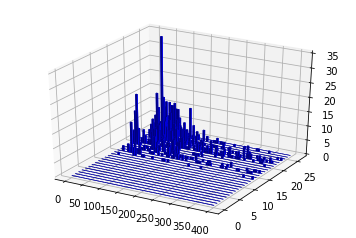

In [26]:
excluded_participants = (evalSummary.participant != 45)&(evalSummary.participant != 64)&(evalSummary.participant != 67)&(evalSummary.participant != 70)

partorder_eval1 = evalSummary[(evalSummary.evaluation == 1)&excluded_participants].sort_values(by=['lastcube_N','lastcube_mean','removedcubes_mean']).participant.values

evaluation = 1

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist = []

range_min = 0
range_max = 400
binwidth = 5

for i in range(0,len(partorder_eval1)):
    data = df_copy[(df_copy.evaluation == evaluation) & (df_copy.participant == partorder_eval1[i])].lastcube.values
    hist.append(np.histogram(data, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])

for j in range(0,len(partorder_eval1)): 
    for k in range(0,len(hist[j])):
        xpos.append(5*k)
        ypos.append(j)
        zpos.append(0)
        dx.append(5)
        dy.append(0.25)
        dz.append((hist[j][k]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b')

filestring = "/TrollLABS/robotExp/results/simulationResults/rawdataFigures/lastcube/eval" + str(evaluation)
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

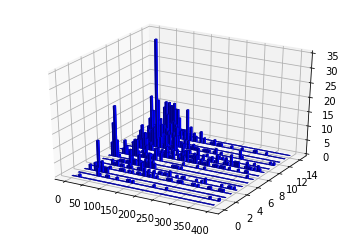

In [27]:
excluded_participants = (evalSummary.participant != 45)&(evalSummary.participant != 64)&(evalSummary.participant != 67)&(evalSummary.participant != 70)

partorder_eval1 = evalSummary[(evalSummary.evaluation == 1)&excluded_participants&(evalSummary.lastcube_N != 0)].sort_values(by=['lastcube_N','lastcube_mean','removedcubes_mean']).participant.values
partorder_eval1

evaluation = 1

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist = []

range_min = 0
range_max = 400
binwidth = 5

for i in range(0,len(partorder_eval1)):
    data = df_copy[(df_copy.evaluation == evaluation) & (df_copy.participant == partorder_eval1[i])].lastcube.values
    hist.append(np.histogram(data, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])

for j in range(0,len(partorder_eval1)): 
    for k in range(0,len(hist[j])):
        xpos.append(5*k)
        ypos.append(j)
        zpos.append(0)
        dx.append(5)
        dy.append(0.25)
        dz.append((hist[j][k]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b')

filestring = "/TrollLABS/robotExp/results/simulationResults/rawdataFigures/lastcube/eval" + str(evaluation) + "withoutloosers"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

evaluation 1 	 	 planners 	 testers
	 	 	 median  N 	 median  N 		 MannW U 		 p-value
1st cube removed 	 500.0 	 1287 	 32.0 	 1386 	 	 760778.0 		 0.00000000
2nd cube removed 	 500.0 	 1287 	 128.9 	 1386 	 	 677164.0 		 0.00000000
3rd cube removed 	 500.0 	 1287 	 500.0 	 1386 	 	 829515.5 		 0.00009693
fall off time 		 500.0 	 1287 	 500.0 	 1386 	 	 657259.5 		 0.00000000


THE STATISTIC BELOW IS NON-SENSE BECAUSE IT USES MEANS ON DATA THAT USES 500 INSTEAD OF NP.NAN
evaluation 1 	 	 planners 	 	 testers
	 	 	 mean 	 SD 	 N 	 mean 	 SD 	 N 	 	 Welchs t 	 p-value
1st cube removed 	 278.7 	 237.4 	 1287 	 192.1 	 228.1 	 1386 	 	 9.60 		 0.000000
2nd cube removed 	 353.2 	 207.0 	 1287 	 252.1 	 224.2 	 1386 	 	 12.13 		 0.000000
3rd cube removed 	 382.9 	 183.3 	 1287 	 356.3 	 197.9 	 1386 	 	 3.61 		 0.000312
fall off time 		 370.9 	 214.8 	 1287 	 498.7 	 22.1 	 1386 	 	 -21.24 		 0.000000


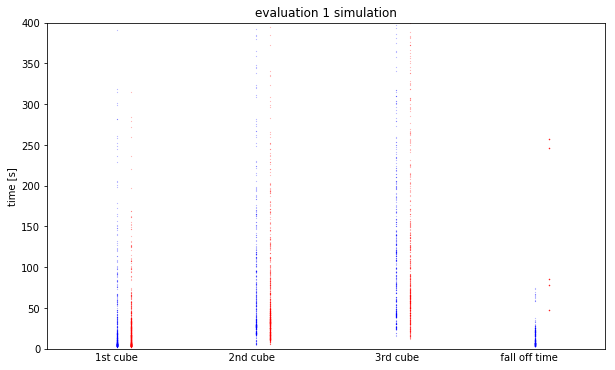

evaluation 2 	 	 planners 	 testers
	 	 	 median  N 	 median  N 		 MannW U 		 p-value
1st cube removed 	 20.5 	 1287 	 31.1 	 1386 	 	 885509.0 		 0.37164642
2nd cube removed 	 344.7 	 1287 	 117.4 	 1386 	 	 872430.0 		 0.15254775
3rd cube removed 	 500.0 	 1287 	 500.0 	 1386 	 	 785369.0 		 0.00000000
fall off time 		 500.0 	 1287 	 500.0 	 1386 	 	 839826.0 		 0.00002078




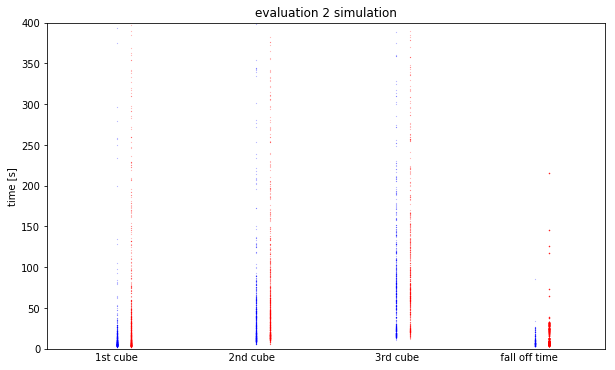

In [28]:
#y1_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval2_touched != ' ')].eval2_touched.astype(str).astype(int)
#x1_plan = [1] * len(y1_plan)
#y1_test = paperdata[(paperdata.condition == 1)&(paperdata.eval2_touched != ' ')].eval2_touched.astype(str).astype(int)
#x1_test = [1.1] * len(y1_test)

y2_plan = df[(df.participant % 2 == 0)&(df.evaluation == 1)].firstcube_4median
x2_plan = [2] * len(y2_plan)
y2_test = df[(df.participant % 2 == 1)&(df.evaluation == 1)].firstcube_4median
x2_test = [2.1] * len(y2_test)

y3_plan = df[(df.participant % 2 == 0)&(df.evaluation == 1)].secondcube_4median
x3_plan = [3] * len(y3_plan)
y3_test = df[(df.participant % 2 == 1)&(df.evaluation == 1)].secondcube_4median
x3_test = [3.1] * len(y3_test)

y4_plan = df[(df.participant % 2 == 0)&(df.evaluation == 1)].thirdcube_4median
x4_plan = [4] * len(y4_plan)
y4_test = df[(df.participant % 2 == 1)&(df.evaluation == 1)].thirdcube_4median
x4_test = [4.1] * len(y4_test)

y5_plan = df[(df.participant % 2 == 0)&(df.evaluation == 1)].fallofftime_4median
x5_plan = [5] * len(y5_plan)
y5_test = df[(df.participant % 2 == 1)&(df.evaluation == 1)].fallofftime_4median
x5_test = [5.1] * len(y5_test)

y6_plan = df[(df.participant % 2 == 0)&(df.evaluation == 1)].lastmovedtime_4median
x6_plan = [5] * len(y6_plan)
y6_test = df[(df.participant % 2 == 1)&(df.evaluation == 1)].lastmovedtime_4median
x6_test = [5.1] * len(y6_test)

N2_plan = len(y2_plan)
N2_test = len(y2_test)
N3_plan = len(y3_plan)
N3_test = len(y3_test)
N4_plan = len(y4_plan)
N4_test = len(y4_test)
N5_plan = len(y5_plan)
N5_test = len(y5_test)

#U1, p1 = stats.mannwhitneyu(y1_plan,y1_test)
U2, p2 = stats.mannwhitneyu(y2_plan,y2_test)
U3, p3 = stats.mannwhitneyu(y3_plan,y3_test)
U4, p4 = stats.mannwhitneyu(y4_plan,y4_test)
U5, p5 = stats.mannwhitneyu(y5_plan,y5_test)

print('evaluation 1 \t \t planners \t testers')
print('\t \t \t median  N \t median  N \t\t MannW U \t\t p-value')
#print('1st cube touched \t %.1f \t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y1_plan.mean(),y1_plan.std(),y1_test.mean(),y1_test.std(),t1,p1))
print('1st cube removed \t %.1f \t %i \t %.1f \t %i \t \t %.1f \t\t %.8f'%(y2_plan.median(),N2_plan, y2_test.median(),N2_test,U2,p2))
print('2nd cube removed \t %.1f \t %i \t %.1f \t %i \t \t %.1f \t\t %.8f'%(y3_plan.median(),N3_plan, y3_test.median(),N3_test,U3,p3))
print('3rd cube removed \t %.1f \t %i \t %.1f \t %i \t \t %.1f \t\t %.8f'%(y4_plan.median(),N4_plan, y4_test.median(),N4_test,U4,p4))
print('fall off time \t\t %.1f \t %i \t %.1f \t %i \t \t %.1f \t\t %.8f'%(y5_plan.median(), N5_plan, y5_test.median(),N5_test,U5,p5))
print()
print()

# not assuming similar variances: Welch's t-test
#t1, p1 = stats.ttest_ind(y1_plan,y1_test, equal_var = False)
t2, p2 = stats.ttest_ind(y2_plan,y2_test, equal_var = False)
t3, p3 = stats.ttest_ind(y3_plan,y3_test, equal_var = False)
t4, p4 = stats.ttest_ind(y4_plan,y4_test, equal_var = False)
t5, p5 = stats.ttest_ind(y5_plan,y5_test, equal_var = False)

# assuming similar variances: student's t-test
#t1, p1 = stats.ttest_ind(y1_plan,y1_test)
#t2, p2 = stats.ttest_ind(y2_plan,y2_test)
#t3, p3 = stats.ttest_ind(y3_plan,y3_test)
#t4, p4 = stats.ttest_ind(y4_plan,y4_test)
#t5, p5 = stats.ttest_ind(y5_plan,y5_test)

print('THE STATISTIC BELOW IS NON-SENSE BECAUSE IT USES MEANS ON DATA THAT USES 500 INSTEAD OF NP.NAN')
print('evaluation 1 \t \t planners \t \t testers')
print('\t \t \t mean \t SD \t N \t mean \t SD \t N \t \t Welchs t \t p-value')
#print('1st cube touched \t %.1f \t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y1_plan.mean(),y1_plan.std(),y1_test.mean(),y1_test.std(),t1,p1))
print('1st cube removed \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t %i \t \t %.2f \t\t %.6f'%(y2_plan.mean(),y2_plan.std(),N2_plan, y2_test.mean(),y2_test.std(),N2_test,t2,p2))
print('2nd cube removed \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t %i \t \t %.2f \t\t %.6f'%(y3_plan.mean(),y3_plan.std(),N3_plan, y3_test.mean(),y3_test.std(),N3_test,t3,p3))
print('3rd cube removed \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t %i \t \t %.2f \t\t %.6f'%(y4_plan.mean(),y4_plan.std(),N4_plan, y4_test.mean(),y4_test.std(),N4_test,t4,p4))
print('fall off time \t\t %.1f \t %.1f \t %i \t %.1f \t %.1f \t %i \t \t %.2f \t\t %.6f'%(y5_plan.mean(),y5_plan.std(),N5_plan, y5_test.mean(),y5_test.std(),N5_test,t5,p5))


plt.subplots(figsize=(10, 6))
plt.xlim(1.5,5.5)
plt.ylim(0,400)

#plt.xlabel('1st cube touched', horizontalalignment='right')
plt.xlabel('1st cube                             2nd cube                                3rd cube                          fall off time')
plt.ylabel('time [s]')
plt.title("evaluation 1 simulation")

plt.xticks([])

#plt.plot(x1_plan,y1_plan,'ob', markersize = 0.1, label = 'plan')  
#plt.plot(x1_test,y1_test,'or', markersize = 0.1, label = 'test') 
plt.plot(x2_plan,y2_plan,'ob', markersize = 0.1, label = 'plan')  
plt.plot(x2_test,y2_test,'or', markersize = 0.1, label = 'test')
plt.plot(x3_plan,y3_plan,'ob', markersize = 0.1, label = 'plan')  
plt.plot(x3_test,y3_test,'or', markersize = 0.1, label = 'test')
plt.plot(x4_plan,y4_plan,'ob', markersize = 0.1, label = 'plan')  
plt.plot(x4_test,y4_test,'or', markersize = 0.1, label = 'test')
plt.plot(x5_plan,y5_plan,'ob', markersize = 0.1, label = 'plan')  
plt.plot(x5_test,y5_test,'or', markersize = 0.5, label = 'test')
#plt.plot(x6_plan,y6_plan,'ob', markersize = 0.1, label = 'plan')  
#plt.plot(x6_test,y6_test,'or', markersize = 0.1, label = 'test')
plt.show()


#EVAL 2:

y2_plan = df[(df.participant % 2 == 0)&(df.evaluation == 2)].firstcube_4median
x2_plan = [2] * len(y2_plan)
y2_test = df[(df.participant % 2 == 1)&(df.evaluation == 2)].firstcube_4median
x2_test = [2.1] * len(y2_test)

y3_plan = df[(df.participant % 2 == 0)&(df.evaluation == 2)].secondcube_4median
x3_plan = [3] * len(y3_plan)
y3_test = df[(df.participant % 2 == 1)&(df.evaluation == 2)].secondcube_4median
x3_test = [3.1] * len(y3_test)

y4_plan = df[(df.participant % 2 == 0)&(df.evaluation == 2)].thirdcube_4median
x4_plan = [4] * len(y4_plan)
y4_test = df[(df.participant % 2 == 1)&(df.evaluation == 2)].thirdcube_4median
x4_test = [4.1] * len(y4_test)

y5_plan = df[(df.participant % 2 == 0)&(df.evaluation == 2)].fallofftime_4median
x5_plan = [5] * len(y5_plan)
y5_test = df[(df.participant % 2 == 1)&(df.evaluation == 2)].fallofftime_4median
x5_test = [5.1] * len(y5_test)

y6_plan = df[(df.participant % 2 == 0)&(df.evaluation == 2)].lastmovedtime_4median
x6_plan = [5] * len(y6_plan)
y6_test = df[(df.participant % 2 == 1)&(df.evaluation == 2)].lastmovedtime_4median
x6_test = [5.1] * len(y6_test)

N2_plan = len(y2_plan)
N2_test = len(y2_test)
N3_plan = len(y3_plan)
N3_test = len(y3_test)
N4_plan = len(y4_plan)
N4_test = len(y4_test)
N5_plan = len(y5_plan)
N5_test = len(y5_test)

#U1, p1 = stats.mannwhitneyu(y1_plan,y1_test)
U2, p2 = stats.mannwhitneyu(y2_plan,y2_test)
U3, p3 = stats.mannwhitneyu(y3_plan,y3_test)
U4, p4 = stats.mannwhitneyu(y4_plan,y4_test)
U5, p5 = stats.mannwhitneyu(y5_plan,y5_test)

print('evaluation 2 \t \t planners \t testers')
print('\t \t \t median  N \t median  N \t\t MannW U \t\t p-value')
#print('1st cube touched \t %.1f \t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y1_plan.mean(),y1_plan.std(),y1_test.mean(),y1_test.std(),t1,p1))
print('1st cube removed \t %.1f \t %i \t %.1f \t %i \t \t %.1f \t\t %.8f'%(y2_plan.median(),N2_plan, y2_test.median(),N2_test,U2,p2))
print('2nd cube removed \t %.1f \t %i \t %.1f \t %i \t \t %.1f \t\t %.8f'%(y3_plan.median(),N3_plan, y3_test.median(),N3_test,U3,p3))
print('3rd cube removed \t %.1f \t %i \t %.1f \t %i \t \t %.1f \t\t %.8f'%(y4_plan.median(),N4_plan, y4_test.median(),N4_test,U4,p4))
print('fall off time \t\t %.1f \t %i \t %.1f \t %i \t \t %.1f \t\t %.8f'%(y5_plan.median(), N5_plan, y5_test.median(),N5_test,U5,p5))
print()
print()

plt.subplots(figsize=(10, 6))
plt.xlim(1.5,5.5)
plt.ylim(0,400)

#plt.xlabel('1st cube touched', horizontalalignment='right')
plt.xlabel('1st cube                             2nd cube                                3rd cube                          fall off time')
plt.ylabel('time [s]')
plt.title("evaluation 2 simulation")

plt.xticks([])

#plt.plot(x1_plan,y1_plan,'ob', markersize = 0.1, label = 'plan')  
#plt.plot(x1_test,y1_test,'or', markersize = 0.1, label = 'test') 
plt.plot(x2_plan,y2_plan,'ob', markersize = 0.1, label = 'plan')  
plt.plot(x2_test,y2_test,'or', markersize = 0.1, label = 'test')
plt.plot(x3_plan,y3_plan,'ob', markersize = 0.1, label = 'plan')  
plt.plot(x3_test,y3_test,'or', markersize = 0.1, label = 'test')
plt.plot(x4_plan,y4_plan,'ob', markersize = 0.1, label = 'plan')  
plt.plot(x4_test,y4_test,'or', markersize = 0.1, label = 'test')
plt.plot(x5_plan,y5_plan,'ob', markersize = 0.1, label = 'plan')  
plt.plot(x5_test,y5_test,'or', markersize = 0.5, label = 'test')
#plt.plot(x6_plan,y6_plan,'ob', markersize = 0.1, label = 'plan')  
#plt.plot(x6_test,y6_test,'or', markersize = 0.1, label = 'test')
plt.show()

evaluation 1 	 	 planners 	 testers
	 	 	 median  N 	 median  N 		 MannW U 		 p-value
1st cube removed 	 500.0 	 13 	 29.9 	 14 	 	 77.5 		 0.25448825
2nd cube removed 	 500.0 	 13 	 91.5 	 14 	 	 64.0 		 0.08629185
3rd cube removed 	 500.0 	 13 	 500.0 	 14 	 	 89.0 		 0.46408625
fall off time 		 500.0 	 13 	 500.0 	 14 	 	 70.0 		 0.03418663


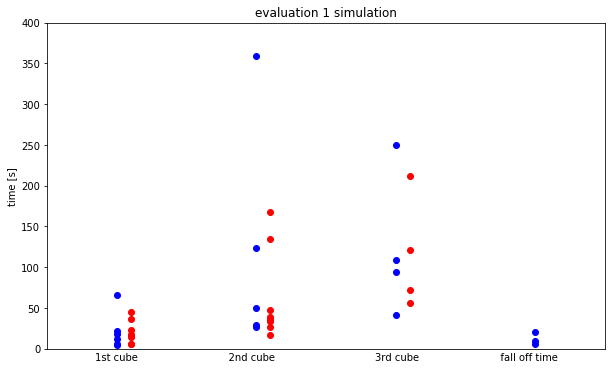

In [29]:
#y1_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval2_touched != ' ')].eval2_touched.astype(str).astype(int)
#x1_plan = [1] * len(y1_plan)
#y1_test = paperdata[(paperdata.condition == 1)&(paperdata.eval2_touched != ' ')].eval2_touched.astype(str).astype(int)
#x1_test = [1.1] * len(y1_test)

y2_plan = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 1)].firstcube_median
x2_plan = [2] * len(y2_plan)
y2_test = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 1)].firstcube_median
x2_test = [2.1] * len(y2_test)

y3_plan = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 1)].secondcube_median
x3_plan = [3] * len(y3_plan)
y3_test = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 1)].secondcube_median
x3_test = [3.1] * len(y3_test)

y4_plan = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 1)].thirdcube_median
x4_plan = [4] * len(y4_plan)
y4_test = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 1)].thirdcube_median
x4_test = [4.1] * len(y4_test)

y5_plan = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 1)].fallofftime_median
x5_plan = [5] * len(y5_plan)
y5_test = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 1)].fallofftime_median
x5_test = [5.1] * len(y5_test)

#y6_plan = df[(df.participant % 2 == 0)&(df.evaluation == 1)].lastmovedtime
#x6_plan = [5] * len(y6_plan)
#y6_test = df[(df.participant % 2 == 1)&(df.evaluation == 1)].lastmovedtime
#x6_test = [5.1] * len(y6_test)

N2_plan = len(y2_plan)
N2_test = len(y2_test)
N3_plan = len(y3_plan)
N3_test = len(y3_test)
N4_plan = len(y4_plan)
N4_test = len(y4_test)
N5_plan = len(y5_plan)
N5_test = len(y5_test)

#U1, p1 = stats.mannwhitneyu(y1_plan,y1_test)
U2, p2 = stats.mannwhitneyu(y2_plan,y2_test)
U3, p3 = stats.mannwhitneyu(y3_plan,y3_test)
U4, p4 = stats.mannwhitneyu(y4_plan,y4_test)
U5, p5 = stats.mannwhitneyu(y5_plan,y5_test)

print('evaluation 1 \t \t planners \t testers')
print('\t \t \t median  N \t median  N \t\t MannW U \t\t p-value')
#print('1st cube touched \t %.1f \t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y1_plan.mean(),y1_plan.std(),y1_test.mean(),y1_test.std(),t1,p1))
print('1st cube removed \t %.1f \t %i \t %.1f \t %i \t \t %.1f \t\t %.8f'%(y2_plan.median(),N2_plan, y2_test.median(),N2_test,U2,p2))
print('2nd cube removed \t %.1f \t %i \t %.1f \t %i \t \t %.1f \t\t %.8f'%(y3_plan.median(),N3_plan, y3_test.median(),N3_test,U3,p3))
print('3rd cube removed \t %.1f \t %i \t %.1f \t %i \t \t %.1f \t\t %.8f'%(y4_plan.median(),N4_plan, y4_test.median(),N4_test,U4,p4))
print('fall off time \t\t %.1f \t %i \t %.1f \t %i \t \t %.1f \t\t %.8f'%(y5_plan.median(), N5_plan, y5_test.median(),N5_test,U5,p5))


plt.subplots(figsize=(10, 6))
plt.xlim(1.5,5.5)
plt.ylim(0,400)

#plt.xlabel('1st cube touched', horizontalalignment='right')
plt.xlabel('1st cube                             2nd cube                                3rd cube                          fall off time')
plt.ylabel('time [s]')
plt.title("evaluation 1 simulation")

plt.xticks([])

#plt.plot(x1_plan,y1_plan,'ob', label = 'plan')  
#plt.plot(x1_test,y1_test,'or', label = 'test') 
plt.plot(x2_plan,y2_plan,'ob', label = 'plan')  
plt.plot(x2_test,y2_test,'or', label = 'test')
plt.plot(x3_plan,y3_plan,'ob', label = 'plan')  
plt.plot(x3_test,y3_test,'or', label = 'test')
plt.plot(x4_plan,y4_plan,'ob', label = 'plan')  
plt.plot(x4_test,y4_test,'or', label = 'test')
plt.plot(x5_plan,y5_plan,'ob', label = 'plan')  
plt.plot(x5_test,y5_test,'or', label = 'test')
#plt.plot(x6_plan,y6_plan,'ob', label = 'plan')  
#plt.plot(x6_test,y6_test,'or', label = 'test')
plt.show()

### 6. a) plotting averaged data (over 5 evaluations)

plotting how removed cubes develops over the evaluations for each participant 

In [ ]:
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/evaldataFigures/removedcubes').mkdir(parents=True, exist_ok=True)  

for participant in range(41, 72):
    for evaluation in range(1,6):
        x = evalSummary[(evalSummary.participant == participant)].evaluation
        y = evalSummary[(evalSummary.participant == participant)].removedcubes_mean
        ystd = evalSummary[(evalSummary.participant == participant)].removedcubes_std/y
        ye = evalSummary[(evalSummary.participant == participant)].removedcubes_std / np.sqrt(evalSummary[(evalSummary.participant == participant)].removedcubes_N)
        plt.subplots(figsize=(10, 6))
        plt.xlim(0.5,5.5)
        plt.ylim(0,3.1)
        filestring = "/TrollLABS/robotExp/results/simulationResults/evaldataFigures/removedcubes/p" + str(participant)
        plt.figtext(0.15, 0.8,"removedcubes p" + str(participant), color='black', weight='roman')
        plt.plot(x,y,'o--', label = 'means')
        plt.errorbar(x, y, yerr=ye)
        plt.plot(x,ystd,'+--', label = 'stdev/mean')
        plt.legend()
        plt.savefig(filestring, bbox_inches = "tight")

plotting when the first, second and third cubes were removed over the evaluations for each participant 

In [ ]:
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/evaldataFigures/123cube').mkdir(parents=True, exist_ok=True) 

for participant in range(41, 72):
    for evaluation in range(1,6):
        x = evalSummary[(evalSummary.participant == participant)].evaluation
        y1 = evalSummary[(evalSummary.participant == participant)].firstcube_mean
        ye1 = evalSummary[(evalSummary.participant == participant)].firstcube_std/np.sqrt(evalSummary[(evalSummary.participant == participant)].firstcube_N)
        y2 = evalSummary[(evalSummary.participant == participant)].secondcube_mean
        ye2 = evalSummary[(evalSummary.participant == participant)].secondcube_std/np.sqrt(evalSummary[(evalSummary.participant == participant)].secondcube_N)
        y3 = evalSummary[(evalSummary.participant == participant)].thirdcube_mean
        ye3 = evalSummary[(evalSummary.participant == participant)].thirdcube_std/np.sqrt(evalSummary[(evalSummary.participant == participant)].thirdcube_N)
        plt.subplots(figsize=(10, 6))
        plt.xlim(0.5,5.5)
        plt.ylim(0,400)
        filestring = "/TrollLABS/robotExp/results/simulationResults/evaldataFigures/123cube/p" + str(participant)
        plt.figtext(0.15, 0.8,"123cube p" + str(participant), color='black', weight='roman')
        plt.plot(x,y1,'o--')
        plt.plot(x,y2,'o--')
        plt.plot(x,y3,'o--')
        plt.errorbar(x, y1, yerr=ye1)
        plt.errorbar(x, y2, yerr=ye2)
        plt.errorbar(x, y3, yerr=ye3)
        plt.savefig(filestring, bbox_inches = "tight")

plotting how often the code completed the task in each evaluation for every participant 

In [ ]:
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/evaldataFigures/taskcomplete').mkdir(parents=True, exist_ok=True)

for participant in range(41, 72):
    for evaluation in range(1,6):
        x = evalSummary[(evalSummary.participant == participant)].evaluation
        y = evalSummary[(evalSummary.participant == participant)].taskcomplete_mean
        ye = evalSummary[(evalSummary.participant == participant)].taskcomplete_std/np.sqrt(evalSummary[(evalSummary.participant == participant)].taskcomplete_N)
        
        plt.subplots(figsize=(10, 6))
        plt.xlim(0.5,5.5)
        plt.ylim(-0.05,1.05)
        filestring = "/TrollLABS/robotExp/results/simulationResults/evaldataFigures/taskcomplete/p" + str(participant)
        plt.figtext(0.15, 0.8,"taskcomplete p" + str(participant), color='black', weight='roman')
        plt.plot(x,y,'o--')
        plt.errorbar(x, y, yerr=ye)
        plt.savefig(filestring, bbox_inches = "tight")

plotting the overall time (time of last cube - bonus + penalty) for the completed task in each evaluation for every participant 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


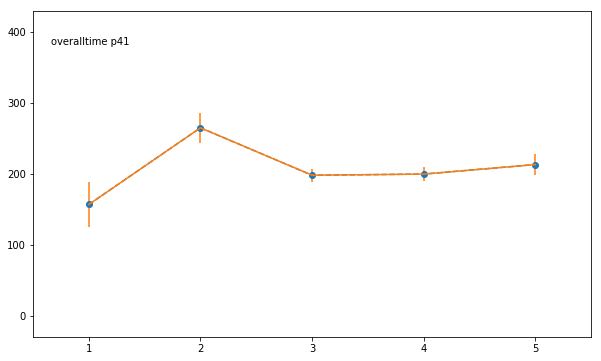

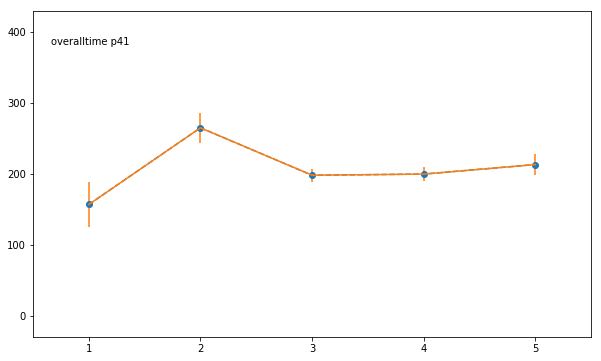

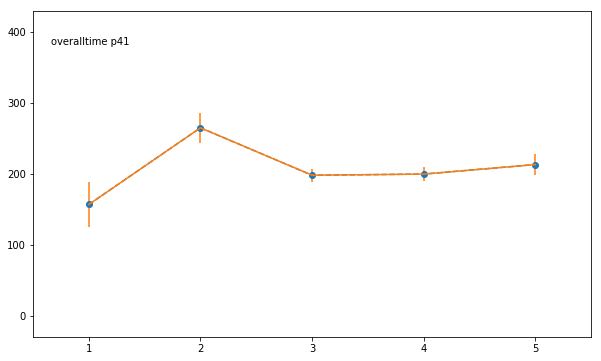

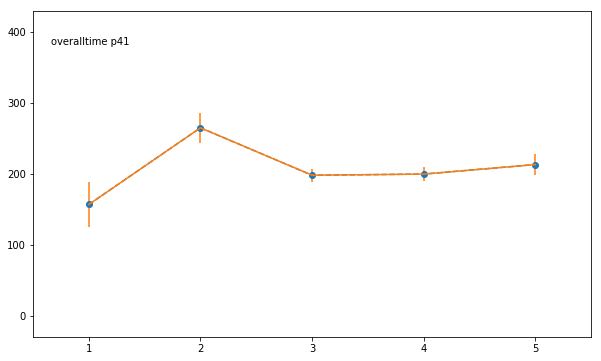

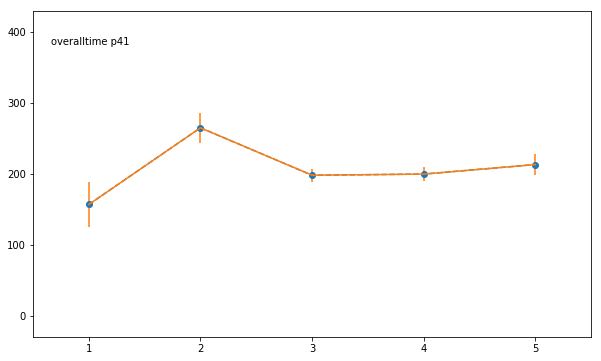

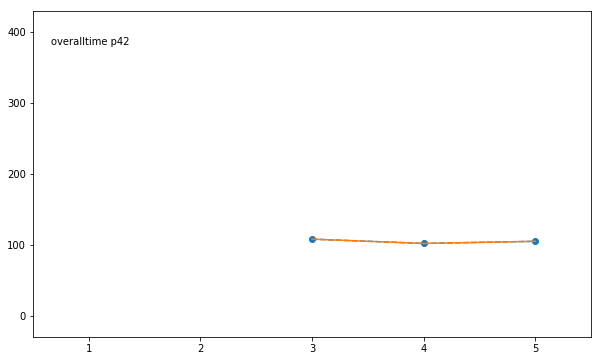

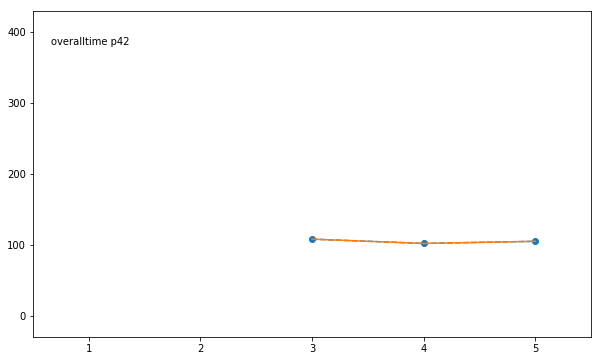

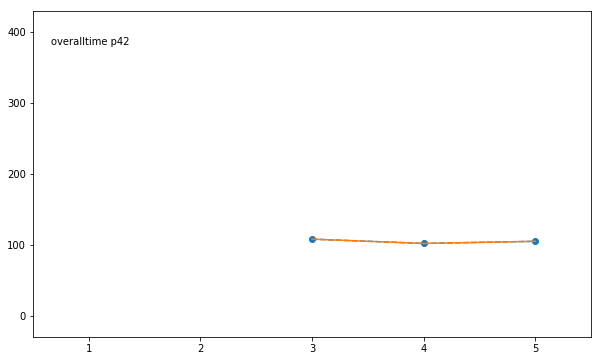

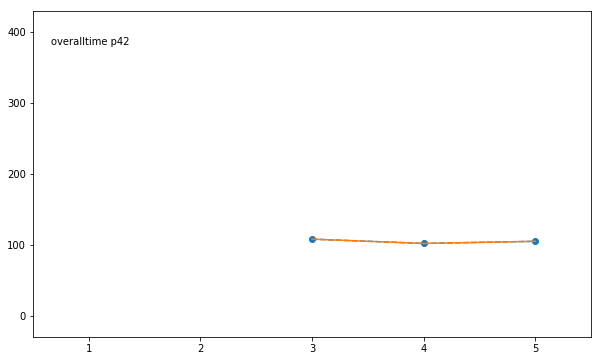

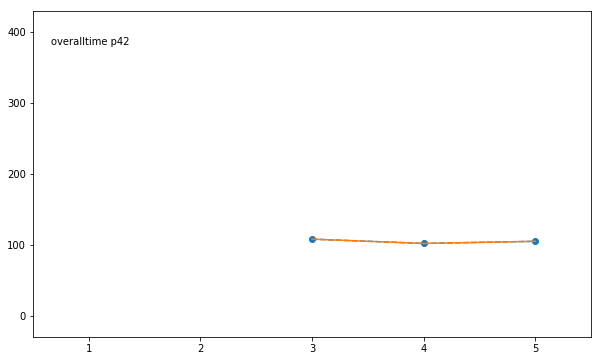

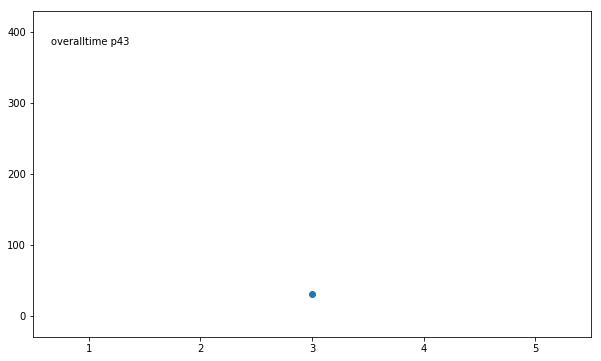

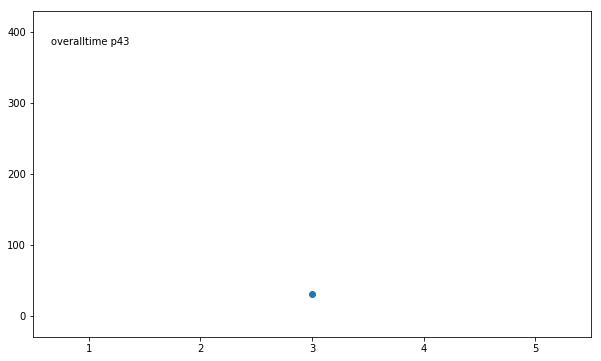

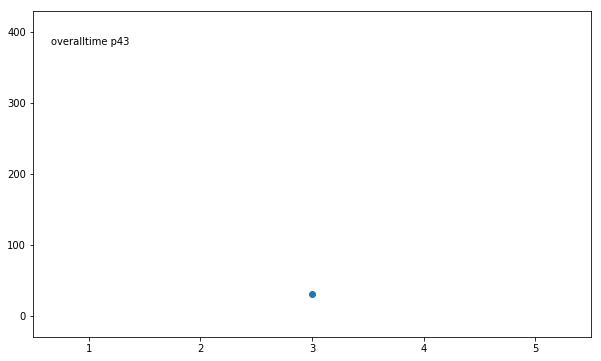

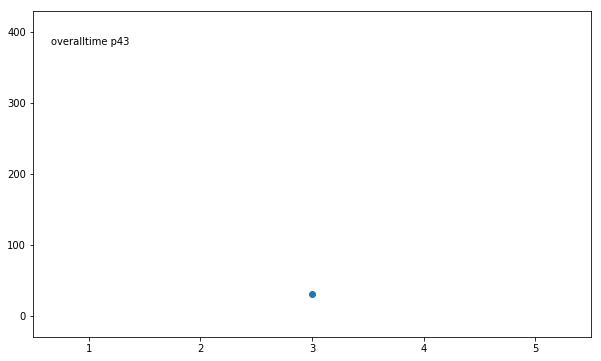

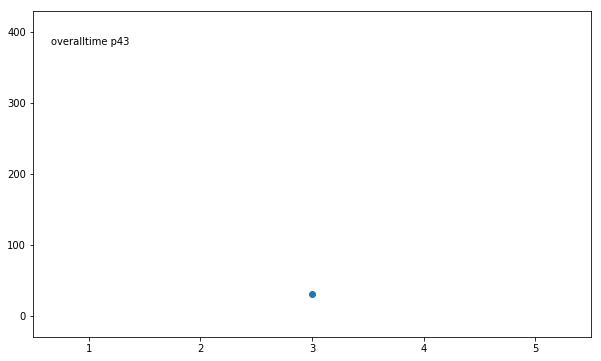

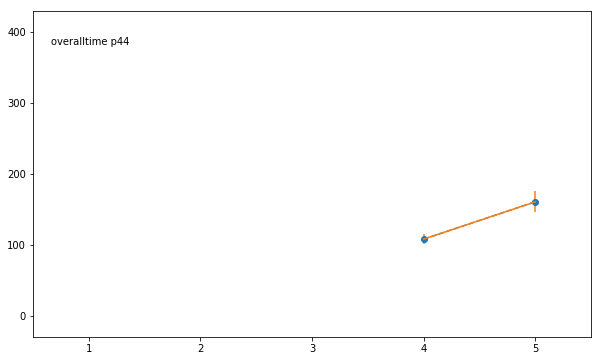

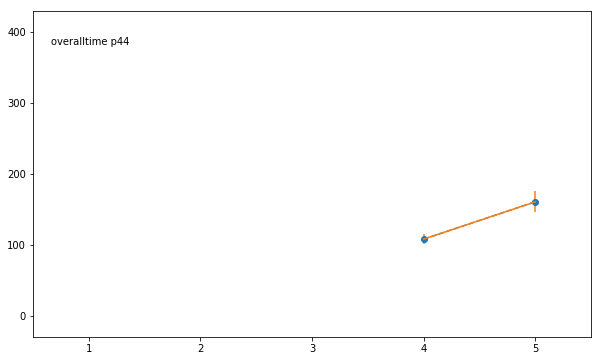

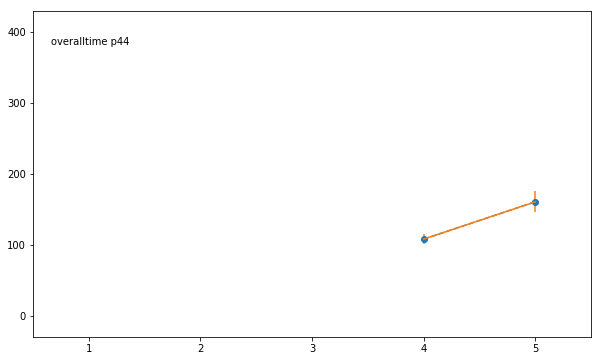

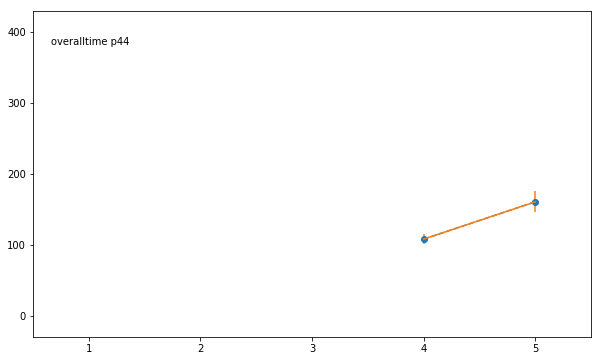

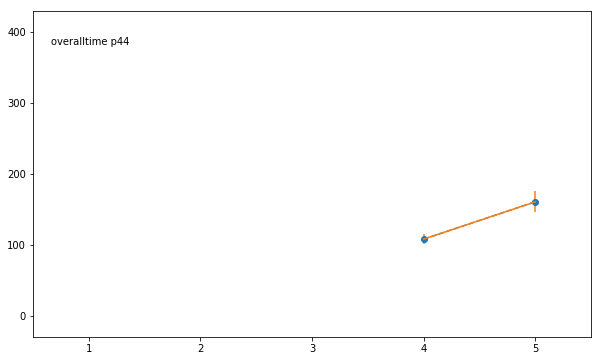

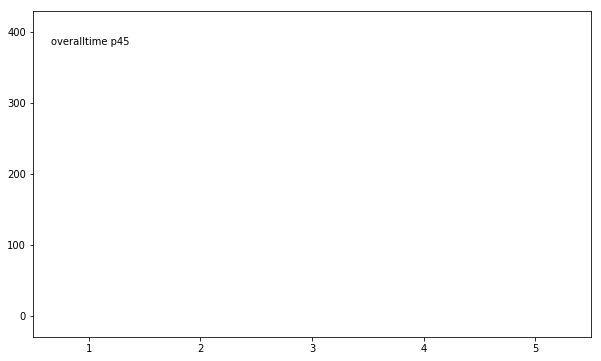

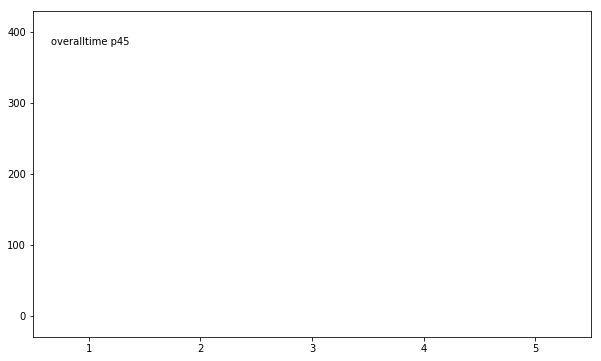

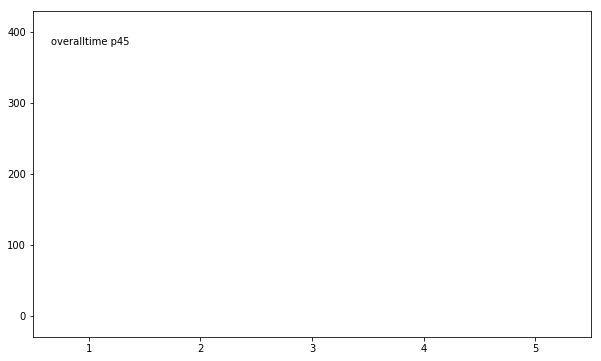

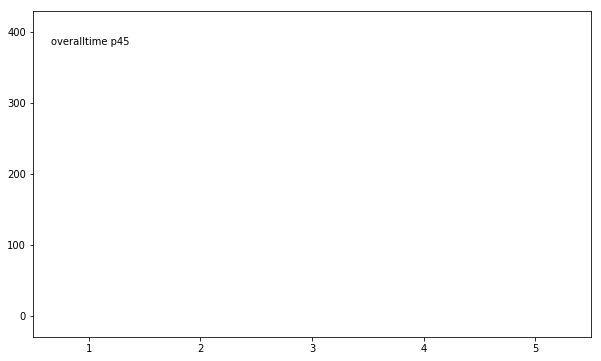

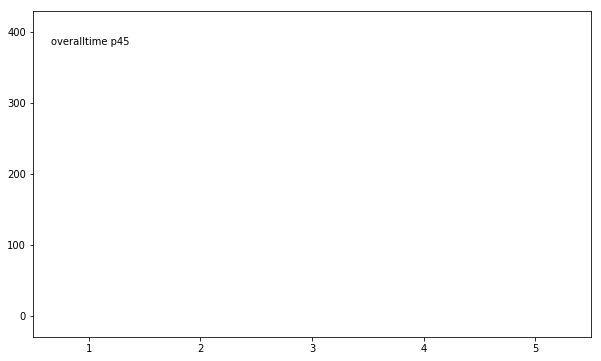

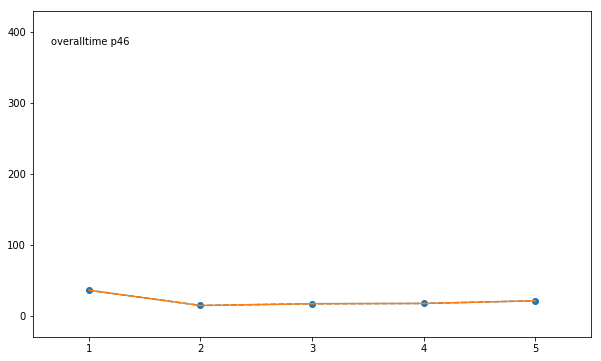

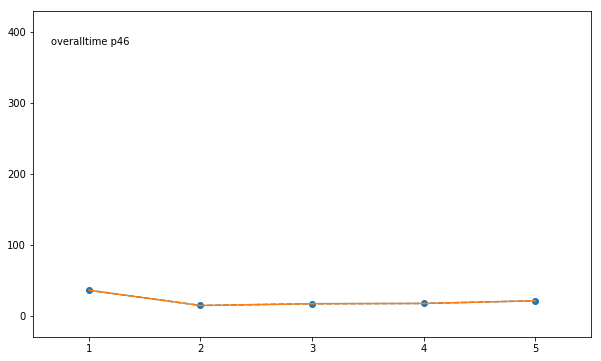

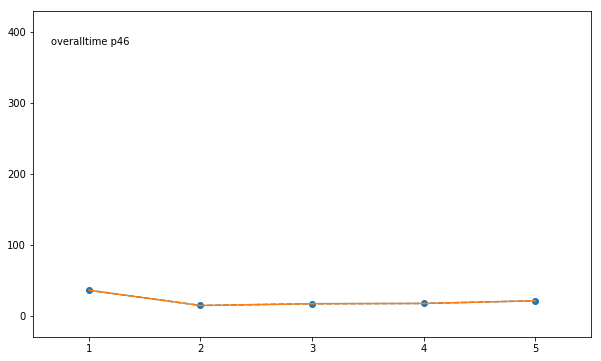

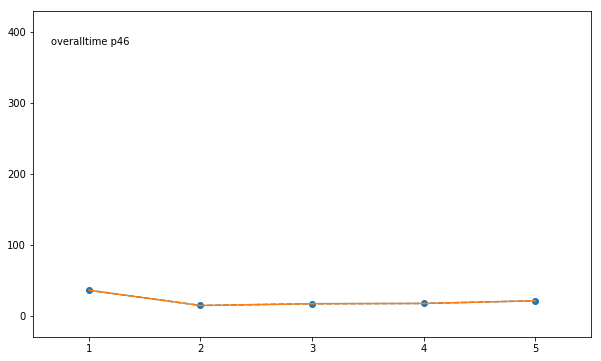

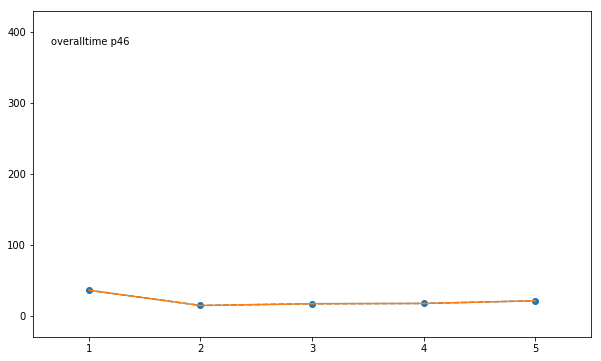

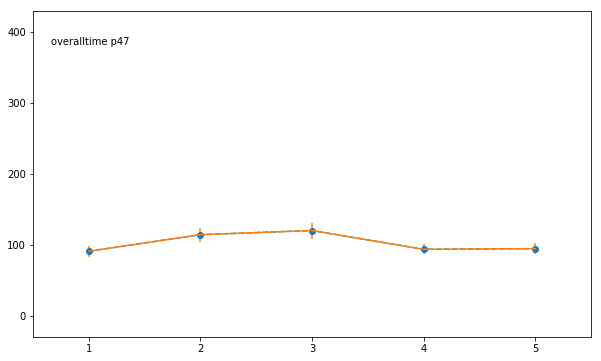

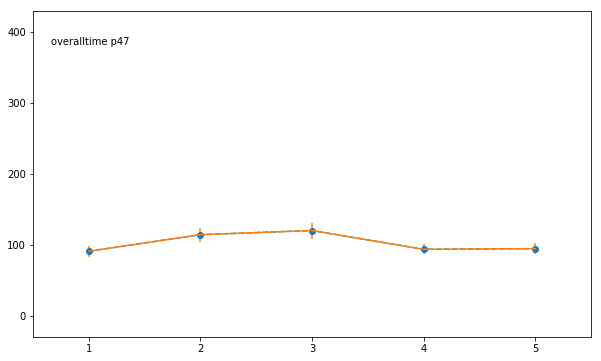

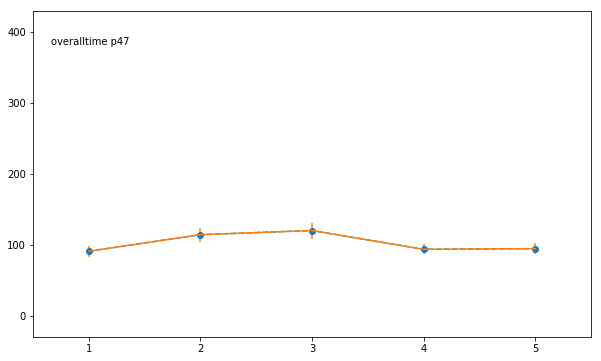

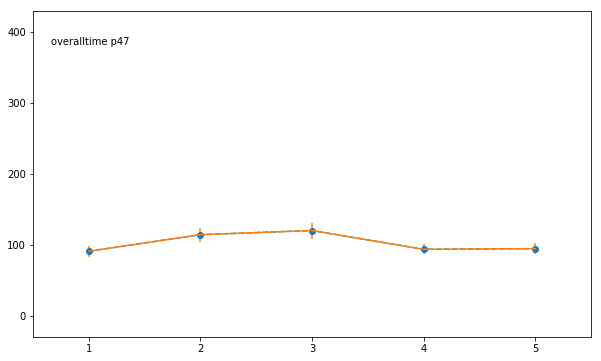

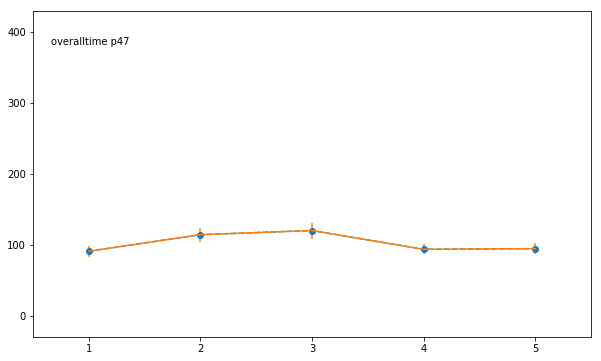

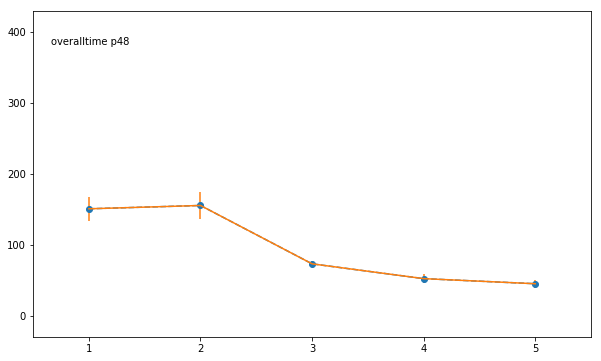

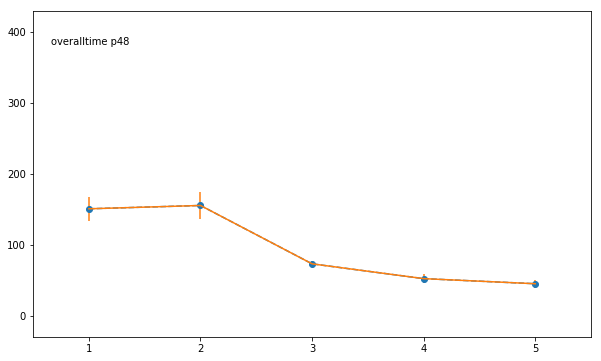

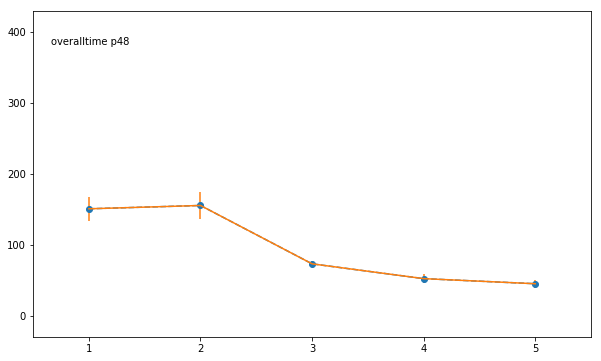

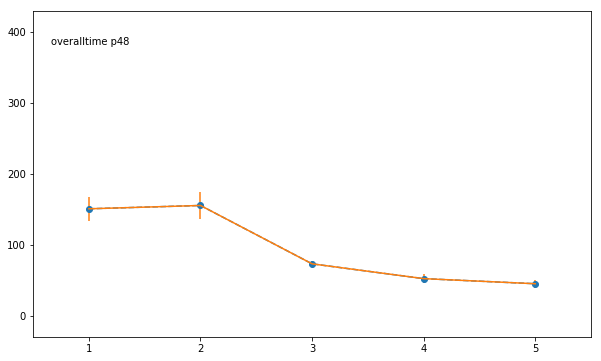

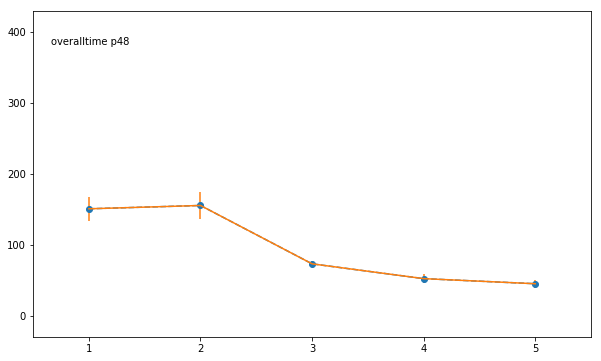

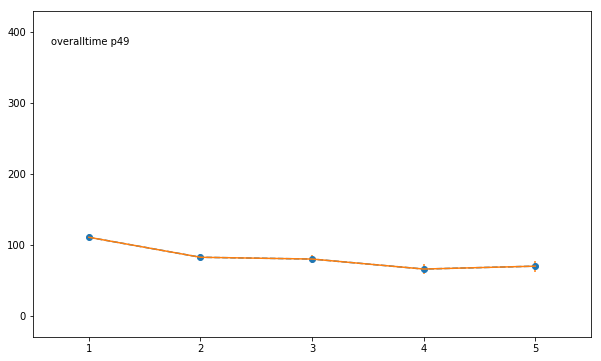

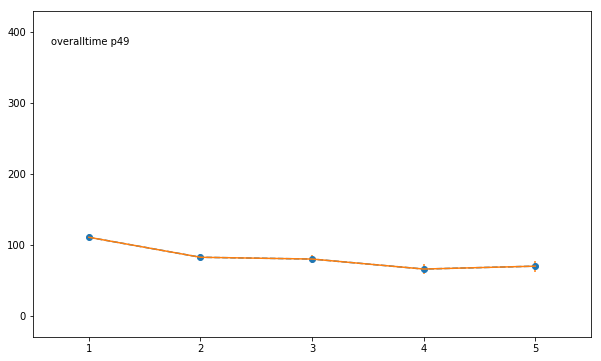

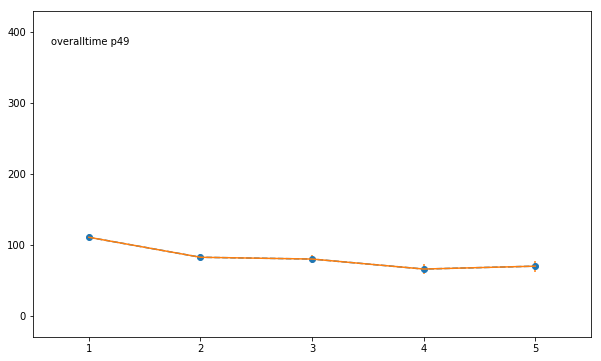

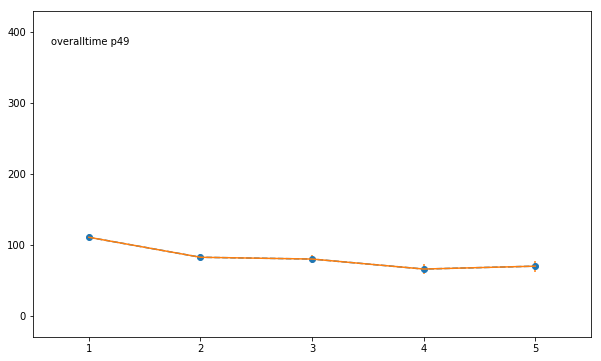

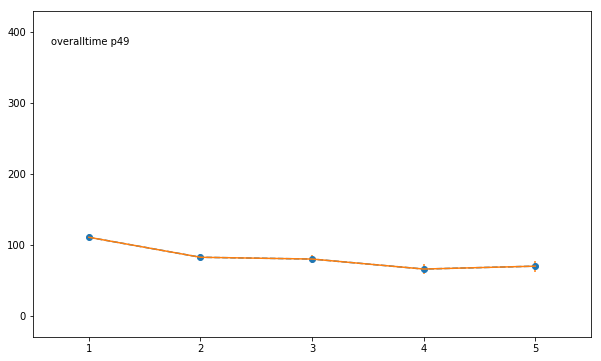

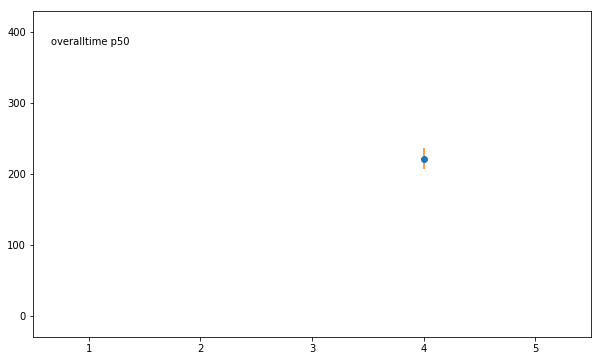

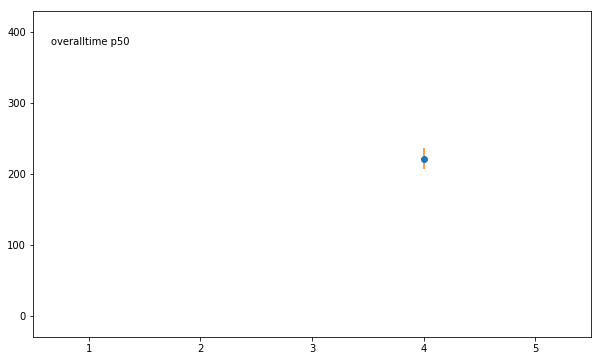

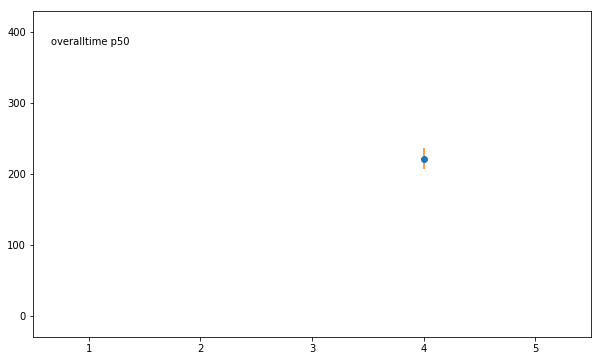

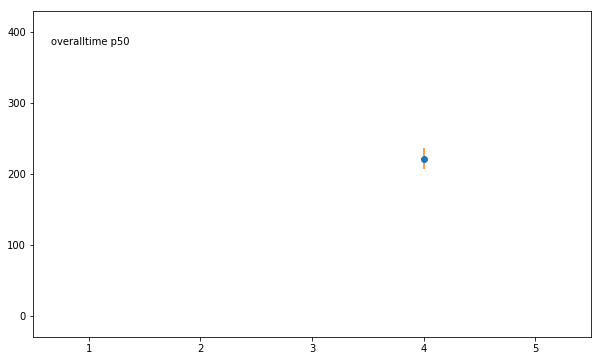

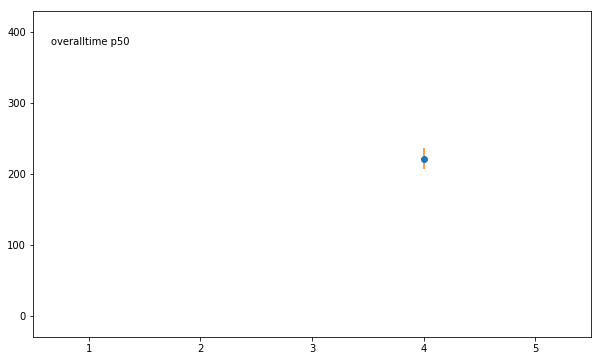

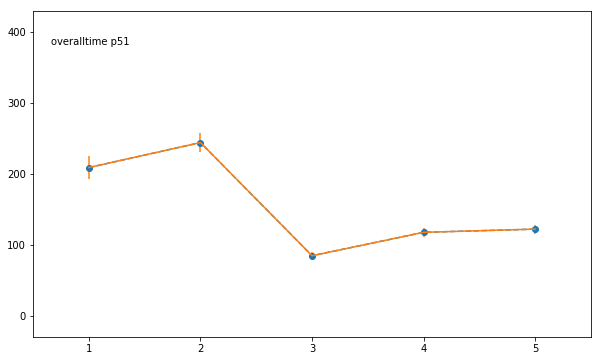

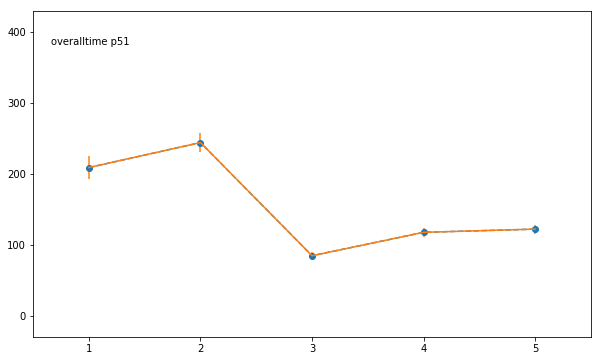

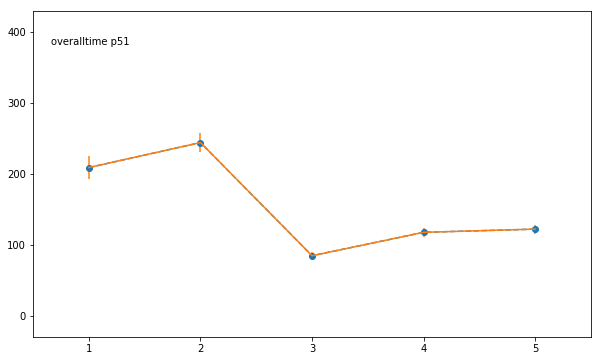

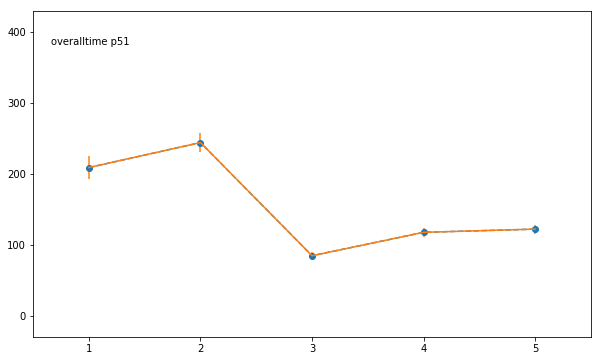

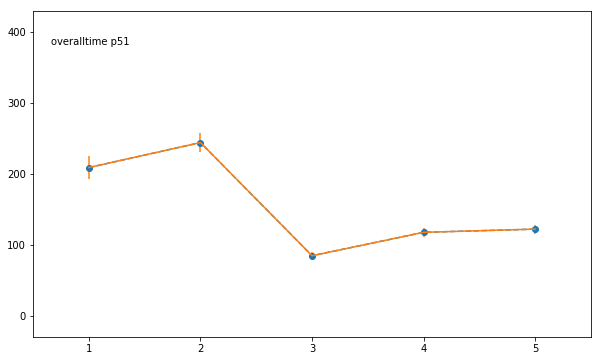

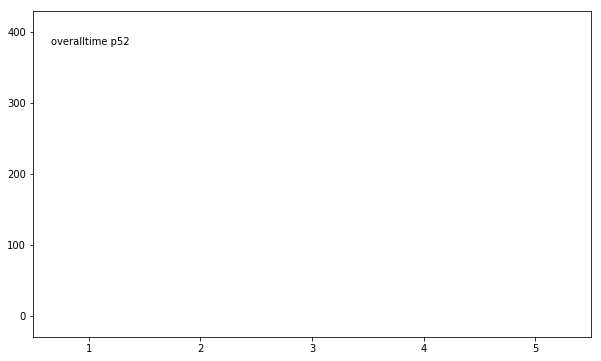

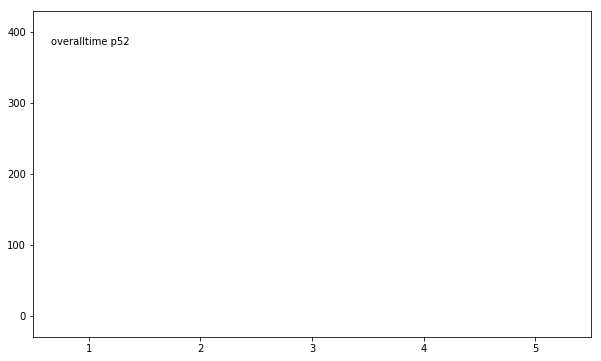

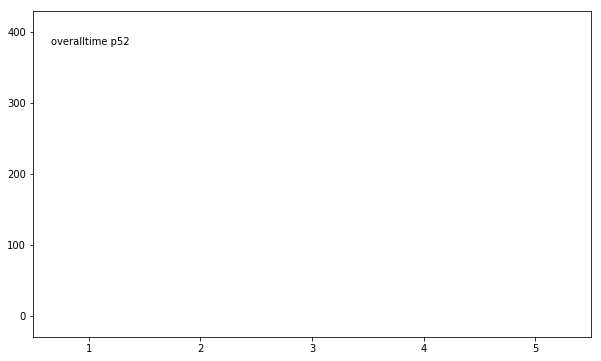

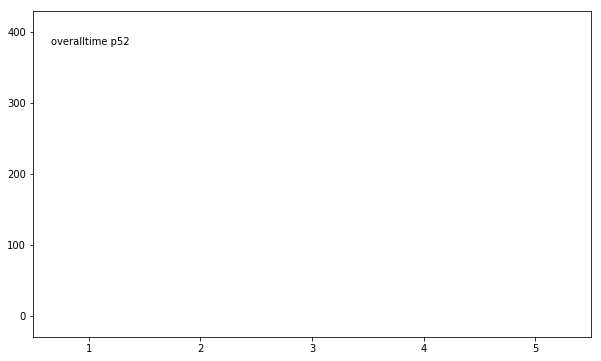

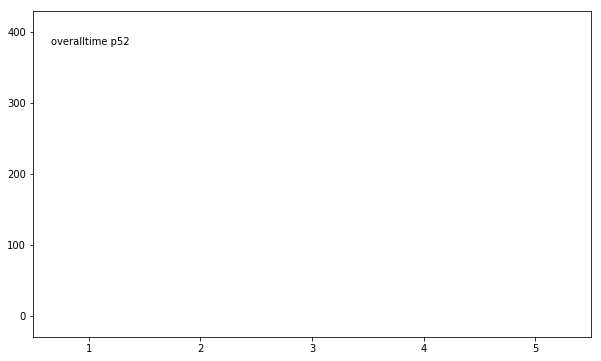

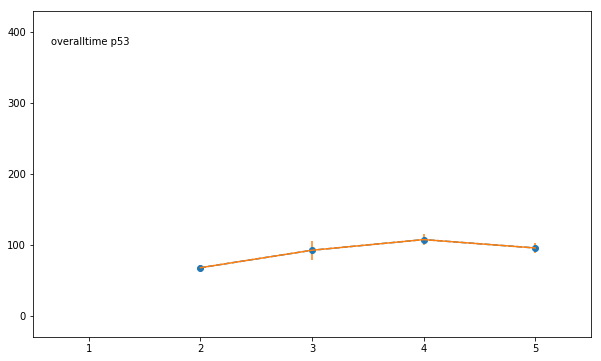

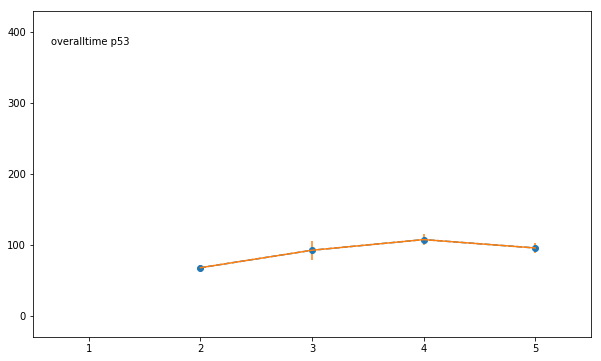

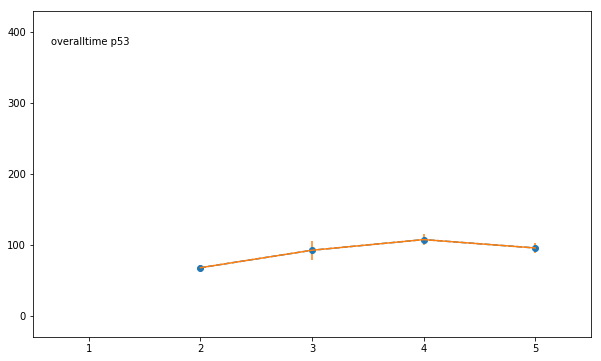

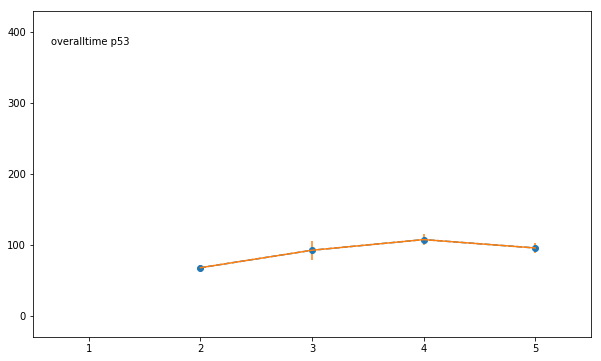

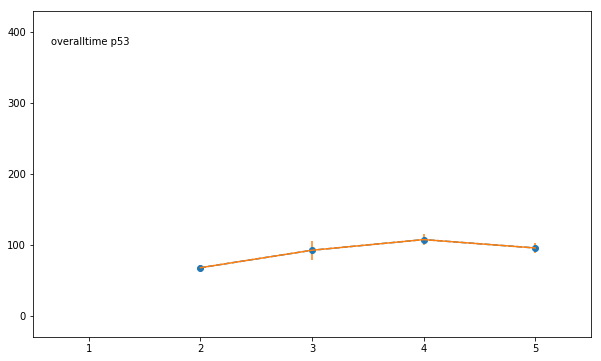

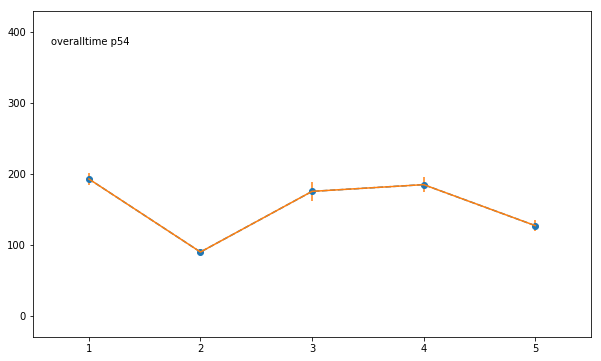

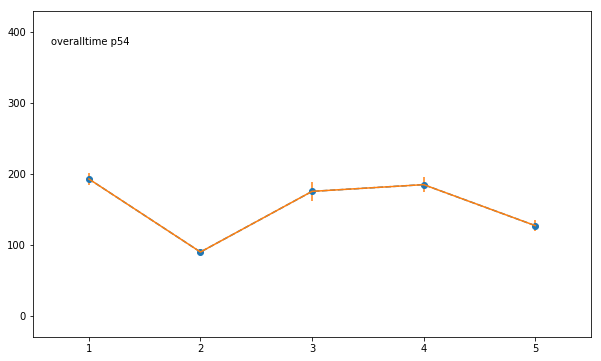

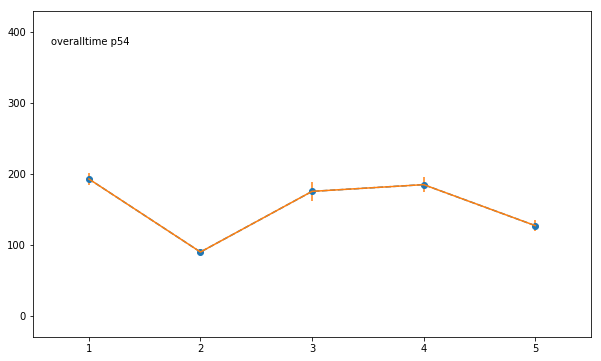

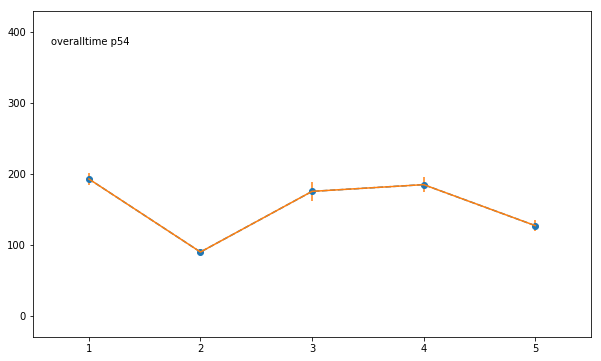

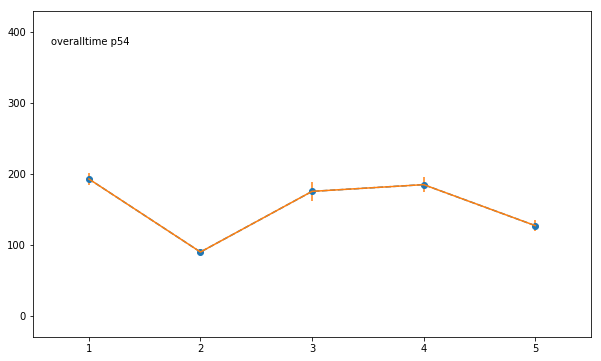

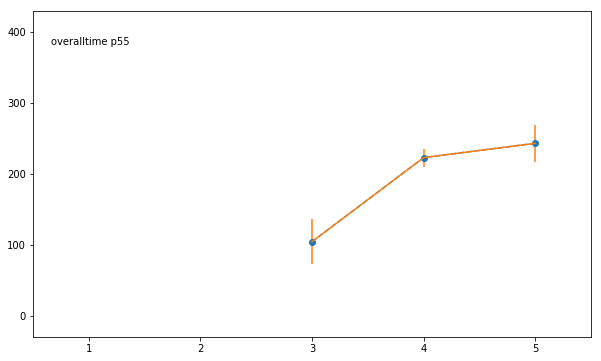

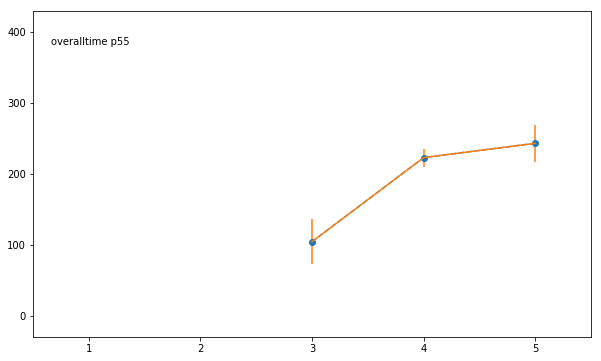

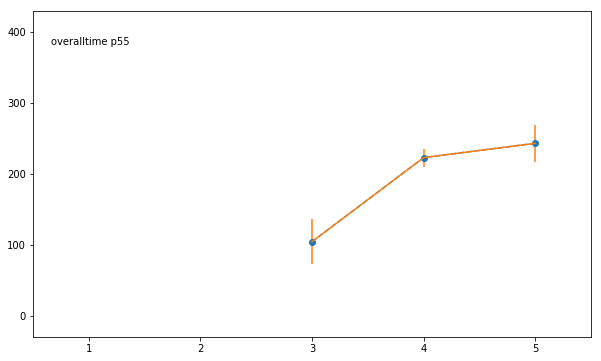

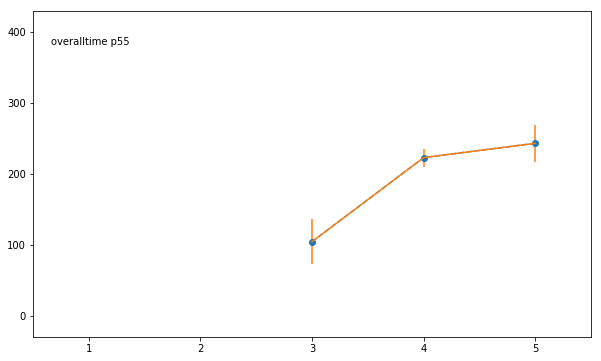

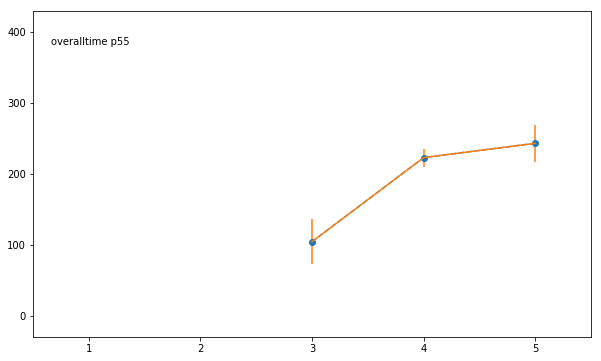

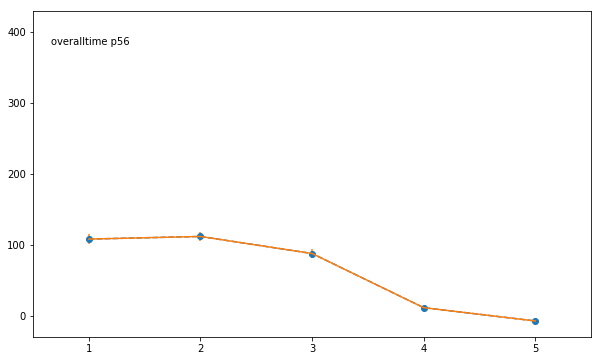

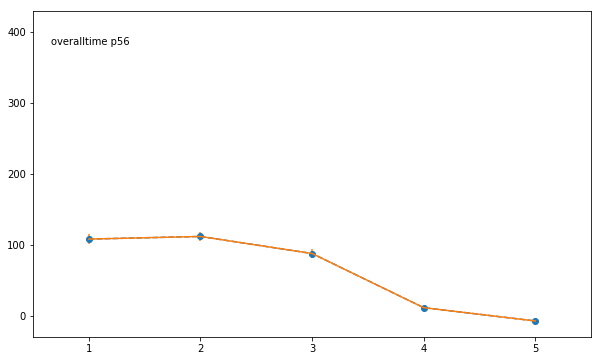

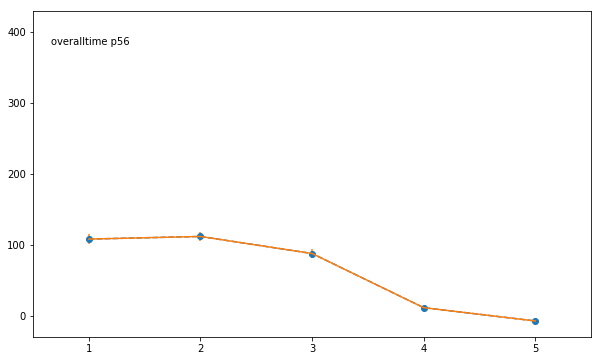

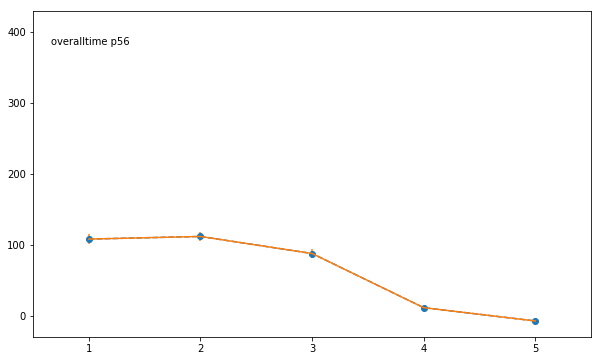

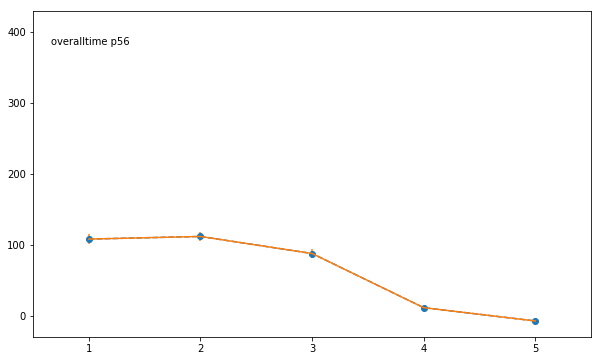

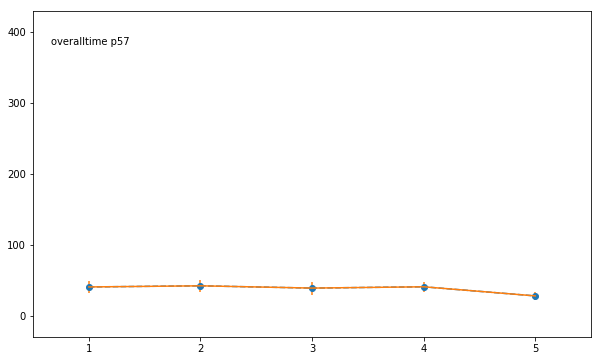

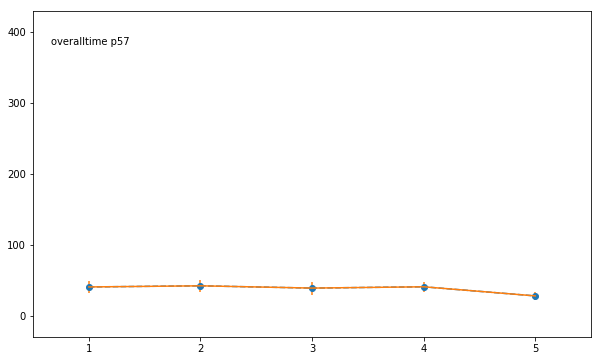

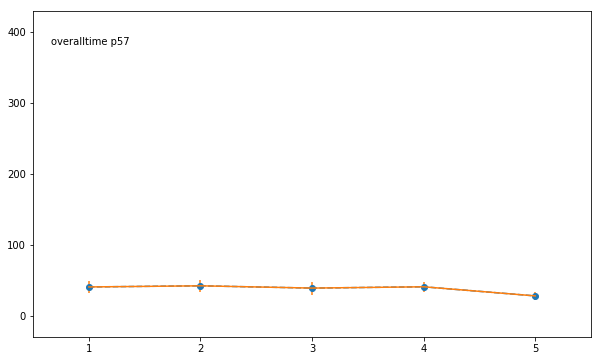

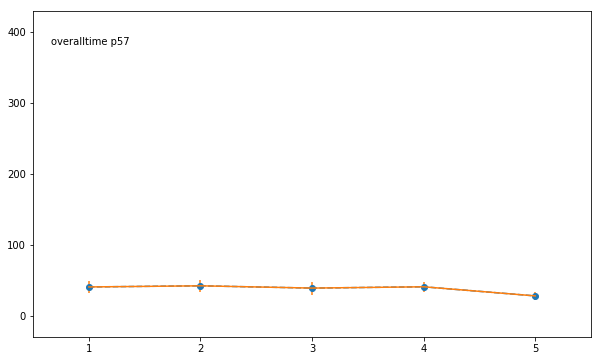

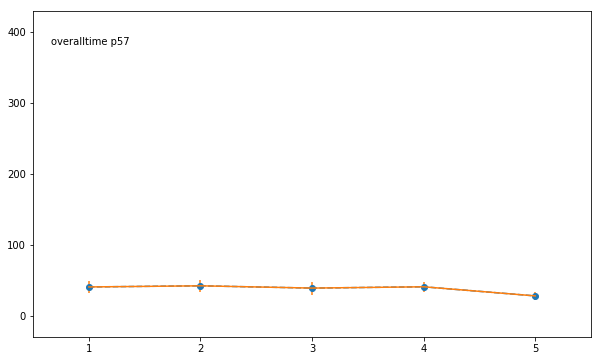

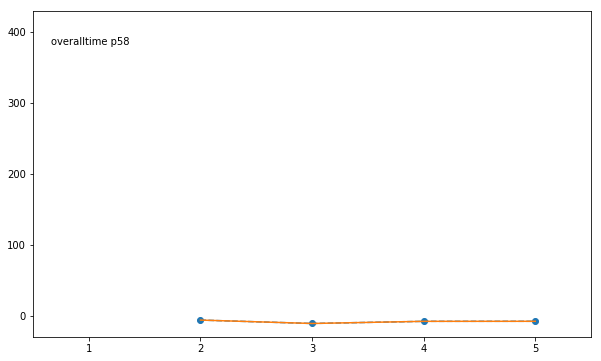

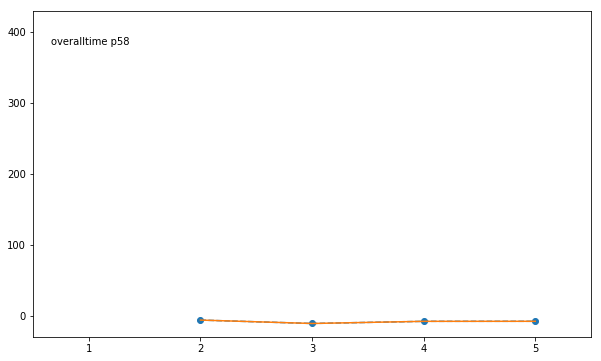

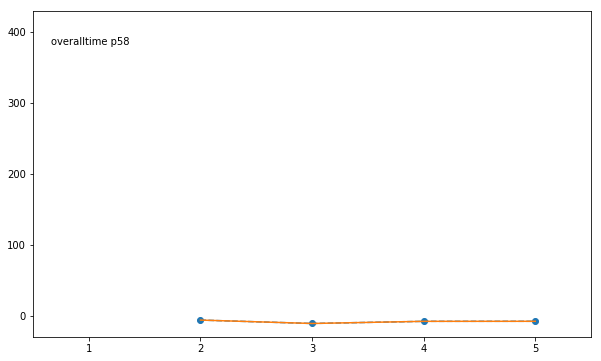

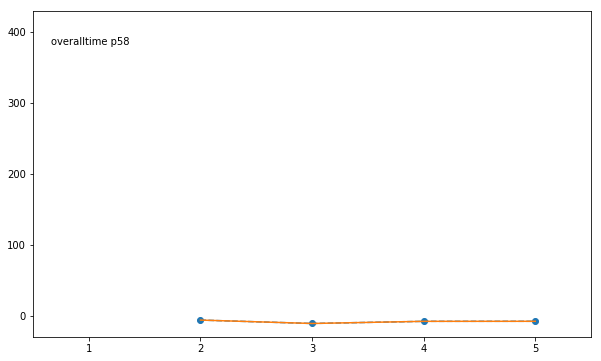

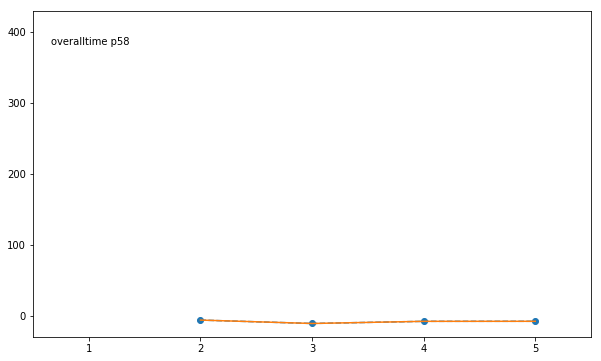

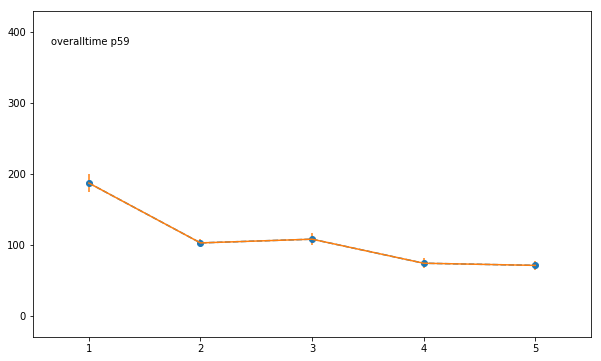

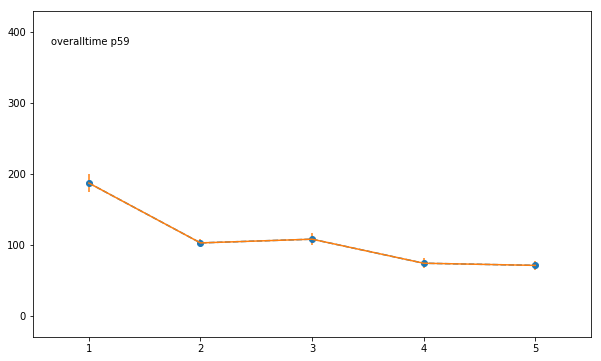

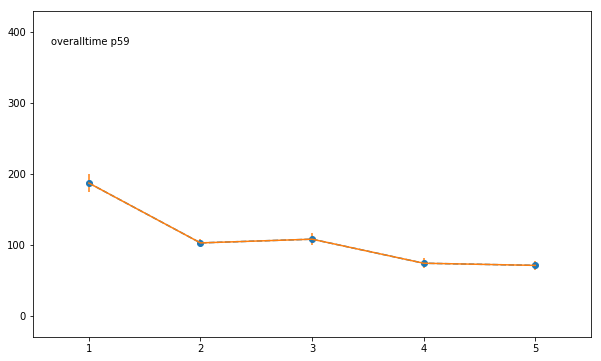

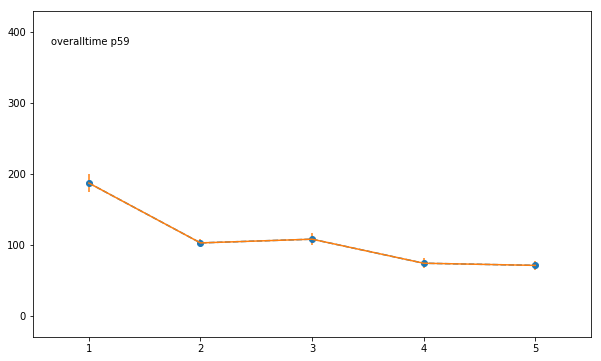

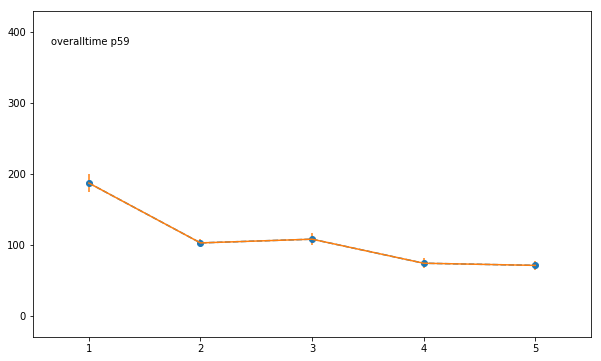

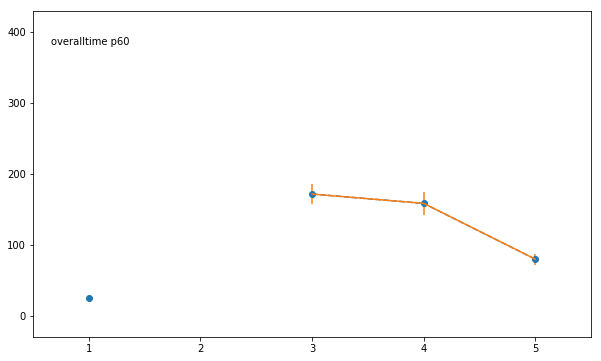

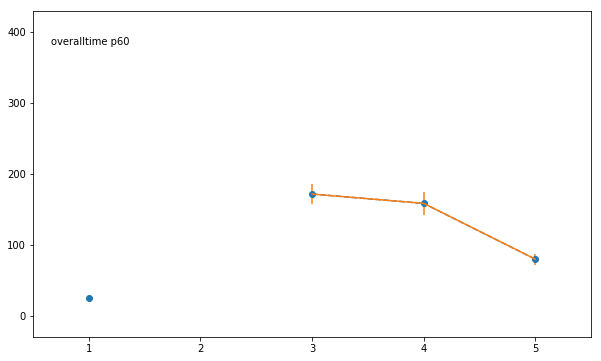

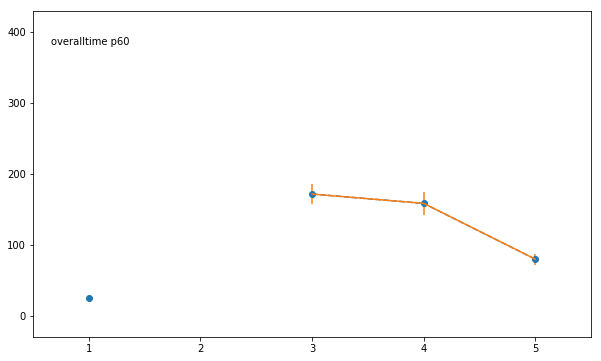

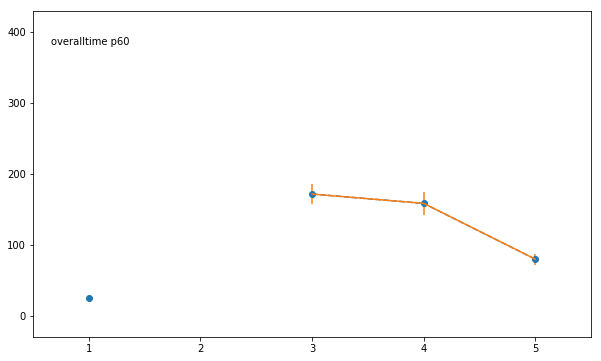

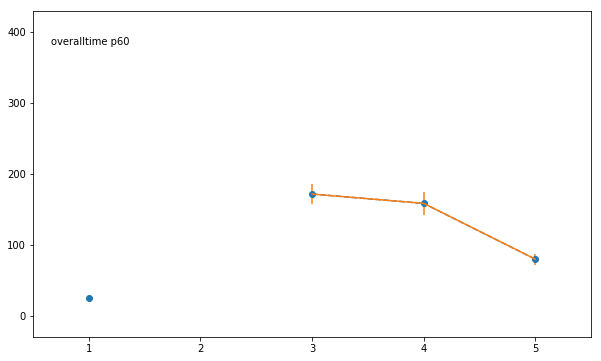

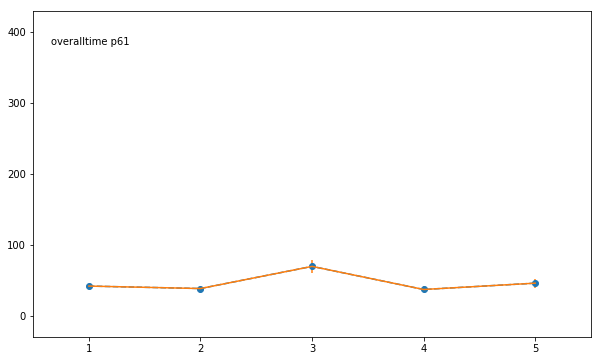

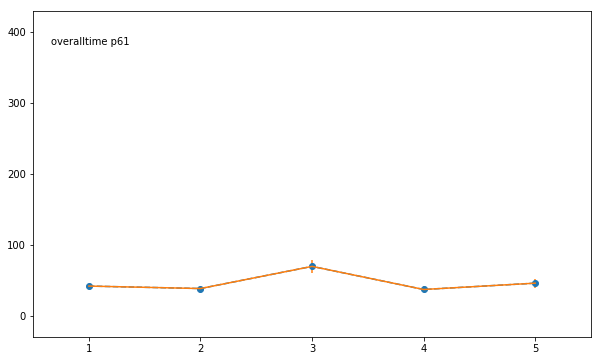

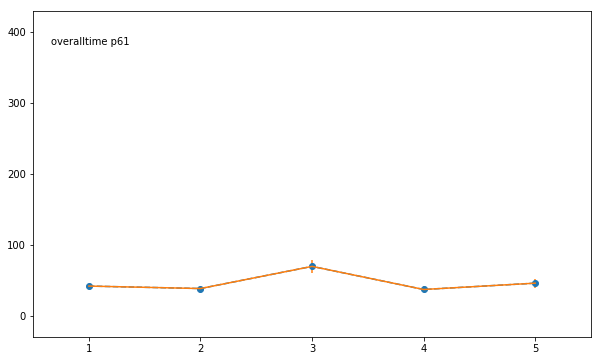

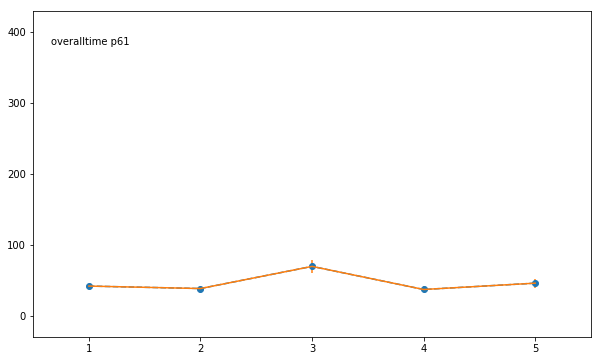

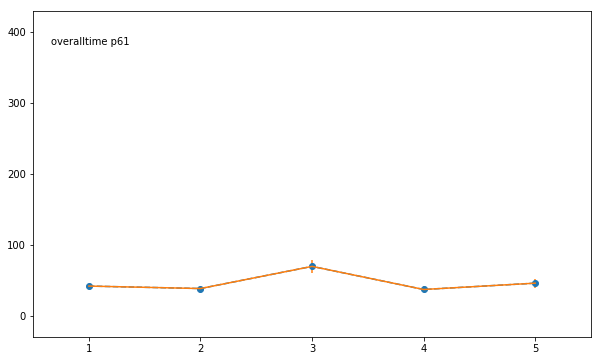

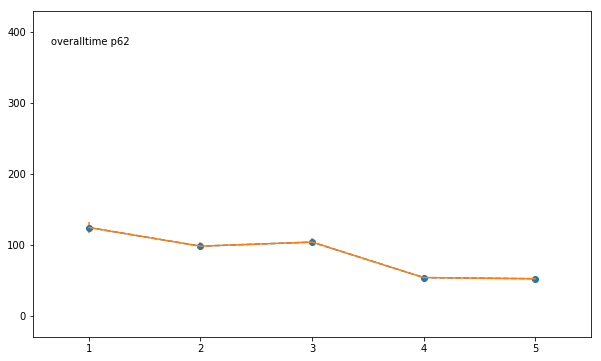

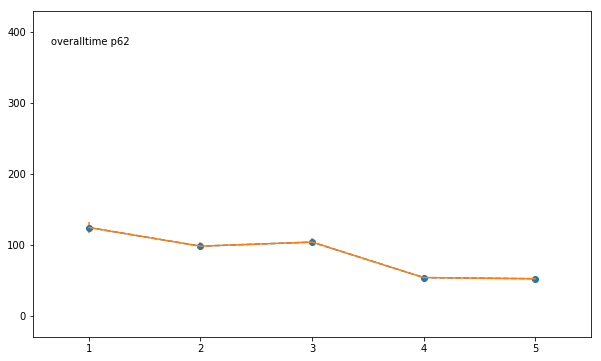

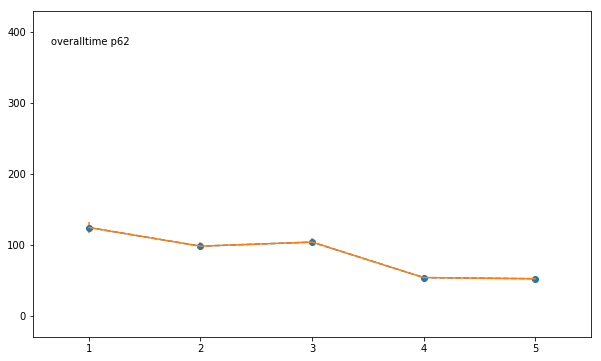

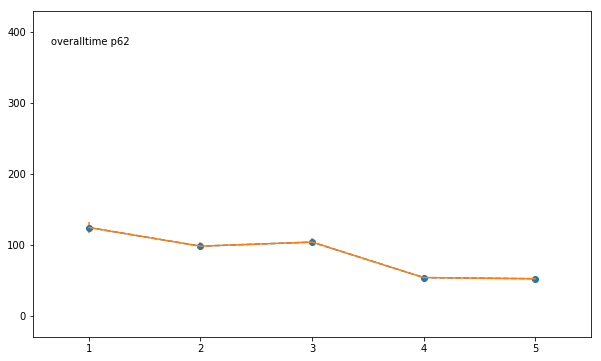

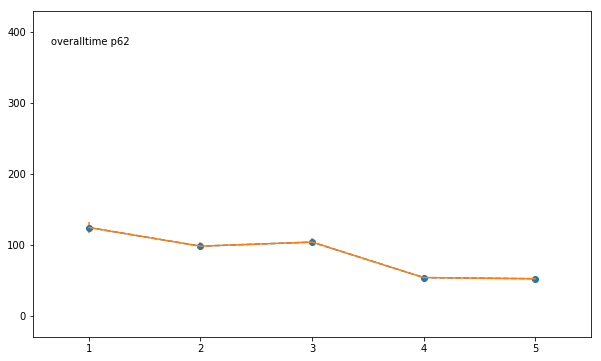

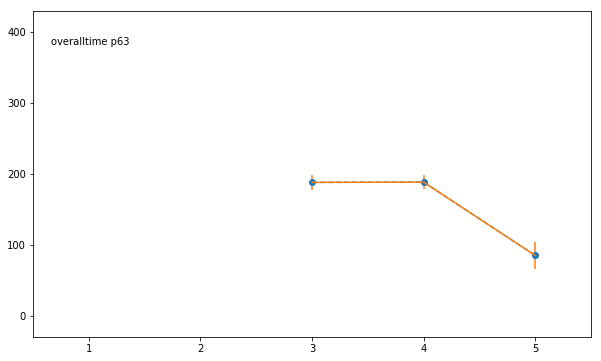

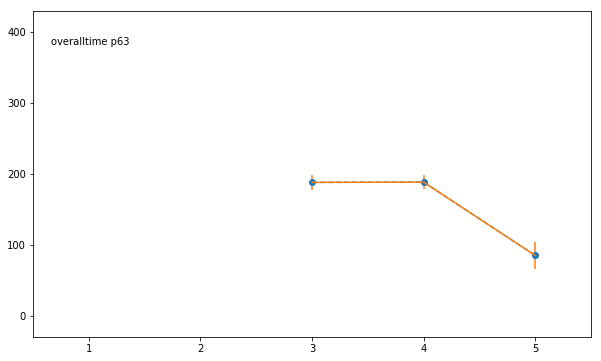

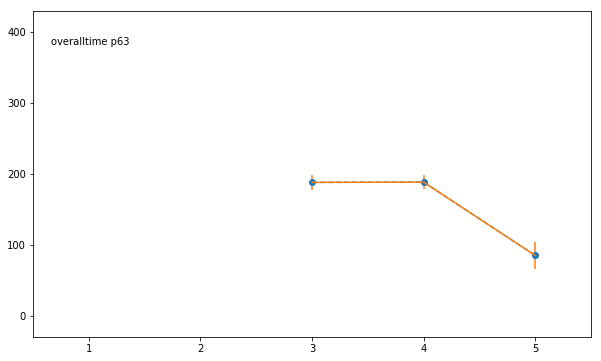

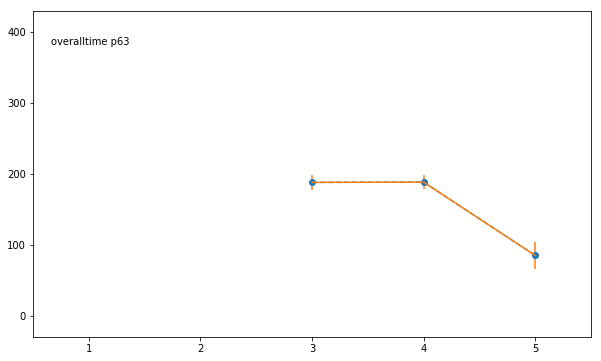

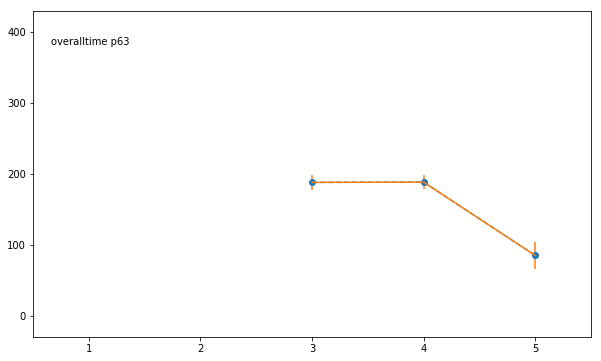

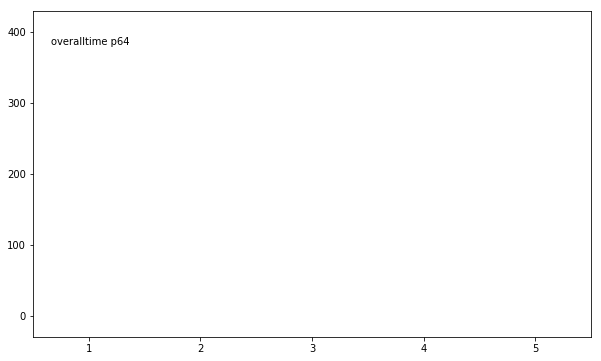

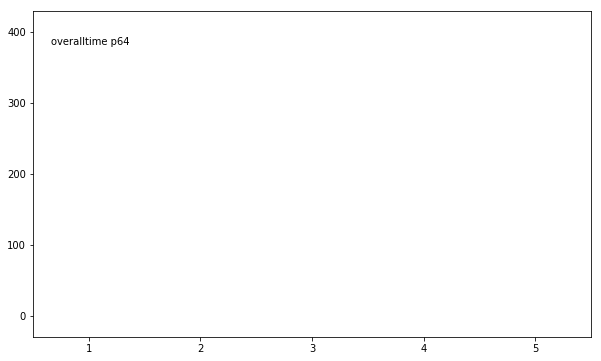

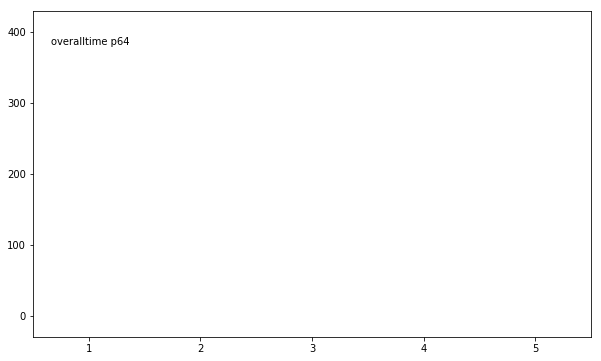

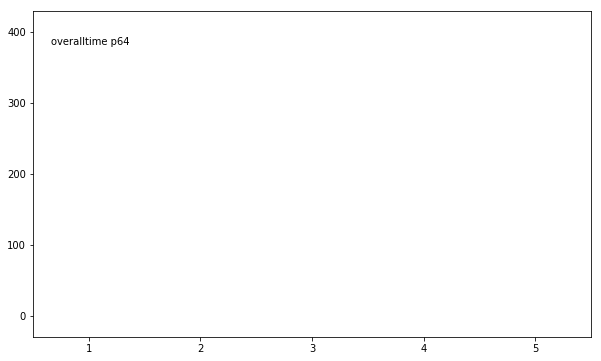

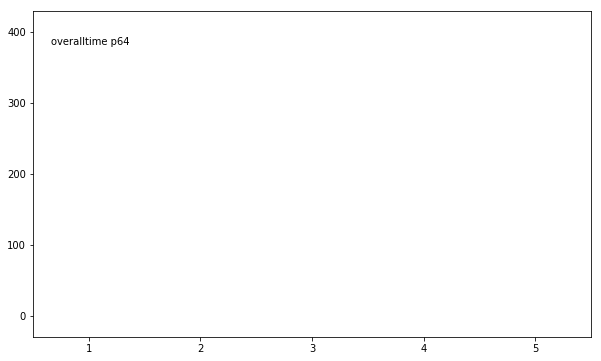

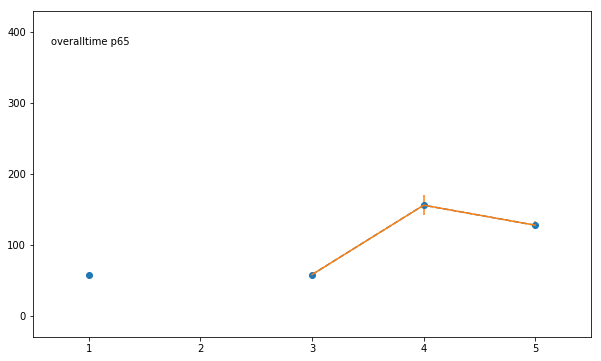

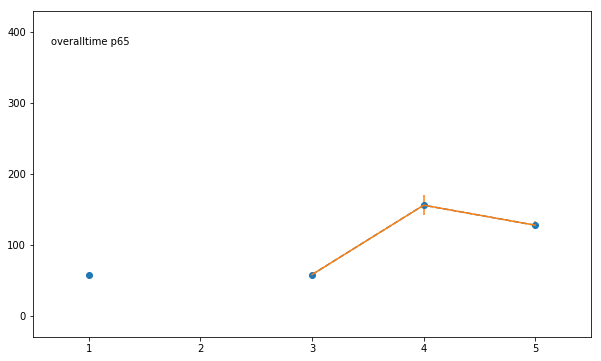

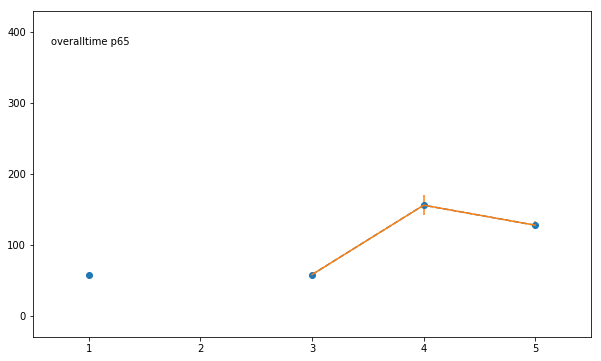

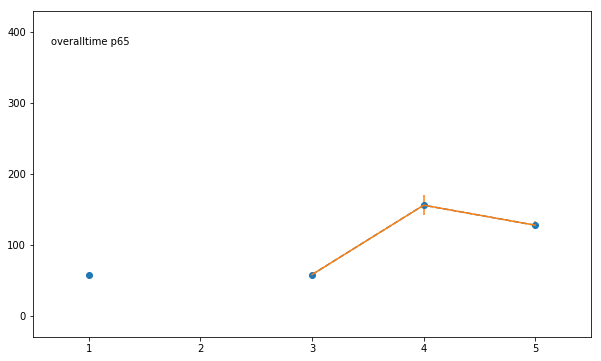

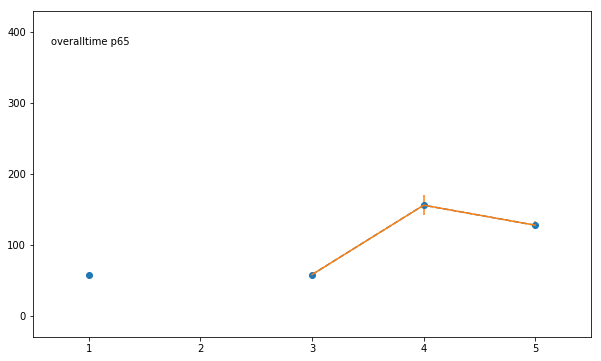

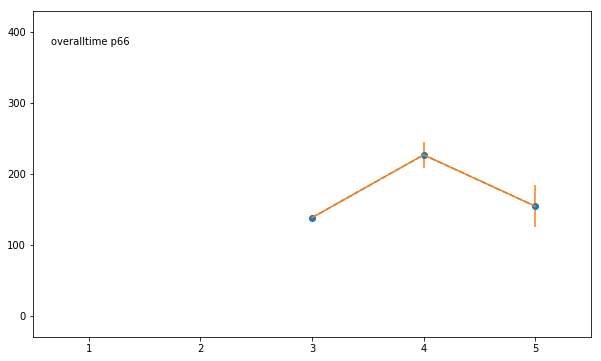

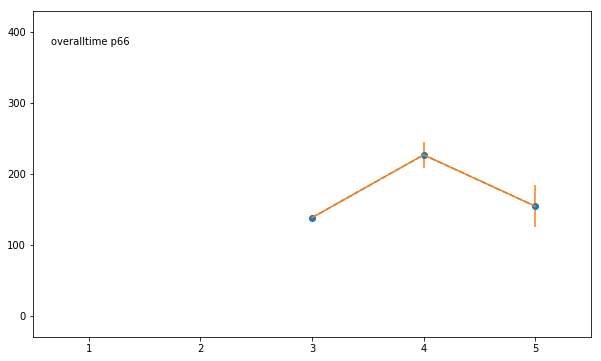

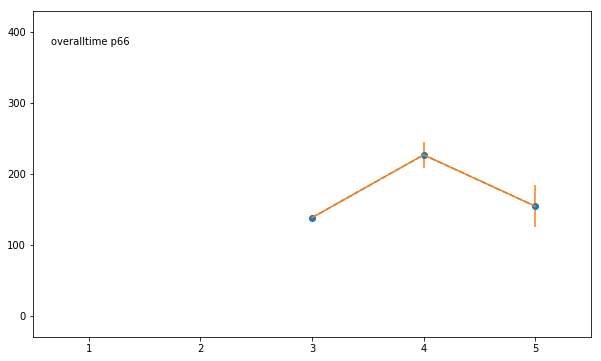

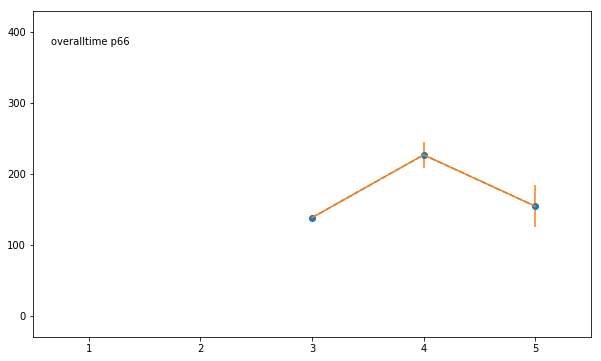

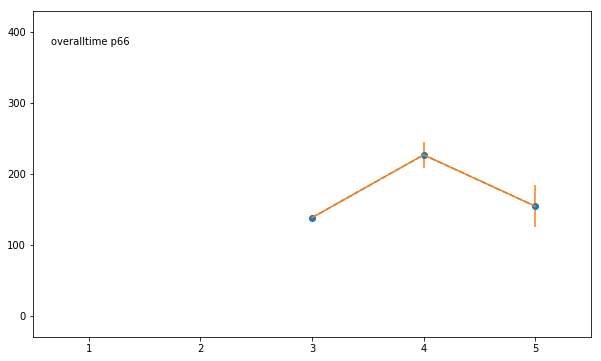

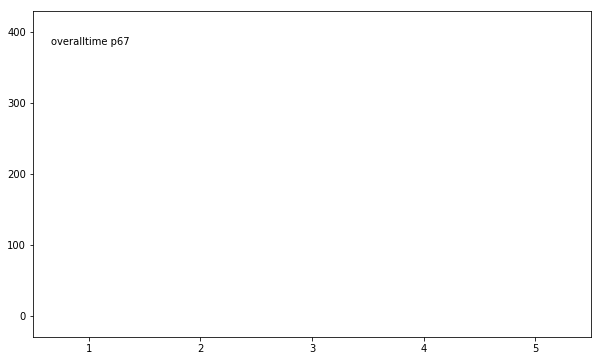

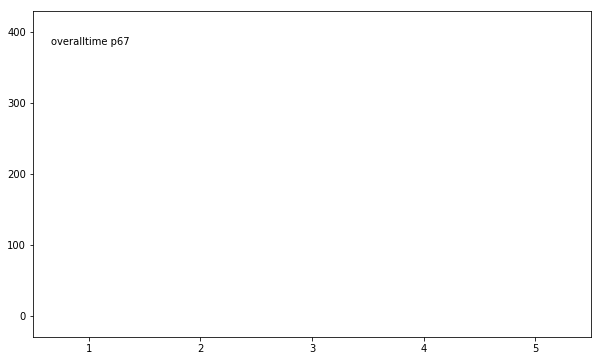

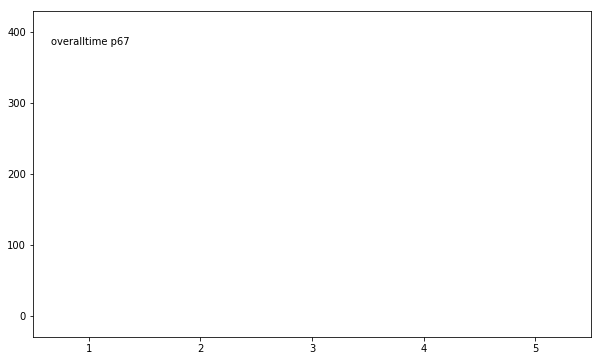

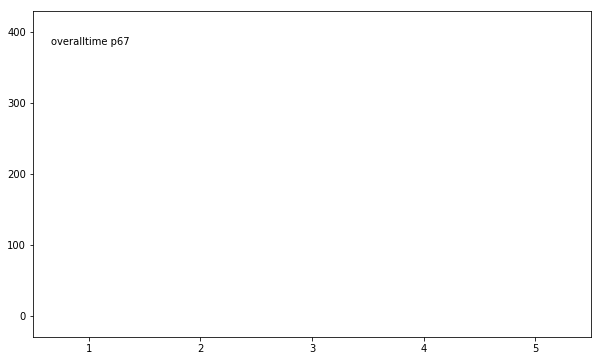

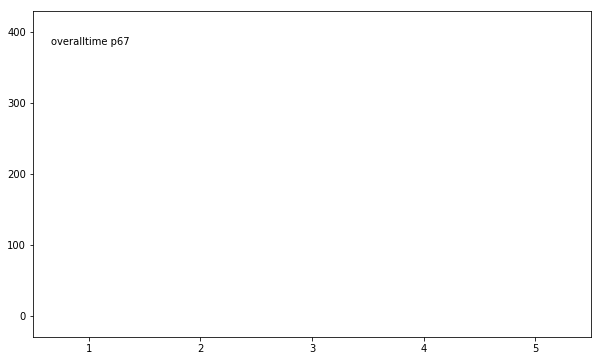

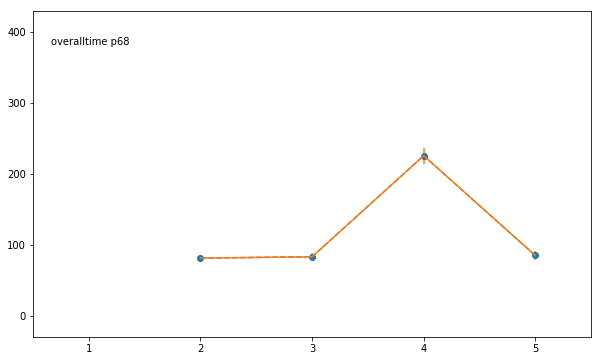

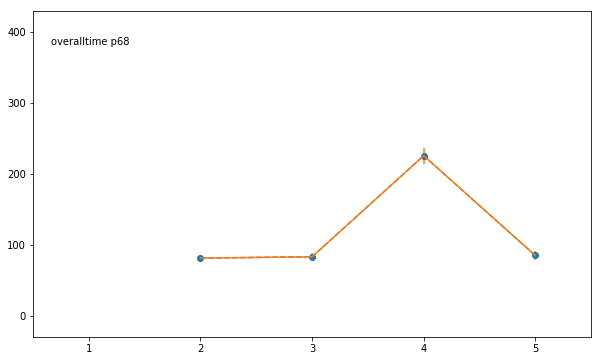

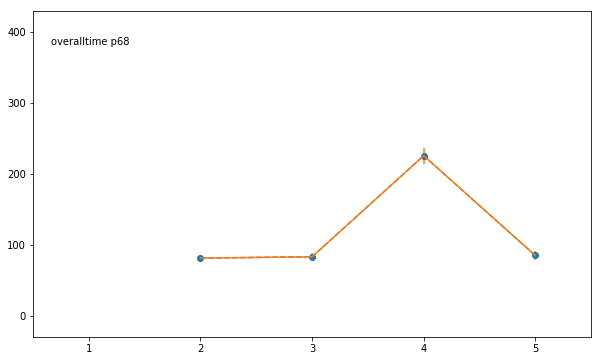

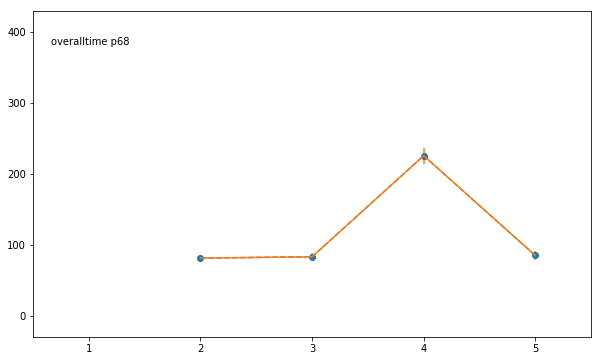

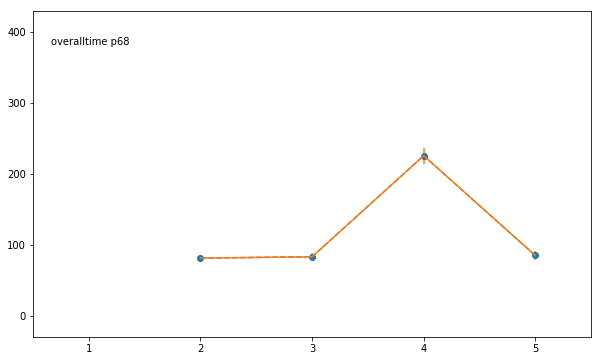

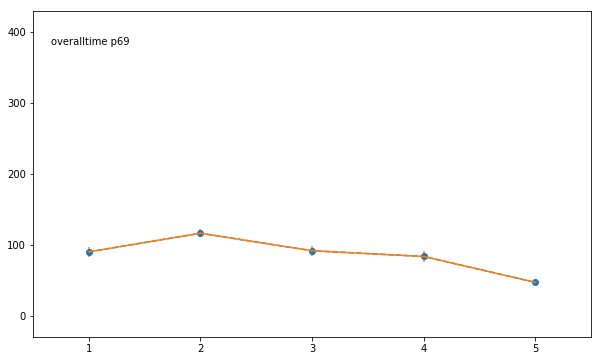

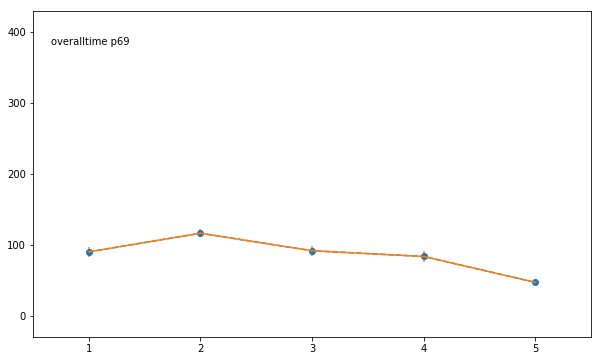

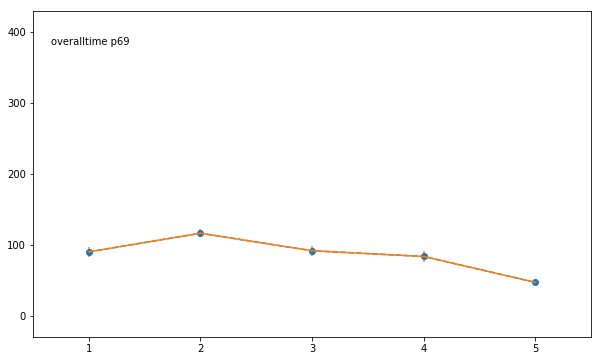

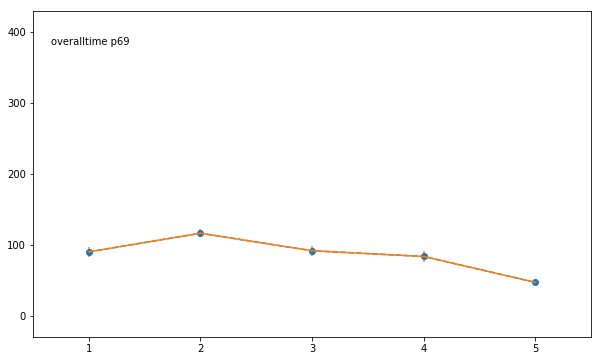

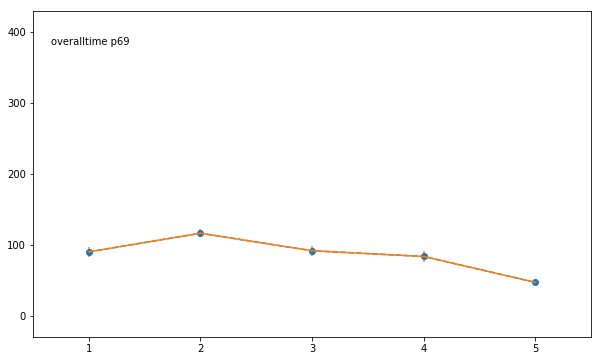

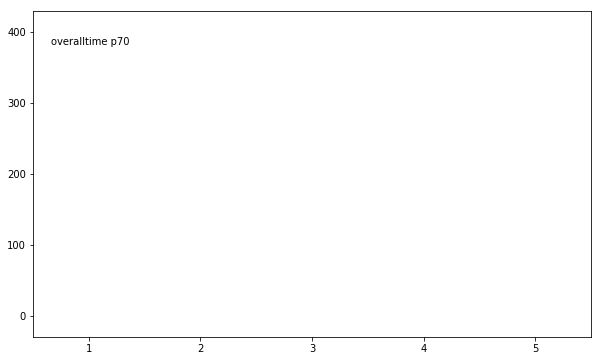

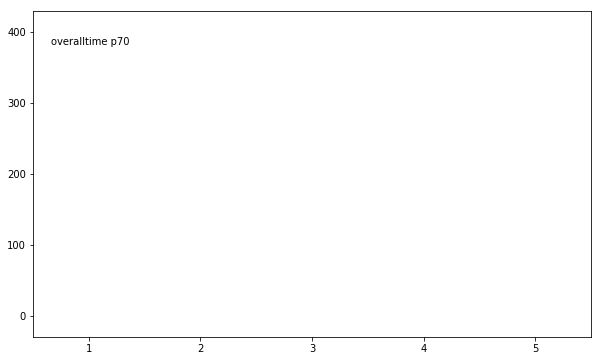

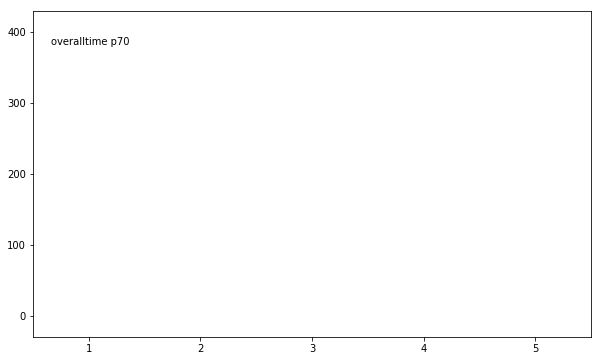

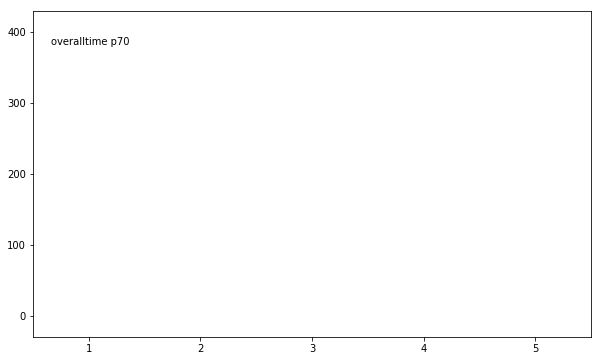

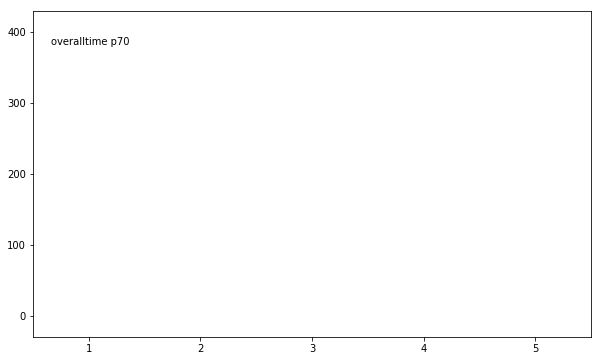

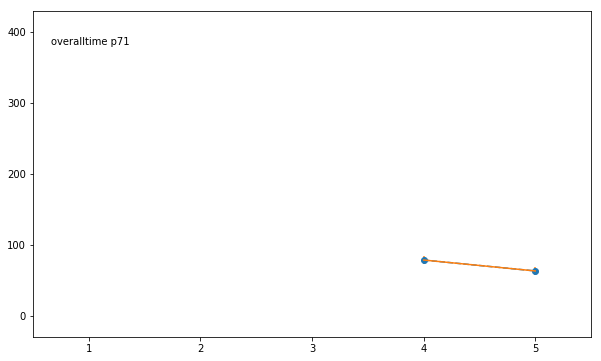

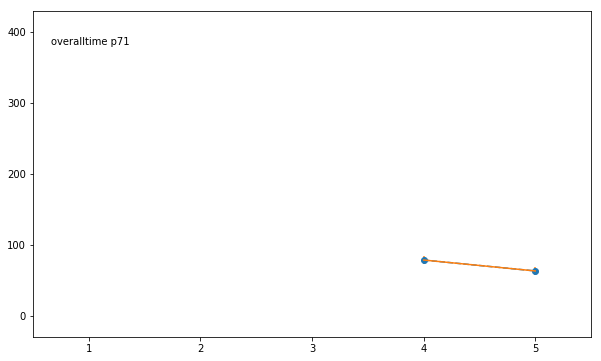

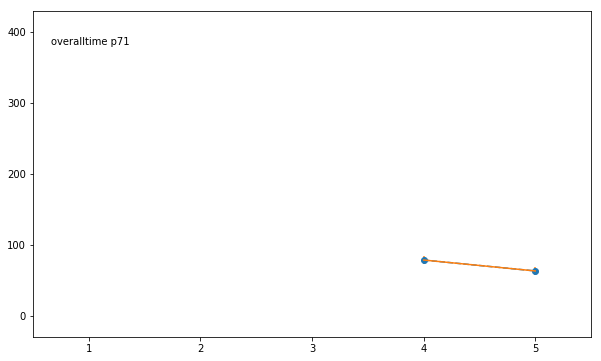

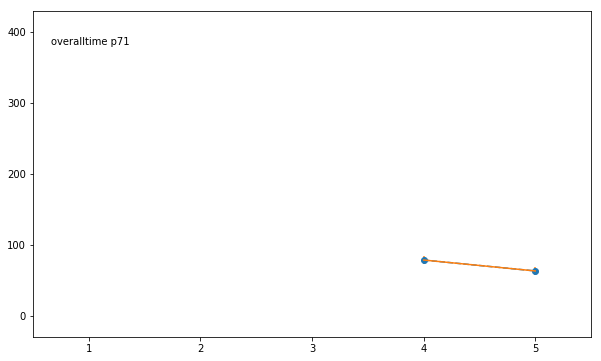

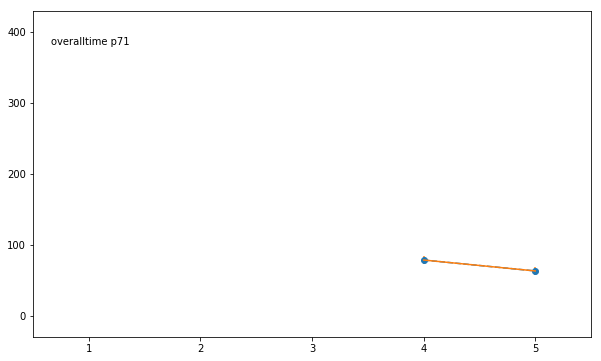

In [275]:
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/evaldataFigures/overalltime').mkdir(parents=True, exist_ok=True)

for participant in range(41, 72):
    for evaluation in range(1,6):
        x = evalSummary[(evalSummary.participant == participant)].evaluation
        y = evalSummary[(evalSummary.participant == participant)].overalltime_mean
        ye = evalSummary[(evalSummary.participant == participant)].overalltime_std/np.sqrt(evalSummary[(evalSummary.participant == participant)].overalltime_N)
        
        plt.subplots(figsize=(10, 6))
        plt.xlim(0.5,5.5)
        plt.ylim(-30,430)
        filestring = "/TrollLABS/robotExp/results/simulationResults/evaldataFigures/overalltime/p" + str(participant)
        plt.figtext(0.15, 0.8,"overalltime p" + str(participant), color='black', weight='roman')
        plt.plot(x,y,'o--')
        plt.errorbar(x, y, yerr=ye)
        plt.savefig(filestring, bbox_inches = "tight")

### 6. b) plotting averaged data (comparing test vs. plan)

histogramm on how the data is distributed (-> not normally)

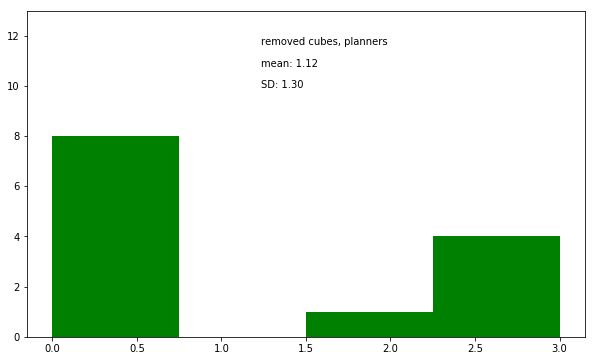

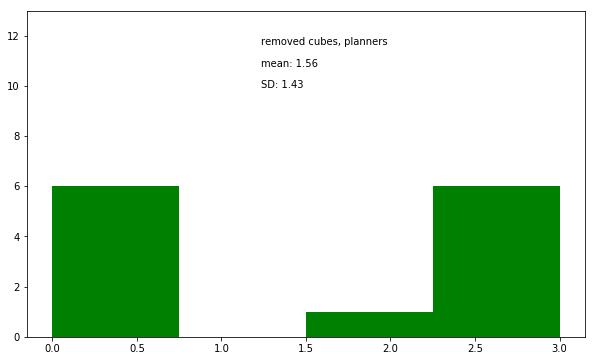

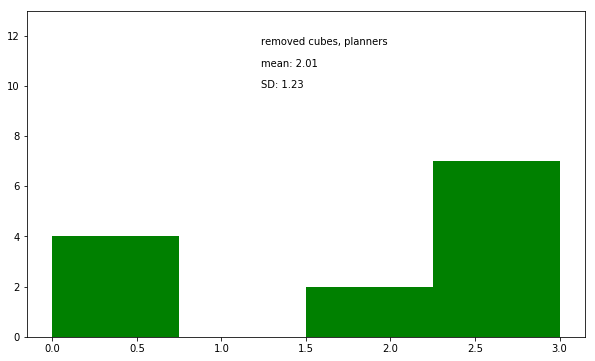

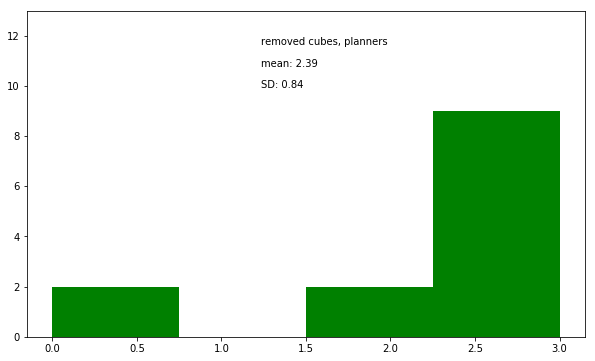

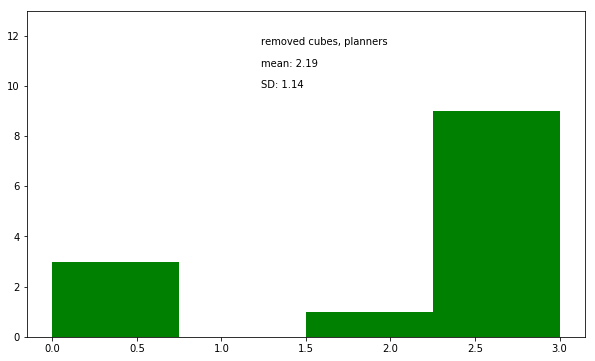

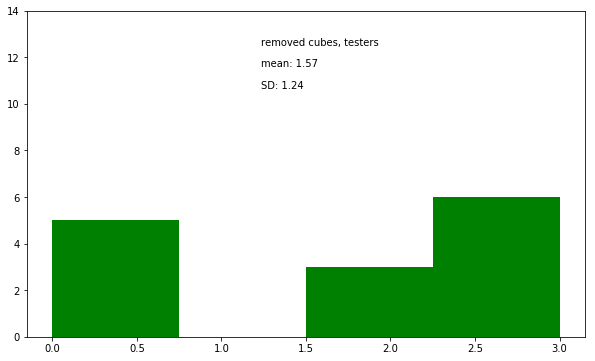

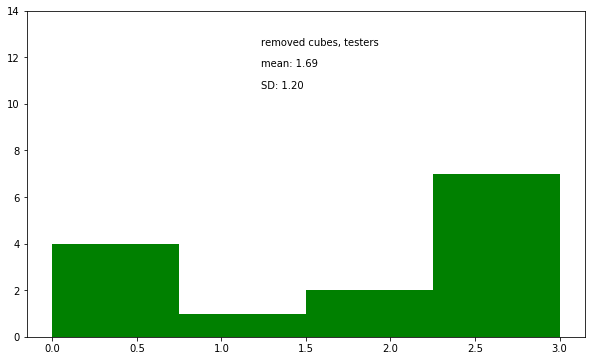

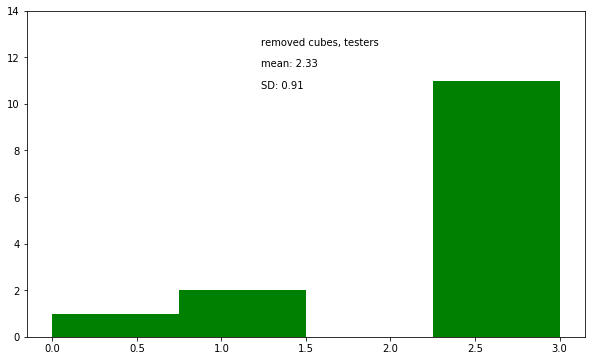

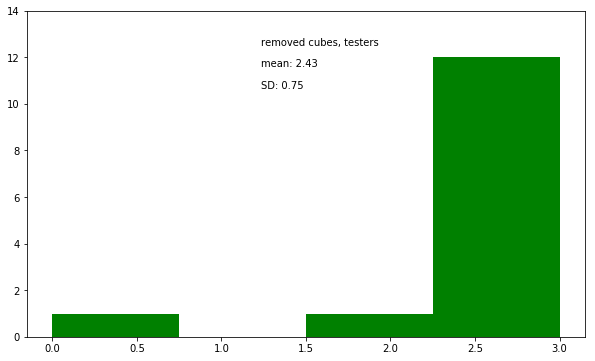

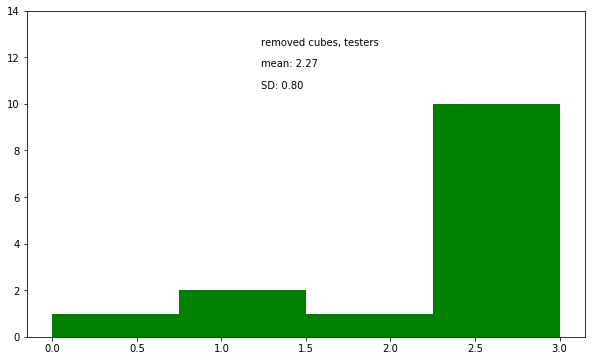

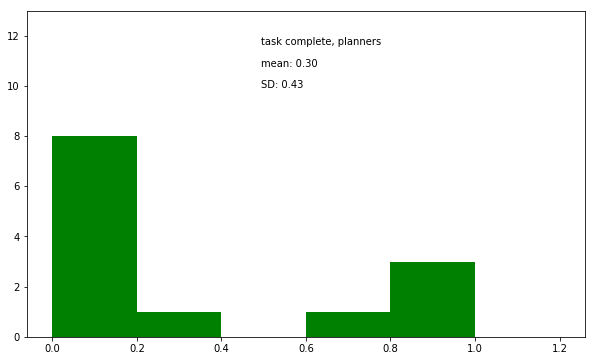

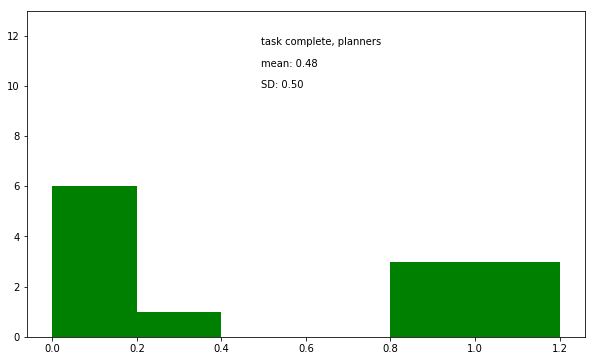

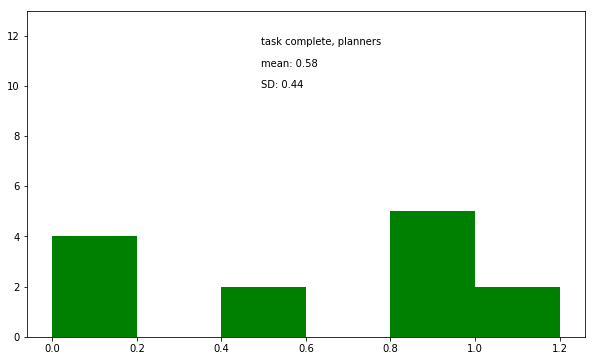

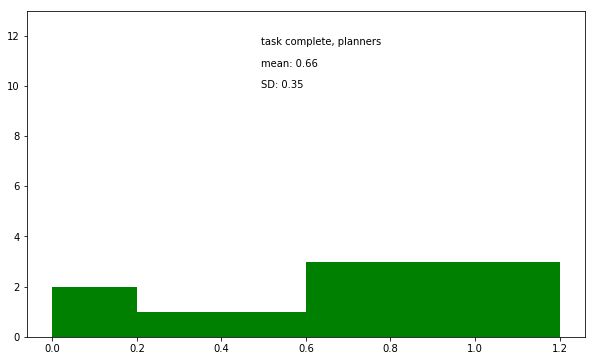

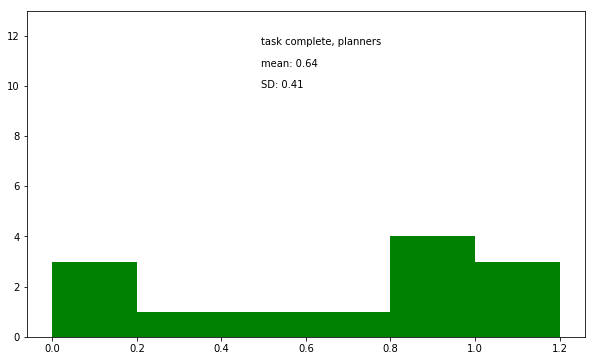

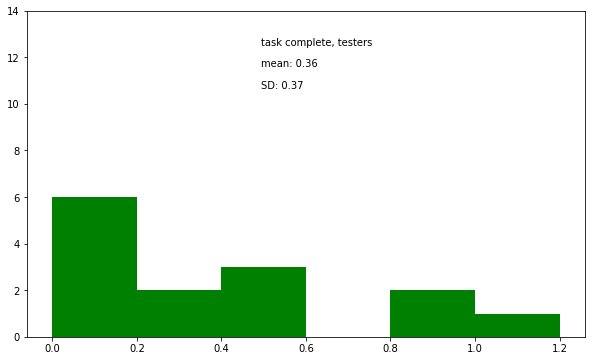

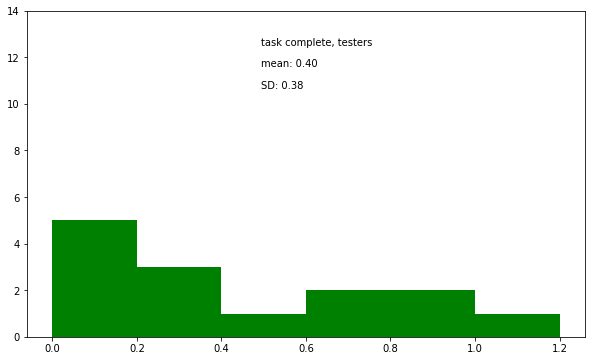

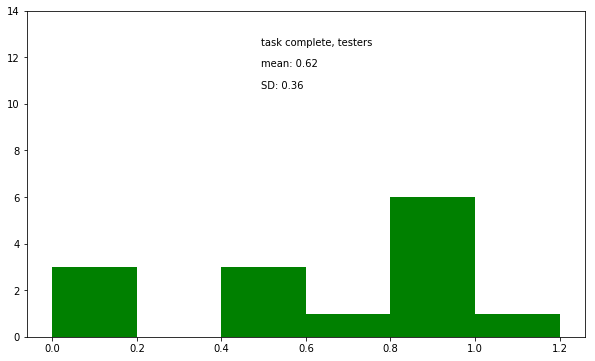

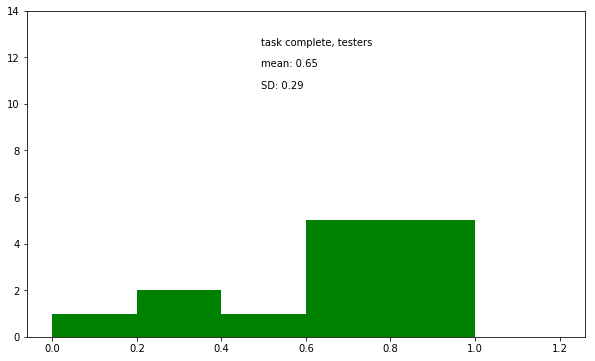

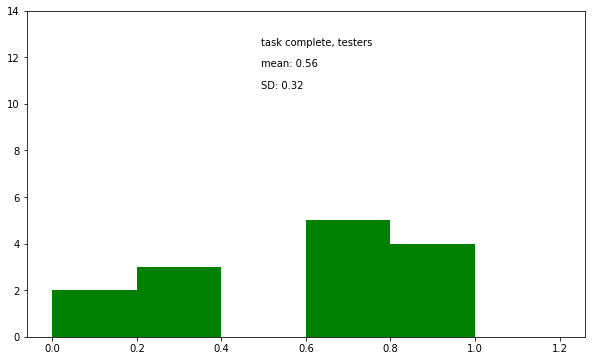

In [30]:
range_min = 0
range_max = 3.0
binwidth = 0.75

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/comparativeFigures/taskcomplete').mkdir(parents=True, exist_ok=True) 

for evaluation in range(1,6):
    plt.subplots(figsize=(10, 6))
    plt.ylim(0,13)
    data1 = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == evaluation)].removedcubes_mean
    string1 = str('mean: %.2f'%data1.mean())
    string2 = str('SD: %.2f'%data1.std())
    plt.figtext(0.45, 0.8,"removed cubes, planners", color='black', weight='roman')
    plt.figtext(0.45, 0.75,string1, color='black', weight='roman')
    plt.figtext(0.45, 0.70,string2, color='black', weight='roman')
    plt.hist(data1, bins=np.arange(range_min, range_max + binwidth, binwidth),color='green')
    filestring = "/TrollLABS/robotExp/results/simulationResults/comparativeFigures/removedcubes/plannereval" + str(evaluation)
    plt.savefig(filestring, bbox_inches = "tight")

for evaluation in range(1,6):
    plt.subplots(figsize=(10, 6))
    plt.ylim(0,14)
    data1 = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].removedcubes_mean
    string1 = str('mean: %.2f'%data1.mean())
    string2 = str('SD: %.2f'%data1.std())
    plt.figtext(0.45, 0.8,"removed cubes, testers", color='black', weight='roman')
    plt.figtext(0.45, 0.75,string1, color='black', weight='roman')
    plt.figtext(0.45, 0.70,string2, color='black', weight='roman')
    plt.hist(data1, bins=np.arange(range_min, range_max + binwidth, binwidth),color='green')
    filestring = "/TrollLABS/robotExp/results/simulationResults/comparativeFigures/removedcubes/testereval" + str(evaluation)
    plt.savefig(filestring, bbox_inches = "tight")
    
range_min = 0
range_max = 1.2
binwidth = 0.2    
    
for evaluation in range(1,6):
    plt.subplots(figsize=(10, 6))
    plt.ylim(0,13)
    data1 = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == evaluation)].taskcomplete_mean
    string1 = str('mean: %.2f'%data1.mean())
    string2 = str('SD: %.2f'%data1.std())
    plt.figtext(0.45, 0.8,"task complete, planners", color='black', weight='roman')
    plt.figtext(0.45, 0.75,string1, color='black', weight='roman')
    plt.figtext(0.45, 0.70,string2, color='black', weight='roman')
    plt.hist(data1, bins=np.arange(range_min, range_max + binwidth, binwidth),color='green')
    filestring = "/TrollLABS/robotExp/results/simulationResults/comparativeFigures/taskcomplete/plannereval" + str(evaluation)
    plt.savefig(filestring, bbox_inches = "tight")
    
for evaluation in range(1,6):
    plt.subplots(figsize=(10, 6))
    plt.ylim(0,14)
    data1 = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].taskcomplete_mean
    string1 = str('mean: %.2f'%data1.mean())
    string2 = str('SD: %.2f'%data1.std())
    plt.figtext(0.45, 0.8,"task complete, testers", color='black', weight='roman')
    plt.figtext(0.45, 0.75,string1, color='black', weight='roman')
    plt.figtext(0.45, 0.70,string2, color='black', weight='roman')
    plt.hist(data1, bins=np.arange(range_min, range_max + binwidth, binwidth),color='green')
    filestring = "/TrollLABS/robotExp/results/simulationResults/comparativeFigures/taskcomplete/testereval" + str(evaluation)
    plt.savefig(filestring, bbox_inches = "tight")
    
    
#for evaluation in range(1,6):
#       data1 = df[(df['participant'] == participant)&(df['evaluation'] == evaluation)&(df['taskcomplete'] == 1)].lastcube
#        plt.subplots(figsize=(10, 6))
#        plt.ylim(0,50)
#        filestring = "/TrollLABS/robotExp/results/simulationResults/rawdataFigures/lastcube/p" + str(participant) + "evaluation" + str(evaluation)
#        plt.figtext(0.7, 0.8,"lastcube p" + str(participant) + "evaluation" + str(evaluation) , color='black', weight='roman')
#        plt.hist(data1, bins=np.arange(range_min, range_max + binwidth, binwidth),color='green')
#        plt.savefig(filestring, bbox_inches = "tight")

plotting condition(plan/test) vs. performance in all evaluations

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


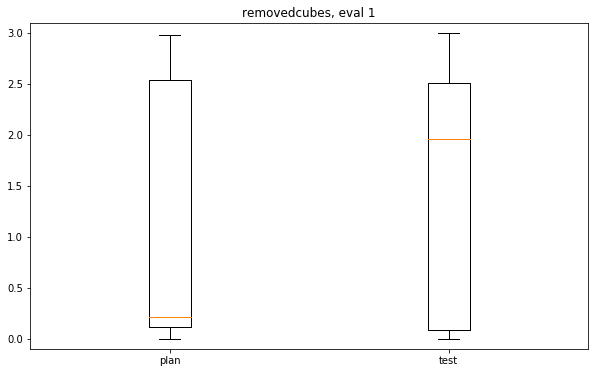

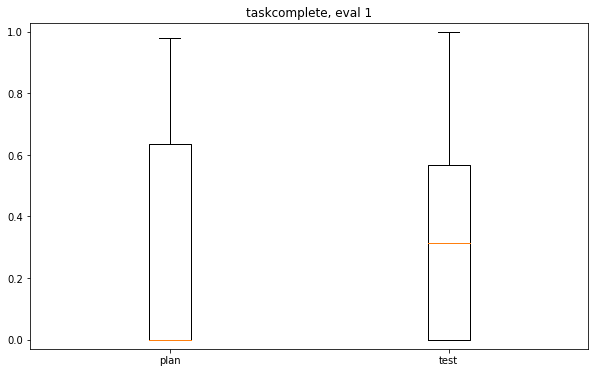

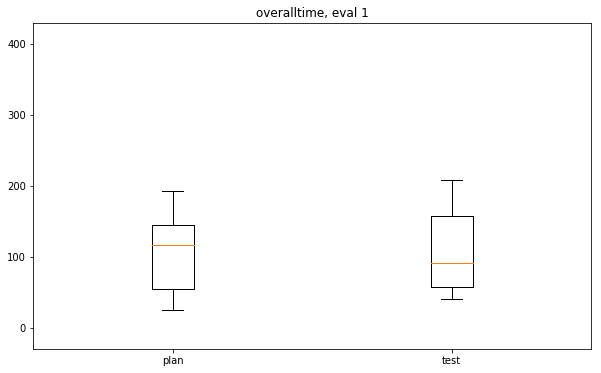

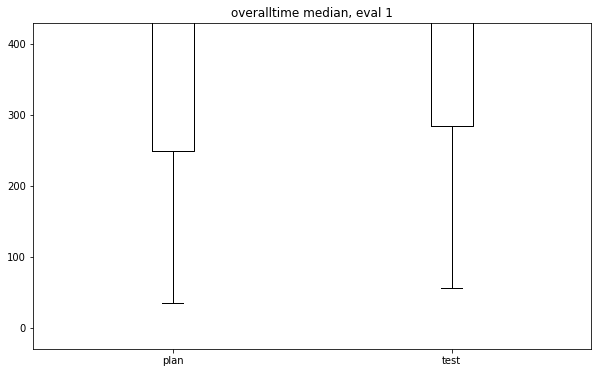

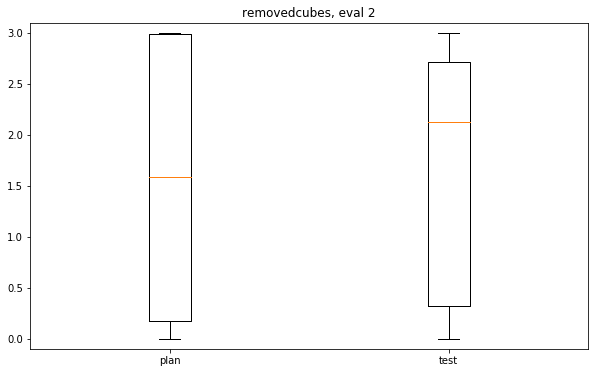

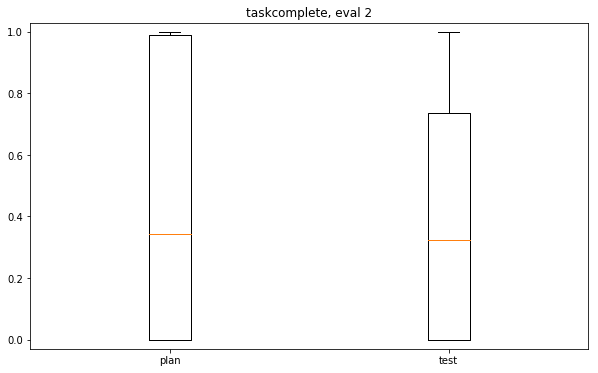

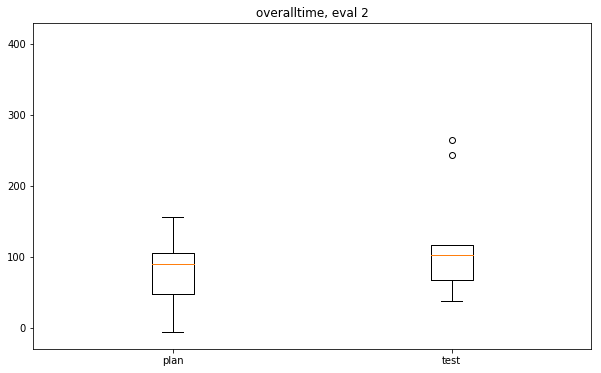

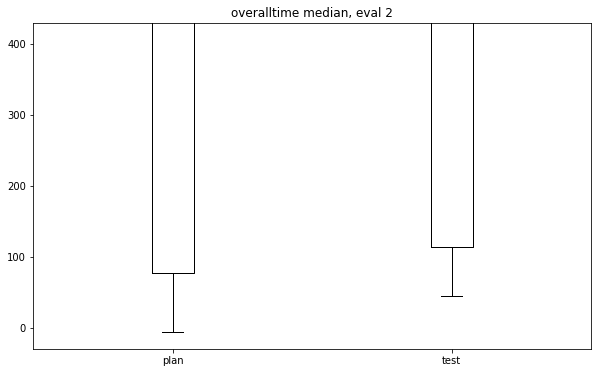

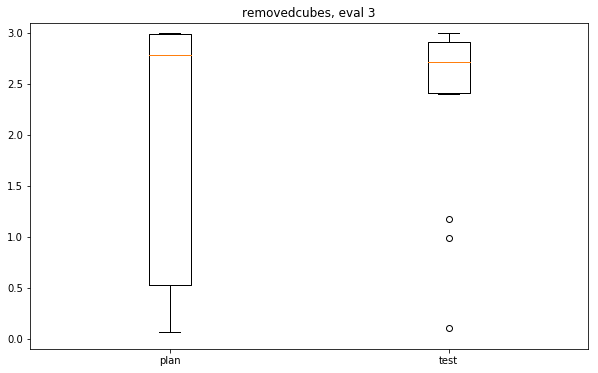

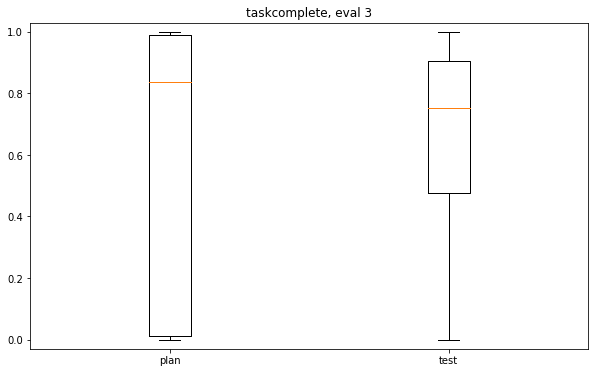

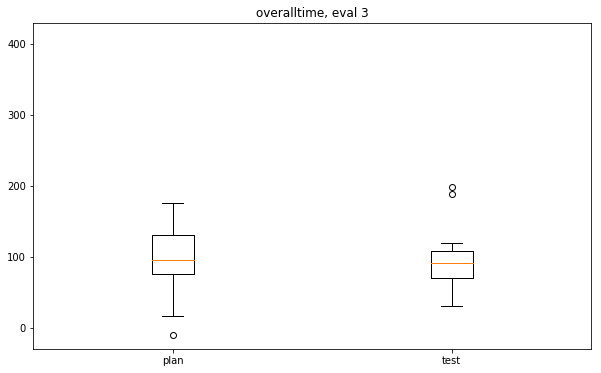

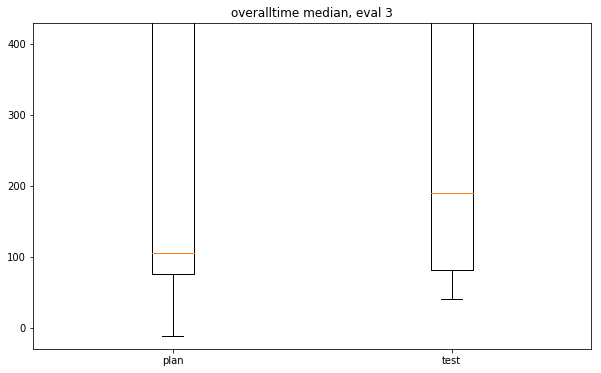

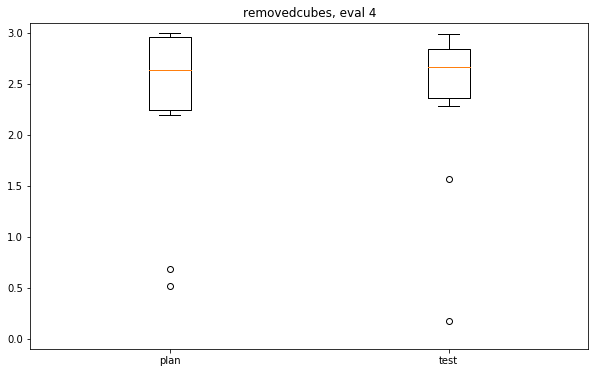

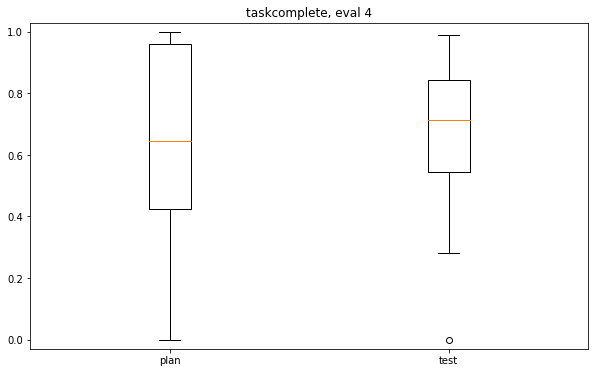

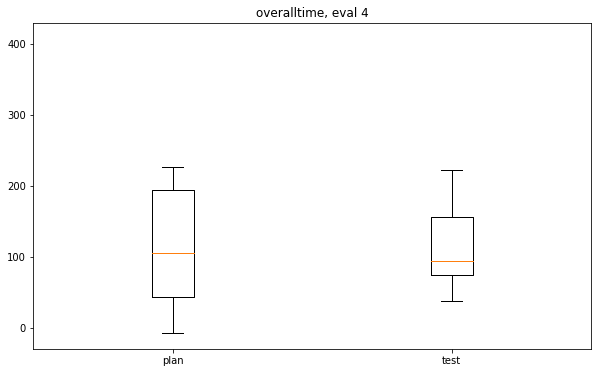

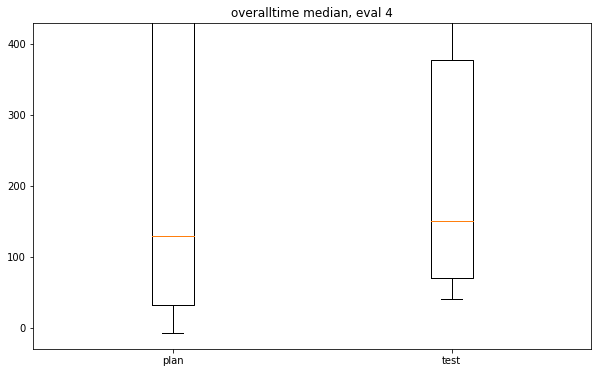

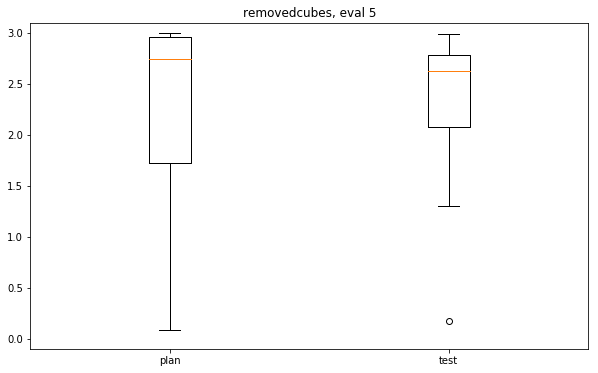

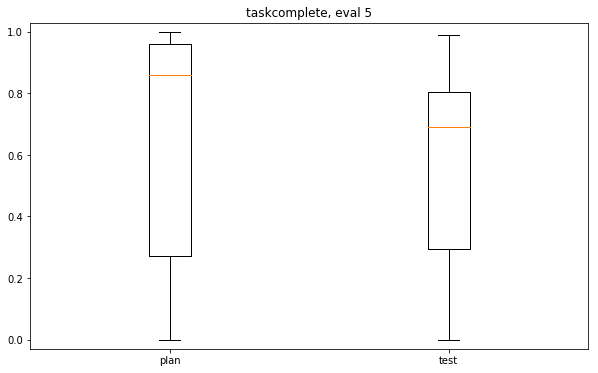

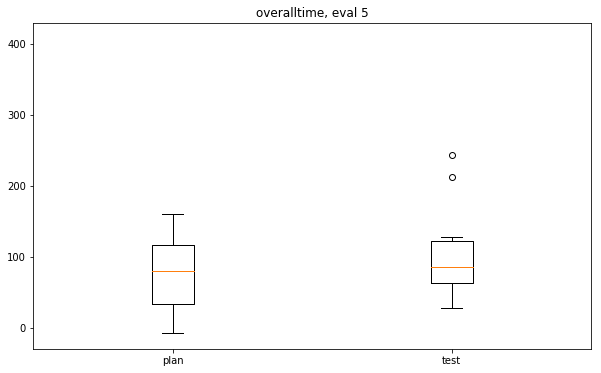

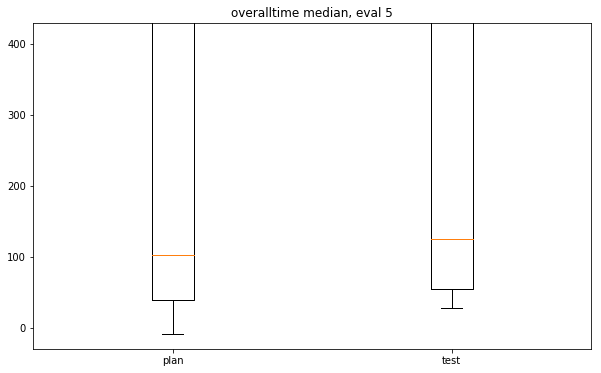

In [31]:
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/comparativeFigures/removedcubes').mkdir(parents=True, exist_ok=True)
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/comparativeFigures/taskcomplete').mkdir(parents=True, exist_ok=True)
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/comparativeFigures/overalltime').mkdir(parents=True, exist_ok=True)
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/comparativeFigures/overalltime_median').mkdir(parents=True, exist_ok=True)

for evaluation in range(1,6):
    data1 = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == evaluation)].removedcubes_mean
    data2 = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].removedcubes_mean
    data = [data1, data2]
    plt.subplots(figsize=(10, 6))
    plt.ylim(-0.1,3.1)
    labels = ['plan', 'test']
    filestring = "/TrollLABS/robotExp/results/simulationResults/comparativeFigures/removedcubes/eval" + str(evaluation)
    plt.title('removedcubes, eval ' + str(evaluation))
    plt.boxplot(data)
    plt.xticks([1,2], labels, rotation='horizontal')
    plt.savefig(filestring, bbox_inches = "tight")

    data1 = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == evaluation)].taskcomplete_mean
    data2 = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].taskcomplete_mean
    data = [data1, data2]
    plt.subplots(figsize=(10, 6))
    plt.ylim(-0.03,1.03)
    labels = ['plan', 'test']
    filestring = "/TrollLABS/robotExp/results/simulationResults/comparativeFigures/taskcomplete/eval" + str(evaluation)
    plt.title('taskcomplete, eval ' + str(evaluation))
    plt.boxplot(data)
    plt.xticks([1,2], labels, rotation='horizontal')
    plt.savefig(filestring, bbox_inches = "tight")
    
    data1 = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == evaluation)].overalltime_mean.dropna()
    data2 = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].overalltime_mean.dropna()
    data = [data1, data2]
    plt.subplots(figsize=(10, 6))
    plt.ylim(-30,430)
    labels = ['plan', 'test']
    filestring = "/TrollLABS/robotExp/results/simulationResults/comparativeFigures/overalltime/eval" + str(evaluation)
    plt.title('overalltime, eval ' + str(evaluation))
    plt.boxplot(data)
    plt.xticks([1,2], labels, rotation='horizontal')
    plt.savefig(filestring, bbox_inches = "tight")
    
    data1 = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == evaluation)].overalltime_median
    data2 = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].overalltime_median
    data = [data1, data2]
    plt.subplots(figsize=(10, 6))
    plt.ylim(-30,430)
    labels = ['plan', 'test']
    filestring = "/TrollLABS/robotExp/results/simulationResults/comparativeFigures/overalltime_median/eval" + str(evaluation)
    plt.title('overalltime median, eval ' + str(evaluation))
    plt.boxplot(data)
    plt.xticks([1,2], labels, rotation='horizontal')
    plt.savefig(filestring, bbox_inches = "tight")

Significance test plan vs test for removed cubes

In [34]:
evaluation = 5
data1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].removedcubes_mean
data2 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].removedcubes_mean
# compare samples
stat, p = mannwhitneyu(data1, data2)
print('MannWhitney test planners vs. testers in evaluation: %i'%(evaluation))
print('U = %i \t p = %.3f' % (stat, p))

MannWhitney test planners vs. testers in evaluation: 5
U = 70 	 p = 0.166


Significance tests for overalltime

In [35]:
for evaluation in range(1,6):
    data1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].overalltime_mean.dropna()
    data2 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].overalltime_mean.dropna()
    stat, p = stats.ttest_ind(data1, data2)
    print('evaluation: \t %i \t planners \t N = %i \t mean = %.1f \t sd = %.1f \t t = %.3f \t p = %.3f'%(evaluation, data1.shape[0],data1.mean(),data1.std(), stat, p))
    print('\t\t %i \t testers \t N = %i \t mean = %.1f \t sd = %.1f'%(evaluation, data2.shape[0],data2.mean(),data2.std()))
    print()


evaluation: 	 1 	 planners 	 N = 6 	 mean = 105.9 	 sd = 65.4 	 t = -0.094 	 p = 0.926
		 1 	 testers 	 N = 9 	 mean = 109.1 	 sd = 62.2

evaluation: 	 2 	 planners 	 N = 7 	 mean = 77.6 	 sd = 56.0 	 t = -1.142 	 p = 0.272
		 2 	 testers 	 N = 9 	 mean = 119.0 	 sd = 81.9

evaluation: 	 3 	 planners 	 N = 10 	 mean = 94.5 	 sd = 60.0 	 t = -0.111 	 p = 0.913
		 3 	 testers 	 N = 13 	 mean = 97.0 	 sd = 49.8

evaluation: 	 4 	 planners 	 N = 12 	 mean = 112.6 	 sd = 88.5 	 t = 0.004 	 p = 0.997
		 4 	 testers 	 N = 13 	 mean = 112.5 	 sd = 60.8

evaluation: 	 5 	 planners 	 N = 11 	 mean = 73.8 	 sd = 59.4 	 t = -1.041 	 p = 0.309
		 5 	 testers 	 N = 13 	 mean = 100.2 	 sd = 63.8



### 6. c) plotting averaged data (comparing search methods)

plotting test vs. plan seperated by search method

ultrasound:

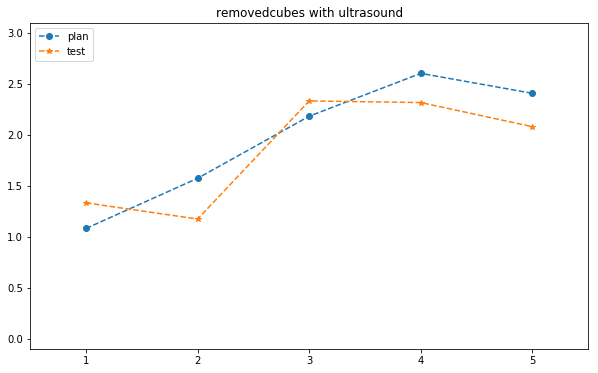

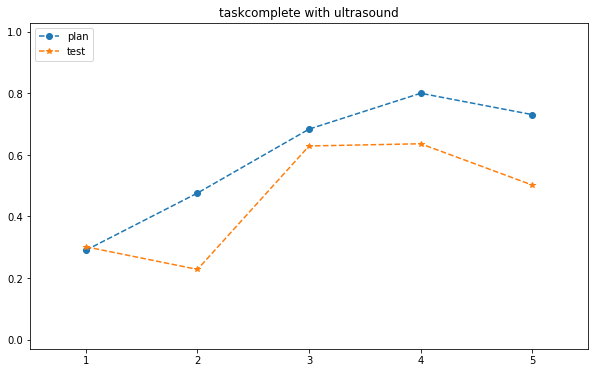

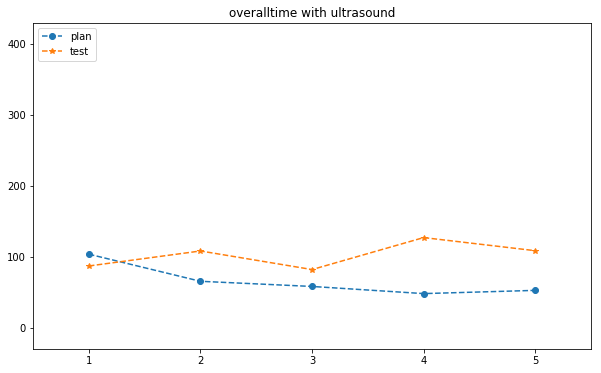

In [36]:
data1plan = [evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 1)].removedcubes_mean.mean()]
data2plan = [evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 1)].taskcomplete_mean.mean()]
data3plan = [evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 1)].overalltime_mean.mean()]
data1test = [evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 1)].removedcubes_mean.mean()]
data2test = [evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 1)].taskcomplete_mean.mean()]
data3test = [evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 1)].overalltime_mean.mean()]


for evaluation in range(2,6):
    data1plan = data1plan + [evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == evaluation)].removedcubes_mean.mean()]
    data2plan = data2plan + [evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == evaluation)].taskcomplete_mean.mean()]
    data3plan = data3plan + [evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == evaluation)].overalltime_mean.mean()]
    data1test = data1test + [evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == evaluation)].removedcubes_mean.mean()]
    data2test = data2test + [evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == evaluation)].taskcomplete_mean.mean()]
    data3test = data3test + [evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == evaluation)].overalltime_mean.mean()]

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes').mkdir(parents=True, exist_ok=True)
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/taskcomplete').mkdir(parents=True, exist_ok=True)
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/overalltime').mkdir(parents=True, exist_ok=True)

xaxis = [1,2,3,4,5]

plt.subplots(figsize=(10, 6))
plt.xlim(0.5,5.5)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/ultrasound"
plt.title("removedcubes with ultrasound")
plt.plot(xaxis,data1plan,'o--', label = 'plan')  
plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
plt.savefig(filestring, bbox_inches = "tight")

plt.subplots(figsize=(10, 6))
plt.xlim(0.5,5.5)
plt.ylim(-0.03,1.03)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/taskcomplete/ultrasound"
plt.title("taskcomplete with ultrasound")
plt.plot(xaxis,data2plan,'o--', label = 'plan')  
plt.plot(xaxis,data2test,'*--', label = 'test') 
plt.legend(loc = "upper left")
plt.savefig(filestring, bbox_inches = "tight")

plt.subplots(figsize=(10, 6))
plt.xlim(0.5,5.5)
plt.ylim(-30,430)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/overalltime/ultrasound"
plt.title("overalltime with ultrasound")
plt.plot(xaxis,data3plan,'o--', label = 'plan')  
plt.plot(xaxis,data3test,'*--', label = 'test') 
plt.legend(loc = "upper left")
plt.savefig(filestring, bbox_inches = "tight")

blink:

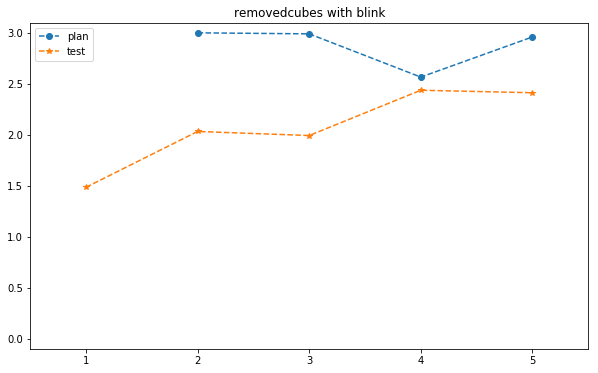

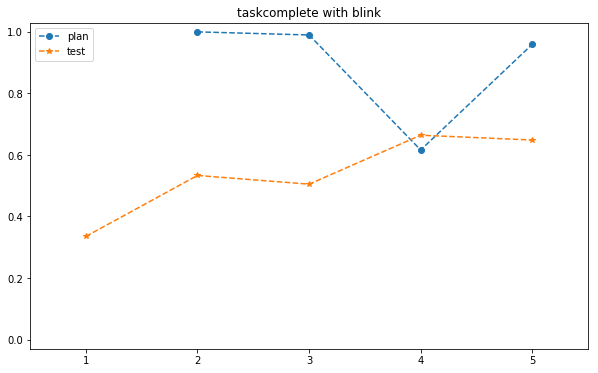

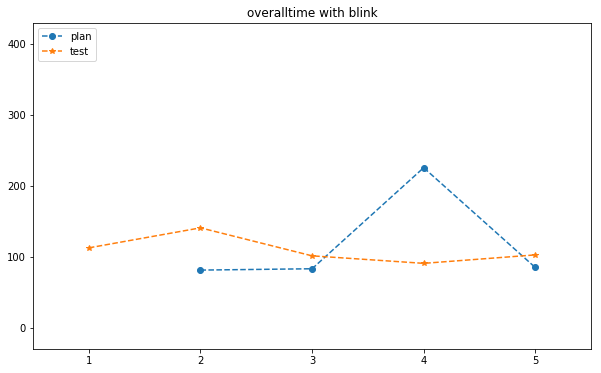

In [37]:
data1plan = [evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 0) & (evalSummary.evaluation == 1)].removedcubes_mean.mean()]
data2plan = [evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 0) & (evalSummary.evaluation == 1)].taskcomplete_mean.mean()]
data3plan = [evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 0) & (evalSummary.evaluation == 1)].overalltime_mean.mean()]
data1test = [evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 1) & (evalSummary.evaluation == 1)].removedcubes_mean.mean()]
data2test = [evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 1) & (evalSummary.evaluation == 1)].taskcomplete_mean.mean()]
data3test = [evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 1) & (evalSummary.evaluation == 1)].overalltime_mean.mean()]

for evaluation in range(2,6):
    data1plan = data1plan + [evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 0) & (evalSummary.evaluation == evaluation)].removedcubes_mean.mean()]
    data2plan = data2plan + [evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 0) & (evalSummary.evaluation == evaluation)].taskcomplete_mean.mean()]
    data3plan = data3plan + [evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 0) & (evalSummary.evaluation == evaluation)].overalltime_mean.mean()]
    data1test = data1test + [evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 1) & (evalSummary.evaluation == evaluation)].removedcubes_mean.mean()]
    data2test = data2test + [evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 1) & (evalSummary.evaluation == evaluation)].taskcomplete_mean.mean()]
    data3test = data3test + [evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 1) & (evalSummary.evaluation == evaluation)].overalltime_mean.mean()]

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes').mkdir(parents=True, exist_ok=True)
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/taskcomplete').mkdir(parents=True, exist_ok=True)
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/overalltime').mkdir(parents=True, exist_ok=True)

xaxis = [1,2,3,4,5]

plt.subplots(figsize=(10, 6))
plt.xlim(0.5,5.5)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/blink"
plt.title("removedcubes with blink")
plt.plot(xaxis,data1plan,'o--', label = 'plan')  
plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
plt.savefig(filestring, bbox_inches = "tight")

plt.subplots(figsize=(10, 6))
plt.xlim(0.5,5.5)
plt.ylim(-0.03,1.03)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/taskcomplete/blink"
plt.title("taskcomplete with blink")
plt.plot(xaxis,data2plan,'o--', label = 'plan')  
plt.plot(xaxis,data2test,'*--', label = 'test') 
plt.legend(loc = "upper left")
plt.savefig(filestring, bbox_inches = "tight")

plt.subplots(figsize=(10, 6))
plt.xlim(0.5,5.5)
plt.ylim(-30,430)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/overalltime/blink"
plt.title("overalltime with blink")
plt.plot(xaxis,data3plan,'o--', label = 'plan')  
plt.plot(xaxis,data3test,'*--', label = 'test') 
plt.legend(loc = "upper left")
plt.savefig(filestring, bbox_inches = "tight")

hybrid:

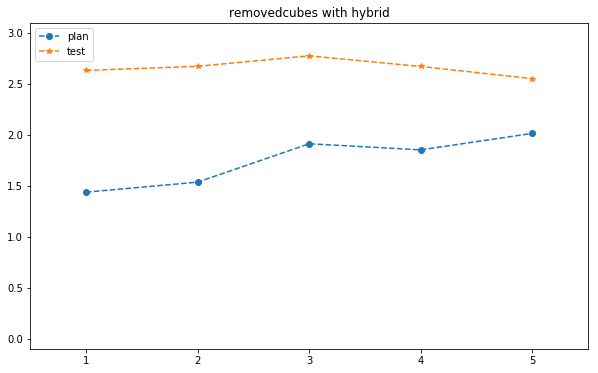

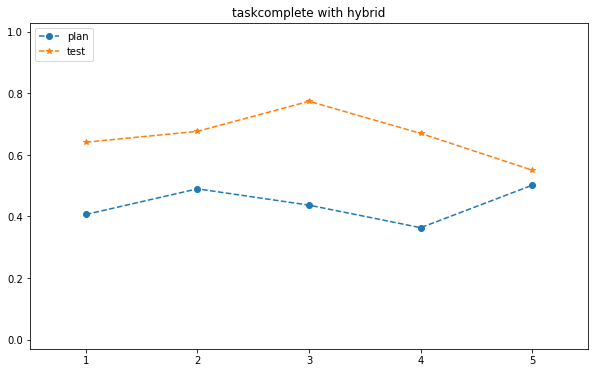

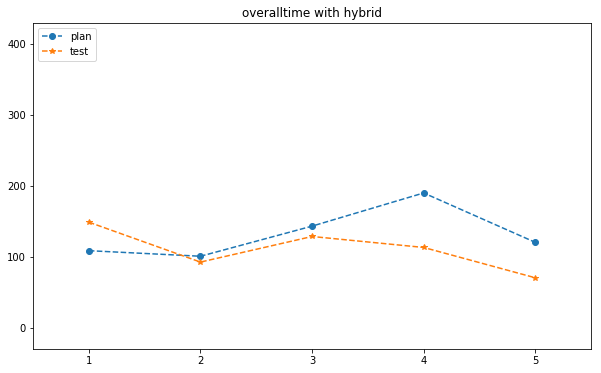

In [38]:
data1plan = [evalSummary[(evalSummary.searchmethod == 3) & (evalSummary.condition == 0) & (evalSummary.evaluation == 1)].removedcubes_mean.mean()]
data2plan = [evalSummary[(evalSummary.searchmethod == 3) & (evalSummary.condition == 0) & (evalSummary.evaluation == 1)].taskcomplete_mean.mean()]
data3plan = [evalSummary[(evalSummary.searchmethod == 3) & (evalSummary.condition == 0) & (evalSummary.evaluation == 1)].overalltime_mean.mean()]
data1test = [evalSummary[(evalSummary.searchmethod == 3) & (evalSummary.condition == 1) & (evalSummary.evaluation == 1)].removedcubes_mean.mean()]
data2test = [evalSummary[(evalSummary.searchmethod == 3) & (evalSummary.condition == 1) & (evalSummary.evaluation == 1)].taskcomplete_mean.mean()]
data3test = [evalSummary[(evalSummary.searchmethod == 3) & (evalSummary.condition == 1) & (evalSummary.evaluation == 1)].overalltime_mean.mean()]

for evaluation in range(2,6):
    data1plan = data1plan + [evalSummary[(evalSummary.searchmethod == 3) & (evalSummary.condition == 0) & (evalSummary.evaluation == evaluation)].removedcubes_mean.mean()]
    data2plan = data2plan + [evalSummary[(evalSummary.searchmethod == 3) & (evalSummary.condition == 0) & (evalSummary.evaluation == evaluation)].taskcomplete_mean.mean()]
    data3plan = data3plan + [evalSummary[(evalSummary.searchmethod == 3) & (evalSummary.condition == 0) & (evalSummary.evaluation == evaluation)].overalltime_mean.mean()]
    data1test = data1test + [evalSummary[(evalSummary.searchmethod == 3) & (evalSummary.condition == 1) & (evalSummary.evaluation == evaluation)].removedcubes_mean.mean()]
    data2test = data2test + [evalSummary[(evalSummary.searchmethod == 3) & (evalSummary.condition == 1) & (evalSummary.evaluation == evaluation)].taskcomplete_mean.mean()]
    data3test = data3test + [evalSummary[(evalSummary.searchmethod == 3) & (evalSummary.condition == 1) & (evalSummary.evaluation == evaluation)].overalltime_mean.mean()]

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes').mkdir(parents=True, exist_ok=True)
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/taskcomplete').mkdir(parents=True, exist_ok=True)
pathlib.Path('/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/overalltime').mkdir(parents=True, exist_ok=True)

xaxis = [1,2,3,4,5]

plt.subplots(figsize=(10, 6))
plt.xlim(0.5,5.5)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/hybrid"
plt.title("removedcubes with hybrid")
plt.plot(xaxis,data1plan,'o--', label = 'plan')  
plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
plt.savefig(filestring, bbox_inches = "tight")

plt.subplots(figsize=(10, 6))
plt.xlim(0.5,5.5)
plt.ylim(-0.03,1.03)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/taskcomplete/hybrid"
plt.title("taskcomplete with hybrid")
plt.plot(xaxis,data2plan,'o--', label = 'plan')  
plt.plot(xaxis,data2test,'*--', label = 'test') 
plt.legend(loc = "upper left")
plt.savefig(filestring, bbox_inches = "tight")

plt.subplots(figsize=(10, 6))
plt.xlim(0.5,5.5)
plt.ylim(-30,430)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/overalltime/hybrid"
plt.title("overalltime with hybrid")
plt.plot(xaxis,data3plan,'o--', label = 'plan')  
plt.plot(xaxis,data3test,'*--', label = 'test') 
plt.legend(loc = "upper left")
plt.savefig(filestring, bbox_inches = "tight")

double checking if the searchmethod selection went wrong, looks good though

In [ ]:
evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 0)].searchmethod

removed cubes with ultrasound as boxplot

In [ ]:
eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 1)].removedcubes_mean
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 2)].removedcubes_mean
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 3)].removedcubes_mean
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 4)].removedcubes_mean
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 5)].removedcubes_mean
dataplan = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 1)].removedcubes_mean
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 2)].removedcubes_mean
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 3)].removedcubes_mean
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 4)].removedcubes_mean
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 5)].removedcubes_mean
datatest = [eval1, eval2, eval3, eval4, eval5]    

data = dataplan + datatest

plt.subplots(figsize=(10, 6))
plt.ylim(-0.1,3.1)
#labels = ['plan', 'test']
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/ultrasoundbox"
plt.title('removedcubes with ultrasound, planning')
plt.boxplot(dataplan)
plt.savefig(filestring, bbox_inches = "tight")

plt.subplots(figsize=(10, 6))
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/ultrasoundbox"
plt.title('removedcubes with ultrasound, testing')
plt.boxplot(datatest)
plt.savefig(filestring, bbox_inches = "tight")

removed cubes with blink as boxplot

In [ ]:
eval1 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 0) & (evalSummary.evaluation == 1)].removedcubes_mean
eval2 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 0) & (evalSummary.evaluation == 2)].removedcubes_mean
eval3 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 0) & (evalSummary.evaluation == 3)].removedcubes_mean
eval4 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 0) & (evalSummary.evaluation == 4)].removedcubes_mean
eval5 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 0) & (evalSummary.evaluation == 5)].removedcubes_mean
dataplan = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 1) & (evalSummary.evaluation == 1)].removedcubes_mean
eval2 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 1) & (evalSummary.evaluation == 2)].removedcubes_mean
eval3 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 1) & (evalSummary.evaluation == 3)].removedcubes_mean
eval4 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 1) & (evalSummary.evaluation == 4)].removedcubes_mean
eval5 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.condition == 1) & (evalSummary.evaluation == 5)].removedcubes_mean
datatest = [eval1, eval2, eval3, eval4, eval5]    

data = dataplan + datatest

plt.subplots(figsize=(10, 6))
plt.ylim(-0.1,3.1)
#labels = ['plan', 'test']
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/blinkbox"
plt.title('removedcubes with blink, planning')
plt.boxplot(dataplan)
plt.savefig(filestring, bbox_inches = "tight")

plt.subplots(figsize=(10, 6))
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/blinkbox"
plt.title('removedcubes with blink, testing')
plt.boxplot(datatest)
plt.savefig(filestring, bbox_inches = "tight")

taskcomplete with ultrasound as boxplot

In [ ]:
eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 1)].taskcomplete_mean
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 2)].taskcomplete_mean
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 3)].taskcomplete_mean
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 4)].taskcomplete_mean
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == 5)].taskcomplete_mean
dataplan = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 1)].taskcomplete_mean
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 2)].taskcomplete_mean
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 3)].taskcomplete_mean
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 4)].taskcomplete_mean
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 5)].taskcomplete_mean
datatest = [eval1, eval2, eval3, eval4, eval5]    

data = dataplan + datatest

plt.subplots(figsize=(10, 6))
plt.ylim(-0.03,1.03)
#labels = ['plan', 'test']
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/taskcomplete/ultrasoundbox"
plt.title('taskcomplete with ultrasound, planning')
plt.boxplot(dataplan)
plt.savefig(filestring, bbox_inches = "tight")

plt.subplots(figsize=(10, 6))
plt.ylim(-0.03,1.03)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/taskcomplete/ultrasoundbox"
plt.title('taskcomplete with ultrasound, testing')
plt.boxplot(datatest)
plt.savefig(filestring, bbox_inches = "tight")

In [ ]:
evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 2)].taskcomplete_mean.mean()

In [ ]:
evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == 2)].taskcomplete_mean.median()

!!! INCONSISTENT PLOTS !!!

comparing the mean values reveals that the orange line does not represent the mean (see in evaluation 2 for example)

--> solution: The orange line is the MEDIAN and with so many data points and in this case this is very different from mean value

What works better: ultrasound or blink?

In [ ]:
eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1)].removedcubes_mean
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2)].removedcubes_mean
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3)].removedcubes_mean
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)].removedcubes_mean
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)].removedcubes_mean

data1 = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 1)].removedcubes_mean
eval2 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 2)].removedcubes_mean
eval3 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 3)].removedcubes_mean
eval4 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 4)].removedcubes_mean
eval5 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 5)].removedcubes_mean

data2 = [eval1, eval2, eval3, eval4, eval5]

plt.subplots(figsize=(10, 6))
plt.ylim(-0.03,3.03)
#labels = ['plan', 'test']
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/ultrasoundboxbeta"
plt.title('removed cubes with ultrasound')
plt.boxplot(data1)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()

plt.subplots(figsize=(10, 6))
plt.ylim(-0.03,3.03)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/blinkboxbeta"
plt.title('removed cubes with blink')
plt.boxplot(data2)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()

In [ ]:
eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()

data1 = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 2) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 3) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 4) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 5) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()

data2 = [eval1, eval2, eval3, eval4, eval5]

plt.subplots(figsize=(10, 6))
plt.ylim(-30,430)
#labels = ['plan', 'test']
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/overalltime/ultrasoundboxbeta"
plt.title('overalltime for ultrasound')
plt.boxplot(data1)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()
plt.subplots(figsize=(10, 6))
plt.ylim(-30,430)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/overalltime/blinkboxbeta"
plt.title('overalltime for blink')
plt.boxplot(data2)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()




eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()

data1 = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()

data2 = [eval1, eval2, eval3, eval4, eval5]

plt.subplots(figsize=(10, 6))
plt.ylim(-30,430)
#labels = ['plan', 'test']
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/overalltime/ultrasoundboxbeta_planners"
plt.title('overalltime for ultrasound planners')
plt.boxplot(data1)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()
plt.subplots(figsize=(10, 6))
plt.ylim(-30,430)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/overalltime/ultrasoundboxbeta_testers"
plt.title('overalltime for ultrasound testers')
plt.boxplot(data2)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()

In [ ]:
eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()

data1 = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 2) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 3) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 4) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 5) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()

data2 = [eval1, eval2, eval3, eval4, eval5]

plt.subplots(figsize=(10, 6))
plt.ylim(-30,430)
#labels = ['plan', 'test']
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/lastcube/ultrabox"
plt.title('lastcube time for ultrasound')
plt.boxplot(data1)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()
plt.subplots(figsize=(10, 6))
plt.ylim(-30,430)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/lastcube/blinkbox"
plt.title('lastcube time for blink')
plt.boxplot(data2)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()




eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()

data1 = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()

data2 = [eval1, eval2, eval3, eval4, eval5]

plt.subplots(figsize=(10, 6))
plt.ylim(-30,430)
#labels = ['plan', 'test']
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/lastcube/ultrabox_planners"
plt.title('lastcube time for ultrasound planners')
plt.boxplot(data1)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()
plt.subplots(figsize=(10, 6))
plt.ylim(-30,430)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/lastcube/ultrabox_testers"
plt.title('lastcube time for ultrasound testers')
plt.boxplot(data2)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()

In [ ]:
eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()

data1 = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 1) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 2) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 3) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 4) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 5) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()

data2 = [eval1, eval2, eval3, eval4, eval5]

plt.subplots(figsize=(10, 6))
plt.ylim(0,20000)
#labels = ['plan', 'test']
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/distance/ultrabox"
plt.title('distance driven for ultrasound')
plt.boxplot(data1)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()
plt.subplots(figsize=(10, 6))
plt.ylim(0,20000)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/distance/blinkbox"
plt.title('distance for blink')
plt.boxplot(data2)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()




eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()

data1 = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()

data2 = [eval1, eval2, eval3, eval4, eval5]

plt.subplots(figsize=(10, 6))
plt.ylim(0,20000)
#labels = ['plan', 'test']
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/distance/ultrabox_planners"
plt.title('distance driven for ultrasound planners')
plt.boxplot(data1)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()
plt.subplots(figsize=(10, 6))
plt.ylim(0,20000)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/distance/ultrabox_testers"
plt.title('distance driven for ultrasound testers')
plt.boxplot(data2)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()

In [ ]:
eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()

data1 = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 2) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 3) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 4) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 5) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()

data2 = [eval1, eval2, eval3, eval4, eval5]

plt.subplots(figsize=(10, 6))
plt.ylim(0,50)
#labels = ['plan', 'test']
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/edgetouches/ultrabox"
plt.title('edgetouches for ultrasound')
plt.boxplot(data1)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()
plt.subplots(figsize=(10, 6))
plt.ylim(0,50)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/edgetouches/blinkbox"
plt.title('edgetouches for blink')
plt.boxplot(data2)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()




eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()

data1 = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()

data2 = [eval1, eval2, eval3, eval4, eval5]

plt.subplots(figsize=(10, 6))
plt.ylim(0,50)
#labels = ['plan', 'test']
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/edgetouches/ultrabox_planners"
plt.title('edgetouches for ultrasound planners')
plt.boxplot(data1)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()
plt.subplots(figsize=(10, 6))
plt.ylim(0,50)
filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/edgetouches/ultrabox_testers"
plt.title('edgetouches for ultrasound testers')
plt.boxplot(data2)
plt.savefig(filestring, bbox_inches = "tight")
plt.show()

In [ ]:
eval1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 1)].overalltime_mean.mean()
eval2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 2)].overalltime_mean.mean()
eval3 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 3)].overalltime_mean.mean()
eval4 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)].overalltime_mean.mean()
eval5 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)].overalltime_mean.mean()

data1 = [eval1, eval2, eval3, eval4, eval5]

eval1 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 1)].overalltime_mean.mean()
eval2 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 2)].overalltime_mean.mean()
eval3 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 3)].overalltime_mean.mean()
eval4 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 4)].overalltime_mean.mean()
eval5 = evalSummary[(evalSummary.searchmethod == 2) & (evalSummary.evaluation == 5)].overalltime_mean.mean()

data2 = [eval1, eval2, eval3, eval4, eval5]

print(data1)
print(data2)

In [ ]:
print(sum(data1)/5)
print(sum(data2)/5)

### 6. d) plotting averaged data (influence of testing)

In [39]:
print('mean number of tests until eval 1: \t %.1f' % evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].tests.mean())
print('std  number of tests until eval 1: \t %.1f' % evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].tests.std())

mean number of tests until eval 1: 	 26.9
std  number of tests until eval 1: 	 8.2


In [40]:
totalPlan5 = 0
totalTest5 = 0
for evaluation in range(1,6):
    totalPlan5 += evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].tests.values
    totalTest5 += evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.values

print('mean of total number of tests until eval 5 (planners): \t %.1f' % totalPlan5.mean())
print('mean of total number of tests until eval 5 (testers): \t %.1f' % totalTest5.mean())
print('std of total number of tests until eval 5 (planners): \t %.1f' % totalPlan5.std())
print('std of total number of tests until eval 5 (testers): \t %.1f' % totalTest5.std())

print()

totalPlan5 = 0
totalTest5 = 0
for evaluation in range(2,6):
    totalPlan5 += evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].tests.values
    totalTest5 += evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.values

print('mean of number of tests between eval 1 and eval 5 (planners): \t %.1f' % totalPlan5.mean())
print('mean of number of tests between eval 1 and eval 5 (testers): \t %.1f' % totalTest5.mean())
print('std of number of tests between eval 1 and eval 5 (planners): \t %.1f' % totalPlan5.std())
print('std of number of tests between eval 1 and eval 5 (testers): \t %.1f' % totalTest5.std())

stat, p = stats.ttest_ind(totalPlan5,totalTest5)
print('t-test \t t = %.3f \t p = %.3f'%(stat,p))
print('N plan = %i \t N test = %i' %(totalPlan5.shape[0],totalTest5.shape[0]))

mean of total number of tests until eval 5 (planners): 	 10.8
mean of total number of tests until eval 5 (testers): 	 39.3
std of total number of tests until eval 5 (planners): 	 4.7
std of total number of tests until eval 5 (testers): 	 11.3

mean of number of tests between eval 1 and eval 5 (planners): 	 10.8
mean of number of tests between eval 1 and eval 5 (testers): 	 12.1
std of number of tests between eval 1 and eval 5 (planners): 	 4.7
std of number of tests between eval 1 and eval 5 (testers): 	 4.4
t-test 	 t = -0.667 	 p = 0.511
N plan = 13 	 N test = 13


In [ ]:
x0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].tests.values
y0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean
x1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].tests.values
y1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-1,80)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/totaleval1"
plt.xlabel('tests until eval 1')
plt.ylabel('removed cubes at eval 1')
plt.title("influence of testing until eval 1")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].tests.values + evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].tests.values
y0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean
x1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].tests.values + evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].tests.values
y1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,80)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/totaleval2"
plt.xlabel('tests until eval 2')
plt.ylabel('removed cubes at eval 2')
plt.title("tests until eval 2")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].tests.values + evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].tests.values + evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].tests.values
y0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean
x1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].tests.values + evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].tests.values + evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].tests.values
y1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,80)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/totaleval3"
plt.xlabel('tests until eval 3')
plt.ylabel('removed cubes at eval 3')
plt.title("tests until eval 3")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].tests.values + evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].tests.values + evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].tests.values + evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].tests.values
y0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean
x1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].tests.values + evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].tests.values + evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].tests.values + evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].tests.values
y1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,80)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/totaleval4"
plt.xlabel('tests until eval 4')
plt.ylabel('removed cubes  at eval 4')
plt.title("tests until eval 4")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].tests.values + evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].tests.values + evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].tests.values + evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].tests.values + evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].tests.values
y0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_mean
x1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].tests.values + evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].tests.values + evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].tests.values + evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].tests.values + evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].tests.values
y1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_mean

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,80)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/totaleval5"
plt.xlabel('tests until eval 5')
plt.ylabel('removed cubes at eval5')
plt.title("tests until eval 5")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")

removed cube performance vs. testing between evaluations (this plot is pointless, isn't it?)

In [ ]:
x0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean
x1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-1,50)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/eval1"
plt.xlabel('tests until eval 1')
plt.ylabel('removed cubes at eval 1')
plt.title("influence of testing until eval 1")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,8)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/eval2"
plt.xlabel('tests between eval 1 and 2')
plt.ylabel('removed cubes at eval 2')
plt.title("tests between eval 1 and 2")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,8)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/eval3"
plt.xlabel('tests between eval 2 and 3')
plt.ylabel('removed cubes at eval 3')
plt.title("tests between eval 2 and 3")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,8)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/eval4"
plt.xlabel('tests between eval 3 and 4')
plt.ylabel('removed cubes at eval 4')
plt.title("tests between eval 3 and 4")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,8)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/eval5"
plt.xlabel('tests between eval 4 and 5')
plt.ylabel('removed cubes at eval 5')
plt.title("tests between eval 4 and 5")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")



change in removed cube performance vs. testing

In [ ]:
x0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean
x1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-1,50)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/eval_0to1"
plt.xlabel('tests until eval 1')
plt.ylabel('removed cubes at eval 1')
plt.title("influence of testing until eval 1")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,8)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/eval_1to2"
plt.xlabel('tests between eval 1 and 2')
plt.ylabel('change in removed cubes  between eval 1 and 2')
plt.title("tests between eval 1 and 2")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,8)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/eval_2to3"
plt.xlabel('tests between eval 2 and 3')
plt.ylabel('change in removed cubes  between eval 2 and 3')
plt.title("tests between eval 2 and 3")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,8)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/eval_3to4"
plt.xlabel('tests between eval 3 and 4')
plt.ylabel('change in removed cubes  between eval 3 and 4')
plt.title("tests between eval 3 and 4")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,8)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/eval_4to5"
plt.xlabel('tests between eval 4 and 5')
plt.ylabel('change in removed cubes  between eval 4 and 5')
plt.title("tests between eval 4 and 5")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")

### 6. e) influence of keystrokes between evaluations on removed cubes

change in removed cube performance vs. keystrokes

In [ ]:
x0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].keystrokes
y0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean
x1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].keystrokes
y1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-1,5000)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/deltaeval_0to1"
plt.xlabel('keystrokes until eval 1')
plt.ylabel('removed cubes at eval 1')
plt.title("influence of keystrokes until eval 1")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].keystrokes
y0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].keystrokes
y1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/deltaeval_1to2"
plt.xlabel('keystrokes between eval 1 and 2')
plt.ylabel('change in removed cubes  between eval 1 and 2')
plt.title("keystrokes between eval 1 and 2")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].keystrokes
y0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].keystrokes
y1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/deltaeval_2to3"
plt.xlabel('keystrokes between eval 2 and 3')
plt.ylabel('change in removed cubes  between eval 2 and 3')
plt.title("keystrokes between eval 2 and 3")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].keystrokes
y0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].keystrokes
y1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/deltaeval_3to4"
plt.xlabel('keystrokes between eval 3 and 4')
plt.ylabel('change in removed cubes  between eval 3 and 4')
plt.title("keystrokes between eval 3 and 4")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].keystrokes
y0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].keystrokes
y1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/deltaeval_4to5"
plt.xlabel('keystrokes between eval 4 and 5')
plt.ylabel('change in removed cubes  between eval 4 and 5')
plt.title("keystrokes between eval 4 and 5")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")

removed cube performance vs. keystrokes

In [ ]:
x0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].keystrokes
y0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean
x1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].keystrokes
y1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-1,5000)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/eval_0to1"
plt.xlabel('keystrokes until eval 1')
plt.ylabel('removed cubes at eval 1')
plt.title("influence of keystrokes until eval 1")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].keystrokes
y0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].keystrokes
y1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/eval_1to2"
plt.xlabel('keystrokes between eval 1 and 2')
plt.ylabel('removed cubes at eval 2')
plt.title("keystrokes between eval 1 and 2")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].keystrokes
y0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].keystrokes
y1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/eval_2to3"
plt.xlabel('keystrokes between eval 2 and 3')
plt.ylabel('removed cubes at eval 3')
plt.title("keystrokes between eval 2 and 3")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].keystrokes
y0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].keystrokes
y1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/eval_3to4"
plt.xlabel('keystrokes between eval 3 and 4')
plt.ylabel('removed cubes at eval 4')
plt.title("keystrokes between eval 3 and 4")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].keystrokes
y0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].keystrokes
y1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keystrokes/eval_4to5"
plt.xlabel('keystrokes between eval 4 and 5')
plt.ylabel('removed cubes at eval 5')
plt.title("keystrokes between eval 4 and 5")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")

change in removed cube performance per keystrokes divided by tests

from the plots above we see the tendency that more typing is not leading to more improvement. But is this also true if they typed and tested a lot. Kind of does more testing justify more typing?

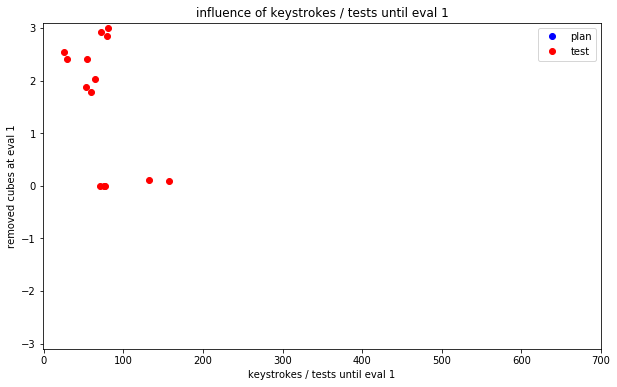

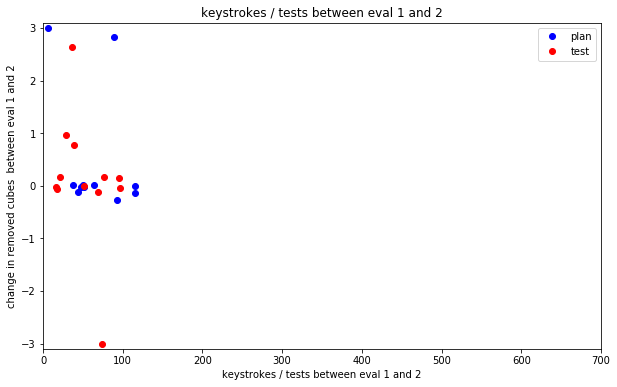

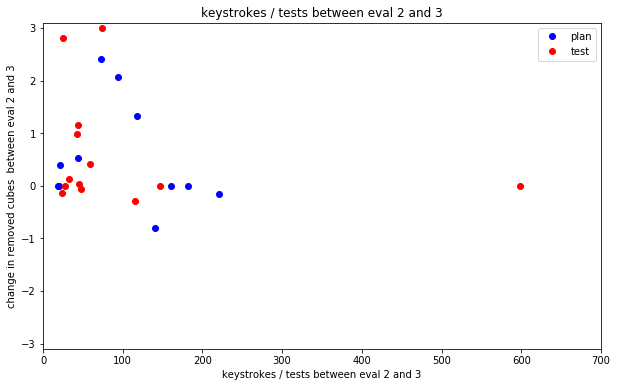

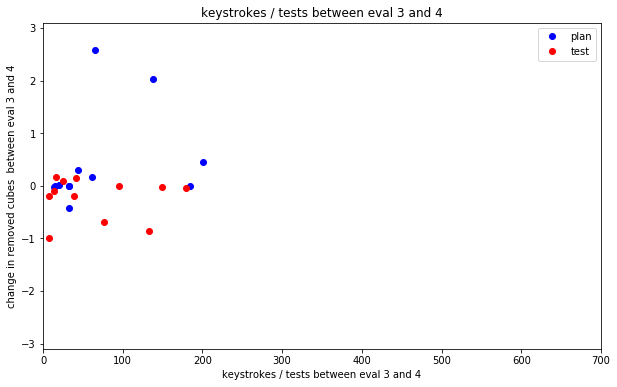

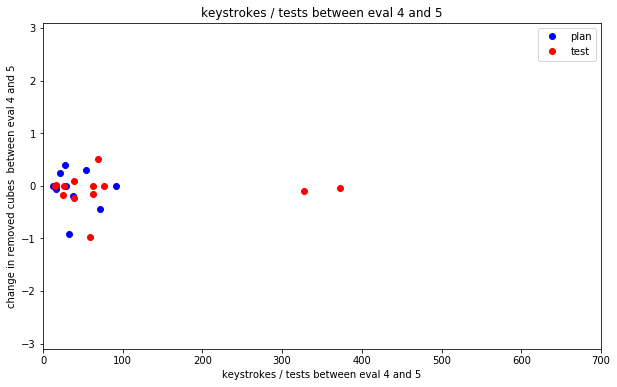

In [204]:
x0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].keystrokes / evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean
x1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].keystrokes / evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-1,700)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/deltaeval_0to1"
plt.xlabel('keystrokes / tests until eval 1')
plt.ylabel('removed cubes at eval 1')
plt.title("influence of keystrokes / tests until eval 1")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].keystrokes / evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].keystrokes / evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/deltaeval_1to2"
plt.xlabel('keystrokes / tests between eval 1 and 2')
plt.ylabel('change in removed cubes  between eval 1 and 2')
plt.title("keystrokes / tests between eval 1 and 2")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].keystrokes / evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].keystrokes / evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/deltaeval_2to3"
plt.xlabel('keystrokes / tests between eval 2 and 3')
plt.ylabel('change in removed cubes  between eval 2 and 3')
plt.title("keystrokes / tests between eval 2 and 3")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].keystrokes / evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].keystrokes / evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/deltaeval_3to4"
plt.xlabel('keystrokes / tests between eval 3 and 4')
plt.ylabel('change in removed cubes  between eval 3 and 4')
plt.title("keystrokes / tests between eval 3 and 4")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].keystrokes / evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].keystrokes / evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-3.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/deltaeval_4to5"
plt.xlabel('keystrokes / tests between eval 4 and 5')
plt.ylabel('change in removed cubes  between eval 4 and 5')
plt.title("keystrokes / tests between eval 4 and 5")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")

removed cube performance per keystrokes divided by tests

In [ ]:
x0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].keystrokes / evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean
x1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].keystrokes / evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-1,700)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/eval_0to1"
plt.xlabel('keystrokes / tests until eval 1')
plt.ylabel('removed cubes at eval 1')
plt.title("influence of keystrokes / tests until eval 1")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].keystrokes / evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].keystrokes / evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/eval_1to2"
plt.xlabel('keystrokes / tests between eval 1 and 2')
plt.ylabel('removed cubes at eval 2')
plt.title("keystrokes / tests between eval 1 and 2")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].keystrokes / evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].keystrokes / evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/eval_2to3"
plt.xlabel('keystrokes / tests between eval 2 and 3')
plt.ylabel('removed cubes at eval 3')
plt.title("keystrokes / tests between eval 2 and 3")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].keystrokes / evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].keystrokes / evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/eval_3to4"
plt.xlabel('keystrokes / tests between eval 3 and 4')
plt.ylabel('removed cubes at eval 4')
plt.title("keystrokes / tests between eval 3 and 4")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")


x0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].keystrokes / evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].tests
y0 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_mean.values
x1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].keystrokes / evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].tests
y1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,700)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/keydivbytest/eval_4to5"
plt.xlabel('keystrokes / tests between eval 4 and 5')
plt.ylabel('removed cubes at eval 5')
plt.title("keystrokes / tests between eval 4 and 5")
plt.plot(x0,y0,'ob', label = 'plan')  
plt.plot(x1,y1,'or', label = 'test')  
#plt.show()
plt.legend(loc = "upper right")
plt.savefig(filestring, bbox_inches = "tight")

## 7. statistics about evalSummary

### 7. a) performance change from eval 1 to 5

defining the logic condition for excluded participants to make it easier to exclude them in the statistics

In [46]:
excluded_participants = (evalSummary.participant != 45)&(evalSummary.participant != 64)&(evalSummary.participant != 67)&(evalSummary.participant != 70)

### paired sample t test between evaluations

1. calculate differences and their mean
2. calculate standard error (SE/sqrt(n))
3. calculate t = d/SE

make an empty array that holds all the means of d for the differences between eval 1 and 2, 1 and 3, ..., eval 4 and 5; we later need the same for the stddev.

In [27]:
# 0 = plan
# 1 = test

cond = 1

diff_means = np.zeros((5,5))
for i in range(len(diff_means)):
    diff_means[i] = np.nan
    
diff_SD = np.zeros((5,5))
for i in range(len(diff_SD)):
    diff_SD[i] = np.nan
dSD = 0

The table shows the mean differences from eval to eval. For example the top right value is mean difference (improvement) from eval 1 to eval 5

In [28]:
for eval1st in range(len(diff_means)):

    for eval2nd in range(len(diff_means)):
        dsum = 0
        N = evalSummary[(evalSummary.evaluation == eval1st+1)&(evalSummary.condition == cond)].participant.shape[0]
        for p in range(len(evalSummary[(evalSummary.evaluation == eval1st+1)&(evalSummary.condition == cond)].participant)):
            d = evalSummary[(evalSummary.evaluation == eval2nd+1)&(evalSummary.condition == cond)].removedcubes_mean.iloc[p] - evalSummary[(evalSummary.evaluation == eval1st+1)&(evalSummary.condition == cond)].removedcubes_mean.iloc[p]
            dsum = dsum + d
    
        dmean = dsum / N
        diff_means[eval1st,eval2nd] = dmean
        dsum = 0
    
diff_means

array([[ 0.        ,  0.12193362,  0.75757576,  0.85425685,  0.69336219],
       [-0.12193362,  0.        ,  0.63564214,  0.73232323,  0.57142857],
       [-0.75757576, -0.63564214,  0.        ,  0.0966811 , -0.06421356],
       [-0.85425685, -0.73232323, -0.0966811 ,  0.        , -0.16089466],
       [-0.69336219, -0.57142857,  0.06421356,  0.16089466,  0.        ]])

The next table are the standard deviations for each of the mean differences

In [29]:
for eval1st in range(len(diff_means)):   
    for eval2nd in range(len(diff_means)):
        dsum = 0        
        N = evalSummary[(evalSummary.evaluation == eval1st+1)&(evalSummary.condition == cond)].participant.shape[0]
        for p in range(len(evalSummary[(evalSummary.evaluation == eval1st+1)&(evalSummary.condition == cond)].participant)):
            d = evalSummary[(evalSummary.evaluation == eval2nd+1)&(evalSummary.condition == cond)].removedcubes_mean.iloc[p] - evalSummary[(evalSummary.evaluation == eval1st+1)&(evalSummary.condition == cond)].removedcubes_mean.iloc[p]
            dsum = dsum + np.square(d - diff_means[eval1st,eval2nd])
            
        dSD = np.sqrt(dsum / (N-1))
        diff_SD[eval1st,eval2nd] = dSD
        
diff_SD

array([[ 0.        ,  1.15640848,  0.95215287,  1.1415875 ,  0.82007998],
       [ 1.15640848,  0.        ,  1.05946558,  1.30331487,  1.18041752],
       [ 0.95215287,  1.05946558,  0.        ,  0.91928767,  0.83651984],
       [ 1.1415875 ,  1.30331487,  0.91928767,  0.        ,  0.43069544],
       [ 0.82007998,  1.18041752,  0.83651984,  0.43069544,  0.        ]])

calculating paired t values from diff_means and diff_SD

In [30]:
t = diff_means / (diff_SD / np.sqrt(N))
t

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[        nan,  0.39452654,  2.97703133,  2.79990492,  3.16350092],
       [-0.39452654,         nan,  2.24486301,  2.10241032,  1.81129973],
       [-2.97703133, -2.24486301,         nan,  0.39350853, -0.28721991],
       [-2.79990492, -2.10241032, -0.39350853,         nan, -1.3977689 ],
       [-3.16350092, -1.81129973,  0.28721991,  1.3977689 ,         nan]])

<font color = 'red'> Paired sample t-test reveals that significant improvments happened for testers between evaluation 2 and 3 and for planners there was not such a clear moment when the significant performance improvements occured. </font>

### calculating performance changes between evaluations for each participant

calculate t values for the removed cubes between an evaluation and the next evaluation from the 99 simulation results per evaluation.

independent sample t test comparison between eval 1 and 2, 2 and 3 and so on but for every participant. Significant improvements shall have a large t value.

In [ ]:
evalSummary['tval_remCubesDiff'] = np.nan

for participant in range(41,72):
    for evaluation in range(1,5):
        mean1 = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].removedcubes_mean
        mean2 = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation+1)].removedcubes_mean

        std1 = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].removedcubes_std
        std2 = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation+1)].removedcubes_std

        N1 = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].removedcubes_N
        N2 = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation+1)].removedcubes_N
        t = np.subtract(mean2,mean1)/np.sqrt(np.add(np.square(std2)/N2, np.square(std1)/N1))
        evalSummary.iloc[mean2.index,evalSummary.columns.get_loc('tval_remCubesDiff')] = t    

removing participants where they had a large positive jump (t > 10) because they had a large negative jump before (t < -10). This means that I exclude participants that had already a good solution, then messed it up and improved significantly because they reverted to the previous good solution. This was only the case for participant 65.

In [ ]:
evalSummary.iloc[121,evalSummary.columns.get_loc('tval_remCubesDiff')] = np.NaN
evalSummary.iloc[122,evalSummary.columns.get_loc('tval_remCubesDiff')] = np.NaN

#### statistic over all significant performance jumps

By looking at the plots from 6a) the participants with a clearly distinguishable jump in performance (by subjective judgement) are distinguishable by a t-value between evaluations of larger than 10. When only looking at those improvements and comparing palnners vs. testers then the planners make larger jumps and the standard deviation of the size of these jumps is larger. Can this be explained as planners have a good code in the earlier evaluation that just did not perform at all because of an easily fixable mistake that gets fixed. This is the statistic over all jumps for t > 10. It may also be interesting to look at only the larges jump.

In [ ]:
print('statistic about t-values that compare performance between different evaluations')
print('planners:')
print('mean: \t',evalSummary[(evalSummary.tval_remCubesDiff > 10.0)&(evalSummary.condition == 0)].tval_remCubesDiff.mean())
print('stdev: \t',evalSummary[(evalSummary.tval_remCubesDiff > 10.0)&(evalSummary.condition == 0)].tval_remCubesDiff.std())
print('N \t',evalSummary[(evalSummary.tval_remCubesDiff > 10.0)&(evalSummary.condition == 0)].tval_remCubesDiff.shape[0])
print()
print('testers:')
print('mean: \t',evalSummary[(evalSummary.tval_remCubesDiff > 10.0)&(evalSummary.condition == 1)].tval_remCubesDiff.mean())
print('stdev: \t',evalSummary[(evalSummary.tval_remCubesDiff > 10.0)&(evalSummary.condition == 1)].tval_remCubesDiff.std())
print('N \t',evalSummary[(evalSummary.tval_remCubesDiff > 10.0)&(evalSummary.condition == 1)].tval_remCubesDiff.shape[0])

<span style="color:red"><b>
If I take only t values of t > 10 as significant improvments then the difference in means (as by t value of the t values) between the testers and the planners is not significant.
</span></b>

#### statistic over the largest significant performance jump for each participant

determining the largest performance jump (biggestJump) and in which evaluation this occured (jumpTime)


In [ ]:
evalSummary['biggestJump'] = np.nan
evalSummary['jumpTime'] = np.nan

for participant in range(41,72):
    highest = 0
    when = 0
    index = -1
    for evaluation in range(2,6):
        current = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].tval_remCubesDiff
        if current.iloc[0] > highest:
            highest = current.iloc[0]
            when = evaluation
            index = (participant - 41)*5 + when - 1
    
    if(index >= 0):
        evalSummary.biggestJump.iloc[index] = highest
        evalSummary.jumpTime.iloc[index] = when

statistic over the biggest jumps and jumpTime

In [ ]:
print('the means over the t-values for the largest performance jump for each participant and when it occured seperated for testers and planners')
print()
print('bigest jump statistic:')
print('planners:')
print('mean: \t t = %.2f'%(evalSummary[(evalSummary.condition == 0)].biggestJump.mean()))
print('stdev: \t %.2f'%(evalSummary[(evalSummary.condition == 0)].biggestJump.std()))
print('N \t',evalSummary[(evalSummary.condition == 0)].biggestJump.shape[0]/5)
print()
print('testers:')
print('mean: \t t = %.2f' %(evalSummary[(evalSummary.condition == 1)].biggestJump.mean()))
print('stdev: \t %.2f' %(evalSummary[(evalSummary.condition == 1)].biggestJump.std()))
print('N \t',evalSummary[(evalSummary.condition == 1)].biggestJump.shape[0]/5)
mean1 = evalSummary[(evalSummary.condition == 0)].biggestJump.mean()
mean2 = evalSummary[(evalSummary.condition == 1)].biggestJump.mean()
std1 = evalSummary[(evalSummary.condition == 0)].biggestJump.std()
std2 = evalSummary[(evalSummary.condition == 1)].biggestJump.std()
N1 = evalSummary[(evalSummary.condition == 0)].biggestJump.shape[0]/5
N2 = evalSummary[(evalSummary.condition == 1)].biggestJump.shape[0]/5
print()
print('Are the performance jumps of different size for planners and testers? t-values of t-values and their stdev')
print('biggest jump, plan vs. test:')
t = (mean1 - mean2)/(np.sqrt(std1*std1/N1 + std2*std2/N2))
print('t = %.2f'%t)


print()
print()
print('jumpTime statistic:')
print('mean: \t %.2f'%(evalSummary[(evalSummary.condition == 0)].jumpTime.mean()))
print('stdev: \t %.2f'%(evalSummary[(evalSummary.condition == 0)].jumpTime.std()))
print('N \t',evalSummary[(evalSummary.condition == 0)].jumpTime.shape[0]/5)
print()
print('testers:')
print('mean: \t %.2f' %(evalSummary[(evalSummary.condition == 1)].jumpTime.mean()))
print('stdev: \t %.2f' %(evalSummary[(evalSummary.condition == 1)].jumpTime.std()))
print('N \t',evalSummary[(evalSummary.condition == 1)].biggestJump.shape[0]/5)
mean1 = evalSummary[(evalSummary.condition == 0)].jumpTime.mean()
mean2 = evalSummary[(evalSummary.condition == 1)].jumpTime.mean()
std1 = evalSummary[(evalSummary.condition == 0)].jumpTime.std()
std2 = evalSummary[(evalSummary.condition == 1)].jumpTime.std()
N1 = evalSummary[(evalSummary.condition == 0)].jumpTime.shape[0]/5
N2 = evalSummary[(evalSummary.condition == 1)].jumpTime.shape[0]/5
print()
print('Are the times of the largest jumps different for planners and testers? t-values of t-values and their stdev')
print('jump time, plan vs. test:')
t = (mean1 - mean2)/(np.sqrt(std1*std1/N1 + std2*std2/N2))
print('t = %.2f'%t)




In [ ]:
evalSummary[(evalSummary.condition == 1)&(evalSummary.biggestJump > 10)]

#### <font color = 'red'> Neither when nor how large the performance jumps are depends statistically significantly on the planning or testing condition </font>

### 7. b) plan vs. test statistics

independent sample t-test comparing all testers vs. all planners for each evaluation using the mean of removed cubes over the 99 simulations as a measure for performance.

calculating all means, stds and Ns needed for calculating the t-values

In [48]:
eval1_PlanMedian = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean.median()
eval1_TestMedian = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean.median()
eval2_PlanMedian = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.median()
eval2_TestMedian = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.median()
eval3_PlanMedian = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.median()
eval3_TestMedian = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.median()
eval4_PlanMedian = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.median()
eval4_TestMedian = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.median()
eval5_PlanMedian = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_mean.median()
eval5_TestMedian = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_mean.median()

eval1_PlanMean = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean.mean()
eval1_TestMean = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean.mean()
eval2_PlanMean = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.mean()
eval2_TestMean = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.mean()
eval3_PlanMean = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.mean()
eval3_TestMean = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.mean()
eval4_PlanMean = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.mean()
eval4_TestMean = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.mean()
eval5_PlanMean = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_mean.mean()
eval5_TestMean = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_mean.mean()

eval1_PlanStd = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean.std()
eval1_TestStd = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean.std()
eval2_PlanStd = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.std()
eval2_TestStd = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.std()
eval3_PlanStd = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.std()
eval3_TestStd = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.std()
eval4_PlanStd = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.std()
eval4_TestStd = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.std()
eval5_PlanStd = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_mean.std()
eval5_TestStd = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_mean.std()

eval1_PlanN = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean.shape[0]
eval1_TestN = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean.shape[0]
eval2_PlanN = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean.shape[0]
eval2_TestN = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean.shape[0]
eval3_PlanN = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean.shape[0]
eval3_TestN = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean.shape[0]
eval4_PlanN = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean.shape[0]
eval4_TestN = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean.shape[0]
eval5_PlanN = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_mean.shape[0]
eval5_TestN = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_mean.shape[0]

print('all searchmethods; removed cubes')
print('\t \t plan median \t plan mean \t plan std \t plan N \t\t test median \t test mean \t test std \t test N')
print('eval 1 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval1_PlanMedian,eval1_PlanMean,eval1_PlanStd,eval1_PlanN,eval1_TestMedian,eval1_TestMean,eval1_TestStd,eval1_TestN))
print('eval 2 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval2_PlanMedian,eval2_PlanMean,eval2_PlanStd,eval2_PlanN,eval2_TestMedian,eval2_TestMean,eval2_TestStd,eval1_TestN))
print('eval 3 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval3_PlanMedian,eval3_PlanMean,eval3_PlanStd,eval3_PlanN,eval3_TestMedian,eval3_TestMean,eval3_TestStd,eval1_TestN))
print('eval 4 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval4_PlanMedian,eval4_PlanMean,eval4_PlanStd,eval4_PlanN,eval4_TestMedian,eval4_TestMean,eval4_TestStd,eval1_TestN))
print('eval 5 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval5_PlanMedian,eval5_PlanMean,eval5_PlanStd,eval5_PlanN,eval5_TestMedian,eval5_TestMean,eval5_TestStd,eval1_TestN))
print()

t_eval1 = (eval1_TestMean - eval1_PlanMean)/np.sqrt(np.square(eval1_TestStd)/eval1_TestN + np.square(eval1_PlanStd)/eval1_PlanN)
t_eval2 = (eval2_TestMean - eval2_PlanMean)/np.sqrt(np.square(eval2_TestStd)/eval2_TestN + np.square(eval2_PlanStd)/eval2_PlanN)
t_eval3 = (eval3_TestMean - eval3_PlanMean)/np.sqrt(np.square(eval3_TestStd)/eval3_TestN + np.square(eval3_PlanStd)/eval3_PlanN)
t_eval4 = (eval4_TestMean - eval4_PlanMean)/np.sqrt(np.square(eval4_TestStd)/eval4_TestN + np.square(eval4_PlanStd)/eval4_PlanN)
t_eval5 = (eval5_TestMean - eval5_PlanMean)/np.sqrt(np.square(eval5_TestStd)/eval5_TestN + np.square(eval5_PlanStd)/eval5_PlanN)

print('test vs. plan for all searchmethods; removed cubes')
print('t-values')
print('evaluation 1:', t_eval1)
print('evaluation 2:', t_eval2)
print('evaluation 3:', t_eval3)
print('evaluation 4:', t_eval4)
print('evaluation 5:', t_eval5)
print()
print()

print('plan vs. test Whitney Mann U test for all search methods; removed cubes')
stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_mean)
print('eval 1: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean)
print('eval 2: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_mean)
print('eval 3: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean)
print('eval 4: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_mean)
print('eval 5: \t U = %i \t p = %.3f' % (stat, p))

print()
print()

print('plan vs. test Whitney Mann U test for all search methods; task completed')
stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].taskcomplete_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].taskcomplete_mean)
print('eval 1: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].taskcomplete_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].taskcomplete_mean)
print('eval 2: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].taskcomplete_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].taskcomplete_mean)
print('eval 3: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].taskcomplete_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].taskcomplete_mean)
print('eval 4: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].taskcomplete_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].taskcomplete_mean)
print('eval 5: \t U = %i \t p = %.3f' % (stat, p))

all searchmethods; removed cubes
	 	 plan median 	 plan mean 	 plan std 	 plan N 		 test median 	 test mean 	 test std 	 test N
eval 1 		 0.21 		 1.12 		 1.30 		 13 			 1.95 		 1.57 		 1.24 		 14
eval 2 		 1.59 		 1.56 		 1.43 		 13 			 2.13 		 1.69 		 1.20 		 14
eval 3 		 2.78 		 2.01 		 1.23 		 13 			 2.72 		 2.33 		 0.91 		 14
eval 4 		 2.64 		 2.39 		 0.84 		 13 			 2.67 		 2.43 		 0.75 		 14
eval 5 		 2.75 		 2.19 		 1.14 		 13 			 2.62 		 2.27 		 0.80 		 14

test vs. plan for all searchmethods; removed cubes
t-values
evaluation 1: 0.92370565807
evaluation 2: 0.256407139253
evaluation 3: 0.774355415586
evaluation 4: 0.103171956643
evaluation 5: 0.207618025827


plan vs. test Whitney Mann U test for all search methods; removed cubes
eval 1: 	 U = 87 	 p = 0.432
eval 2: 	 U = 84 	 p = 0.376
eval 3: 	 U = 87 	 p = 0.433
eval 4: 	 U = 84 	 p = 0.376
eval 5: 	 U = 70 	 p = 0.166


plan vs. test Whitney Mann U test for all search methods; task completed
eval 1: 	 U = 80 	 p = 0.306
eval

In [49]:
evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.thirdcube_N != 0)].thirdcube_N.shape[0]

6

In [50]:
#thirdCube
print('plan vs. test Whitney Mann U test for all search methods; 3rdCube')
stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_mean)
print('eval 1: \t U = %i \t p = %.3f' % (stat, p))
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_mean.dropna(), evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_mean.dropna())
print('eval 1: \t t = %.2f \t p = %.3f' % (t, p))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_mean)
print('eval 2: \t U = %i \t p = %.3f' % (stat, p))
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_mean.dropna(), evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_mean.dropna())
print('eval 2: \t t = %.2f \t p = %.3f' % (t, p))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_mean)
print('eval 3: \t U = %i \t p = %.3f' % (stat, p))
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_mean.dropna(), evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_mean.dropna())
print('eval 3: \t t = %.2f \t p = %.3f' % (t, p))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_mean)
print('eval 4: \t U = %i \t p = %.3f' % (stat, p))
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_mean.dropna(), evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_mean.dropna())
print('eval 4: \t t = %.2f \t p = %.3f' % (t, p))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_mean, evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_mean)
print('eval 5: \t U = %i \t p = %.3f' % (stat, p))
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_mean.dropna(), evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_mean.dropna())
print('eval 5: \t t = %.2f \t p = %.3f' % (t, p))

print()
print()
print('mean of means and mean of std for thirdcube')
print('evaluation \t Nplan \t Ntest \t meanPlan \t stdPlan \t meanTest \t stdTest \t t_mean \t p_mean')

Nplan = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_mean.dropna().shape[0]
Ntest = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_mean.dropna().shape[0]
meanplan = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_mean.dropna().mean()
meantest = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_mean.dropna().mean()
stdplan = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_std.dropna().mean()
stdtest = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_mean.dropna(),evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_mean.dropna())
print('eval 1: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, stdplan, meantest, stdtest, t, p))

Nplan = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_mean.dropna().shape[0]
Ntest = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_mean.dropna().shape[0]
meanplan = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_mean.dropna().mean()
meantest = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_mean.dropna().mean()
stdplan = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_std.dropna().mean()
stdtest = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_mean.dropna(),evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_mean.dropna())
print('eval 1: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, stdplan, meantest, stdtest, t, p))

Nplan = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_mean.dropna().shape[0]
Ntest = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_mean.dropna().shape[0]
meanplan = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_mean.dropna().mean()
meantest = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_mean.dropna().mean()
stdplan = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_std.dropna().mean()
stdtest = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_mean.dropna(),evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_mean.dropna())
print('eval 1: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, stdplan, meantest, stdtest, t, p))

Nplan = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_mean.dropna().shape[0]
Ntest = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_mean.dropna().shape[0]
meanplan = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_mean.dropna().mean()
meantest = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_mean.dropna().mean()
stdplan = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_std.dropna().mean()
stdtest = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_mean.dropna(),evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_mean.dropna())
print('eval 1: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, stdplan, meantest, stdtest, t, p))

Nplan = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_mean.dropna().shape[0]
Ntest = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_mean.dropna().shape[0]
meanplan = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_mean.dropna().mean()
meantest = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_mean.dropna().mean()
stdplan = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_std.dropna().mean()
stdtest = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_mean.dropna(),evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_mean.dropna(), equal_var = False)
print('eval 1: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, stdplan, meantest, stdtest, t, p))

print()
print()
print('thirdcube_std')

#thirdCube_std
print('plan vs. test Whitney Mann U test for all search methods; 3rdCube')
stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_std, evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_std)
print('eval 1: \t U = %i \t p = %.3f' % (stat, p))
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_std.dropna(), evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_std.dropna())
N1 = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.thirdcube_N != 0)].thirdcube_N.shape[0]
N2 = evalSummary[excluded_participants&(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.thirdcube_N != 0)].thirdcube_N.shape[0]
print('eval 1: \t t = %.2f \t p = %.3f \t Nplan = %i \t Ntest = %i' % (t, p, N1, N2))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_std, evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_std)
print('eval 2: \t U = %i \t p = %.3f' % (stat, p))
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_std.dropna(), evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_std.dropna())
N1 = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 0)&(evalSummary.thirdcube_N != 0)].thirdcube_N.shape[0]
N2 = evalSummary[excluded_participants&(evalSummary.evaluation == 2)&(evalSummary.condition == 1)&(evalSummary.thirdcube_N != 0)].thirdcube_N.shape[0]
print('eval 2: \t t = %.2f \t p = %.3f \t Nplan = %i \t Ntest = %i' % (t, p, N1, N2))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_std, evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_std)
print('eval 3: \t U = %i \t p = %.3f' % (stat, p))
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_std.dropna(), evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_std.dropna())
N1 = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 0)&(evalSummary.thirdcube_N != 0)].thirdcube_N.shape[0]
N2 = evalSummary[excluded_participants&(evalSummary.evaluation == 3)&(evalSummary.condition == 1)&(evalSummary.thirdcube_N != 0)].thirdcube_N.shape[0]
print('eval 3: \t t = %.2f \t p = %.3f \t Nplan = %i \t Ntest = %i' % (t, p, N1, N2))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_std, evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_std)
print('eval 4: \t U = %i \t p = %.3f' % (stat, p))
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_std.dropna(), evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_std.dropna())
N1 = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 0)&(evalSummary.thirdcube_N != 0)].thirdcube_N.shape[0]
N2 = evalSummary[excluded_participants&(evalSummary.evaluation == 4)&(evalSummary.condition == 1)&(evalSummary.thirdcube_N != 0)].thirdcube_N.shape[0]
print('eval 4: \t t = %.2f \t p = %.3f \t Nplan = %i \t Ntest = %i' % (t, p, N1, N2))

stat, p = mannwhitneyu(evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_std, evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_std)
print('eval 5: \t U = %i \t p = %.3f' % (stat, p))
t, p = stats.ttest_ind(evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_std.dropna(), evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_std.dropna())
N1 = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 0)&(evalSummary.thirdcube_N != 0)].thirdcube_N.shape[0]
N2 = evalSummary[excluded_participants&(evalSummary.evaluation == 5)&(evalSummary.condition == 1)&(evalSummary.thirdcube_N != 0)].thirdcube_N.shape[0]
print('eval 5: \t t = %.2f \t p = %.3f \t Nplan = %i \t Ntest = %i' % (t, p, N1, N2))

plan vs. test Whitney Mann U test for all search methods; 3rdCube
eval 1: 	 U = 72 	 p = 0.185
eval 1: 	 t = 0.05 	 p = 0.958
eval 2: 	 U = 86 	 p = 0.414
eval 2: 	 t = -0.86 	 p = 0.404
eval 3: 	 U = 75 	 p = 0.226
eval 3: 	 t = 0.07 	 p = 0.941
eval 4: 	 U = 87 	 p = 0.433
eval 4: 	 t = 0.22 	 p = 0.824
eval 5: 	 U = 83 	 p = 0.358
eval 5: 	 t = -0.92 	 p = 0.366


mean of means and mean of std for thirdcube
evaluation 	 Nplan 	 Ntest 	 meanPlan 	 stdPlan 	 meanTest 	 stdTest 	 t_mean 	 p_mean
eval 1: 	 6 	 9 	 111.0 		 64.6 		 109.2 		 61.7 		 0.05 		 0.958
eval 1: 	 7 	 9 	 86.2 		 47.4 		 117.7 		 56.6 		 -0.86 		 0.404
eval 1: 	 10 	 13 	 97.6 		 45.8 		 96.0 		 62.6 		 0.07 		 0.941
eval 1: 	 12 	 13 	 118.3 		 52.0 		 111.8 		 67.1 		 0.22 		 0.824
eval 1: 	 11 	 13 	 78.8 		 42.1 		 100.6 		 59.5 		 -0.94 		 0.359


thirdcube_std
plan vs. test Whitney Mann U test for all search methods; 3rdCube
eval 1: 	 U = 61 	 p = 0.076
eval 1: 	 t = 0.14 	 p = 0.890 	 Nplan = 6 	 Ntest = 9

In [34]:
print('mean of means and mean of std for firstcube')
print('evaluation \t Nplan \t Ntest \t meanPlan \t SDofMeansPlan \t stdPlan \t meanTest \t SDofMeansTest \t stdTest \t Welch t \t p')

Nplan = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].firstcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].firstcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].firstcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].firstcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].firstcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].firstcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].firstcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].firstcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].firstcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].firstcube_mean.dropna(), equal_var = False)
print('eval 1: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

Nplan = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].firstcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].firstcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].firstcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].firstcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].firstcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].firstcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].firstcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].firstcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].firstcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].firstcube_mean.dropna(), equal_var = False)
print('eval 2: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

Nplan = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].firstcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].firstcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].firstcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].firstcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].firstcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].firstcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].firstcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].firstcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].firstcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].firstcube_mean.dropna(), equal_var = False)
print('eval 3: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

Nplan = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].firstcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].firstcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].firstcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].firstcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].firstcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].firstcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].firstcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].firstcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].firstcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].firstcube_mean.dropna(), equal_var = False)
print('eval 4: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

Nplan = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].firstcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].firstcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].firstcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].firstcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].firstcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].firstcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].firstcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].firstcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].firstcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].firstcube_mean.dropna(), equal_var = False)
print('eval 5: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))






print()
print()
print('mean of means and mean of std for secondcube')
print('evaluation \t Nplan \t Ntest \t meanPlan \t SDofMeansPlan \t stdPlan \t meanTest \t SDofMeansTest \t stdTest \t Welch t \t p')

Nplan = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].secondcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].secondcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].secondcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].secondcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].secondcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].secondcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].secondcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].secondcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].secondcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].secondcube_mean.dropna(), equal_var = False)
print('eval 1: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

Nplan = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].secondcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].secondcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].secondcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].secondcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].secondcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].secondcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].secondcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].secondcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].secondcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].secondcube_mean.dropna(), equal_var = False)
print('eval 2: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

Nplan = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].secondcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].secondcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].secondcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].secondcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].secondcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].secondcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].secondcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].secondcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].secondcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].secondcube_mean.dropna(), equal_var = False)
print('eval 3: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

Nplan = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].secondcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].secondcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].secondcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].secondcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].secondcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].secondcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].secondcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].secondcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].secondcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].secondcube_mean.dropna(), equal_var = False)
print('eval 4: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

Nplan = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].secondcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].secondcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].secondcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].secondcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].secondcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].secondcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].secondcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].secondcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].secondcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].secondcube_mean.dropna(), equal_var = False)
print('eval 5: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))





print()
print()
print('mean of means and mean of std for thirdcube')
print('evaluation \t Nplan \t Ntest \t meanPlan \t SDofMeansPlan \t stdPlan \t meanTest \t SDofMeansTest \t stdTest \t Welch t \t p')

Nplan = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdcube_mean.dropna(), equal_var = False)
print('eval 1: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

Nplan = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdcube_mean.dropna(), equal_var = False)
print('eval 2: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

Nplan = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdcube_mean.dropna(), equal_var = False)
print('eval 3: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

Nplan = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdcube_mean.dropna(), equal_var = False)
print('eval 4: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

Nplan = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_mean.dropna().shape[0]
Ntest = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_mean.dropna().shape[0]
meanplan = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_mean.dropna().mean()
meantest = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_mean.dropna().mean()
SDMplan = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_mean.dropna().std()
SDMtest = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_mean.dropna().std()
stdplan = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_std.dropna().mean()
stdtest = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_std.dropna().mean()
t, p = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdcube_mean.dropna(),evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdcube_mean.dropna(), equal_var = False)
print('eval 5: \t %i \t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t %.3f' % (Nplan, Ntest, meanplan, SDMplan, stdplan, meantest, SDMtest, stdtest, t, p))

mean of means and mean of std for firstcube
evaluation 	 Nplan 	 Ntest 	 meanPlan 	 SDofMeansPlan 	 stdPlan 	 meanTest 	 SDofMeansTest 	 stdTest 	 Welch t 	 p
eval 1: 	 12 	 11 	 21.6 		 24.7 		 17.7 		 22.4 		 20.1 		 19.1 		 -0.08 		 0.935
eval 2: 	 11 	 13 	 15.6 		 13.2 		 18.5 		 36.0 		 43.1 		 29.8 		 -1.61 		 0.128
eval 3: 	 13 	 14 	 17.9 		 18.5 		 11.8 		 19.7 		 13.2 		 15.5 		 -0.28 		 0.780
eval 4: 	 13 	 14 	 22.1 		 19.2 		 17.4 		 28.5 		 27.4 		 23.5 		 -0.70 		 0.490
eval 5: 	 13 	 14 	 20.7 		 23.6 		 15.2 		 25.1 		 22.7 		 21.8 		 -0.49 		 0.631


mean of means and mean of std for secondcube
evaluation 	 Nplan 	 Ntest 	 meanPlan 	 SDofMeansPlan 	 stdPlan 	 meanTest 	 SDofMeansTest 	 stdTest 	 Welch t 	 p
eval 1: 	 7 	 9 	 66.4 		 60.7 		 44.3 		 59.6 		 39.3 		 42.3 		 0.26 		 0.803
eval 2: 	 8 	 10 	 47.9 		 50.3 		 31.1 		 82.7 		 67.2 		 56.3 		 -1.25 		 0.228
eval 3: 	 10 	 13 	 57.0 		 39.5 		 30.4 		 48.8 		 25.9 		 35.4 		 0.57 		 0.580
eval 4: 	 12 	 13 	 

Field for manually sorting and noting the best evaluation:

In [88]:
participant = 71

print('participant:', participant)
print('CubesMean \t CubesSD \t 1stM \t 1stSD \t 2ndM \t 2ndSD \t 3rdM \t 3rdSD \t evaluation')
for evaluation in range(1,6):
    CubesMean = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].removedcubes_mean
    CubesSD = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].removedcubes_std
    firstCubeMean = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].firstcube_mean
    firstCubeSD = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].firstcube_std
    secondCubeMean = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].secondcube_mean
    secondCubeSD = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].secondcube_std
    thirdCubeMean = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].thirdcube_mean
    thirdCubeSD = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].thirdcube_std
    
    print('%.2f \t\t %.2f \t\t %.1f \t %.1f \t %.1f \t %.1f \t %.1f \t %.1f \t %i '%(CubesMean,CubesSD,firstCubeMean,firstCubeSD,secondCubeMean,secondCubeSD,thirdCubeMean,thirdCubeSD,evaluation))
    

participant: 71
CubesMean 	 CubesSD 	 1stM 	 1stSD 	 2ndM 	 2ndSD 	 3rdM 	 3rdSD 	 evaluation
0.10 		 0.30 		 3.4 	 0.7 	 nan 	 nan 	 nan 	 nan 	 1 
0.10 		 0.30 		 3.4 	 0.7 	 nan 	 nan 	 nan 	 nan 	 2 
0.10 		 0.30 		 3.4 	 0.7 	 nan 	 nan 	 nan 	 nan 	 3 
2.65 		 0.77 		 15.2 	 9.7 	 32.5 	 19.4 	 78.3 	 47.9 	 4 
2.48 		 1.03 		 14.1 	 7.8 	 31.5 	 16.4 	 62.9 	 50.9 	 5 


Creating a pandas dataframe that saves the best evalSummary data for each participants such that I can do all kinds of math on it afterwards.

In [49]:
bestEvalPlan = pd.DataFrame([
    [42,2.78,0.65,18.3,12.0,57.1,35.5,101.8,45.6,4],
    [44,2.64,0.50,25.6,19.9,69.0,38.1,107.8,57.9,4],
    [46,3,0,5.2,2.1,11.6,2.8,17.6,3.2,2],
    [48,2.93,0.26,11.5,14.7,36.8,36.5,80.5,60,4],
    [50,2.19,0.84,57.1,84.9,156.4,124.6,221.3,99.4,4],
    [52,0.53,0.5,5,1.1,np.nan,np.nan,np.nan,np.nan,3],
    [54,2.97,0.17,14.9,7.2,46.7,12.7,89.6,43.5,2],
    [56,3,0,4.5,1.7,12.5,2.2,19.9,3.4,5],
    [58,2.99,0.1,5,1.2,11,2.1,17.6,3,3],
    [60,2.55,0.61,18.1,12.9,35.6,25.8,79.5,58.8,5],
    [62,3,0,11.1,6.6,23.6,10.8,51,28.5,5],
    [66,0.69,0.88,62.1,24.4,155,51.6,226.6,43.9,4],
    [68,3,0,10.7,6.5,36.8,20.6,81,44.8,2],     
], 
index = [0,1,2,3,4,5,6,7,8,9,10,11,12], 
columns=['participant','removedcubes_mean','removedcubes_std','firstcube_mean','firstcube_std','secondcube_mean','secondcube_std','thirdcube_mean','thirdcube_std','evaluation']
)

In [50]:
bestEvalPlan

,participant,removedcubes_mean,removedcubes_std,firstcube_mean,firstcube_std,secondcube_mean,secondcube_std,thirdcube_mean,thirdcube_std,evaluation
0,42,2.78,0.65,18.3,12.0,57.1,35.5,101.8,45.6,4
1,44,2.64,0.50,25.6,19.9,69.0,38.1,107.8,57.9,4
2,46,3.00,0.00,5.2,2.1,11.6,2.8,17.6,3.2,2
3,48,2.93,0.26,11.5,14.7,36.8,36.5,80.5,60.0,4
4,50,2.19,0.84,57.1,84.9,156.4,124.6,221.3,99.4,4
5,52,0.53,0.50,5.0,1.1,NaN,NaN,NaN,NaN,3
6,54,2.97,0.17,14.9,7.2,46.7,12.7,89.6,43.5,2
7,56,3.00,0.00,4.5,1.7,12.5,2.2,19.9,3.4,5
8,58,2.99,0.10,5.0,1.2,11.0,2.1,17.6,3.0,3
9,60,2.55,0.61,18.1,12.9,35.6,25.8,79.5,58.8,5


In [74]:
bestEvalPlan.evaluation.std()

1.12089707663561

In [90]:
bestEvalTest = pd.DataFrame([
    [41,2.91,0.29,51.1,53,113.1,71.2,196.9,85.2,3],
    [43,1.77,0.87,8.2,4.2,20.3,4.9,30.2,7.1,3],
    [47,2.71,0.48,32.0,26.6,59.4,42.1,93.1,59.6,4],
    [49,2.47,0.5,13.5,8.2,30.4,17.2,79.7,36.8,3],
    [51,2.99,0.1,26.7,21.8,60.9,37.8,117.4,62.6,4],
    [53,2.72,0.5,8.3,3.9,26.6,11.2,57.5,35.9,2],
    [55,2.49,0.69,61.4,55.4,141.4,84.5,22.8,99,4],
    [57,2.67,0.55,7.9,5.4,23.4,25.3,40,43.4,5],
    [59,3,0,17.2,10.8,61.1,37.5,102.4,49.7,2],
    [61,2.88,0.33,9.1,5.2,24,33.7,66,79.6,3],
    [63,2.98,0.14,26.9,18.7,73.5,55.1,187.8,101.4,3],
    [65,3,0,18,10.6,34.3,10.2,56.7,16.2,1],
    [69,2.93,0.29,16.4,10.2,38.9,28.1,89.8,64.7,1],
    [71,2.65,0.77,15.2,9.7,32.5,19.4,78.3,47.9,4],
], 
index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13], 
columns=['participant','removedcubes_mean','removedcubes_std','firstcube_mean','firstcube_std','secondcube_mean','secondcube_std','thirdcube_mean','thirdcube_std','evaluation']
)

In [133]:
print('comparative statistics for best evaluation')
print()

print('Mann Whitney tests')
stat, p = mannwhitneyu(bestEvalPlan.removedcubes_mean,bestEvalTest.removedcubes_mean)
print('removed cubes mean: \t U = %i \t p = %.3f' % (stat, p))
stat, p = mannwhitneyu(bestEvalPlan.removedcubes_std,bestEvalTest.removedcubes_std)
print('removed cubes SD: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(bestEvalPlan.firstcube_mean,bestEvalTest.firstcube_mean)
print('first cube mean: \t U = %i \t p = %.3f' % (stat, p))
stat, p = mannwhitneyu(bestEvalPlan.firstcube_std,bestEvalTest.firstcube_std)
print('first cube SD: \t\t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(bestEvalPlan.secondcube_mean,bestEvalTest.secondcube_mean)
print('second cube mean: \t U = %i \t p = %.3f' % (stat, p))
stat, p = mannwhitneyu(bestEvalPlan.secondcube_std,bestEvalTest.secondcube_std)
print('second cube SD: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(bestEvalPlan.thirdcube_mean,bestEvalTest.thirdcube_mean)
print('third cube mean: \t U = %i \t p = %.3f' % (stat, p))
stat, p = mannwhitneyu(bestEvalPlan.thirdcube_std,bestEvalTest.thirdcube_std)
print('third cube SD: \t\t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(bestEvalPlan.evaluation,bestEvalTest.evaluation)
print('evaluation: \t\t U = %i \t p = %.3f' % (stat, p))

print()
print()

print('student t-tests')
stat, p = stats.ttest_ind(bestEvalPlan.removedcubes_mean,bestEvalTest.removedcubes_mean)
print('removed cubes mean: \t t = %.3f \t p = %.3f' % (stat, p))
stat, p = stats.ttest_ind(bestEvalPlan.removedcubes_std,bestEvalTest.removedcubes_std)
print('removed cubes SD: \t t = %.3f \t p = %.3f' % (stat, p))

stat, p = stats.ttest_ind(bestEvalPlan.firstcube_mean,bestEvalTest.firstcube_mean)
print('first cube mean: \t t = %.3f \t p = %.3f' % (stat, p))
stat, p = stats.ttest_ind(bestEvalPlan.firstcube_std,bestEvalTest.firstcube_std)
print('first cube SD: \t\t t = %.3f \t p = %.3f' % (stat, p))

stat, p = stats.ttest_ind(bestEvalPlan.secondcube_mean.dropna(),bestEvalTest.secondcube_mean)
print('second cube mean: \t t = %.3f \t p = %.3f' % (stat, p))
stat, p = stats.ttest_ind(bestEvalPlan.secondcube_std.dropna(),bestEvalTest.secondcube_std)
print('second cube SD: \t t = %.3f \t p = %.3f' % (stat, p))

stat, p = stats.ttest_ind(bestEvalPlan.thirdcube_mean.dropna(),bestEvalTest.thirdcube_mean)
print('third cube mean: \t t = %.3f \t p = %.3f' % (stat, p))
stat, p = stats.ttest_ind(bestEvalPlan.thirdcube_std.dropna(),bestEvalTest.thirdcube_std)
print('third cube SD: \t\t t = %.3f \t p = %.3f' % (stat, p))

stat, p = stats.ttest_ind(bestEvalPlan.evaluation,bestEvalTest.evaluation)
print('evaluation: \t\t t = %.3f \t p = %.3f' % (stat, p))

comparative statistics for best evaluation

Mann Whitney tests
removed cubes mean: 	 U = 85 	 p = 0.394
removed cubes SD: 	 U = 81 	 p = 0.330
first cube mean: 	 U = 71 	 p = 0.172
first cube SD: 		 U = 74 	 p = 0.212
second cube mean: 	 U = 90 	 p = 0.490
second cube SD: 	 U = 81 	 p = 0.322
third cube mean: 	 U = 85 	 p = 0.395
third cube SD: 		 U = 71 	 p = 0.172
evaluation: 		 U = 64 	 p = 0.096


student t-tests
removed cubes mean: 	 t = -0.982 	 p = 0.336
removed cubes SD: 	 t = -0.398 	 p = 0.694
first cube mean: 	 t = -0.457 	 p = 0.651
first cube SD: 		 t = -0.315 	 p = 0.755
second cube mean: 	 t = 0.088 	 p = 0.931
second cube SD: 	 t = -0.345 	 p = 0.733
third cube mean: 	 t = 0.173 	 p = 0.864
third cube SD: 		 t = -1.376 	 p = 0.181
evaluation: 		 t = 1.389 	 p = 0.177


In [132]:
#thirdCube*taskcompleteSTD
print('plan vs. test Whitney Mann U test for all search methods; 3rdCube*taskcompleteSTD')
stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].thirdCubetimestaskcompleteSTD, evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].thirdCubetimestaskcompleteSTD)
print('eval 1: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].thirdCubetimestaskcompleteSTD, evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].thirdCubetimestaskcompleteSTD)
print('eval 2: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].thirdCubetimestaskcompleteSTD, evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].thirdCubetimestaskcompleteSTD)
print('eval 3: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].thirdCubetimestaskcompleteSTD, evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].thirdCubetimestaskcompleteSTD)
print('eval 4: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].thirdCubetimestaskcompleteSTD, evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].thirdCubetimestaskcompleteSTD)
print('eval 5: \t U = %i \t p = %.3f' % (stat, p))

plan vs. test Whitney Mann U test for all search methods; 3rdCube*taskcompleteSTD
eval 1: 	 U = 76 	 p = 0.241
eval 2: 	 U = 84 	 p = 0.385
eval 3: 	 U = 90 	 p = 0.490
eval 4: 	 U = 89 	 p = 0.471
eval 5: 	 U = 73 	 p = 0.198


doing exactly the same analysis but with the std of the 99 starting positions. Basically using the persistency/resilience of the code as a performance measure

In [ ]:
np.sort(evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_mean)

In [ ]:
np.sort(evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_mean)

In [ ]:
2.5 + 5+6+9+10+11+12+13+14+20.5+24+25+26 - 13*14/2

Whitney-Mann "by hand" gives the same result.

#### <font color='red'> No statstically significant performance difference between planners and testers even at the first evaluation. There is almost a significant difference in eval 5 that planners perform better. If I use the standard deviation of the removed cubes and task complete from the 99 starts as a performance measure (or rather a measure of reliability) then the planners have significantly less std in eval 5</font>
The mean performance of the testers is better in the first evaluation but the difference is not significant. This is mostly due to the large performance deviation between participants.
The difference between median and mean especially for the planners is striking! This means that the majority of planners were below the mean while some few exceptions (i.e. p46) rasied the mean. Although not mathematically correct, what would happen if I use the medians instead of the means for calculating the t-values?

In [ ]:
t_eval1 = (eval1_TestMedian - eval1_PlanMedian)/np.sqrt(np.square(eval1_TestStd)/eval1_TestN + np.square(eval1_PlanStd)/eval1_PlanN)
t_eval2 = (eval2_TestMedian - eval2_PlanMedian)/np.sqrt(np.square(eval2_TestStd)/eval2_TestN + np.square(eval2_PlanStd)/eval2_PlanN)
t_eval3 = (eval3_TestMedian - eval3_PlanMedian)/np.sqrt(np.square(eval3_TestStd)/eval3_TestN + np.square(eval3_PlanStd)/eval3_PlanN)
t_eval4 = (eval4_TestMedian - eval4_PlanMedian)/np.sqrt(np.square(eval4_TestStd)/eval4_TestN + np.square(eval4_PlanStd)/eval4_PlanN)
t_eval5 = (eval5_TestMedian - eval5_PlanMedian)/np.sqrt(np.square(eval5_TestStd)/eval5_TestN + np.square(eval5_PlanStd)/eval5_PlanN)

print('test vs. plan for all searchmethods with MEDIANS instead of means')
print('t-values')
print('evaluation 1:', t_eval1)
print('evaluation 2:', t_eval2)
print('evaluation 3:', t_eval3)
print('evaluation 4:', t_eval4)
print('evaluation 5:', t_eval5)

Then the difference in the first evaluation would be very statistically significant. Calculating t-values assumes that the measurements are normally distributed which they clearly are not! What to do?

Assuming that adding more participants would not change the standard deviation (having more participants does not make the individuals more similar) and assuming a similar effect size (difference of the means); how many participants would we need to get a statistically significant result?

In [ ]:
eval1_TestN = 60
eval1_PlanN = 60
t_eval1 = (eval1_TestMean - eval1_PlanMean)/np.sqrt(np.square(eval1_TestStd)/eval1_TestN + np.square(eval1_PlanStd)/eval1_PlanN)
t_eval2 = (eval2_TestMean - eval2_PlanMean)/np.sqrt(np.square(eval2_TestStd)/eval2_TestN + np.square(eval2_PlanStd)/eval2_PlanN)
t_eval3 = (eval3_TestMean - eval3_PlanMean)/np.sqrt(np.square(eval3_TestStd)/eval3_TestN + np.square(eval3_PlanStd)/eval3_PlanN)
t_eval4 = (eval4_TestMean - eval4_PlanMean)/np.sqrt(np.square(eval4_TestStd)/eval4_TestN + np.square(eval4_PlanStd)/eval4_PlanN)
t_eval5 = (eval5_TestMean - eval5_PlanMean)/np.sqrt(np.square(eval5_TestStd)/eval5_TestN + np.square(eval5_PlanStd)/eval5_PlanN)
print('test vs. plan for each evaluation assuming 60 participants in each condition')
print('t-values')
print('evaluation 1:', t_eval1)
print('evaluation 2:', t_eval2)
print('evaluation 3:', t_eval3)
print('evaluation 4:', t_eval4)
print('evaluation 5:', t_eval5)

#### <font color='red'> With about 60 participants in each condition these results would become statistically significant. </font> 
This means that either the effect size is too small or the deviation between the participants is too large since 120 participants is a utopian effort.

In the analysis above I compare ALL planners with ALL testers even when they use different approaches to solve the task. The two most common approaches for detecting cubes were using ultrasound and the blinking lights. Let's repeat the analysis but this time seperated by the cube search method (1 = ultrasound, 2 = blink)

In [112]:
eval1_PlanMedian = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_std.median()
eval1_TestMedian = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_std.median()
eval2_PlanMedian = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_std.median()
eval2_TestMedian = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_std.median()
eval3_PlanMedian = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_std.median()
eval3_TestMedian = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_std.median()
eval4_PlanMedian = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_std.median()
eval4_TestMedian = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_std.median()
eval5_PlanMedian = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_std.median()
eval5_TestMedian = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_std.median()

eval1_PlanMean = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_std.mean()
eval1_TestMean = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_std.mean()
eval2_PlanMean = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_std.mean()
eval2_TestMean = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_std.mean()
eval3_PlanMean = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_std.mean()
eval3_TestMean = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_std.mean()
eval4_PlanMean = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_std.mean()
eval4_TestMean = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_std.mean()
eval5_PlanMean = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_std.mean()
eval5_TestMean = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_std.mean()

eval1_PlanStd = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_std.std()
eval1_TestStd = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_std.std()
eval2_PlanStd = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_std.std()
eval2_TestStd = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_std.std()
eval3_PlanStd = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_std.std()
eval3_TestStd = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_std.std()
eval4_PlanStd = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_std.std()
eval4_TestStd = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_std.std()
eval5_PlanStd = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_std.std()
eval5_TestStd = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_std.std()

eval1_PlanN = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_std.shape[0]
eval1_TestN = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_std.shape[0]
eval2_PlanN = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_std.shape[0]
eval2_TestN = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_std.shape[0]
eval3_PlanN = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_std.shape[0]
eval3_TestN = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_std.shape[0]
eval4_PlanN = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_std.shape[0]
eval4_TestN = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_std.shape[0]
eval5_PlanN = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_std.shape[0]
eval5_TestN = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_std.shape[0]

print('all searchmethods; removed cubes but their std over 99 starts')
print('\t \t plan median \t plan mean \t plan std \t plan N \t\t test median \t test mean \t test std \t test N')
print('eval 1 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval1_PlanMedian,eval1_PlanMean,eval1_PlanStd,eval1_PlanN,eval1_TestMedian,eval1_TestMean,eval1_TestStd,eval1_TestN))
print('eval 2 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval2_PlanMedian,eval2_PlanMean,eval2_PlanStd,eval2_PlanN,eval2_TestMedian,eval2_TestMean,eval2_TestStd,eval1_TestN))
print('eval 3 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval3_PlanMedian,eval3_PlanMean,eval3_PlanStd,eval3_PlanN,eval3_TestMedian,eval3_TestMean,eval3_TestStd,eval1_TestN))
print('eval 4 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval4_PlanMedian,eval4_PlanMean,eval4_PlanStd,eval4_PlanN,eval4_TestMedian,eval4_TestMean,eval4_TestStd,eval1_TestN))
print('eval 5 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval5_PlanMedian,eval5_PlanMean,eval5_PlanStd,eval5_PlanN,eval5_TestMedian,eval5_TestMean,eval5_TestStd,eval1_TestN))
print()

print('t test for stds:')

eval1 = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_std, evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_std)
eval2 = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_std, evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_std)
eval3 = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_std, evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_std)
eval4 = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_std, evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_std)
eval5 = stats.ttest_ind(evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_std, evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_std)

print(eval1)
print(eval2)
print(eval3)
print(eval4)
print(eval5)
print()

t_eval1 = (eval1_TestMean - eval1_PlanMean)/np.sqrt(np.square(eval1_TestStd)/eval1_TestN + np.square(eval1_PlanStd)/eval1_PlanN)
t_eval2 = (eval2_TestMean - eval2_PlanMean)/np.sqrt(np.square(eval2_TestStd)/eval2_TestN + np.square(eval2_PlanStd)/eval2_PlanN)
t_eval3 = (eval3_TestMean - eval3_PlanMean)/np.sqrt(np.square(eval3_TestStd)/eval3_TestN + np.square(eval3_PlanStd)/eval3_PlanN)
t_eval4 = (eval4_TestMean - eval4_PlanMean)/np.sqrt(np.square(eval4_TestStd)/eval4_TestN + np.square(eval4_PlanStd)/eval4_PlanN)
t_eval5 = (eval5_TestMean - eval5_PlanMean)/np.sqrt(np.square(eval5_TestStd)/eval5_TestN + np.square(eval5_PlanStd)/eval5_PlanN)

print('test vs. plan for all searchmethods; removed cubes but their std over 99 starts')
print('t-values')
print('evaluation 1:', t_eval1)
print('evaluation 2:', t_eval2)
print('evaluation 3:', t_eval3)
print('evaluation 4:', t_eval4)
print('evaluation 5:', t_eval5)
print()
print()

print('plan vs. test Whitney Mann U test for all search methods; removed cubes STD!')
stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].removedcubes_std, evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].removedcubes_std)
print('eval 1: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_std, evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_std)
print('eval 2: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].removedcubes_std, evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].removedcubes_std)
print('eval 3: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].removedcubes_std, evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].removedcubes_std)
print('eval 4: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].removedcubes_std, evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].removedcubes_std)
print('eval 5: \t U = %i \t p = %.3f' % (stat, p))

print()
print()

print('plan vs. test Whitney Mann U test for all search methods; task completed STD')
stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)].taskcomplete_std, evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)].taskcomplete_std)
print('eval 1: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].taskcomplete_std, evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].taskcomplete_std)
print('eval 2: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)].taskcomplete_std, evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)].taskcomplete_std)
print('eval 3: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)].taskcomplete_std, evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)].taskcomplete_std)
print('eval 4: \t U = %i \t p = %.3f' % (stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].taskcomplete_std, evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)].taskcomplete_std)
print('eval 5: \t U = %i \t p = %.3f' % (stat, p))

all searchmethods; removed cubes but their std over 99 starts
	 	 plan median 	 plan mean 	 plan std 	 plan N 		 test median 	 test mean 	 test std 	 test N
eval 1 		 0.32 		 0.37 		 0.31 		 13 			 0.35 		 0.39 		 0.32 		 14
eval 2 		 0.10 		 0.24 		 0.34 		 13 			 0.44 		 0.45 		 0.28 		 14
eval 3 		 0.37 		 0.38 		 0.30 		 13 			 0.34 		 0.44 		 0.26 		 14
eval 4 		 0.50 		 0.44 		 0.32 		 13 			 0.47 		 0.52 		 0.30 		 14
eval 5 		 0.37 		 0.38 		 0.31 		 13 			 0.51 		 0.58 		 0.29 		 14

t test for stds:
Ttest_indResult(statistic=-0.17183377231963357, pvalue=0.86495160968094909)
Ttest_indResult(statistic=-1.7653052653287415, pvalue=0.089726131704259027)
Ttest_indResult(statistic=-0.51406778363374039, pvalue=0.61171897211898574)
Ttest_indResult(statistic=-0.66863659608916182, pvalue=0.50985467577580179)
Ttest_indResult(statistic=-1.7462549680010724, pvalue=0.093045188883778593)

test vs. plan for all searchmethods; removed cubes but their std over 99 starts
t-values
evaluation 1: 0

In [51]:
searchmethod = 1 #ultra

eval1_PlanMedian = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval1_TestMedian = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval2_PlanMedian = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval2_TestMedian = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval3_PlanMedian = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval3_TestMedian = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval4_PlanMedian = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval4_TestMedian = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval5_PlanMedian = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval5_TestMedian = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()

eval1_PlanMean = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval1_TestMean = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval2_PlanMean = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval2_TestMean = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval3_PlanMean = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval3_TestMean = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval4_PlanMean = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval4_TestMean = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval5_PlanMean = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval5_TestMean = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()

eval1_PlanStd = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval1_TestStd = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval2_PlanStd = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval2_TestStd = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval3_PlanStd = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval3_TestStd = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval4_PlanStd = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval4_TestStd = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval5_PlanStd = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval5_TestStd = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()

eval1_PlanN = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval1_TestN = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval2_PlanN = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval2_TestN = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval3_PlanN = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval3_TestN = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval4_PlanN = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval4_TestN = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval5_PlanN = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval5_TestN = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]

print('searchmedthod 1, ultrasound')
print('\t \t plan median \t plan mean \t plan std \t plan N \t\t test median \t test mean \t test std \t test N')
print('eval 1 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval1_PlanMedian,eval1_PlanMean,eval1_PlanStd,eval1_PlanN,eval1_TestMedian,eval1_TestMean,eval1_TestStd,eval1_TestN))
print('eval 2 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval2_PlanMedian,eval2_PlanMean,eval2_PlanStd,eval2_PlanN,eval2_TestMedian,eval2_TestMean,eval2_TestStd,eval1_TestN))
print('eval 3 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval3_PlanMedian,eval3_PlanMean,eval3_PlanStd,eval3_PlanN,eval3_TestMedian,eval3_TestMean,eval3_TestStd,eval1_TestN))
print('eval 4 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval4_PlanMedian,eval4_PlanMean,eval4_PlanStd,eval4_PlanN,eval4_TestMedian,eval4_TestMean,eval4_TestStd,eval1_TestN))
print('eval 5 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval5_PlanMedian,eval5_PlanMean,eval5_PlanStd,eval5_PlanN,eval5_TestMedian,eval5_TestMean,eval5_TestStd,eval1_TestN))
print()

t_eval1 = (eval1_TestMean - eval1_PlanMean)/np.sqrt(np.square(eval1_TestStd)/eval1_TestN + np.square(eval1_PlanStd)/eval1_PlanN)
t_eval2 = (eval2_TestMean - eval2_PlanMean)/np.sqrt(np.square(eval2_TestStd)/eval2_TestN + np.square(eval2_PlanStd)/eval2_PlanN)
t_eval3 = (eval3_TestMean - eval3_PlanMean)/np.sqrt(np.square(eval3_TestStd)/eval3_TestN + np.square(eval3_PlanStd)/eval3_PlanN)
t_eval4 = (eval4_TestMean - eval4_PlanMean)/np.sqrt(np.square(eval4_TestStd)/eval4_TestN + np.square(eval4_PlanStd)/eval4_PlanN)
t_eval5 = (eval5_TestMean - eval5_PlanMean)/np.sqrt(np.square(eval5_TestStd)/eval5_TestN + np.square(eval5_PlanStd)/eval5_PlanN)

print('test vs. plan for each evaluation using ultrasound')
print('t-values')
print('evaluation 1:', t_eval1)
print('evaluation 2:', t_eval2)
print('evaluation 3:', t_eval3)
print('evaluation 4:', t_eval4)
print('evaluation 5:', t_eval5)
print()


print('plan vs. test Whitney Mann U test for searchmethod = ultrasound; removed cubes')

for evaluation in range(1,6):
    stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean, evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean)
    print('eval %i: \t U = %i \t p = %.3f' % (evaluation, stat, p))

print()
print()







searchmethod = 2 #blink

eval1_PlanMedian = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval1_TestMedian = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval2_PlanMedian = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval2_TestMedian = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval3_PlanMedian = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval3_TestMedian = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval4_PlanMedian = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval4_TestMedian = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval5_PlanMedian = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()
eval5_TestMedian = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.median()

eval1_PlanMean = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval1_TestMean = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval2_PlanMean = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval2_TestMean = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval3_PlanMean = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval3_TestMean = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval4_PlanMean = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval4_TestMean = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval5_PlanMean = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()
eval5_TestMean = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.mean()

eval1_PlanStd = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval1_TestStd = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval2_PlanStd = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval2_TestStd = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval3_PlanStd = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval3_TestStd = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval4_PlanStd = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval4_TestStd = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval5_PlanStd = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()
eval5_TestStd = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.std()

eval1_PlanN = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval1_TestN = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval2_PlanN = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval2_TestN = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval3_PlanN = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval3_TestN = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval4_PlanN = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval4_TestN = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval5_PlanN = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]
eval5_TestN = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean.shape[0]

print('searchmedthod 2, blink')
print('\t \t plan median \t plan mean \t plan std \t plan N \t\t test median \t test mean \t test std \t test N')
print('eval 1 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval1_PlanMedian,eval1_PlanMean,eval1_PlanStd,eval1_PlanN,eval1_TestMedian,eval1_TestMean,eval1_TestStd,eval1_TestN))
print('eval 2 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval2_PlanMedian,eval2_PlanMean,eval2_PlanStd,eval2_PlanN,eval2_TestMedian,eval2_TestMean,eval2_TestStd,eval1_TestN))
print('eval 3 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval3_PlanMedian,eval3_PlanMean,eval3_PlanStd,eval3_PlanN,eval3_TestMedian,eval3_TestMean,eval3_TestStd,eval1_TestN))
print('eval 4 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval4_PlanMedian,eval4_PlanMean,eval4_PlanStd,eval4_PlanN,eval4_TestMedian,eval4_TestMean,eval4_TestStd,eval1_TestN))
print('eval 5 \t\t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i'%(eval5_PlanMedian,eval5_PlanMean,eval5_PlanStd,eval5_PlanN,eval5_TestMedian,eval5_TestMean,eval5_TestStd,eval1_TestN))
print()

t_eval1 = (eval1_TestMean - eval1_PlanMean)/np.sqrt(np.square(eval1_TestStd)/eval1_TestN + np.square(eval1_PlanStd)/eval1_PlanN)
t_eval2 = (eval2_TestMean - eval2_PlanMean)/np.sqrt(np.square(eval2_TestStd)/eval2_TestN + np.square(eval2_PlanStd)/eval2_PlanN)
t_eval3 = (eval3_TestMean - eval3_PlanMean)/np.sqrt(np.square(eval3_TestStd)/eval3_TestN + np.square(eval3_PlanStd)/eval3_PlanN)
t_eval4 = (eval4_TestMean - eval4_PlanMean)/np.sqrt(np.square(eval4_TestStd)/eval4_TestN + np.square(eval4_PlanStd)/eval4_PlanN)
t_eval5 = (eval5_TestMean - eval5_PlanMean)/np.sqrt(np.square(eval5_TestStd)/eval5_TestN + np.square(eval5_PlanStd)/eval5_PlanN)

print('test vs. plan for each evaluation using blink')
print('t-values')
print('evaluation 1:', t_eval1)
print('evaluation 2:', t_eval2)
print('evaluation 3:', t_eval3)
print('evaluation 4:', t_eval4)
print('evaluation 5:', t_eval5)

print()
print()

print('plan vs. test Whitney Mann U test for searchmethod = blink; removed cubes')

for evaluation in range(1,6):
    stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean, evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.searchmethod == searchmethod)].removedcubes_mean)
    print('eval %i: \t U = %i \t p = %.3f' % (evaluation, stat, p))

searchmedthod 1, ultrasound
	 	 plan median 	 plan mean 	 plan std 	 plan N 		 test median 	 test mean 	 test std 	 test N
eval 1 		 0.40 		 1.08 		 1.30 		 8 			 1.88 		 1.33 		 1.30 		 7
eval 2 		 1.59 		 1.57 		 1.43 		 7 			 0.77 		 1.17 		 1.19 		 7
eval 3 		 2.92 		 2.18 		 1.30 		 7 			 2.88 		 2.33 		 0.88 		 7
eval 4 		 2.94 		 2.60 		 0.85 		 8 			 2.58 		 2.32 		 0.98 		 7
eval 5 		 2.85 		 2.41 		 1.03 		 8 			 2.60 		 2.08 		 1.02 		 7

test vs. plan for each evaluation using ultrasound
t-values
evaluation 1: 0.374521924069
evaluation 2: -0.56786384043
evaluation 3: 0.25303661904
evaluation 4: -0.600227229407
evaluation 5: -0.616159805157

plan vs. test Whitney Mann U test for searchmethod = ultrasound; removed cubes
eval 1: 	 U = 27 	 p = 0.500
eval 2: 	 U = 19 	 p = 0.282
eval 3: 	 U = 22 	 p = 0.399
eval 4: 	 U = 15 	 p = 0.073
eval 5: 	 U = 17 	 p = 0.111


searchmedthod 2, blink
	 	 plan median 	 plan mean 	 plan std 	 plan N 		 test median 	 test mean 	 test std 	 te

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:4879: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


<font color = 'red'> Comparing plan and test yields no significant difference in eval 1 (largest stimuli) when only comparing ultrasound solutions. A comparison of blink solutions is not possible in eval one because no planning participant used this method in eval 1. 
<p>
There is a weak significant difference saying that planners using ultrasound are better at evals 4 and 5.</font>

Comparing the hird cube times for only ultrasound solutions from planners vs. testers

In [119]:
for evaluation in range(1,6):
    plan = evalSummary[excluded_participants&(evalSummary.searchmethod == 1) & (evalSummary.condition == 0) & (evalSummary.evaluation == evaluation)].thirdcube_mean.dropna()
    test = evalSummary[excluded_participants&(evalSummary.searchmethod == 1) & (evalSummary.condition == 1) & (evalSummary.evaluation == evaluation)].thirdcube_mean.dropna()
    stat, p = stats.ttest_ind(plan,test)
    print('planner \t evaluation: %i \t mean = %.1f \t sd = %.1f'%(evaluation,plan.mean(),plan.std()))
    print('tester  \t evaluation: %i \t mean = %.1f \t sd = %.1f'%(evaluation,test.mean(),test.std()))
    print('Nplan = %i \t Ntest = %i \t t = %.3f \t p = %.3f'%(plan.shape[0],test.shape[0],stat,p))
    print()

planner 	 evaluation: 1 	 mean = 113.6 	 sd = 71.5
tester  	 evaluation: 1 	 mean = 87.6 	 sd = 81.1
Nplan = 3 	 Ntest = 4 	 t = 0.441 	 p = 0.678

planner 	 evaluation: 2 	 mean = 80.5 	 sd = 78.2
tester  	 evaluation: 2 	 mean = 108.8 	 sd = 117.0
Nplan = 4 	 Ntest = 3 	 t = -0.387 	 p = 0.715

planner 	 evaluation: 3 	 mean = 63.9 	 sd = 43.7
tester  	 evaluation: 3 	 mean = 81.6 	 sd = 53.1
Nplan = 5 	 Ntest = 7 	 t = -0.607 	 p = 0.557

planner 	 evaluation: 4 	 mean = 57.6 	 sd = 39.1
tester  	 evaluation: 4 	 mean = 127.2 	 sd = 76.2
Nplan = 7 	 Ntest = 6 	 t = -2.121 	 p = 0.058

planner 	 evaluation: 5 	 mean = 60.3 	 sd = 52.7
tester  	 evaluation: 5 	 mean = 110.0 	 sd = 74.4
Nplan = 7 	 Ntest = 6 	 t = -1.408 	 p = 0.187



Are the standard deviations of the thirdcube over the 99 simulation significantly different for ultra and blink?

In [111]:
evaluation = 5

ultra = evalSummary[excluded_participants & (evalSummary.evaluation == evaluation) & (evalSummary.searchmethod == 1)].removedcubes_mean.dropna()
blink = evalSummary[excluded_participants & (evalSummary.evaluation == evaluation) & (evalSummary.searchmethod == 2)].removedcubes_mean.dropna()
stat, p = stats.ttest_ind(ultra,blink)
print('removedcubes mean ultra: \t value = %.1f \t t = %.3f \t p = %.3f'%(ultra.mean(),stat,p))
stat, p = mannwhitneyu(ultra,blink)
print('removedcubes mean blink: \t value = %.1f \t U = %.3f \t p = %.3f'%(blink.mean(),stat,p))
print()
ultra = evalSummary[excluded_participants & (evalSummary.evaluation == evaluation) & (evalSummary.searchmethod == 1)].thirdcube_mean.dropna()
blink = evalSummary[excluded_participants & (evalSummary.evaluation == evaluation) & (evalSummary.searchmethod == 2)].thirdcube_mean.dropna()
stat, p = stats.ttest_ind(ultra,blink)
print('thirdcube mean ultra: \t value = %.1f \t t = %.3f \t p = %.3f'%(ultra.mean(),stat,p))
stat, p = mannwhitneyu(ultra,blink)
print('thirdcube mean blink: \t value = %.1f \t U = %.3f \t p = %.3f'%(blink.mean(),stat,p))
print()
ultra = evalSummary[excluded_participants & (evalSummary.evaluation == evaluation) & (evalSummary.searchmethod == 1)].thirdcube_std.dropna()
blink = evalSummary[excluded_participants & (evalSummary.evaluation == evaluation) & (evalSummary.searchmethod == 2)].thirdcube_std.dropna()
stat, p = stats.ttest_ind(ultra,blink)
print('thirdcube std ultra: \t value = %.1f \t t = %.3f \t p = %.3f'%(ultra.mean(),stat,p))
stat, p = mannwhitneyu(ultra,blink)
print('thirdcube std blink: \t value = %.1f \t U = %.3f \t p = %.3f'%(blink.mean(),stat,p))

removedcubes mean ultra: 	 value = 2.3 	 t = -0.568 	 p = 0.577
removedcubes mean blink: 	 value = 2.5 	 U = 41.000 	 p = 0.392

thirdcube mean ultra: 	 value = 83.3 	 t = -0.476 	 p = 0.640
thirdcube mean blink: 	 value = 98.2 	 U = 30.000 	 p = 0.228

thirdcube std ultra: 	 value = 45.4 	 t = -1.017 	 p = 0.324
thirdcube std blink: 	 value = 60.5 	 U = 30.000 	 p = 0.228


### do planners perform better than testers in eval 4 and 5?

In [ ]:
print('all searchmethods included, comparing means')
print()

print('overalltime \t t \t p \t N1 \t N2')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))

print()
print()

print('lastcube \t t \t p \t N1 \t N2')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))

print()
print()

print('distance \t t \t p \t N1 \t N2')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))


print()
print()

print('edgetouches \t t \t p \t N1 \t N2')
data1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
data2 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
data2 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))

print()
print()

print('bonus \t\t t \t p \t N1 \t N2')
data1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].bonus_mean.dropna()
data2 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].bonus_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].bonus_mean.dropna()
data2 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].bonus_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))

print()
print()

print('penalty \t t \t p \t N1 \t N2')
data1 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].penalty_mean.dropna()
data2 = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].penalty_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].penalty_mean.dropna()
data2 = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].penalty_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))


In [216]:
print('only ultrasound searchmethod, comparing means')
print()

print('overalltime \t t \t p \t N1 \t N2')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))

print()
print()

print('lastcube \t t \t p \t N1 \t N2')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))

print()
print()

print('distance \t t \t p \t N1 \t N2')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].distance_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))


print()
print()

print('edgetouches \t t \t p \t N1 \t N2')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))

print()
print()

print('bonus \t\t t \t p \t N1 \t N2')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].bonus_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].bonus_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].bonus_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].bonus_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))

print()
print()

print('penalty \t t \t p \t N1 \t N2')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].penalty_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].penalty_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].penalty_mean.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].penalty_mean.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))



only ultrasound searchmethod, comparing means

overalltime 	 t 	 p 	 N1 	 N2
evaluation 4: 	 -2.22 	 0.058 	 11 	 6
evaluation 5: 	 -1.49 	 0.190 	 6 	 4


lastcube 	 t 	 p 	 N1 	 N2
evaluation 4: 	 -2.02 	 0.082 	 7 	 6
evaluation 5: 	 -1.46 	 0.207 	 6 	 4


distance 	 t 	 p 	 N1 	 N2
evaluation 4: 	 -1.58 	 0.166 	 7 	 6
evaluation 5: 	 -1.53 	 0.179 	 6 	 4


edgetouches 	 t 	 p 	 N1 	 N2
evaluation 4: 	 -2.24 	 0.049 	 7 	 6
evaluation 5: 	 -1.60 	 0.158 	 6 	 4


bonus 		 t 	 p 	 N1 	 N2
evaluation 4: 	 1.76 	 0.113 	 7 	 6
evaluation 5: 	 0.42 	 0.682 	 6 	 4


penalty 	 t 	 p 	 N1 	 N2
evaluation 4: 	 -0.03 	 0.975 	 7 	 6
evaluation 5: 	 -1.34 	 0.254 	 6 	 4


In [217]:
print('only ultrasound searchmethod, comparing standard deviations')
print()

print('overalltime \t t \t p \t N plan  N test')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].overalltime_std.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_std.dropna()
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].overalltime_std.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].overalltime_std.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))

print()
print()

print('lastcube \t t \t p \t N plan  N test')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].lastcube_std.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_std.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].lastcube_std.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].lastcube_std.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))

print()
print()

print('distance \t t \t p \t N plan  N test')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].distance_std.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].distance_std.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].distance_std.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].distance_std.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))


print()
print()

print('edgetouches \t t \t p \t Nplan  N test')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].edgetouches_std.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_std.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].edgetouches_std.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].edgetouches_std.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))

print()
print()

print('bonus \t\t t \t p \t N plan  N test')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].bonus_std.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].bonus_std.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].bonus_std.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].bonus_std.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))

print()
print()

print('penalty \t t \t p \t N plan  N test')
data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].penalty_std.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 4)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].penalty_std.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t1,p1 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 4: \t %.2f \t %.3f \t %i \t %i'%(t1,p1,N1,N2))

data1 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 0) & (evalSummary.removedcubes_mean > 2)].penalty_std.dropna()
data2 = evalSummary[(evalSummary.searchmethod == 1) & (evalSummary.evaluation == 5)&(evalSummary.condition == 1) & (evalSummary.removedcubes_mean > 2)].penalty_std.dropna()
N1 = data1.shape[0]
N2 = data2.shape[0]
t2,p2 = ttest_ind(data1, data2, equal_var = False)
print('evaluation 5: \t %.2f \t %.3f \t %i \t %i'%(t2,p2,N1,N2))


only ultrasound searchmethod, comparing standard deviations

overalltime 	 t 	 p 	 N plan  N test
evaluation 4: 	 -2.98 	 0.014 	 6 	 6
evaluation 5: 	 -3.69 	 0.009 	 6 	 4


lastcube 	 t 	 p 	 N plan  N test
evaluation 4: 	 -3.02 	 0.013 	 7 	 6
evaluation 5: 	 -3.25 	 0.014 	 6 	 4


distance 	 t 	 p 	 N plan  N test
evaluation 4: 	 -1.95 	 0.091 	 7 	 6
evaluation 5: 	 -1.72 	 0.161 	 6 	 4


edgetouches 	 t 	 p 	 Nplan  N test
evaluation 4: 	 -2.64 	 0.027 	 7 	 6
evaluation 5: 	 -1.40 	 0.246 	 6 	 4


bonus 		 t 	 p 	 N plan  N test
evaluation 4: 	 0.31 	 0.762 	 7 	 6
evaluation 5: 	 -0.23 	 0.829 	 6 	 4


penalty 	 t 	 p 	 N plan  N test
evaluation 4: 	 -0.20 	 0.842 	 7 	 6
evaluation 5: 	 -0.22 	 0.835 	 6 	 4


### color detection performance

In [274]:
print('planners')
print('evaluation \t Nbonus \t Npen \t bonus_mean \t penalty_mean \t bonus_std \t pen_std \t (pen-bonus)_mean \t (pen-bonus)_std')

for evaluation in range(1,6):
    Bonus = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == evaluation)&(evalSummary.bonus_mean != 0)].bonus_mean
    Pen = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == evaluation)&(evalSummary.penalty_mean != 0)].penalty_mean
    penminusbonus = Pen - Bonus    
    print('%i \t\t %i \t\t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t\t %.2f' % (evaluation,Bonus.shape[0],Pen.shape[0],Bonus.mean(),Pen.mean(),Bonus.std(),Pen.std(),penminusbonus.mean(),penminusbonus.std()))


print()
    
print('testerss')
print('evaluation \t Nbonus \t Npen \t bonus_mean \t penalty_mean \t bonus_std \t pen_std \t (pen-bonus)_mean \t (pen-bonus)_std')

for evaluation in range(1,6):
    Bonus = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)&(evalSummary.bonus_mean != 0)].bonus_mean
    Pen = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)&(evalSummary.penalty_mean != 0)].penalty_mean
    penminusbonus = Pen - Bonus    
    print('%i \t\t %i \t\t %i \t %.1f \t\t %.1f \t\t %.1f \t\t %.1f \t\t %.2f \t\t\t %.2f' % (evaluation,Bonus.shape[0],Pen.shape[0],Bonus.mean(),Pen.mean(),Bonus.std(),Pen.std(),penminusbonus.mean(),penminusbonus.std()))
    
print()
print('\t\t\t\t\t t \t p \t t \t p \t\t\t\t\t t \t p')
for evaluation in range(1,6):
    planBonus = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == evaluation)&(evalSummary.bonus_mean != 0)].bonus_mean
    planPen = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == evaluation)&(evalSummary.penalty_mean != 0)].penalty_mean
    testBonus = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)&(evalSummary.bonus_mean != 0)].bonus_mean
    testPen = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)&(evalSummary.penalty_mean != 0)].penalty_mean
    bonusstat, bonusp = stats.ttest_ind(planBonus,testBonus)
    penstat, penp = stats.ttest_ind(planPen,testPen)
    diffstat, diffp = stats.ttest_ind(planPen-planBonus,testPen-testBonus)
    print('%i \t\t \t \t\t %.2f \t %.2f \t %.2f \t %.2f \t\t\t\t\t %.2f \t%.2f' % (evaluation,bonusstat,bonusp,penstat,penp,diffstat,diffp))

planners
evaluation 	 Nbonus 	 Npen 	 bonus_mean 	 penalty_mean 	 bonus_std 	 pen_std 	 (pen-bonus)_mean 	 (pen-bonus)_std
1 		 3 		 4 	 11.6 		 4.2 		 6.0 		 5.3 		 -6.06 			 9.15
2 		 5 		 5 	 13.9 		 4.4 		 9.6 		 4.5 		 -9.47 			 12.62
3 		 4 		 4 	 13.2 		 5.4 		 10.9 		 4.4 		 -7.83 			 13.99
4 		 6 		 5 	 15.7 		 5.4 		 11.8 		 4.8 		 -13.45 			 14.04
5 		 5 		 5 	 14.9 		 3.9 		 13.1 		 3.2 		 -10.97 			 15.71

testerss
evaluation 	 Nbonus 	 Npen 	 bonus_mean 	 penalty_mean 	 bonus_std 	 pen_std 	 (pen-bonus)_mean 	 (pen-bonus)_std
1 		 4 		 4 	 4.1 		 2.9 		 2.7 		 2.8 		 -1.26 			 2.59
2 		 5 		 5 	 6.0 		 7.5 		 3.5 		 6.3 		 1.52 			 4.78
3 		 6 		 6 	 7.7 		 9.5 		 3.6 		 4.6 		 1.73 			 3.04
4 		 7 		 7 	 6.7 		 7.2 		 4.2 		 3.8 		 0.49 			 2.94
5 		 9 		 9 	 8.1 		 7.2 		 4.7 		 4.4 		 -0.94 			 4.57

					 t 	 p 	 t 	 p 					 t 	 p
1 		 	 		 2.25 	 0.07 	 0.43 	 0.68 					 nan 	nan
2 		 	 		 1.73 	 0.12 	 -0.89 	 0.40 					 -1.82 	0.11
3 		 	 		 1.17 	 0.27 	 -1.40 	 0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Did the participants that use color detection already have a well performing solution?

In [312]:
evaluation = 5
evalSummary[(evalSummary.condition == 0)&(evalSummary.penalty_mean != 0)].removedcubes_mean.dropna()

9      2.747475
25     2.979798
26     3.000000
27     3.000000
28     3.000000
29     3.000000
35     1.717172
36     1.585859
38     2.929293
76     2.989899
77     2.838384
78     3.000000
79     3.000000
86     2.989899
87     2.989899
88     2.959596
89     2.959596
105    2.969697
106    3.000000
107    3.000000
108    3.000000
109    3.000000
125    0.020202
Name: removedcubes_mean, dtype: float64

### 7. c) ultra vs. blink - what is superior?

comparing the performance (removed cubes, task complete and completion time) for ultrasound vs. blink in each evaluation

In [41]:
print('result of ultra and blink; removed cubes')
print('\t\t ultra median \t ultra mean \t ultra std \t ultra N \t\t blink median \t blink mean \t blink std \t blink N')
for evaluation in range(1,6):
    ultra_median = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].removedcubes_mean.median()
    ultra_mean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].removedcubes_mean.mean()
    ultra_std = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].removedcubes_mean.std()
    ultra_N = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].removedcubes_mean.shape[0]
    blink_median = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].removedcubes_mean.median()
    blink_mean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].removedcubes_mean.mean()
    blink_std = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].removedcubes_mean.std()
    blink_N = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].removedcubes_mean.shape[0]
    print('eval %i: \t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i' % (evaluation, ultra_median, ultra_mean, ultra_std, ultra_N, blink_median, blink_mean, blink_std, blink_N))
print()
print()

print('result of ultra and blink; taskcomplete')
print('\t\t ultra median \t ultra mean \t ultra std \t ultra N \t\t blink median \t blink mean \t blink std \t blink N')
for evaluation in range(1,6):
    ultra_median = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].taskcomplete_mean.median()
    ultra_mean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].taskcomplete_mean.mean()
    ultra_std = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].taskcomplete_mean.std()
    ultra_N = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].taskcomplete_mean.shape[0]
    blink_median = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].taskcomplete_mean.median()
    blink_mean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].taskcomplete_mean.mean()
    blink_std = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].taskcomplete_mean.std()
    blink_N = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].taskcomplete_mean.shape[0]
    print('eval %i: \t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i' % (evaluation, ultra_median, ultra_mean, ultra_std, ultra_N, blink_median, blink_mean, blink_std, blink_N))
print()
print()

print('result of ultra and blink; task completion time (a.k.a third cube)')
print('\t\t ultra median \t ultra mean \t ultra std \t ultra N \t\t blink median \t blink mean \t blink std \t blink N')
for evaluation in range(1,6):
    ultra_median = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].thirdcube_mean.median()
    ultra_mean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].thirdcube_mean.mean()
    ultra_std = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].thirdcube_mean.std()
    ultra_N = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].thirdcube_mean.shape[0]
    blink_median = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].thirdcube_mean.median()
    blink_mean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].thirdcube_mean.mean()
    blink_std = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].thirdcube_mean.std()
    blink_N = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].thirdcube_mean.shape[0]
    print('eval %i: \t %.2f \t\t %.2f \t\t %.2f \t\t %i \t\t\t %.2f \t\t %.2f \t\t %.2f \t\t %i' % (evaluation, ultra_median, ultra_mean, ultra_std, ultra_N, blink_median, blink_mean, blink_std, blink_N))
print()
print()

print('does ultrasound perform differently than the blink solution? Removed Cubes')
for evaluation in range(1,6):
    stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].removedcubes_mean, evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].removedcubes_mean)
    print('eval %i: \t U = %i \t p = %.3f' % (evaluation, stat, p))
print()
print()

print('does ultrasound perform differently than the blink solution? taskcomplete')
for evaluation in range(1,6):
    stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].taskcomplete_mean, evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].taskcomplete_mean)
    print('eval %i: \t U = %i \t p = %.3f' % (evaluation, stat, p))
print()
print()

print('does ultrasound perform differently than the blink solution? task completion time / third cube time')
for evaluation in range(1,6):
    stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].thirdcube_mean, evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].thirdcube_mean)
    print('eval %i: \t U = %i \t p = %.3f' % (evaluation, stat, p))
print()
print()

print('fastest ultrasound task completion time (mean over 99 starting positions): \t %.1f seconds'%np.sort(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 1)].thirdcube_mean)[0])
print('fastest blink task completion time (mean over 99 starting positions): \t \t %.1f seconds'%np.sort(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.searchmethod == 2)].thirdcube_mean)[0])

result of ultra and blink; removed cubes
		 ultra median 	 ultra mean 	 ultra std 	 ultra N 		 blink median 	 blink mean 	 blink std 	 blink N
eval 1: 	 0.64 		 1.20 		 1.25 		 15 			 1.78 		 1.48 		 1.34 		 5
eval 2: 	 1.18 		 1.37 		 1.28 		 14 			 2.71 		 2.19 		 1.12 		 6
eval 3: 	 2.89 		 2.26 		 1.07 		 14 			 2.56 		 2.19 		 1.19 		 5
eval 4: 	 2.78 		 2.47 		 0.89 		 15 			 2.65 		 2.46 		 0.51 		 5
eval 5: 	 2.74 		 2.25 		 1.00 		 15 			 2.68 		 2.50 		 0.57 		 6


result of ultra and blink; taskcomplete
		 ultra median 	 ultra mean 	 ultra std 	 ultra N 		 blink median 	 blink mean 	 blink std 	 blink N
eval 1: 	 0.00 		 0.30 		 0.39 		 15 			 0.14 		 0.34 		 0.42 		 5
eval 2: 	 0.13 		 0.35 		 0.43 		 14 			 0.73 		 0.61 		 0.39 		 6
eval 3: 	 0.89 		 0.66 		 0.42 		 14 			 0.63 		 0.60 		 0.39 		 5
eval 4: 	 0.87 		 0.72 		 0.34 		 15 			 0.72 		 0.65 		 0.20 		 5
eval 5: 	 0.76 		 0.62 		 0.39 		 15 			 0.75 		 0.70 		 0.25 		 6


result of ultra and blink; task completio

#### <font color = 'red'> The ultrasound solution has the potential to be significantly faster but this shows only vaguely, if at all, in the statistics. Qualitatively speaking ultrasound has to have more potential because it can detect cubes from a larger distance and more important without a time lag. </font>
When programming the minimal solution that reliably solves the task the ultrasound solution is by far shorter and easier to implement.

### 7. d) influence of testing

t_eval1 = (eval1_TestMean - eval1_PlanMean)/np.sqrt(np.square(eval1_TestStd)/eval1_TestN + np.square(eval1_PlanStd)/eval1_PlanN)Do testers and planners test equally frequently when both groups are allowed to test?

In [ ]:
print('amount of testing before evaluations')
print()
print('if amount of testing is normally distributed (t-test):')
print()
print('eval \t plan mean \t test mean \t t-value')
for evaluation in range(1,6):
    a = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests
    b = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests
    mean1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests.mean()
    mean2 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.mean()
    std1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests.std()
    std2 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.std()
    N1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests.shape[0]
    N2 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.shape[0]
    t = (mean1 - mean2) / (np.sqrt(np.square(std1)/N1 + np.square(std2)/N2))
    t2, p2 = stats.ttest_ind(a,b)
    print('%i \t %.2f \t\t %.2f \t\t %.3f \t %.3f \t %.3f'%(evaluation,mean1,mean2,t,t2,p2))

    

print()
print()

print('in case no normal distribution:')
print()
print('eval \t plan mean \t test mean \t U \t p-value')
for evaluation in range(1,6):
    data1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests
    data2 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests
    stat, p = mannwhitneyu(data1,data2)
    print('%i \t %.2f \t\t %.2f \t\t %i \t %.3f'%(evaluation,data1.mean(),data2.mean(),stat,p))
    
print()
print()
print('eval 1, correlation of number of tests and removed cubes for the successful testers (> 1.5 cubes):')
data1 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.removedcubes_mean > 1.5)].tests
data2 = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.removedcubes_mean > 1.5)].removedcubes_mean

R, p = pearsonr(data1, data2)
print('Pearson R: \t %.2f'%(R))
print('p value: \t %.2f'%(p))
    

<font color = 'red'> In most cases the testers kept testing more before later evaluations but not statistically significantly</font>

Spearman rank correlation between removed cubes and number of tests. <br>
keylogger stopped working for participant 55 --> excluded from counting the number of tests

In [ ]:
print('Does the number of tests before/between evaluations correlate with the number of removed cubes? Planners')
print('eval \t tests mean \tcorr \t p-value')
for evaluation in range(1,6):
    
    xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests.mean()
    x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean
    
    corr , p = spearmanr(x,y)
    print('%i \t %.2f  \t \t%.2f \t%.3f'%(evaluation, xmean, corr, p))
print()

print('Does the number of tests before/between evaluations correlate with the number of removed cubes? Testers')
print('eval \t tests mean \tcorr \t p-value')
for evaluation in range(1,6):
    
    xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.mean()
    xplan = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests
    yplan = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean
    
    corr , p = spearmanr(xplan,yplan)
    print('%i \t %.2f  \t \t%.2f \t%.3f'%(evaluation, xmean, corr, p))
print()
print('does more or less testing correlate with performance for the testers before eval 1 if I only look at the successful ones (more than 1.5 cubes removed)?')
evaluation = 1
xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)&(evalSummary.removedcubes_mean > 1.5)].tests.mean()
xplan = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)&(evalSummary.removedcubes_mean > 1.5)].tests
yplan = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)&(evalSummary.removedcubes_mean > 1.5)].removedcubes_mean
corr , p = spearmanr(xplan,yplan)
print('%i \t %.2f  \t \t%.2f \t%.3f'%(evaluation, xmean, corr, p))
print()

print('does the sum of tests correlate with removed cubes? Planners')
print('eval \t tests mean \tcorr \t p-value')
evaluation = 1
xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests.mean()
x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests
y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean
corr , p = spearmanr(x,y)
print('%i \t %.2f  \t \t%.2f \t%.3f'%(evaluation, xmean, corr, p))
for evaluation in range(2,6): 
    #xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests.mean()
    x = x.values + evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean
    xmean = x.mean()
    corr , p = spearmanr(x,y)
    print('%i \t %.2f  \t \t%.2f \t%.3f'%(evaluation, xmean, corr, p))
print()

    
print('does the sum of tests correlate with removed cubes? Testers')
print('eval \t tests mean \tcorr \t p-value')
evaluation = 1
xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.mean()
x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests
y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean
corr , p = spearmanr(x,y)
print('%i \t %.2f  \t \t%.2f \t%.3f'%(evaluation, xmean, corr, p))
for evaluation in range(2,6): 
    #xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.mean()
    x = x.values + evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean
    xmean = x.mean()
    corr , p = spearmanr(x,y)
    print('%i \t %.2f  \t \t%.2f \t%.3f'%(evaluation, xmean, corr, p))

print()
print('The table above looks if the absolute performance correlates with the number of tests between evaluations. More interesting should be if more testing leads to more or less improvement. So below correlating change in removed cubes between evaluations with tests between evaluations')    
print()
print()

print('does the number of tests between evaluations correlate with change in removed cubes between evaluations? Planners')
print('eval \t tests mean \t improvement mean \tcorr \t p-value')

for evaluation in range(2,6): 
    xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests.mean()
    ymean = (evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == evaluation-1)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean.values).mean()
    x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == evaluation-1)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean.values
    corr , p = spearmanr(x,y)
    print('%i \t %.2f \t \t %.2f \t \t \t%.2f \t %.3f'%(evaluation, xmean, ymean, corr, p))
print()   
print('does the number of tests between evaluations correlate with change in removed cubes between evaluations? Testers')
print('eval \t tests mean \t improvement mean \tcorr \t p-value')
evaluation = 1
xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.mean()
ymean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean.mean()
x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests
y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean
corr , p = spearmanr(x,y) 
print('%i \t %.2f  \t %.2f \t \t\t%.2f \t %.3f'%(evaluation, xmean, ymean, corr, p))
for evaluation in range(2,6): 
    xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.mean()
    ymean = (evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == evaluation-1)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean.values).mean()
    x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == evaluation-1)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean.values
    corr , p = spearmanr(x,y)
    print('%i \t %.2f  \t \t %.2f \t\t \t%.2f \t %.3f'%(evaluation, xmean, ymean, corr, p))

<font color = 'red'> The amount of testing for the testers before the first evaluation does not correlate with the performance at the first evaluation. 
<p><br>
The tester's performance correlates weakly and slightly significantly with the amount of testing between eval 1 and 2. There is no reason for it. If this was an effect it should also show earlier (before eval 1). It is most likely a case of p-hacking.
The planner's performance correlates negatively and equally weakly (rho = -0.43) and slightly significantly (p = 0.14) with their initial amount of testing (between eval 1 and 2). However, this is not a significant improvement between eval 1 and 2 (see table in the bottom) but only because the people that tested less between eval 1 and 2 were already performing better at eval 1. This can be a real effect explained that the experienced programmers were better already without testing and then needed fewer tests to improve further but it can also be chance.
<p>
Generally the tendency that fewer tests lead to larger improvements cannot be concluded since there is not even a vaguely significant and persistent correlation between testing and improvement between evaluations for neither planners nor testers. 
</font>


In [320]:
paperdata

,part,valid,condition,comment,scheduled,arrived,gender,year_born,study_program,semester,pleased,enjoy,skill_C,skill_Arduino,skill_LEGO,skill_Python,CTest_time,CTest_result,pleased_before_eval1,pleased_after_eval1,eval1_touched,eval1_1stCube,eval1_2ndCube,eval1_3rdCube,eval1_SumBonus,eval1_SumPenalty,eval1_fellOff,eval1_stopped,eval1_abort,eval_TimeOverall,eval2_pleased,eval2_touched,eval2_1stCube,eval2_2ndCube,eval2_3rdCube,eval2_SumBonus,eval2_SumPenalty,eval2_fellOff,eval2_stopped,eval2_abort,eval2_TimeOverall,eval3_pleased,eval3_touched,eval3_1stCube,eval3_2ndCube,eval3_3rdCube,eval3_SumBonus,eval3_SumPenalty,eval3_fellOff,eval3_stopped,eval3_abort,eval3_TimeOverall,eval4_pleased,eval4_touched,eval4_1stCube,eval4_2ndCube,eval4_3rdCube,eval4_SumBonus,eval4_SumPenalty,eval4_fellOff,eval4_stopped,eval4_abort,eval4_TimeOverall,eval5_pleased,eval5_touched,eval5_1stCube,eval5_2ndCube,eval5_3rdCube,eval5_SumBonus,eval5_SumPenalty,eval5_fellOff,eval5_stopped,eval5_abort,eval5_TimeOverall
0,41,1,1,,12:00:00,12:09:00,1,96,Cybernetics,5,3,5,2,2,1,2,,6,1,0,23,28,,,0,0,70,,,,1,4,11,37,55,10,0,,,,45,1,5,8,18,34,0,0,,,,34,1,16,22,23,,10,10,50,,,,,7,,35,71,10,0,,,,61
1,42,1,2,p42 saw the experimentor at the start of the e...,15:30:00,,1,95,MTTK - kybernetikk og robotikk,5,6,6,3,1,3,4,,6,4,3,10,18,,,0,0,22,,,,4,3,,,,,,,5,20,,5,4,9,54,135,0,0,,,,135,5,7,23,63,,0,0,65,,,,,7,14,35,100,0,0,,,,100
2,43,3,1,from different study program,9:00:00,8:58:00,1,93,Kybernetics,4,0,2,2,2,0,2,16,6,0,0,,,,,,,,,1,,0,3,,,,,,,,15,,1,4,8,,,0,0,,,25,,0,3,7,15,25,0,0,,,,25,0,12,15,,,0,0,,,,
3,44,3,2,"one blink light is malfunctioning, p44 does no...",13:00:00,12:58:00,1,94,Cybernetics & robotics,3,2,5,2,0,1,4,1,6,1,0,,,,,,,,,5,,0,,,,,,,,,5,,0,,,,,,,,,28,,3,7,14,35,102,0,0,,,,102,3,5,7,32,100,0,0,,,,100
4,45,2,1,"from different study program, wrong C-Test res...",12:00:00,11:54:00,1,,Power management,,,,3,3,0,3,80,5,0,0,4,7,,,0,0,13,,,,2,,,,,,,,,22,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,46,1,2,"amazingly good programmer, wrong C-Test result...",12:00:00,12:03:00,1,96,Cybernetics,5,4,5,4,5,4,5,0,7,3,5,,12,21,27,10,20,,,,37,4,2,17,33,46,30,0,,,,16,4,2,4,15,34,20,10,,,,24,4,4,8,22,22,20,10,,,,12,5,4,8,29,37,20,0,,,,17
6,47,3,1,"wrong C-Test result, another blink light died ...",15:30:00,15:25:00,2,95,Kybernetikk og Robotikk,5,4,5,2,1,2,3,0,5,3,1,11,14,,,0,0,30,,,,2,7,17,17,66,0,0,,,,66,2,3,12,79,90,0,0,,,,90,3,5,12,39,55,0,0,,,,55,3,11,18,39,64,10,20,,,,74
7,48,3,2,dispNum vs. dispText library problem,14:30:00,14:34:00,1,95,MTTK,5,3,5,3,1,2,4,40,6,4,1,,,,,,,,2,,,1,,,,,,,,5,,,0,,,,,,,,",5",,,2,9,15,,,0,0,33,,,,3,4,18,29,52,0,0,,,,52
8,49,1,1,wrong C-Test result,9:00:00,9:00:00,2,96,Cybernetics,3,4,4,4,1,1,4,20,5,4,5,8,12,37,67,0,0,,,,67,3,5,13,42,98,0,0,,,,98,3,4,7,24,124,0,0,,,,124,3,13,17,62,,0,0,,,220,,3,5,11,34,61,10,0,,,,51
9,50,1,2,wrong C-Test result,13:00:00,12:59:00,1,93,MTTK,5,4,5,3,1,0,3,0,2,3,5,,,,,,,8,,,,3,,,,,,,,1,,,4,,,,,,,7,,,,4,14,18,55,,0,0,,,160,,5,,,,,,,15,,,


In [329]:
codingStartTime =[25,266,109,210,np.nan,184,141,270,161,1140,85,243,150,306,64,206,373,129,219,739,120,475,466,np.nan,295,425,np.nan,124,273,np.nan,np.nan]
paperdata['codingStartTime'] = codingStartTime

In [348]:
firstTestTime = [90,np.nan,550,np.nan,np.nan,np.nan,240,np.nan,602,np.nan,350,np.nan,429,np.nan,310,np.nan,643,np.nan,736,np.nan,671,np.nan,510,np.nan,807,np.nan,np.nan,np.nan,378,np.nan,np.nan]
paperdata['firstTestTime'] = firstTestTime

In [356]:
print('CST = coding start time')
print('1TT = 1st test time')
print()

CSTtest = paperdata[paperdata.condition == 1].codingStartTime.dropna()
CSTplan = paperdata[paperdata.condition == 2].codingStartTime.dropna()
FTT = paperdata[paperdata.condition == 1].firstTestTime.dropna()


print('\t\t N CST \t mean CST \t SD CST \t N 1TT \t mean 1TT \t SD 1TT')
print('planners: \t %i \t %.1f \t\t %.1f'%(CSTplan.shape[0],CSTplan.mean(),CSTplan.std()))
print('testers:  \t %i \t %.1f \t\t %.1f \t\t %i \t %.1f \t\t %.1f'%(CSTtest.shape[0],CSTtest.mean(),CSTtest.std(),FTT.shape[0],FTT.mean(),FTT.std()))

CST = coding start time
1TT = 1st test time

		 N CST 	 mean CST 	 SD CST 	 N 1TT 	 mean 1TT 	 SD 1TT
planners: 	 13 	 362.8 		 287.1
testers:  	 13 	 190.8 		 128.7 		 13 	 485.8 		 209.0


In [357]:
CSTtest = paperdata[paperdata.condition == 1].codingStartTime.dropna()
CSTplan = paperdata[paperdata.condition == 2].codingStartTime.dropna()

stat, p = stats.ttest_ind(CSTplan,CSTtest)
print('t = %.3f \t p = %.3f'%(stat,p))

stat, p = mannwhitneyu(CSTplan,CSTtest)
print('U = %i \t p = %.3f'%(stat,p))

t = 1.971 	 p = 0.060
U = 46 	 p = 0.026


In [346]:
paperdata.head()

,part,valid,condition,comment,scheduled,arrived,gender,year_born,study_program,semester,pleased,enjoy,skill_C,skill_Arduino,skill_LEGO,skill_Python,CTest_time,CTest_result,pleased_before_eval1,pleased_after_eval1,eval1_touched,eval1_1stCube,eval1_2ndCube,eval1_3rdCube,eval1_SumBonus,eval1_SumPenalty,eval1_fellOff,eval1_stopped,eval1_abort,eval_TimeOverall,eval2_pleased,eval2_touched,eval2_1stCube,eval2_2ndCube,eval2_3rdCube,eval2_SumBonus,eval2_SumPenalty,eval2_fellOff,eval2_stopped,eval2_abort,eval2_TimeOverall,eval3_pleased,eval3_touched,eval3_1stCube,eval3_2ndCube,eval3_3rdCube,eval3_SumBonus,eval3_SumPenalty,eval3_fellOff,eval3_stopped,eval3_abort,eval3_TimeOverall,eval4_pleased,eval4_touched,eval4_1stCube,eval4_2ndCube,eval4_3rdCube,eval4_SumBonus,eval4_SumPenalty,eval4_fellOff,eval4_stopped,eval4_abort,eval4_TimeOverall,eval5_pleased,eval5_touched,eval5_1stCube,eval5_2ndCube,eval5_3rdCube,eval5_SumBonus,eval5_SumPenalty,eval5_fellOff,eval5_stopped,eval5_abort,eval5_TimeOverall,codingStartTime
0,41,1,1,,12:00:00,12:09:00,1,96,Cybernetics,5,3,5,2,2,1,2,,6,1,0,23,28,,,0,0,70,,,,1,4,11,37,55,10,0,,,,45,1,5,8,18,34,0,0,,,,34,1,16,22,23,,10,10,50,,,,,7,,35,71,10,0,,,,61,25.0
1,42,1,2,p42 saw the experimentor at the start of the e...,15:30:00,,1,95,MTTK - kybernetikk og robotikk,5,6,6,3,1,3,4,,6,4,3,10,18,,,0,0,22,,,,4,3,,,,,,,5,20,,5,4,9,54,135,0,0,,,,135,5,7,23,63,,0,0,65,,,,,7,14,35,100,0,0,,,,100,266.0
2,43,3,1,from different study program,9:00:00,8:58:00,1,93,Kybernetics,4,0,2,2,2,0,2,16,6,0,0,,,,,,,,,1,,0,3,,,,,,,,15,,1,4,8,,,0,0,,,25,,0,3,7,15,25,0,0,,,,25,0,12,15,,,0,0,,,,,109.0
3,44,3,2,"one blink light is malfunctioning, p44 does no...",13:00:00,12:58:00,1,94,Cybernetics & robotics,3,2,5,2,0,1,4,1,6,1,0,,,,,,,,,5,,0,,,,,,,,,5,,0,,,,,,,,,28,,3,7,14,35,102,0,0,,,,102,3,5,7,32,100,0,0,,,,100,210.0
4,45,2,1,"from different study program, wrong C-Test res...",12:00:00,11:54:00,1,,Power management,,,,3,3,0,3,80,5,0,0,4,7,,,0,0,13,,,,2,,,,,,,,,22,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,NaN


### 7. e) typing behaviour

- do good programmers type more or less per improvement?
- do good programmers type more or less per test/iteration?
- does typing latency of digraph type E (programming experience) correlate negatively with performance?
- does typing latency of digraph type E correlate with jump size and jump time?
- does typing latency correlate positively with self reported programming experience?

In [ ]:
evalSummary['digraphA'] = np.nan
evalSummary['digraphN'] = np.nan
evalSummary['digraphO'] = np.nan
evalSummary['digraphB'] = np.nan
evalSummary['digraphE'] = np.nan
evalSummary['digraphH'] = np.nan

for participant in range(41,72):
    if(participant != 45 and participant != 64):
        index = evalSummary[evalSummary.participant == participant].index[0]
        for i in range(0,5):
            evalSummary.digraphA.iloc[index + i] = typingdata[paperdata.part == participant].A.values
            evalSummary.digraphN.iloc[index + i] = typingdata[paperdata.part == participant].N.values
            evalSummary.digraphO.iloc[index + i] = typingdata[paperdata.part == participant].O.values
            evalSummary.digraphB.iloc[index + i] = typingdata[paperdata.part == participant].B.values
            evalSummary.digraphE.iloc[index + i] = typingdata[paperdata.part == participant].E.values
            evalSummary.digraphH.iloc[index + i] = typingdata[paperdata.part == participant].H.values

In [ ]:
print('does the number of keystrokes between evals correlate with change in removed cubes between evaluations? Planners')
print('eval \t keystrokes mean \t improvement mean \tcorr \t p-value')
evaluation = 1
xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].keystrokes.mean()
ymean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean.mean()
x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].keystrokes
y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean
corr , p = spearmanr(x,y) 
print('%i \t %.2f \t \t %.2f \t \t\t%.2f \t %.3f'%(evaluation, xmean, ymean, corr, p))

for evaluation in range(2,6): 
    xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].keystrokes.mean()
    ymean = (evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == evaluation-1)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean.values).mean()
    x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].keystrokes
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == evaluation-1)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean.values
    corr , p = spearmanr(x,y)
    print('%i \t %.2f \t \t %.2f \t \t \t%.2f \t %.3f'%(evaluation, xmean, ymean, corr, p))
print()   
print('does the number of keystrokes between evaluations correlate with change in removed cubes between evaluations? Testers')
print('eval \t keystrokes mean \t improvement mean \tcorr \t p-value')
evaluation = 1
xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].keystrokes.mean()
ymean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean.mean()
x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].keystrokes
y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean
corr , p = spearmanr(x,y) 
print('%i \t %.2f \t \t %.2f \t \t\t%.2f \t %.3f'%(evaluation, xmean, ymean, corr, p))
for evaluation in range(2,6): 
    xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].keystrokes.mean()
    ymean = (evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == evaluation-1)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean.values).mean()
    x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].keystrokes
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == evaluation-1)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean.values
    corr , p = spearmanr(x,y)
    print('%i \t %.2f  \t \t %.2f \t\t \t%.2f \t %.3f'%(evaluation, xmean, ymean, corr, p))
    
    
print()
print()
print()

print('Does the number of keystrokes per test correlate with the number of removed cubes? Planners')
print('eval \t keys/tests mean \tcorr \t p-value')
for evaluation in range(1,6):
    
    xmean =(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].keystrokes.values/evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests.values).mean()
    x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].keystrokes.values/evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests.values
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean
    
    corr , p = spearmanr(x,y)
    print('%i \t %.2f  \t\t\t%.2f \t%.3f'%(evaluation, xmean, corr, p))
print()

print()
print()

print('Does the number of keystrokes per test correlate with the number of removed cubes? Testers')
print('eval \t keys/tests mean \tcorr \t p-value')
for evaluation in range(1,6):
    
    xmean =(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].keystrokes.values/evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.values).mean()
    x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].keystrokes.values/evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.values
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean
    
    corr , p = spearmanr(x,y)
    print('%i \t %.2f  \t\t\t%.2f \t%.3f'%(evaluation, xmean, corr, p))
print()

print()
print('-------------')

print('Does the number of keystrokes per test correlate with the change of removed cubes? Planners')
print('eval \t keys/tests mean \tcorr \t p-value')
for evaluation in range(2,6):
    
    xmean =(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].keystrokes.values/evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests.values).mean()
    x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].keystrokes.values/evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].tests.values
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == evaluation-1)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean.values
    
    corr , p = spearmanr(x,y)
    print('%i \t %.2f  \t\t\t%.2f \t%.3f'%(evaluation, xmean, corr, p))
print()

print()
print()

print('Does the number of keystrokes per test correlate with the cahnge of removed cubes? Testers')
print('eval \t keys/tests mean \tcorr \t p-value')
for evaluation in range(2,6):
    
    xmean =(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].keystrokes.values/evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.values).mean()
    x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].keystrokes.values/evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].tests.values
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == evaluation-1)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean.values
    
    corr , p = spearmanr(x,y)
    print('%i \t %.2f  \t\t\t%.2f \t%.3f'%(evaluation, xmean, corr, p))
print()

print()
print()

print('Does digraph E latency correlate with performance (remCubes); planners')
print('eval \t E latency mean \t E latency median \tcorr \tp-value')
for evaluation in range(1,6):
    xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE.mean()
    xmedian = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE.median()
    x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].removedcubes_mean
    corr , p = spearmanr(x,y)
    print('%i \t %i \t\t\t %i \t\t\t%.2f \t %.3f'%(evaluation, xmean, xmedian, corr, p))
    
print()
print()

print('Does digraph E latency correlate with performance (remCubes); testers')
print('eval \t E latency mean \t E latency median \tcorr \tp-value')
for evaluation in range(1,6):
    xmean = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphE.mean()
    xmedian = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphE.median()
    x = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphE
    y = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].removedcubes_mean
    corr , p = spearmanr(x,y)
    print('%i \t %i \t\t\t %i \t\t\t%.2f \t %.3f'%(evaluation, xmean, xmedian, corr, p))
    
print()
print()

    
#print('Does digraph E latency correlate with biggest Jump; planners')
#print('corr \tp-value')

#x = evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE
#y = evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].biggestJump
#corr , p = spearmanr(x,y)
#print('%.2f \t %.3f'%(corr, p))    

#print()

#print('Does digraph E latency correlate with biggest Jump; testers')
#print('corr \tp-value')

#x = evalSummary[(evalSummary.biggestJump > 1)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphE
#y = evalSummary[(evalSummary.biggestJump > 1)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].biggestJump
#corr , p = spearmanr(x,y)
#print('%.2f \t %.3f'%(corr, p))
  
#print()
#print()

#print('Does digraph E latency correlate with jump time; planners')
#print('corr \tp-value')

#x = evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE
#y = evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].jumpTime
#corr , p = spearmanr(x,y)
#print('%.2f \t %.3f'%(corr, p))    

#print()

#print('Does digraph E latency correlate with jump time; testers')
#print('corr \tp-value')

#x = evalSummary[(evalSummary.biggestJump > 1)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphE
#y = evalSummary[(evalSummary.biggestJump > 1)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].jumpTime
#corr , p = spearmanr(x,y)
#print('%.2f \t %.3f'%(corr, p))

#print()
#print()
    
print('Does digraph E latency correlate with self-reported programming skill in Python and C?; planners')
print('Pskill corr \tPskill p-value \t\tCskill corr \tCskill p-value \t\t Askill corr \t Askill p-value \t\t Lskill corr \t Lskill p-value')

Px = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE
Py = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].Pskill
Pcorr , Pp = spearmanr(Px,Py)
    
Cx = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE
Cy = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].Cskill
Ccorr , Cp = spearmanr(Cx,Cy)

Ax = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE
Ay = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].Askill
Acorr , Ap = spearmanr(Ax,Ay)

Lx = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE
Ly = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].Lskill
Lcorr , Lp = spearmanr(Lx,Ly)
    
print('%.2f \t\t %.3f \t\t\t%.2f \t\t%.3f \t\t\t%.2f \t\t%.3f \t\t\t%.2f \t\t%.3f'%(Pcorr, Pp, Ccorr, Cp, Acorr, Ap, Lcorr,Lp))

<font color = 'red'> For the planners, eval 2 shows that few keystrokes mean more performance improvement with a weak correlation and decent significance and this follows the trend of less testing for larger improvements. 
<br>In evaluation 4 this effect is reversed with larger correlation and signficance. Why? It is that only the planners that have a decent amount of typing in eval 4 improve. The amount of typing is not extensive and some testers type almost twice as much. It is only that the planners that do not type much do not change much. It could be because they already have a working solution that is not modified much. 
<p>
No effect found for keystrokes per iteration
<p>
Significant correlation saying that the slow typing planners perform better. The same is NOT true for the testers. <br>
Planners type faster than testers. The persistency comes from that I use the same latency for all evaluations (--> median over entire experiment) and I compare it to the absolute performance. Therefore if someone was good in eval 2 they most like are still good (and thus still correlate) at later evals. But it also means that the slow typing planners are performing better from evaluation 2 onwards.
<p>
There is no correlation between self-reported programming experience and typing behaviour (digraph E)
</font>

typing speed for all kinds of digraphs for planning vs. testing

In [ ]:
print('medians')
print('digraph \t A \t N \t O \t B \t E \t H')

A = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphA.median()
N = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphN.median()
O = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphO.median()
B = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphB.median()
E = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE.median()
H = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphH.median()

print('plan \t\t %i \t %i \t %i \t %i \t %i \t %i'%(A,N,O,B,E,H))

A = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphA.median()
N = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphN.median()
O = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphO.median()
B = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphB.median()
E = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphE.median()
H = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphH.median()
print('test \t\t %i \t %i \t %i \t %i \t %i \t %i'%(A,N,O,B,E,H))

print()

print('means')
print('digraph \t A \t N \t O \t B \t E \t H')

A = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphA.mean()
N = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphN.mean()
O = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphO.mean()
B = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphB.mean()
E = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE.mean()
H = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphH.mean()
print('plan \t\t %i \t %i \t %i \t %i \t %i \t %i'%(A,N,O,B,E,H))

A = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphA.mean()
N = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphN.mean()
O = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphO.mean()
B = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphB.mean()
E = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphE.mean()
H = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphH.mean()
print('test \t\t %i \t %i \t %i \t %i \t %i \t %i'%(A,N,O,B,E,H))

print()


print('standard deviations')
print('digraph \t A \t N \t O \t B \t E \t H')

A = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphA.std()
N = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphN.std()
O = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphO.std()
B = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphB.std()
E = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE.std()
H = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphH.std()
print('plan \t\t %i \t %i \t %i \t %i \t %i \t %i'%(A,N,O,B,E,H))

A = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphA.std()
N = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphN.std()
O = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphO.std()
B = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphB.std()
E = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphE.std()
H = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphH.std()
print('test \t\t %i \t %i \t %i \t %i \t %i \t %i'%(A,N,O,B,E,H))

<font color = 'red'> Except for digraph type E planners and testers type very similarly to testers. Why E? </font>

Do testers actually type significantly faster?

In [ ]:
stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphA,evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphA)
print('digraph A \t U: %i \t p: %.3f'%(stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphN,evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphN)
print('digraph N \t U: %i \t p: %.3f'%(stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphO,evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphO)
print('digraph O \t U: %i \t p: %.3f'%(stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphB,evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphB)
print('digraph B \t U: %i \t p: %.3f'%(stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE,evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphE)
print('digraph E \t U: %i \t p: %.3f'%(stat, p))

stat, p = mannwhitneyu(evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphH,evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphH)
print('digraph H \t U: %i \t p: %.3f'%(stat, p))

plan = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)&(evalSummary.participant != 55)].digraphE
test = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)&(evalSummary.participant != 55)].digraphE

t, p = stats.ttest_ind(plan,test, equal_var = False)

print()
print('welchs test')
print('digraph E \t t = %.3f \t p = %.3f'%(t,p))
#print(p)

<font color = 'red'> The testers type digraphs E significantly faster and digraph N (numbers) significantly slower. </font>

plotting:
number of tests vs. experience (Edigraph) vs. removed cubes

In [ ]:
evaluation = 1

datax = []
datay = []
dataz = []

dx = []
dy = []
zpos = []

datax_test = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].digraphE.values
datay_test = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].tests.values
dataz_test = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].removedcubes_mean.values
    
for i in range(0,len(datax_test)):
    datax.append(datax_test[i])
    datay.append(datay_test[i])
    dataz.append(dataz_test[i])
    dx.append(30)
    dy.append(0.3)
    zpos.append(0)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_zlim3d(0,60)
ax.bar3d(datax,datay, zpos, dx, dy, dataz, color='b')

ax.view_init(50, -110)
plt.draw()

filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/digraphE_eval" + str(evaluation)
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

In [ ]:
evaluation = 1

datax = []
datay = []
dataz = []

dx = []
dy = []
zpos = []

datax_test = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)]..values
datay_test = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].tests.values
dataz_test = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].removedcubes_mean.values
    
for i in range(0,len(datax_test)):
    datax.append(datax_test[i])
    datay.append(datay_test[i])
    dataz.append(dataz_test[i])
    dx.append(30)
    dy.append(0.3)
    zpos.append(0)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_zlim3d(0,60)
ax.bar3d(datax,datay, zpos, dx, dy, dataz, color='b')

ax.view_init(50, -110)
plt.draw()

filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/digraphE_eval" + str(evaluation)
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

In [ ]:
paperdata.head(2)

### 7. f) paper data

- Who is more pleased, testers or planners?
- are better performing participants more pleased?
- does self-reported skill correlate to performance
- does pleasedness correlate to performance 

entering data from the paperdata into the first entry of each participant in the evalSummary

In [ ]:
evalSummary['studyprogram'] = np.nan
evalSummary['semester'] = np.nan
evalSummary['pleased'] = np.nan
evalSummary['enjoy'] = np.nan

evalSummary['Cskill'] = np.nan
evalSummary['Askill'] = np.nan
evalSummary['Lskill'] = np.nan
evalSummary['Pskill'] = np.nan
evalSummary['CTest'] = np.nan

for participant in range(41,72):
    index = evalSummary[evalSummary.participant == participant].Cskill.index[0]
    for i in range(0,5):
        if paperdata[paperdata.part == participant].study_program.values != ' ':
            evalSummary.studyprogram.iloc[index + i] = paperdata[paperdata.part == participant].study_program.values
        if paperdata[paperdata.part == participant].semester.values != ' ':
            evalSummary.semester.iloc[index + i] = int(paperdata[paperdata.part == participant].semester)
        if paperdata[paperdata.part == participant].enjoy.values != ' ':
            evalSummary.enjoy.iloc[index + i] = int(paperdata[paperdata.part == participant].enjoy)
    
        evalSummary.Cskill.iloc[index + i] = paperdata[paperdata.part == participant].skill_C.values
        evalSummary.Askill.iloc[index + i] = paperdata[paperdata.part == participant].skill_Arduino.values
        evalSummary.Lskill.iloc[index + i] = paperdata[paperdata.part == participant].skill_LEGO.values
        evalSummary.Pskill.iloc[index + i] = paperdata[paperdata.part == participant].skill_Python.values
        evalSummary.CTest.iloc[index + i] = paperdata[paperdata.part == participant].CTest_result.values
    
    # pleased at eval 1 is how pleased the participant was just before the first evaluation
    if paperdata[paperdata.part == participant].pleased.values != ' ':
        evalSummary.pleased.iloc[index + 0] = int(paperdata[paperdata.part == participant].pleased_before_eval1)
    # pleased at eval 2 is how pleased the participant was just after the first evaluation
    if paperdata[paperdata.part == participant].pleased.values != ' ':
        evalSummary.pleased.iloc[index + 1] = int(paperdata[paperdata.part == participant].pleased_after_eval1)
    # I use the row of eval 3 for the difference between before eval 1 and just after eval 1.
    evalSummary.pleased.iloc[index + 2] = evalSummary.pleased.iloc[index + 1] - evalSummary.pleased.iloc[index + 0]
    
    # maybe a bit confusing but pleased at eval 5 is how pleased the participant was at the end of the experiment
    if paperdata[paperdata.part == participant].pleased.values != ' ':
        evalSummary.pleased.iloc[index + 4] = int(paperdata[paperdata.part == participant].pleased)

N = evalSummary.Cskill.shape[0] - evalSummary.Cskill.isnull().sum()

In [ ]:
tester_beforeEval1mean = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 1)].pleased.mean()
tester_afterEval1mean = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 2)].pleased.mean()
tester_pleasedDiffMean = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 3)].pleased.mean()
tester_pleasedOverallMean = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 5)].pleased.mean()
tester_beforeEval1std = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 1)].pleased.std()
tester_afterEval1std = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 2)].pleased.std()
tester_pleasedDiffstd = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 3)].pleased.std()
tester_pleasedOverallstd = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 5)].pleased.std()

planner_beforeEval1mean = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 1)].pleased.mean()
planner_afterEval1mean = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 2)].pleased.mean()
planner_pleasedDiffMean = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 3)].pleased.mean()
planner_pleasedOverallMean = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 5)].pleased.mean()
planner_beforeEval1std = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 1)].pleased.std()
planner_afterEval1std = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 2)].pleased.std()
planner_pleasedDiffstd = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 3)].pleased.std()
planner_pleasedOverallstd = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 5)].pleased.std()

N_plan = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 1)].pleased.shape[0]
N_test = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 1)].pleased.shape[0]

print('\t \t plan mean \t plan stderr \t \t test mean \t test stderr')
print('before 1 \t %.2f \t\t %.2f \t \t\t %.2f \t\t %.2f' % (planner_beforeEval1mean,planner_beforeEval1std/np.sqrt(N_plan),tester_beforeEval1mean,tester_beforeEval1std/np.sqrt(N_test)))
print('after 1 \t %.2f \t\t %.2f \t \t\t %.2f \t\t %.2f' % (planner_afterEval1mean,planner_afterEval1std/np.sqrt(N_plan),tester_afterEval1mean,tester_afterEval1std/np.sqrt(N_test)))
print('difference \t %.2f \t\t %.2f \t \t\t %.2f \t\t %.2f' % (planner_pleasedDiffMean,planner_pleasedDiffstd/np.sqrt(N_plan),tester_pleasedDiffMean,tester_pleasedDiffstd/np.sqrt(N_test)))
print('overall \t %.2f \t\t %.2f \t \t\t %.2f \t\t %.2f' % (planner_pleasedOverallMean,planner_pleasedOverallstd/np.sqrt(N_plan),tester_pleasedOverallMean,tester_pleasedOverallstd/np.sqrt(N_test)))

what are the independent sample t-test t values for plan vs. test?

In [ ]:
t_before1 = (planner_beforeEval1mean - tester_beforeEval1mean)/np.sqrt(np.square(planner_beforeEval1std)/N_plan + np.square(tester_beforeEval1std)/N_test)
t_after1 = (planner_afterEval1mean - tester_afterEval1mean)/np.sqrt(np.square(planner_afterEval1std)/N_plan + np.square(tester_afterEval1std)/N_test)
t_difference = (planner_pleasedDiffMean - tester_pleasedDiffMean)/np.sqrt(np.square(planner_pleasedDiffstd)/N_plan + np.square(tester_pleasedDiffstd)/N_test)
t_Overall = (planner_pleasedOverallMean - tester_pleasedOverallMean)/np.sqrt(np.square(planner_pleasedOverallstd)/N_plan + np.square(tester_pleasedOverallstd)/N_test)

print('before 1: \033[1m \t',t_before1,'\033[0m')
print('after 1: \t',t_after1)
print('difference: \t',t_difference)
print('Overall: \t',t_Overall)

<font color = 'red'> testers are more pleased before eval 1, Is this because they are actually a little better? Why are they not significant more pleased anymore after the first evaluation and why do the testers have a larger decline of pleasedness? They should be less surprised about how they performe since they tested and knew already. </font>

Are participants that perform better more pleased? Plot pleasedness vs. removed cubes before evaluation 1

In [ ]:
xaxis = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == 1)].pleased
yaxis = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == 1)].removedcubes_mean

plt.subplots(figsize=(10, 6))
plt.xlim(-0.5,6.5)
plt.ylim(-0.25,3.5)
#filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/hybrid"
plt.title("pleasedness vs. removed cubes planners")
plt.plot(xaxis,yaxis,'o')  
#plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
#plt.savefig(filestring, bbox_inches = "tight")

xaxis = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == 1)].pleased
yaxis = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == 1)].removedcubes_mean

plt.subplots(figsize=(10, 6))
plt.xlim(-0.5,6.5)
plt.ylim(-0.25,3.5)
#filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/hybrid"
plt.title("pleasedness vs. removed cubes testers")
plt.plot(xaxis,yaxis,'o')  
#plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
#plt.savefig(filestring, bbox_inches = "tight")

Are the participants that are unpleased but successfull the ones that were most skilled and expected to be even better? Finding out by normalizing removed cubes by C-skill, Removed cubes per skill so to speak.

In [ ]:
xaxis = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == 1)].pleased
yaxis = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == 1)].removedcubes_mean / evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == 1)].Cskill

plt.subplots(figsize=(10, 6))
plt.xlim(-0.5,6.5)
plt.ylim(-0.25,2)
#filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/hybrid"
plt.title("pleasedness vs. removed cubes planners")
plt.plot(xaxis,yaxis,'o')  
#plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
#plt.savefig(filestring, bbox_inches = "tight")

xaxis = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == 1)].pleased
yaxis = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == 1)].removedcubes_mean / evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == 1)].Cskill

plt.subplots(figsize=(10, 6))
plt.xlim(-0.5,6.5)
plt.ylim(-0.25,2)
#filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/hybrid"
plt.title("pleasedness vs. removed cubes testers")
plt.plot(xaxis,yaxis,'o')  
#plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
#plt.savefig(filestring, bbox_inches = "tight")

Nope, that does not do anything

# 3d plots

In [ ]:
evalSummary[(evalSummary.evaluation == 1)&excluded_participants].head(2)

In [ ]:
evaluation = 5


excluded_participants = (evalSummary.participant != 45)&(evalSummary.participant != 64)&(evalSummary.participant != 67)&(evalSummary.participant != 70)
partorder_eval1 = evalSummary[(evalSummary.evaluation == evaluation)&excluded_participants& (evalSummary.participant%2 == 0)].sort_values(by=['lastcube_N','lastcube_mean','removedcubes_mean']).participant.values



range_min = 0
range_max = 400
binwidth = 5

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist = []

for i in range(0,len(partorder_eval1)):
    data = df_copy[(df_copy.evaluation == evaluation) & (df_copy.participant == partorder_eval1[i])].lastcube.values
    hist.append(np.histogram(data, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
    
for j in range(0,len(partorder_eval1)): 
    for k in range(0,len(hist[j])):
        xpos.append(5*k)
        ypos.append(j)
        zpos.append(0)
        dx.append(5)
        dy.append(0.25)
        dz.append((hist[j][k]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(0,60)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b')

ax.view_init(30, -25)
plt.draw()

filestring = "/TrollLABS/robotExp/results/simulationResults/rawdataFigures/lastcube/planners_eval" + str(evaluation)
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

In [ ]:
evaluation = 5


excluded_participants = (evalSummary.participant != 45)&(evalSummary.participant != 64)&(evalSummary.participant != 67)&(evalSummary.participant != 70)
partorder_eval1 = evalSummary[(evalSummary.evaluation == evaluation)&excluded_participants& (evalSummary.participant%2 == 1)].sort_values(by=['lastcube_N','lastcube_mean','removedcubes_mean']).participant.values

range_min = 0
range_max = 400
binwidth = 5

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist = []

for i in range(0,len(partorder_eval1)):
    data = df_copy[(df_copy.evaluation == evaluation) & (df_copy.participant == partorder_eval1[i])].lastcube.values
    hist.append(np.histogram(data, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
    
for j in range(0,len(partorder_eval1)): 
    for k in range(0,len(hist[j])):
        xpos.append(5*k)
        ypos.append(j)
        zpos.append(0)
        dx.append(5)
        dy.append(0.25)
        dz.append((hist[j][k]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(0,60)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='r')

ax.view_init(30, -25)
plt.draw()

filestring = "/TrollLABS/robotExp/results/simulationResults/rawdataFigures/lastcube/testers_eval" + str(evaluation)
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

In [ ]:
evalSummary.head()

In [ ]:
evaluation = 5


excluded_participants = (evalSummary.participant != 45)&(evalSummary.participant != 64)&(evalSummary.participant != 67)&(evalSummary.participant != 70)
partorder_eval1 = evalSummary[(evalSummary.evaluation == evaluation)&excluded_participants& (evalSummary.searchmethod == 1)].sort_values(by=['lastcube_N','lastcube_mean','removedcubes_mean']).participant.values



range_min = 0
range_max = 400
binwidth = 5

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist = []

for i in range(0,len(partorder_eval1)):
    data = df_copy[(df_copy.evaluation == evaluation) & (df_copy.participant == partorder_eval1[i])].lastcube.values
    hist.append(np.histogram(data, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
    
for j in range(0,len(partorder_eval1)): 
    for k in range(0,len(hist[j])):
        xpos.append(5*k)
        ypos.append(j)
        zpos.append(0)
        dx.append(5)
        dy.append(0.25)
        dz.append((hist[j][k]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(0,60)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='g')

ax.view_init(30, -25)
plt.draw()

filestring = "/TrollLABS/robotExp/results/simulationResults/rawdataFigures/lastcube/ultrasound_eval" + str(evaluation)
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

In [ ]:
evaluation = 5


excluded_participants = (evalSummary.participant != 45)&(evalSummary.participant != 64)&(evalSummary.participant != 67)&(evalSummary.participant != 70)
partorder_eval1 = evalSummary[(evalSummary.evaluation == evaluation)&excluded_participants& (evalSummary.searchmethod == 2)].sort_values(by=['lastcube_N','lastcube_mean','removedcubes_mean']).participant.values



range_min = 0
range_max = 400
binwidth = 5

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist = []

for i in range(0,len(partorder_eval1)):
    data = df_copy[(df_copy.evaluation == evaluation) & (df_copy.participant == partorder_eval1[i])].lastcube.values
    hist.append(np.histogram(data, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
    
for j in range(0,len(partorder_eval1)): 
    for k in range(0,len(hist[j])):
        xpos.append(5*k)
        ypos.append(j)
        zpos.append(0)
        dx.append(5)
        dy.append(0.25)
        dz.append((hist[j][k]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(0,60)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='y')

ax.view_init(30, -25)
plt.draw()

filestring = "/TrollLABS/robotExp/results/simulationResults/rawdataFigures/lastcube/blink_eval" + str(evaluation)
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

In [ ]:
evaluation = 5


excluded_participants = (evalSummary.participant != 45)&(evalSummary.participant != 64)&(evalSummary.participant != 67)&(evalSummary.participant != 70)
partorder_eval1 = evalSummary[(evalSummary.evaluation == evaluation)&excluded_participants& (evalSummary.searchmethod == 3)].sort_values(by=['lastcube_N','lastcube_mean','removedcubes_mean']).participant.values



range_min = 0
range_max = 400
binwidth = 5

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist = []

for i in range(0,len(partorder_eval1)):
    data = df_copy[(df_copy.evaluation == evaluation) & (df_copy.participant == partorder_eval1[i])].lastcube.values
    hist.append(np.histogram(data, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
    
for j in range(0,len(partorder_eval1)): 
    for k in range(0,len(hist[j])):
        xpos.append(5*k)
        ypos.append(j)
        zpos.append(0)
        dx.append(5)
        dy.append(0.25)
        dz.append((hist[j][k]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(0,60)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='grey')

ax.view_init(30, -25)
plt.draw()

filestring = "/TrollLABS/robotExp/results/simulationResults/rawdataFigures/lastcube/hybrid_eval" + str(evaluation)
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

In [ ]:
excluded_participants = (evalSummary.participant != 45)&(evalSummary.participant != 64)&(evalSummary.participant != 67)&(evalSummary.participant != 70)

partorder_eval1 = evalSummary[(evalSummary.evaluation == 1)&excluded_participants&(evalSummary.lastcube_N != 0)].sort_values(by=['lastcube_N','lastcube_mean','removedcubes_mean']).participant.values
partorder_eval1

evaluation = 1

range_min = 0
range_max = 400
binwidth = 5

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist = []

for i in range(0,len(partorder_eval1)):
    data = df_copy[(df_copy.evaluation == evaluation) & (df_copy.participant == partorder_eval1[i])].lastcube.values
    hist.append(np.histogram(data, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])

for j in range(0,len(partorder_eval1)): 
    for k in range(0,len(hist[j])):
        xpos.append(5*k)
        ypos.append(j)
        zpos.append(0)
        dx.append(5)
        dy.append(0.25)
        dz.append((hist[j][k]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b')

ax.view_init(30, -30)
plt.draw()

filestring = "/TrollLABS/robotExp/results/simulationResults/rawdataFigures/lastcube/eval" + str(evaluation) + "withoutloosers"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

In [ ]:
range_min = 0
range_max = 3
binwidth = 0.75

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist = []

evaluation = 1
for evaluation in range(1,6):
    data = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == evaluation)].removedcubes_mean.values
    hist.append(np.histogram(data, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])

for j in range(1,6):
    for k in range(0,4):
        xpos.append(k)
        ypos.append(j)
        zpos.append(0)
        dx.append(0.15)
        dy.append(0.15)
        dz.append(hist[j-1][k])
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(0,12)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b')

ax.view_init(30, -70)
plt.draw()

filestring = "/TrollLABS/robotExp/results/simulationResults/comparativeFigures/removedcubes/planners"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

In [ ]:
range_min = 0
range_max = 3
binwidth = 0.75

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist = []

evaluation = 1
for evaluation in range(1,6):
    data = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].removedcubes_mean.values
    hist.append(np.histogram(data, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])

for j in range(1,6):
    for k in range(0,4):
        xpos.append(k)
        ypos.append(j)
        zpos.append(0)
        dx.append(0.15)
        dy.append(0.15)
        dz.append(hist[j-1][k])
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(0,12)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b')

ax.view_init(30, -70)
plt.draw()

filestring = "/TrollLABS/robotExp/results/simulationResults/comparativeFigures/removedcubes/testers"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

In [ ]:
evalSummary.head(2)
paperdata.head(6)

In [ ]:
evaluation = 1

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

for participant in range(41,72):
    excluded_participants = (participant == 45) or (participant == 64) or (participant == 67) or (participant == 70)
    if not(excluded_participants or participant%2 == 0):
        #xpos.append(evalSummary[(evalSummary.participant == participant)&(evalSummary.evaluation == evaluation)].keystrokes.values[0])
        xpos.append(paperdata[paperdata.part == participant].CTest_result.values[0])
        ypos.append(evalSummary[(evalSummary.participant == participant)&(evalSummary.evaluation == evaluation)].tests.values[0])
        dz.append(evalSummary[(evalSummary.participant == participant)&(evalSummary.evaluation == evaluation)].removedcubes_mean.values[0])
        
        dx.append(.2)
        dy.append(1)
        zpos.append(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b')

ax.view_init(40, -37)
plt.draw()

## sandbox below

t-values for keylogger data

In [ ]:
print('tests \n')

for evaluation in range(1,6):
    print('evaluation: ', evaluation)

    mean0 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].tests.mean()
    std0 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].tests.std()
    N0 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].tests.shape[0]
    print('plan mean', mean0)
    print('plan std', std0)
    print('plan N', N0)

    mean1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].tests.mean()
    std1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].tests.std()
    N1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].tests.shape[0]
    print('test mean', mean1)
    print('test std', std1)
    print('test N', N1)

    t = (mean0 - mean1)/np.sqrt(np.square(std0)/N0 + np.square(std1)/N1)
    print('t value', t, '\n')

In [ ]:
print('keystrokes \n')

for evaluation in range(1,6):
    print('evaluation: ', evaluation)

    mean0 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].keystrokes.mean()
    std0 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].keystrokes.std()
    N0 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].keystrokes.shape[0]
    print('plan mean', mean0)
    print('plan std', std0)
    print('plan N', N0)

    mean1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].keystrokes.mean()
    std1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].keystrokes.std()
    N1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].keystrokes.shape[0]
    print('test mean', mean1)
    print('test std', std1)
    print('test N', N1)

    t = (mean0 - mean1)/np.sqrt(np.square(std0)/N0 + np.square(std1)/N1)
    print('t value', t, '\n')

# t values

## test vs. plan

I use the data from evalSummary. I can take the average and stdev of the 135 entries (27 participants x 5 evals) because each entry is an average over the same N = 99 simulation runs. I can do this because it is 99 for all of them and they are equally weighted.
First I get all the means, Stds and N in a seperate variable that is more handy for calculating t values later

In [ ]:
eval1_PlanMean = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.mean()
eval1_TestMean = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.mean()
eval2_PlanMean = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.mean()
eval2_TestMean = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.mean()
eval3_PlanMean = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.mean()
eval3_TestMean = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.mean()
eval4_PlanMean = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.mean()
eval4_TestMean = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.mean()
eval5_PlanMean = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.mean()
eval5_TestMean = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.mean()

eval1_PlanStd = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.std()
eval1_TestStd = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.std()
eval2_PlanStd = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.std()
eval2_TestStd = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.std()
eval3_PlanStd = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.std()
eval3_TestStd = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.std()
eval4_PlanStd = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.std()
eval4_TestStd = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.std()
eval5_PlanStd = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.std()
eval5_TestStd = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.std()

eval1_PlanN = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.shape[0]
eval1_TestN = evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.shape[0]
eval2_PlanN = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.shape[0]
eval2_TestN = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.shape[0]
eval3_PlanN = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.shape[0]
eval3_TestN = evalSummary[(evalSummary.evaluation == 3)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.shape[0]
eval4_PlanN = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.shape[0]
eval4_TestN = evalSummary[(evalSummary.evaluation == 4)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.shape[0]
eval5_PlanN = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)].removedcubes_mean.shape[0]
eval5_TestN = evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 1)&(evalSummary.searchmethod == 1)].removedcubes_mean.shape[0]

In [ ]:
evalSummary[(evalSummary.evaluation == 1)&(evalSummary.condition == 0)&(evalSummary.searchmethod == 1)]

t value for plan vs. test for each evaluation

How many participants would I need to get a t value of let's say 2 given the same means and std? --> more than 200 to show that planners do worse in the first eval than testers.

In [ ]:
#eval1_TestN = 100
#eval1_PlanN = 100

# with 100 participants in each condition the t value test vs. plan in eval1 becomes 1.98

What if the standard deviation was half, if sd was 1/3 then t = 2.1 for plan vs. test in eval1

In [ ]:
#eval1_PlanStd = eval1_PlanStd / 3
#eval1_TestStd = eval1_TestStd / 3

In [ ]:
t_eval1 = (eval1_TestMean - eval1_PlanMean)/np.sqrt(np.square(eval1_TestStd)/eval1_TestN + np.square(eval1_PlanStd)/eval1_PlanN)
t_eval2 = (eval2_TestMean - eval2_PlanMean)/np.sqrt(np.square(eval2_TestStd)/eval2_TestN + np.square(eval2_PlanStd)/eval2_PlanN)
t_eval3 = (eval3_TestMean - eval3_PlanMean)/np.sqrt(np.square(eval3_TestStd)/eval3_TestN + np.square(eval3_PlanStd)/eval3_PlanN)
t_eval4 = (eval4_TestMean - eval4_PlanMean)/np.sqrt(np.square(eval4_TestStd)/eval4_TestN + np.square(eval4_PlanStd)/eval4_PlanN)
t_eval5 = (eval5_TestMean - eval5_PlanMean)/np.sqrt(np.square(eval5_TestStd)/eval5_TestN + np.square(eval5_PlanStd)/eval5_PlanN)

In [ ]:
print('test vs. plan for each evaluation')
print('evaluation 1:', t_eval1)
print('evaluation 2:', t_eval2)
print('evaluation 3:', t_eval3)
print('evaluation 4:', t_eval4)
print('evaluation 5:', t_eval5)

t values for plan vs. test for all evaluations combined. I ran the same analysis on SPSS and got exactly the same result.

In [ ]:
PlanMean = evalSummary[(evalSummary.condition == 0)].removedcubes_mean.mean()
TestMean = evalSummary[(evalSummary.condition == 1)].removedcubes_mean.mean()

PlanStd = evalSummary[(evalSummary.condition == 0)].removedcubes_mean.std()
TestStd = evalSummary[(evalSummary.condition == 1)].removedcubes_mean.std()

PlanN = evalSummary[(evalSummary.condition == 0)].removedcubes_mean.shape[0]
TestN = evalSummary[(evalSummary.condition == 1)].removedcubes_mean.shape[0]

t = (TestMean - PlanMean)/np.sqrt(np.square(TestStd)/TestN + np.square(PlanStd)/PlanN)

t

t value comparing eval1 with eval5 for the planning group.

In [ ]:
t_eval15Plan = (eval5_PlanMean - eval1_PlanMean)/np.sqrt(np.square(eval5_PlanStd)/eval5_PlanN + np.square(eval1_PlanStd)/eval1_PlanN)
t_eval15Plan

t value comparing eval1 with eval5 for the testing group.

In [ ]:
t_eval15Test = (eval5_TestMean - eval1_TestMean)/np.sqrt(np.square(eval5_TestStd)/eval5_TestN + np.square(eval1_TestStd)/eval1_TestN)
t_eval15Test

### paired sample t test between evaluations

1. calculate differences and their mean
2. calculate standard error (SE/sqrt(n))
3. calculate t = d/SE

make an empty array that holds all the means of d for the differences between eval 1 and 2, 1 and 3, ..., eval 4 and 5; we later need the same for the stddev.

In [ ]:
# 0 = plan
# 1 = test

cond = 1

diff_means = np.zeros((5,5))
for i in range(len(diff_means)):
    diff_means[i] = np.nan
    
diff_SD = np.zeros((5,5))
for i in range(len(diff_SD)):
    diff_SD[i] = np.nan
dSD = 0

The table shows the mean differences from eval to eval. For example the top right value is mean difference (improvement) from eval 1 to eval 5

In [ ]:
for eval1st in range(len(diff_means)):

    for eval2nd in range(len(diff_means)):
        dsum = 0
        N = evalSummary[(evalSummary.evaluation == eval1st+1)&(evalSummary.condition == cond)].participant.shape[0]
        for p in range(len(evalSummary[(evalSummary.evaluation == eval1st+1)&(evalSummary.condition == cond)].participant)):
            d = evalSummary[(evalSummary.evaluation == eval2nd+1)&(evalSummary.condition == cond)].removedcubes_mean.iloc[p] - evalSummary[(evalSummary.evaluation == eval1st+1)&(evalSummary.condition == cond)].removedcubes_mean.iloc[p]
            dsum = dsum + d
    
        dmean = dsum / N
        diff_means[eval1st,eval2nd] = dmean
        dsum = 0
    
diff_means

The next table are the standard deviations for each of the mean differences

In [ ]:
for eval1st in range(len(diff_means)):   
    for eval2nd in range(len(diff_means)):
        dsum = 0        
        N = evalSummary[(evalSummary.evaluation == eval1st+1)&(evalSummary.condition == cond)].participant.shape[0]
        for p in range(len(evalSummary[(evalSummary.evaluation == eval1st+1)&(evalSummary.condition == cond)].participant)):
            d = evalSummary[(evalSummary.evaluation == eval2nd+1)&(evalSummary.condition == cond)].removedcubes_mean.iloc[p] - evalSummary[(evalSummary.evaluation == eval1st+1)&(evalSummary.condition == cond)].removedcubes_mean.iloc[p]
            dsum = dsum + np.square(d - diff_means[eval1st,eval2nd])
            
        dSD = np.sqrt(dsum / (N-1))
        diff_SD[eval1st,eval2nd] = dSD
        
diff_SD

calculating paired t values from diff_means and diff_SD

In [ ]:
t = diff_means / (diff_SD / np.sqrt(N))
t

### performance jumps
independent sample t test comparison between eval 1 and 2, 2 and 3 and so on but for every participant. Significant improvements shall have a large t value. Count how often and when these jumps in performance occur. Later: is this linked to testing, typing behaviour, programming experience, etc.?

In [ ]:
evalSummary['tval_remCubesDiff'] = np.nan

for participant in range(41,72):
    for evaluation in range(1,5):
        mean1 = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].removedcubes_mean
        mean2 = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation+1)].removedcubes_mean

        std1 = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].removedcubes_std
        std2 = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation+1)].removedcubes_std

        N1 = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].removedcubes_N
        N2 = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation+1)].removedcubes_N
        t = np.subtract(mean2,mean1)/np.sqrt(np.add(np.square(std2)/N2, np.square(std1)/N1))
        evalSummary.iloc[mean2.index,evalSummary.columns.get_loc('tval_remCubesDiff')] = t    

removing participants where they had a large positive jump (t > 10) because they had a large negative jump before (t < -10). This means that I exclude participants that had already a good solution, then messed it up and improved significantly because they reverted to the previous good solution. This was only the case for participant 65.

In [ ]:
evalSummary.iloc[121,evalSummary.columns.get_loc('tval_remCubesDiff')] = np.NaN
evalSummary.iloc[122,evalSummary.columns.get_loc('tval_remCubesDiff')] = np.NaN

In [ ]:
evalSummary[(evalSummary.participant == 65)].tval_remCubesDiff

In [ ]:
print(evalSummary[(evalSummary.tval_remCubesDiff > 10.0)&(evalSummary.condition == 0)].tval_remCubesDiff.mean())
print(evalSummary[(evalSummary.tval_remCubesDiff > 10.0)&(evalSummary.condition == 0)].tval_remCubesDiff.std())
print(evalSummary[(evalSummary.tval_remCubesDiff > 10.0)&(evalSummary.condition == 0)].tval_remCubesDiff.shape[0])

In [ ]:
print(evalSummary[(evalSummary.tval_remCubesDiff > 10.0)&(evalSummary.condition == 1)].tval_remCubesDiff.mean())
print(evalSummary[(evalSummary.tval_remCubesDiff > 10.0)&(evalSummary.condition == 1)].tval_remCubesDiff.std())
print(evalSummary[(evalSummary.tval_remCubesDiff > 10.0)&(evalSummary.condition == 1)].tval_remCubesDiff.shape[0])

If I take only t values of t > 10 as significant improvments then the difference (as by t value of the t values) between the testers and the planners is not significant.

### when did those jumps occur?

In [ ]:
temp = [0,4,2,np.nan]
np.max(temp)

In [ ]:
evalSummary['biggestJump'] = np.nan
evalSummary['jumpTime'] = np.nan

for participant in range(41,72):
    highest = 0
    when = 0
    index = -1
    for evaluation in range(2,6):
        current = evalSummary[(evalSummary.participant == participant) & (evalSummary.evaluation == evaluation)].tval_remCubesDiff
        if current.iloc[0] > highest:
            highest = current.iloc[0]
            when = evaluation
            index = (participant - 41)*5 + when - 1
    
    if(index >= 0):
        evalSummary.biggestJump.iloc[index] = highest
        evalSummary.jumpTime.iloc[index] = when

In [ ]:
evalSummary[(evalSummary.condition == 0)].biggestJump.mean()

In [ ]:
evalSummary[(evalSummary.condition == 1)].biggestJump.mean()

In [ ]:
evalSummary[(evalSummary.condition == 0) & (evalSummary.tval_remCubesDiff > 10)].jumpTime.mean()

In [ ]:
evalSummary[(evalSummary.condition == 1) & (evalSummary.tval_remCubesDiff > 10)].jumpTime.mean()

In [ ]:
#evalSummary[(evalSummary.tval_remCubesDiff > 10.0) & (evalSummary.condition == 1)].tval_remCubesDiff
evalSummary[(evalSummary.participant ==  65.0) & (evalSummary.condition == 1)]



# paper data

In [ ]:
paperdata['removedCubes_eval1'] = 0
paperdata['removedCubes_eval2'] = 0
paperdata['removedCubes_eval3'] = 0
paperdata['removedCubes_eval4'] = 0
paperdata['removedCubes_eval5'] = 0

for row in range(0,31):
    if paperdata.iloc[row].eval1_1stCube != ' ':
        paperdata.removedCubes_eval1.iloc[row] += 1
    if paperdata.iloc[row].eval1_2ndCube != ' ':
        paperdata.removedCubes_eval1.iloc[row] += 1
    if paperdata.iloc[row].eval1_3rdCube != ' ':
        paperdata.removedCubes_eval1.iloc[row] += 1
        
    if paperdata.iloc[row].eval2_1stCube != ' ':
        paperdata.removedCubes_eval2.iloc[row] += 1
    if paperdata.iloc[row].eval2_2ndCube != ' ':
        paperdata.removedCubes_eval2.iloc[row] += 1
    if paperdata.iloc[row].eval2_3rdCube != ' ':
        paperdata.removedCubes_eval2.iloc[row] += 1
    
    if paperdata.iloc[row].eval3_1stCube != ' ':
        paperdata.removedCubes_eval3.iloc[row] += 1
    if paperdata.iloc[row].eval3_2ndCube != ' ':
        paperdata.removedCubes_eval3.iloc[row] += 1
    if paperdata.iloc[row].eval3_3rdCube != ' ':
        paperdata.removedCubes_eval3.iloc[row] += 1
        
    if paperdata.iloc[row].eval4_1stCube != ' ':
        paperdata.removedCubes_eval4.iloc[row] += 1
    if paperdata.iloc[row].eval4_2ndCube != ' ':
        paperdata.removedCubes_eval4.iloc[row] += 1
    if paperdata.iloc[row].eval4_3rdCube != ' ':
        paperdata.removedCubes_eval4.iloc[row] += 1
        
    if paperdata.iloc[row].eval5_1stCube != ' ':
        paperdata.removedCubes_eval5.iloc[row] += 1
    if paperdata.iloc[row].eval5_2ndCube != ' ':
        paperdata.removedCubes_eval5.iloc[row] += 1
    if paperdata.iloc[row].eval5_3rdCube != ' ':
        paperdata.removedCubes_eval5.iloc[row] += 1

In [ ]:
print('removed Cubes:')
print('planners eval 1, mean: %.2f \t SD: %.2f'%(paperdata[paperdata.condition == 2].removedCubes_eval1.mean(),paperdata[paperdata.condition == 2].removedCubes_eval1.std()))
print('testers  eval 1, mean: %.2f \t SD: %.2f'%(paperdata[paperdata.condition == 1].removedCubes_eval1.mean(),paperdata[paperdata.condition == 1].removedCubes_eval1.std()))
print()
print('planners eval 2, mean: %.2f \t SD: %.2f'%(paperdata[paperdata.condition == 2].removedCubes_eval2.mean(),paperdata[paperdata.condition == 2].removedCubes_eval2.std()))
print('testers  eval 2, mean: %.2f \t SD: %.2f'%(paperdata[paperdata.condition == 1].removedCubes_eval2.mean(),paperdata[paperdata.condition == 1].removedCubes_eval2.std()))
print()
print('planners eval 3, mean: %.2f \t SD: %.2f'%(paperdata[paperdata.condition == 2].removedCubes_eval3.mean(),paperdata[paperdata.condition == 2].removedCubes_eval3.std()))
print('testers  eval 3, mean: %.2f \t SD: %.2f'%(paperdata[paperdata.condition == 1].removedCubes_eval3.mean(),paperdata[paperdata.condition == 1].removedCubes_eval3.std()))
print()
print('planners eval 4, mean: %.2f \t SD: %.2f'%(paperdata[paperdata.condition == 2].removedCubes_eval4.mean(),paperdata[paperdata.condition == 2].removedCubes_eval4.std()))
print('testers  eval 4, mean: %.2f \t SD: %.2f'%(paperdata[paperdata.condition == 1].removedCubes_eval4.mean(),paperdata[paperdata.condition == 1].removedCubes_eval4.std()))
print()
print('planners eval 5, mean: %.2f \t SD: %.2f'%(paperdata[paperdata.condition == 2].removedCubes_eval5.mean(),paperdata[paperdata.condition == 2].removedCubes_eval5.std()))
print('testers  eval 5, mean: %.2f \t SD: %.2f'%(paperdata[paperdata.condition == 1].removedCubes_eval5.mean(),paperdata[paperdata.condition == 1].removedCubes_eval5.std()))

In [ ]:
y1_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval1_touched != ' ')].eval1_touched.astype(str).astype(int)
x1_plan = [1] * len(y1_plan)
y1_test = paperdata[(paperdata.condition == 1)&(paperdata.eval1_touched != ' ')].eval1_touched.astype(str).astype(int)
x1_test = [1.1] * len(y1_test)

y2_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval1_1stCube != ' ')].eval1_1stCube.astype(str).astype(int)
x2_plan = [2] * len(y2_plan)
y2_test = paperdata[(paperdata.condition == 1)&(paperdata.eval1_1stCube != ' ')].eval1_1stCube.astype(str).astype(int)
x2_test = [2.1] * len(y2_test)

y3_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval1_2ndCube != ' ')].eval1_2ndCube.astype(str).astype(int)
x3_plan = [3] * len(y3_plan)
y3_test = paperdata[(paperdata.condition == 1)&(paperdata.eval1_2ndCube != ' ')].eval1_2ndCube.astype(str).astype(int)
x3_test = [3.1] * len(y3_test)

y4_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval1_3rdCube != ' ')].eval1_3rdCube.astype(str).astype(int)
x4_plan = [4] * len(y4_plan)
y4_test = paperdata[(paperdata.condition == 1)&(paperdata.eval1_3rdCube != ' ')].eval1_3rdCube.astype(str).astype(int)
x4_test = [4.1] * len(y4_test)

y5_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval1_fellOff != ' ')].eval1_fellOff.astype(str).astype(int)
x5_plan = [5] * len(y5_plan)
y5_test = paperdata[(paperdata.condition == 1)&(paperdata.eval1_fellOff != ' ')].eval1_fellOff.astype(str).astype(int)
x5_test = [5.1] * len(y5_test)

y6_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval1_abort != ' ')].eval1_abort.astype(str).astype(int)
x6_plan = [5] * len(y6_plan)
y6_test = paperdata[(paperdata.condition == 1)&(paperdata.eval1_abort != ' ')].eval1_abort.astype(str).astype(int)
x6_test = [5.1] * len(y6_test)


# not assuming similar variances: Welch's t-test
t1, p1 = stats.ttest_ind(y1_plan,y1_test, equal_var = False)
t2, p2 = stats.ttest_ind(y2_plan,y2_test, equal_var = False)
t3, p3 = stats.ttest_ind(y3_plan,y3_test, equal_var = False)
t4, p4 = stats.ttest_ind(y4_plan,y4_test, equal_var = False)
t5, p5 = stats.ttest_ind(y5_plan + y6_plan,y5_test + y6_test, equal_var = False)

# assuming similar variances: student's t-test
#t1, p1 = stats.ttest_ind(y1_plan,y1_test)
#t2, p2 = stats.ttest_ind(y2_plan,y2_test)
#t3, p3 = stats.ttest_ind(y3_plan,y3_test)
#t4, p4 = stats.ttest_ind(y4_plan,y4_test)
#t5, p5 = stats.ttest_ind(y5_plan,y5_test)

print('evaluation 1 \t \t planners \t\t testers')
print('\t \t \t median \t SD \t mean \t SD \t \t Welchs t \t p-value')
print('1st cube touched \t %.1f \t\t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y1_plan.mean(),y1_plan.std(),y1_test.mean(),y1_test.std(),t1,p1))
print('1st cube removed \t %.1f \t\t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y2_plan.mean(),y2_plan.std(),y2_test.mean(),y2_test.std(),t2,p2))
print('2nd cube removed \t %.1f \t\t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y3_plan.mean(),y3_plan.std(),y3_test.mean(),y3_test.std(),t3,p3))
print('3rd cube removed \t %.1f \t\t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y4_plan.mean(),y4_plan.std(),y4_test.mean(),y4_test.std(),t4,p4))
print('failure \t\t %.1f \t\t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%((y5_plan+y6_plan).mean(),(y5_plan+y6_plan).std(),(y5_test+y6_test).mean(),(y5_test+y6_test).std(),t5,p5))


plt.subplots(figsize=(10, 6))
plt.xlim(0.5,5.5)
plt.ylim(0,250)

#plt.xlabel('1st cube touched', horizontalalignment='right')
plt.xlabel('1st cube touched            1st cube                      2nd cube                   3rd cube                       failure')
plt.ylabel('time [s]')
plt.title("evaluation 1")

plt.xticks([])

plt.plot(x1_plan,y1_plan,'ob', label = 'plan')  
plt.plot(x1_test,y1_test,'or', label = 'test') 
plt.plot(x2_plan,y2_plan,'ob', label = 'plan')  
plt.plot(x2_test,y2_test,'or', label = 'test')
plt.plot(x3_plan,y3_plan,'ob', label = 'plan')  
plt.plot(x3_test,y3_test,'or', label = 'test')
plt.plot(x4_plan,y4_plan,'ob', label = 'plan')  
plt.plot(x4_test,y4_test,'or', label = 'test')
plt.plot(x5_plan,y5_plan,'ob', label = 'plan')  
plt.plot(x5_test,y5_test,'or', label = 'test')
plt.plot(x6_plan,y6_plan,'ob', label = 'plan')  
plt.plot(x6_test,y6_test,'or', label = 'test')
filestring = "/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/eval1_Summary"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")
plt.show()

x axis: removed cubes
y axis: eval
z axis: histogram

In [ ]:
paperdata.head()

In [ ]:
paperdata[(paperdata.condition == 1)&(paperdata.part == 41)].removedCubes_eval1.astype(str).astype(int).values[0]

In [ ]:
data_plan1 = []
data_plan2 = []
data_plan3 = []
data_plan4 = []
data_plan5 = []

data_test1 = []
data_test2 = []
data_test3 = []
data_test4 = []
data_test5 = []

range_min = 0
range_max = 3
binwidth = 0.75

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist_plan = []
hist_test = []
hist = []

for participant in range(41,72):
    excluded_participants = (participant == 45) or (participant == 64) or (participant == 67) or (participant == 70)
    if not(excluded_participants):
        if participant%2 == 0:
            data_plan1.append(paperdata[(paperdata.part == participant)].removedCubes_eval1.astype(str).astype(int).values[0])
            data_plan2.append(paperdata[(paperdata.part == participant)].removedCubes_eval2.astype(str).astype(int).values[0])
            data_plan3.append(paperdata[(paperdata.part == participant)].removedCubes_eval3.astype(str).astype(int).values[0])
            data_plan4.append(paperdata[(paperdata.part == participant)].removedCubes_eval4.astype(str).astype(int).values[0])
            data_plan5.append(paperdata[(paperdata.part == participant)].removedCubes_eval5.astype(str).astype(int).values[0])
            
        else:
            data_test1.append(paperdata[(paperdata.part == participant)].removedCubes_eval1.astype(str).astype(int).values[0])
            data_test2.append(paperdata[(paperdata.part == participant)].removedCubes_eval2.astype(str).astype(int).values[0])
            data_test3.append(paperdata[(paperdata.part == participant)].removedCubes_eval3.astype(str).astype(int).values[0])
            data_test4.append(paperdata[(paperdata.part == participant)].removedCubes_eval4.astype(str).astype(int).values[0])
            data_test5.append(paperdata[(paperdata.part == participant)].removedCubes_eval5.astype(str).astype(int).values[0])

hist_plan.append(np.histogram(data_plan1, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
hist_test.append(np.histogram(data_test1, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
hist_plan.append(np.histogram(data_plan2, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
hist_test.append(np.histogram(data_test2, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
hist_plan.append(np.histogram(data_plan3, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
hist_test.append(np.histogram(data_test3, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
hist_plan.append(np.histogram(data_plan4, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
hist_test.append(np.histogram(data_test4, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
hist_plan.append(np.histogram(data_plan5, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
hist_test.append(np.histogram(data_test5, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])

for j in range(1,6):
    for k in range(0,4):
        xpos.append(k)
        ypos.append(j)
        zpos.append(0)
        dx.append(0.15)
        dy.append(0.15)
        dz.append(hist_plan[j-1][k])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='grey')

ax.view_init(30, -70)
plt.draw()
filestring = "/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/removedCubes/planners"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xpos = []
ypos = []
zpos = []
dx = []
dy = []
dz = []

for l in range(1,6):
    for m in range(0,4):
        xpos.append(m)
        ypos.append(l)
        zpos.append(0)
        dx.append(0.15)
        dy.append(0.15)
        dz.append(hist_test[l-1][m])

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='lightgrey')

ax.view_init(30, -70)
plt.draw()
filestring = "/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/removedCubes/testers"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")
plt.show()


comparing paperdata evaluation results and see if differences are statistically significant. Requires that the field above was executed.

In [ ]:
plan = data_plan5
test = data_test5

N_plan = 13
N_test = 14

median_plan = median(plan)
median_test = median(test)


stat, p = mannwhitneyu(plan, test)
print('Nplan = %i \t Ntest = %i \t MdnPlan = %.1f \t MdnTest = %.1f \t U = %i \t p = %.3f' % (N_plan,N_test,median_plan,median_test,stat, p))

In [ ]:
xpos = []
ypos = []
zpos = []
dx = []
dy = []
dz = []

for l in range(1,6):
    for m in range(0,4):
        xpos.append(m)
        ypos.append(l)
        zpos.append(0)
        dx.append(0.15)
        dy.append(0.15)
        dz.append(hist_test[l-1][m])

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='g')

ax.view_init(30, -70)
plt.draw()

In [ ]:
paperdata[(paperdata.condition == 2)].removedCubes_eval1.astype(str).astype(int)

range_min = 0
range_max = 3
binwidth = 0.75

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist = []

for evaluation in range(1,6):
    data = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].removedcubes_mean.values
    hist.append(np.histogram(data, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])

for j in range(1,6):
    for k in range(0,4):
        xpos.append(k)
        ypos.append(j)
        zpos.append(0)
        dx.append(0.15)
        dy.append(0.15)
        dz.append(hist[j-1][k])
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b')

ax.view_init(30, -70)
plt.draw()

filestring = "/TrollLABS/robotExp/results/simulationResults/comparativeFigures/removedcubes/testers"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

In [ ]:
y1_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval2_touched != ' ')].eval2_touched.astype(str).astype(int)
x1_plan = [1] * len(y1_plan)
y1_test = paperdata[(paperdata.condition == 1)&(paperdata.eval2_touched != ' ')].eval2_touched.astype(str).astype(int)
x1_test = [1.1] * len(y1_test)

y2_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval2_1stCube != ' ')].eval2_1stCube.astype(str).astype(int)
x2_plan = [2] * len(y2_plan)
y2_test = paperdata[(paperdata.condition == 1)&(paperdata.eval2_1stCube != ' ')].eval2_1stCube.astype(str).astype(int)
x2_test = [2.1] * len(y2_test)

y3_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval2_2ndCube != ' ')].eval2_2ndCube.astype(str).astype(int)
x3_plan = [3] * len(y3_plan)
y3_test = paperdata[(paperdata.condition == 1)&(paperdata.eval2_2ndCube != ' ')].eval2_2ndCube.astype(str).astype(int)
x3_test = [3.1] * len(y3_test)

y4_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval2_3rdCube != ' ')].eval2_3rdCube.astype(str).astype(int)
x4_plan = [4] * len(y4_plan)
y4_test = paperdata[(paperdata.condition == 1)&(paperdata.eval2_3rdCube != ' ')].eval2_3rdCube.astype(str).astype(int)
x4_test = [4.1] * len(y4_test)

y5_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval2_fellOff != ' ')].eval2_fellOff.astype(str).astype(int)
x5_plan = [5] * len(y5_plan)
y5_test = paperdata[(paperdata.condition == 1)&(paperdata.eval2_fellOff != ' ')].eval2_fellOff.astype(str).astype(int)
x5_test = [5.1] * len(y5_test)

y6_plan = paperdata[(paperdata.condition == 2)&(paperdata.eval2_abort != ' ')].eval2_abort.astype(str).astype(int)
x6_plan = [5] * len(y6_plan)
y6_test = paperdata[(paperdata.condition == 1)&(paperdata.eval2_abort != ' ')].eval2_abort.astype(str).astype(int)
x6_test = [5.1] * len(y6_test)


# not assuming similar variances: Welch's t-test
t1, p1 = stats.ttest_ind(y1_plan,y1_test, equal_var = False)
t2, p2 = stats.ttest_ind(y2_plan,y2_test, equal_var = False)
t3, p3 = stats.ttest_ind(y3_plan,y3_test, equal_var = False)
t4, p4 = stats.ttest_ind(y4_plan,y4_test, equal_var = False)
t5, p5 = stats.ttest_ind(y5_plan,y5_test, equal_var = False)

# assuming similar variances: student's t-test
#t1, p1 = stats.ttest_ind(y1_plan,y1_test)
#t2, p2 = stats.ttest_ind(y2_plan,y2_test)
#t3, p3 = stats.ttest_ind(y3_plan,y3_test)
#t4, p4 = stats.ttest_ind(y4_plan,y4_test)
#t5, p5 = stats.ttest_ind(y5_plan,y5_test)

print('evaluation 2 \t \t planners \t testers')
print('\t \t \t mean \t SD \t mean \t SD \t \t Welchs t \t p-value')
print('1st cube touched \t %.1f \t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y1_plan.mean(),y1_plan.std(),y1_test.mean(),y1_test.std(),t1,p1))
print('1st cube removed \t %.1f \t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y2_plan.mean(),y2_plan.std(),y2_test.mean(),y2_test.std(),t2,p2))
print('2nd cube removed \t %.1f \t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y3_plan.mean(),y3_plan.std(),y3_test.mean(),y3_test.std(),t3,p3))
print('3rd cube removed \t %.1f \t %.1f \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y4_plan.mean(),y4_plan.std(),y4_test.mean(),y4_test.std(),t4,p4))


plt.subplots(figsize=(10, 6))
plt.xlim(0.5,5.5)
plt.ylim(0,250)

#plt.xlabel('1st cube touched', horizontalalignment='right')
plt.xlabel('1st cube touched            1st cube                      2nd cube                   3rd cube                       failure')
plt.ylabel('time [s]')
plt.title("evaluation 2")

plt.xticks([])

plt.plot(x1_plan,y1_plan,'ob', label = 'plan')  
plt.plot(x1_test,y1_test,'or', label = 'test') 
plt.plot(x2_plan,y2_plan,'ob', label = 'plan')  
plt.plot(x2_test,y2_test,'or', label = 'test')
plt.plot(x3_plan,y3_plan,'ob', label = 'plan')  
plt.plot(x3_test,y3_test,'or', label = 'test')
plt.plot(x4_plan,y4_plan,'ob', label = 'plan')  
plt.plot(x4_test,y4_test,'or', label = 'test')
plt.plot(x5_plan,y5_plan,'ob', label = 'plan')  
plt.plot(x5_test,y5_test,'or', label = 'test')
plt.plot(x6_plan,y6_plan,'ob', label = 'plan')  
plt.plot(x6_test,y6_test,'or', label = 'test')

plt.show()

In [ ]:
y1_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval1_touched != ' ')].eval1_touched.astype(str).astype(int)
x1_plan = [1] * len(y1_plan)
y1_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval1_touched != ' ')].eval1_touched.astype(str).astype(int)
x1_test = [1.1] * len(y1_test)

y2_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval1_1stCube != ' ')].eval1_1stCube.astype(str).astype(int)
x2_plan = [2] * len(y2_plan)
y2_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval1_1stCube != ' ')].eval1_1stCube.astype(str).astype(int)
x2_test = [2.1] * len(y2_test)

y3_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval1_2ndCube != ' ')].eval1_2ndCube.astype(str).astype(int)
x3_plan = [3] * len(y3_plan)
y3_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval1_2ndCube != ' ')].eval1_2ndCube.astype(str).astype(int)
x3_test = [3.1] * len(y3_test)

y4_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval1_3rdCube != ' ')].eval1_3rdCube.astype(str).astype(int)
x4_plan = [4] * len(y4_plan)
y4_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval1_3rdCube != ' ')].eval1_3rdCube.astype(str).astype(int)
x4_test = [4.1] * len(y4_test)

y5_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval1_fellOff != ' ')].eval1_fellOff.astype(str).astype(int)
x5_plan = [5] * len(y5_plan)
y5_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval1_fellOff != ' ')].eval1_fellOff.astype(str).astype(int)
x5_test = [5.1] * len(y5_test)

y6_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval1_abort != ' ')].eval1_abort.astype(str).astype(int)
x6_plan = [6] * len(y6_plan)
y6_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval1_abort != ' ')].eval1_abort.astype(str).astype(int)
x6_test = [6.1] * len(y6_test)


# not assuming similar variances: Welch's t-test
t1, p1 = stats.ttest_ind(y1_plan,y1_test, equal_var = False)
t2, p2 = stats.ttest_ind(y2_plan,y2_test, equal_var = False)
t3, p3 = stats.ttest_ind(y3_plan,y3_test, equal_var = False)
t4, p4 = stats.ttest_ind(y4_plan,y4_test, equal_var = False)
t5, p5 = stats.ttest_ind(y5_plan,y5_test, equal_var = False)
t6, p6 = stats.ttest_ind(y6_plan,y6_test, equal_var = False)

# assuming similar variances: student's t-test
#t1, p1 = stats.ttest_ind(y1_plan,y1_test)
#t2, p2 = stats.ttest_ind(y2_plan,y2_test)
#t3, p3 = stats.ttest_ind(y3_plan,y3_test)
#t4, p4 = stats.ttest_ind(y4_plan,y4_test)
#t5, p5 = stats.ttest_ind(y5_plan,y5_test)

print('evaluation 1 \t \t planners \t \t testers')
print('\t \t \t N \t mean \t SD \t N \t mean \t SD \t \t Welchs t \t p-value')
print('1st cube touched \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y1_plan.shape[0],y1_plan.mean(),y1_plan.std(),y1_test.shape[0],y1_test.mean(),y1_test.std(),t1,p1))
print('1st cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y2_plan.shape[0],y2_plan.mean(),y2_plan.std(),y2_test.shape[0],y2_test.mean(),y2_test.std(),t2,p2))
print('2nd cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y3_plan.shape[0],y3_plan.mean(),y3_plan.std(),y3_test.shape[0],y3_test.mean(),y3_test.std(),t3,p3))
print('3rd cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y4_plan.shape[0],y4_plan.mean(),y4_plan.std(),y4_test.shape[0],y4_test.mean(),y4_test.std(),t4,p4))
print('Fall-off time \t\t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y5_plan.shape[0],y5_plan.mean(),y5_plan.std(),y5_test.shape[0],y5_test.mean(),y5_test.std(),t5,p5))
print('Execution aborted \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y6_plan.shape[0],y6_plan.mean(),y6_plan.std(),y6_test.shape[0],y6_test.mean(),y6_test.std(),t6,p6))
plt.subplots(figsize=(10, 6))
plt.xlim(1.5,6.5)
plt.ylim(0,250)

#plt.xlabel('1st cube touched', horizontalalignment='right')
plt.xlabel('1st cube                   2nd cube                      3rd cube                       fell off                        aborted')
plt.ylabel('time [s]') 
plt.title("evaluation 1")

plt.xticks([])

plt.plot(x1_plan,y1_plan,'ob', label = 'plan')  
plt.plot(x1_test,y1_test,'or', label = 'test') 
plt.plot(x2_plan,y2_plan,'ob', label = 'plan')  
plt.plot(x2_test,y2_test,'or', label = 'test')
plt.plot(x3_plan,y3_plan,'ob', label = 'plan')  
plt.plot(x3_test,y3_test,'or', label = 'test')
plt.plot(x4_plan,y4_plan,'ob', label = 'plan')  
plt.plot(x4_test,y4_test,'or', label = 'test')
plt.plot(x5_plan,y5_plan,'ob', label = 'plan')  
plt.plot(x5_test,y5_test,'or', label = 'test')
plt.plot(x6_plan,y6_plan,'ob', label = 'plan')  
plt.plot(x6_test,y6_test,'or', label = 'test')

filestring = "/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/eval1_Summary"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")
plt.show()

In [ ]:
y1_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval2_touched != ' ')].eval2_touched.astype(str).astype(int)
x1_plan = [1] * len(y1_plan)
y1_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval2_touched != ' ')].eval2_touched.astype(str).astype(int)
x1_test = [1.1] * len(y1_test)

y2_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval2_1stCube != ' ')].eval2_1stCube.astype(str).astype(int)
x2_plan = [2] * len(y2_plan)
y2_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval2_1stCube != ' ')].eval2_1stCube.astype(str).astype(int)
x2_test = [2.1] * len(y2_test)

y3_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval2_2ndCube != ' ')].eval2_2ndCube.astype(str).astype(int)
x3_plan = [3] * len(y3_plan)
y3_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval2_2ndCube != ' ')].eval2_2ndCube.astype(str).astype(int)
x3_test = [3.1] * len(y3_test)

y4_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval2_3rdCube != ' ')].eval2_3rdCube.astype(str).astype(int)
x4_plan = [4] * len(y4_plan)
y4_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval2_3rdCube != ' ')].eval2_3rdCube.astype(str).astype(int)
x4_test = [4.1] * len(y4_test)

y5_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval2_fellOff != ' ')].eval2_fellOff.astype(str).astype(int)
x5_plan = [5] * len(y5_plan)
y5_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval2_fellOff != ' ')].eval2_fellOff.astype(str).astype(int)
x5_test = [5.1] * len(y5_test)

y6_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval2_abort != ' ')].eval2_abort.astype(str).astype(int)
x6_plan = [6] * len(y6_plan)
y6_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval2_abort != ' ')].eval2_abort.astype(str).astype(int)
x6_test = [6.1] * len(y6_test)


# not assuming similar variances: Welch's t-test
t1, p1 = stats.ttest_ind(y1_plan,y1_test, equal_var = False)
t2, p2 = stats.ttest_ind(y2_plan,y2_test, equal_var = False)
t3, p3 = stats.ttest_ind(y3_plan,y3_test, equal_var = False)
t4, p4 = stats.ttest_ind(y4_plan,y4_test, equal_var = False)
t5, p5 = stats.ttest_ind(y5_plan,y5_test, equal_var = False)
t6, p6 = stats.ttest_ind(y6_plan,y6_test, equal_var = False)

# assuming similar variances: student's t-test
#t1, p1 = stats.ttest_ind(y1_plan,y1_test)
#t2, p2 = stats.ttest_ind(y2_plan,y2_test)
#t3, p3 = stats.ttest_ind(y3_plan,y3_test)
#t4, p4 = stats.ttest_ind(y4_plan,y4_test)
#t5, p5 = stats.ttest_ind(y5_plan,y5_test)

print('evaluation 3 \t \t planners \t \t testers')
print('\t \t \t N \t mean \t SD \t N \t mean \t SD \t \t Welchs t \t p-value')
print('1st cube touched \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y1_plan.shape[0],y1_plan.mean(),y1_plan.std(),y1_test.shape[0],y1_test.mean(),y1_test.std(),t1,p1))
print('1st cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y2_plan.shape[0],y2_plan.mean(),y2_plan.std(),y2_test.shape[0],y2_test.mean(),y2_test.std(),t2,p2))
print('2nd cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y3_plan.shape[0],y3_plan.mean(),y3_plan.std(),y3_test.shape[0],y3_test.mean(),y3_test.std(),t3,p3))
print('3rd cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y4_plan.shape[0],y4_plan.mean(),y4_plan.std(),y4_test.shape[0],y4_test.mean(),y4_test.std(),t4,p4))
print('Fall-off time \t\t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y5_plan.shape[0],y5_plan.mean(),y5_plan.std(),y5_test.shape[0],y5_test.mean(),y5_test.std(),t5,p5))
print('Execution aborted \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y6_plan.shape[0],y6_plan.mean(),y6_plan.std(),y6_test.shape[0],y6_test.mean(),y6_test.std(),t6,p6))
plt.subplots(figsize=(10, 6))
plt.xlim(1.5,6.5)
plt.ylim(0,250)

#plt.xlabel('1st cube touched', horizontalalignment='right')
plt.xlabel('1st cube                   2nd cube                      3rd cube                       fell off                        aborted')
plt.ylabel('time [s]') 
plt.title("evaluation 2")

plt.xticks([])

plt.plot(x1_plan,y1_plan,'ob', label = 'plan')  
plt.plot(x1_test,y1_test,'or', label = 'test') 
plt.plot(x2_plan,y2_plan,'ob', label = 'plan')  
plt.plot(x2_test,y2_test,'or', label = 'test')
plt.plot(x3_plan,y3_plan,'ob', label = 'plan')  
plt.plot(x3_test,y3_test,'or', label = 'test')
plt.plot(x4_plan,y4_plan,'ob', label = 'plan')  
plt.plot(x4_test,y4_test,'or', label = 'test')
plt.plot(x5_plan,y5_plan,'ob', label = 'plan')  
plt.plot(x5_test,y5_test,'or', label = 'test')
plt.plot(x6_plan,y6_plan,'ob', label = 'plan')  
plt.plot(x6_test,y6_test,'or', label = 'test')

filestring = "/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/eval2_Summary"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")
plt.show()

In [ ]:
y1_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval3_touched != ' ')].eval3_touched.astype(str).astype(int)
x1_plan = [1] * len(y1_plan)
y1_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval3_touched != ' ')].eval3_touched.astype(str).astype(int)
x1_test = [1.1] * len(y1_test)

y2_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval3_1stCube != ' ')].eval3_1stCube.astype(str).astype(int)
x2_plan = [2] * len(y2_plan)
y2_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval3_1stCube != ' ')].eval3_1stCube.astype(str).astype(int)
x2_test = [2.1] * len(y2_test)

y3_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval3_2ndCube != ' ')].eval3_2ndCube.astype(str).astype(int)
x3_plan = [3] * len(y3_plan)
y3_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval3_2ndCube != ' ')].eval3_2ndCube.astype(str).astype(int)
x3_test = [3.1] * len(y3_test)

y4_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval3_3rdCube != ' ')].eval3_3rdCube.astype(str).astype(int)
x4_plan = [4] * len(y4_plan)
y4_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval3_3rdCube != ' ')].eval3_3rdCube.astype(str).astype(int)
x4_test = [4.1] * len(y4_test)

y5_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval3_fellOff != ' ')].eval3_fellOff.astype(str).astype(int)
x5_plan = [5] * len(y5_plan)
y5_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval3_fellOff != ' ')].eval3_fellOff.astype(str).astype(int)
x5_test = [5.1] * len(y5_test)

y6_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval3_abort != ' ')].eval3_abort.astype(str).astype(int)
x6_plan = [6] * len(y6_plan)
y6_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval3_abort != ' ')].eval3_abort.astype(str).astype(int)
x6_test = [6.1] * len(y6_test)


# not assuming similar variances: Welch's t-test
t1, p1 = stats.ttest_ind(y1_plan,y1_test, equal_var = False)
t2, p2 = stats.ttest_ind(y2_plan,y2_test, equal_var = False)
t3, p3 = stats.ttest_ind(y3_plan,y3_test, equal_var = False)
t4, p4 = stats.ttest_ind(y4_plan,y4_test, equal_var = False)
t5, p5 = stats.ttest_ind(y5_plan,y5_test, equal_var = False)
t6, p6 = stats.ttest_ind(y6_plan,y6_test, equal_var = False)

# assuming similar variances: student's t-test
#t1, p1 = stats.ttest_ind(y1_plan,y1_test)
#t2, p2 = stats.ttest_ind(y2_plan,y2_test)
#t3, p3 = stats.ttest_ind(y3_plan,y3_test)
#t4, p4 = stats.ttest_ind(y4_plan,y4_test)
#t5, p5 = stats.ttest_ind(y5_plan,y5_test)

print('evaluation 3 \t \t planners \t \t testers')
print('\t \t \t N \t mean \t SD \t N \t mean \t SD \t \t Welchs t \t p-value')
print('1st cube touched \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y1_plan.shape[0],y1_plan.mean(),y1_plan.std(),y1_test.shape[0],y1_test.mean(),y1_test.std(),t1,p1))
print('1st cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y2_plan.shape[0],y2_plan.mean(),y2_plan.std(),y2_test.shape[0],y2_test.mean(),y2_test.std(),t2,p2))
print('2nd cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y3_plan.shape[0],y3_plan.mean(),y3_plan.std(),y3_test.shape[0],y3_test.mean(),y3_test.std(),t3,p3))
print('3rd cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y4_plan.shape[0],y4_plan.mean(),y4_plan.std(),y4_test.shape[0],y4_test.mean(),y4_test.std(),t4,p4))
print('Fall-off time \t\t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y5_plan.shape[0],y5_plan.mean(),y5_plan.std(),y5_test.shape[0],y5_test.mean(),y5_test.std(),t5,p5))
print('Execution aborted \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y6_plan.shape[0],y6_plan.mean(),y6_plan.std(),y6_test.shape[0],y6_test.mean(),y6_test.std(),t6,p6))
plt.subplots(figsize=(10, 6))
plt.xlim(1.5,6.5)
plt.ylim(0,250)

#plt.xlabel('1st cube touched', horizontalalignment='right')
plt.xlabel('1st cube                   2nd cube                      3rd cube                       fell off                        aborted')
plt.ylabel('time [s]') 
plt.title("evaluation 3")

plt.xticks([])

plt.plot(x1_plan,y1_plan,'ob', label = 'plan')  
plt.plot(x1_test,y1_test,'or', label = 'test') 
plt.plot(x2_plan,y2_plan,'ob', label = 'plan')  
plt.plot(x2_test,y2_test,'or', label = 'test')
plt.plot(x3_plan,y3_plan,'ob', label = 'plan')  
plt.plot(x3_test,y3_test,'or', label = 'test')
plt.plot(x4_plan,y4_plan,'ob', label = 'plan')  
plt.plot(x4_test,y4_test,'or', label = 'test')
plt.plot(x5_plan,y5_plan,'ob', label = 'plan')  
plt.plot(x5_test,y5_test,'or', label = 'test')
plt.plot(x6_plan,y6_plan,'ob', label = 'plan')  
plt.plot(x6_test,y6_test,'or', label = 'test')

filestring = "/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/eval3_Summary"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")
plt.show()

In [ ]:
y1_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_touched != ' ')].eval4_touched.astype(str).astype(int)
x1_plan = [1] * len(y1_plan)
y1_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_touched != ' ')].eval4_touched.astype(str).astype(int)
x1_test = [1.1] * len(y1_test)

y2_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_1stCube != ' ')].eval4_1stCube.astype(str).astype(int)
x2_plan = [2] * len(y2_plan)
y2_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_1stCube != ' ')].eval4_1stCube.astype(str).astype(int)
x2_test = [2.1] * len(y2_test)

y3_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_2ndCube != ' ')].eval4_2ndCube.astype(str).astype(int)
x3_plan = [3] * len(y3_plan)
y3_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_2ndCube != ' ')].eval4_2ndCube.astype(str).astype(int)
x3_test = [3.1] * len(y3_test)

y4_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_3rdCube != ' ')].eval4_3rdCube.astype(str).astype(int)
x4_plan = [4] * len(y4_plan)
y4_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_3rdCube != ' ')].eval4_3rdCube.astype(str).astype(int)
x4_test = [4.1] * len(y4_test)

y5_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_fellOff != ' ')].eval4_fellOff.astype(str).astype(int)
x5_plan = [5] * len(y5_plan)
y5_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_fellOff != ' ')].eval4_fellOff.astype(str).astype(int)
x5_test = [5.1] * len(y5_test)

y6_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_abort != ' ')].eval4_abort.astype(str).astype(int)
x6_plan = [6] * len(y6_plan)
y6_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_abort != ' ')].eval4_abort.astype(str).astype(int)
x6_test = [6.1] * len(y6_test)


# not assuming similar variances: Welch's t-test
t1, p1 = stats.ttest_ind(y1_plan,y1_test, equal_var = False)
t2, p2 = stats.ttest_ind(y2_plan,y2_test, equal_var = False)
t3, p3 = stats.ttest_ind(y3_plan,y3_test, equal_var = False)
t4, p4 = stats.ttest_ind(y4_plan,y4_test, equal_var = False)
t5, p5 = stats.ttest_ind(y5_plan,y5_test, equal_var = False)
t6, p6 = stats.ttest_ind(y6_plan,y6_test, equal_var = False)

# assuming similar variances: student's t-test
#t1, p1 = stats.ttest_ind(y1_plan,y1_test)
#t2, p2 = stats.ttest_ind(y2_plan,y2_test)
#t3, p3 = stats.ttest_ind(y3_plan,y3_test)
#t4, p4 = stats.ttest_ind(y4_plan,y4_test)
#t5, p5 = stats.ttest_ind(y5_plan,y5_test)

print('evaluation 4 \t \t planners \t \t testers')
print('\t \t \t N \t mean \t SD \t N \t mean \t SD \t \t Welchs t \t p-value')
print('1st cube touched \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y1_plan.shape[0],y1_plan.mean(),y1_plan.std(),y1_test.shape[0],y1_test.mean(),y1_test.std(),t1,p1))
print('1st cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y2_plan.shape[0],y2_plan.mean(),y2_plan.std(),y2_test.shape[0],y2_test.mean(),y2_test.std(),t2,p2))
print('2nd cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y3_plan.shape[0],y3_plan.mean(),y3_plan.std(),y3_test.shape[0],y3_test.mean(),y3_test.std(),t3,p3))
print('3rd cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y4_plan.shape[0],y4_plan.mean(),y4_plan.std(),y4_test.shape[0],y4_test.mean(),y4_test.std(),t4,p4))
print('Fall-off time \t\t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y5_plan.shape[0],y5_plan.mean(),y5_plan.std(),y5_test.shape[0],y5_test.mean(),y5_test.std(),t5,p5))
print('Execution aborted \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y6_plan.shape[0],y6_plan.mean(),y6_plan.std(),y6_test.shape[0],y6_test.mean(),y6_test.std(),t6,p6))
plt.subplots(figsize=(10, 6))
plt.xlim(1.5,6.5)
plt.ylim(0,250)

#plt.xlabel('1st cube touched', horizontalalignment='right')
plt.xlabel('1st cube                   2nd cube                      3rd cube                       fell off                        aborted')
plt.ylabel('time [s]') 
plt.title("evaluation 4")

plt.xticks([])

plt.plot(x1_plan,y1_plan,'ob', label = 'plan')  
plt.plot(x1_test,y1_test,'or', label = 'test') 
plt.plot(x2_plan,y2_plan,'ob', label = 'plan')  
plt.plot(x2_test,y2_test,'or', label = 'test')
plt.plot(x3_plan,y3_plan,'ob', label = 'plan')  
plt.plot(x3_test,y3_test,'or', label = 'test')
plt.plot(x4_plan,y4_plan,'ob', label = 'plan')  
plt.plot(x4_test,y4_test,'or', label = 'test')
plt.plot(x5_plan,y5_plan,'ob', label = 'plan')  
plt.plot(x5_test,y5_test,'or', label = 'test')
plt.plot(x6_plan,y6_plan,'ob', label = 'plan')  
plt.plot(x6_test,y6_test,'or', label = 'test')

filestring = "/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/eval4_Summary"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")
plt.show()

In [ ]:
y1_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval5_touched != ' ')].eval5_touched.astype(str).astype(int)
x1_plan = [1] * len(y1_plan)
y1_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval5_touched != ' ')].eval5_touched.astype(str).astype(int)
x1_test = [1.1] * len(y1_test)

y2_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval5_1stCube != ' ')].eval5_1stCube.astype(str).astype(int)
x2_plan = [2] * len(y2_plan)
y2_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval5_1stCube != ' ')].eval5_1stCube.astype(str).astype(int)
x2_test = [2.1] * len(y2_test)

y3_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval5_2ndCube != ' ')].eval5_2ndCube.astype(str).astype(int)
x3_plan = [3] * len(y3_plan)
y3_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval5_2ndCube != ' ')].eval5_2ndCube.astype(str).astype(int)
x3_test = [3.1] * len(y3_test)

y4_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval5_3rdCube != ' ')].eval5_3rdCube.astype(str).astype(int)
x4_plan = [4] * len(y4_plan)
y4_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval5_3rdCube != ' ')].eval5_3rdCube.astype(str).astype(int)
x4_test = [4.1] * len(y4_test)

y5_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval5_fellOff != ' ')].eval5_fellOff.astype(str).astype(int)
x5_plan = [5] * len(y5_plan)
y5_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval5_fellOff != ' ')].eval5_fellOff.astype(str).astype(int)
x5_test = [5.1] * len(y5_test)

y6_plan = paperdata[(paperdata.condition == 2)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval5_abort != ' ')].eval5_abort.astype(str).astype(int)
x6_plan = [6] * len(y6_plan)
y6_test = paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval5_abort != ' ')].eval5_abort.astype(str).astype(int)
x6_test = [6.1] * len(y6_test)


# not assuming similar variances: Welch's t-test
t1, p1 = stats.ttest_ind(y1_plan,y1_test, equal_var = False)
t2, p2 = stats.ttest_ind(y2_plan,y2_test, equal_var = False)
t3, p3 = stats.ttest_ind(y3_plan,y3_test, equal_var = False)
t4, p4 = stats.ttest_ind(y4_plan,y4_test, equal_var = False)
t5, p5 = stats.ttest_ind(y5_plan,y5_test, equal_var = False)
t6, p6 = stats.ttest_ind(y6_plan,y6_test, equal_var = False)

# assuming similar variances: student's t-test
#t1, p1 = stats.ttest_ind(y1_plan,y1_test)
#t2, p2 = stats.ttest_ind(y2_plan,y2_test)
#t3, p3 = stats.ttest_ind(y3_plan,y3_test)
#t4, p4 = stats.ttest_ind(y4_plan,y4_test)
#t5, p5 = stats.ttest_ind(y5_plan,y5_test)

print('evaluation 5 \t \t planners \t \t testers')
print('\t \t \t N \t mean \t SD \t N \t mean \t SD \t \t Welchs t \t p-value')
print('1st cube touched \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y1_plan.shape[0],y1_plan.mean(),y1_plan.std(),y1_test.shape[0],y1_test.mean(),y1_test.std(),t1,p1))
print('1st cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y2_plan.shape[0],y2_plan.mean(),y2_plan.std(),y2_test.shape[0],y2_test.mean(),y2_test.std(),t2,p2))
print('2nd cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y3_plan.shape[0],y3_plan.mean(),y3_plan.std(),y3_test.shape[0],y3_test.mean(),y3_test.std(),t3,p3))
print('3rd cube removed \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y4_plan.shape[0],y4_plan.mean(),y4_plan.std(),y4_test.shape[0],y4_test.mean(),y4_test.std(),t4,p4))
print('Fall-off time \t\t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y5_plan.shape[0],y5_plan.mean(),y5_plan.std(),y5_test.shape[0],y5_test.mean(),y5_test.std(),t5,p5))
print('Execution aborted \t %i \t %.1f \t %.1f \t %i \t %.1f \t %.1f \t \t %.2f \t\t %.2f'%(y6_plan.shape[0],y6_plan.mean(),y6_plan.std(),y6_test.shape[0],y6_test.mean(),y6_test.std(),t6,p6))
plt.subplots(figsize=(10, 6))
plt.xlim(1.5,6.5)
plt.ylim(0,250)

#plt.xlabel('1st cube touched', horizontalalignment='right')
plt.xlabel('1st cube                   2nd cube                      3rd cube                       fell off                        aborted')
plt.ylabel('time [s]') 
plt.title("evaluation 5")

plt.xticks([])

plt.plot(x1_plan,y1_plan,'ob', label = 'plan')  
plt.plot(x1_test,y1_test,'or', label = 'test') 
plt.plot(x2_plan,y2_plan,'ob', label = 'plan')  
plt.plot(x2_test,y2_test,'or', label = 'test')
plt.plot(x3_plan,y3_plan,'ob', label = 'plan')  
plt.plot(x3_test,y3_test,'or', label = 'test')
plt.plot(x4_plan,y4_plan,'ob', label = 'plan')  
plt.plot(x4_test,y4_test,'or', label = 'test')
plt.plot(x5_plan,y5_plan,'ob', label = 'plan')  
plt.plot(x5_test,y5_test,'or', label = 'test')
plt.plot(x6_plan,y6_plan,'ob', label = 'plan')  
plt.plot(x6_test,y6_test,'or', label = 'test')

filestring = "/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/eval5_Summary"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")
plt.show()

In [ ]:
paperdata[(paperdata.condition == 1)&(paperdata.part != 45)&(paperdata.part != 64)&(paperdata.part != 67)&(paperdata.part != 70)&(paperdata.eval4_3rdCube != ' ')].eval4_3rdCube.astype(str).astype(int).std()

In [ ]:
paperdata[(paperdata.condition == 1)&(paperdata.eval1_3rdCube != ' ')].eval1_3rdCube.astype(str).astype(int)

In [ ]:
paperdata[(paperdata.condition == 1)&(paperdata.eval1_fellOff != ' ')].eval1_fellOff.astype(str).astype(int)

In [ ]:
paperdata[(paperdata.condition == 1)&(paperdata.eval1_abort != ' ')].eval1_abort.astype(str).astype(int)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(11, projection='2d')

In [ ]:
data_plan1 = []
data_test1 = []

hist_plan = []
hist_test = []

x_plan = [-0.2,0.8,1.8,2.8]
x_test = [0.2,1.2,2.2,3.2]

for participant in range(41,72):
    excluded_participants = (participant == 45) or (participant == 64) or (participant == 67) or (participant == 70)
    if not(excluded_participants):
        if participant%2 == 0:
            data_plan1.append(paperdata[(paperdata.part == participant)].removedCubes_eval1.astype(str).astype(int).values[0])          
        else:
            data_test1.append(paperdata[(paperdata.part == participant)].removedCubes_eval1.astype(str).astype(int).values[0])
            
hist_plan.append(np.histogram(data_plan1, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])
hist_test.append(np.histogram(data_test1, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])


plt.bar(x_plan, hist_plan[0], width=0.4, bottom=None, align='center', data=None, color='b')
plt.bar(x_test, hist_test[0], width=0.4, bottom=None, align='center', data=None, color='r')


filestring = "/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/removedCubes/eval1"
plt.savefig(filestring, dpi = 300, bbox_inches = "tight")
plt.show()

In [ ]:

range_min = 0
range_max = 3
binwidth = 0.75

xpos = []
ypos = []
zpos = []

dx = []
dy = []
dz = []

hist = []




for evaluation in range(1,6):
    data = paperdata[(paperdata.condition == 1)&(paperdata.evaluation == evaluation)]
    data = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == evaluation)].removedcubes_mean.values
    hist.append(np.histogram(data, bins=np.arange(range_min, range_max + binwidth, binwidth))[0])

for j in range(1,6):
    for k in range(0,4):
        xpos.append(k)
        ypos.append(j)
        zpos.append(0)
        dx.append(0.15)
        dy.append(0.15)
        dz.append(hist[j-1][k])
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b')

ax.view_init(30, -70)
plt.draw()

#filestring = "/TrollLABS/robotExp/results/simulationResults/comparativeFigures/removedcubes/testers"
#plt.savefig(filestring, dpi = 300, bbox_inches = "tight")

eval 1, planners

In [ ]:
pathlib.Path('/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/removedCubes').mkdir(parents=True, exist_ok=True) 

range_min = 0
range_max = 3
binwidth = 0.75

plt.subplots(figsize=(10, 6))
plt.ylim(0,13)
data1 = paperdata[paperdata.condition == 2].removedCubes_eval1
string1 = str('mean: %.2f'%data1.mean())
string2 = str('SD: %.2f'%data1.std())
plt.figtext(0.45, 0.8,"removed cubes, planners", color='black', weight='roman')
plt.figtext(0.45, 0.75,string1, color='black', weight='roman')
plt.figtext(0.45, 0.70,string2, color='black', weight='roman')
plt.hist(data1, bins=np.arange(range_min, range_max + binwidth, binwidth),color='green')
filestring = "/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/removedCubes/planner_eval1"
plt.savefig(filestring, bbox_inches = "tight")


eval 1, testers

In [ ]:
pathlib.Path('/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/removedCubes').mkdir(parents=True, exist_ok=True) 

range_min = 0
range_max = 3
binwidth = 0.75

plt.subplots(figsize=(10, 6))
plt.ylim(0,14)
data1 = paperdata[paperdata.condition == 1].removedCubes_eval1
string1 = str('mean: %.2f'%data1.mean())
string2 = str('SD: %.2f'%data1.std())
plt.figtext(0.45, 0.8,"removed cubes, testers", color='black', weight='roman')
plt.figtext(0.45, 0.75,string1, color='black', weight='roman')
plt.figtext(0.45, 0.70,string2, color='black', weight='roman')
plt.hist(data1, bins=np.arange(range_min, range_max + binwidth, binwidth),color='green')
filestring = "/TrollLABS/robotExp/results/experimentalResults/paperData/comparativeFigures/removedCubes/tester_eval1"
plt.savefig(filestring, bbox_inches = "tight")


entering data from the paperdata into the first entry of each participant in the evalSummary

In [ ]:
evalSummary['studyprogram'] = np.nan
evalSummary['semester'] = np.nan
evalSummary['pleased'] = np.nan
evalSummary['enjoy'] = np.nan

evalSummary['Cskill'] = np.nan
evalSummary['Askill'] = np.nan
evalSummary['Lskill'] = np.nan
evalSummary['Pskill'] = np.nan
evalSummary['CTest'] = np.nan

for participant in range(41,72):
    index = evalSummary[evalSummary.participant == participant].Cskill.index[0]
    for i in range(0,5):
        if paperdata[paperdata.part == participant].study_program.values != ' ':
            evalSummary.studyprogram.iloc[index + i] = paperdata[paperdata.part == participant].study_program.values
        if paperdata[paperdata.part == participant].semester.values != ' ':
            evalSummary.semester.iloc[index + i] = int(paperdata[paperdata.part == participant].semester)
        if paperdata[paperdata.part == participant].enjoy.values != ' ':
            evalSummary.enjoy.iloc[index + i] = int(paperdata[paperdata.part == participant].enjoy)
    
        evalSummary.Cskill.iloc[index + i] = paperdata[paperdata.part == participant].skill_C.values
        evalSummary.Askill.iloc[index + i] = paperdata[paperdata.part == participant].skill_Arduino.values
        evalSummary.Lskill.iloc[index + i] = paperdata[paperdata.part == participant].skill_LEGO.values
        evalSummary.Pskill.iloc[index + i] = paperdata[paperdata.part == participant].skill_Python.values
        evalSummary.CTest.iloc[index + i] = paperdata[paperdata.part == participant].CTest_result.values
    
    # pleased at eval 1 is how pleased the participant was just before the first evaluation
    if paperdata[paperdata.part == participant].pleased.values != ' ':
        evalSummary.pleased.iloc[index + 0] = int(paperdata[paperdata.part == participant].pleased_before_eval1)
    # pleased at eval 2 is how pleased the participant was just after the first evaluation
    if paperdata[paperdata.part == participant].pleased.values != ' ':
        evalSummary.pleased.iloc[index + 1] = int(paperdata[paperdata.part == participant].pleased_after_eval1)
    # I use the row of eval 3 for the difference between before eval 1 and just after eval 1.
    evalSummary.pleased.iloc[index + 2] = evalSummary.pleased.iloc[index + 1] - evalSummary.pleased.iloc[index + 0]
    
    # maybe a bit confusing but pleased at eval 5 is how pleased the participant was at the end of the experiment
    if paperdata[paperdata.part == participant].pleased.values != ' ':
        evalSummary.pleased.iloc[index + 4] = int(paperdata[paperdata.part == participant].pleased)

N = evalSummary.Cskill.shape[0] - evalSummary.Cskill.isnull().sum()

In [ ]:
evalSummary.head(12)

### pleasedness

are planners more pleased than testers?

In [ ]:
tester_beforeEval1mean = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 1)].pleased.mean()
tester_afterEval1mean = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 2)].pleased.mean()
tester_pleasedDiffMean = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 3)].pleased.mean()
tester_pleasedOverallMean = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 5)].pleased.mean()
tester_beforeEval1std = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 1)].pleased.std()
tester_afterEval1std = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 2)].pleased.std()
tester_pleasedDiffstd = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 3)].pleased.std()
tester_pleasedOverallstd = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 5)].pleased.std()

planner_beforeEval1mean = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 1)].pleased.mean()
planner_afterEval1mean = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 2)].pleased.mean()
planner_pleasedDiffMean = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 3)].pleased.mean()
planner_pleasedOverallMean = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 5)].pleased.mean()
planner_beforeEval1std = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 1)].pleased.std()
planner_afterEval1std = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 2)].pleased.std()
planner_pleasedDiffstd = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 3)].pleased.std()
planner_pleasedOverallstd = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 5)].pleased.std()

N_plan = evalSummary[(evalSummary.condition == 0)&(evalSummary.evaluation == 1)].pleased.shape[0]
N_test = evalSummary[(evalSummary.condition == 1)&(evalSummary.evaluation == 1)].pleased.shape[0]

print('\t \t plan mean \t plan stderr \t \t test mean \t test stderr')
print('before 1 \t %.2f \t\t %.2f \t \t\t %.2f \t\t %.2f' % (planner_beforeEval1mean,planner_beforeEval1std/np.sqrt(N_plan),tester_beforeEval1mean,tester_beforeEval1std/np.sqrt(N_test)))
print('after 1 \t %.2f \t\t %.2f \t \t\t %.2f \t\t %.2f' % (planner_afterEval1mean,planner_afterEval1std/np.sqrt(N_plan),tester_afterEval1mean,tester_afterEval1std/np.sqrt(N_test)))
print('difference \t %.2f \t\t %.2f \t \t\t %.2f \t\t %.2f' % (planner_pleasedDiffMean,planner_pleasedDiffstd/np.sqrt(N_plan),tester_pleasedDiffMean,tester_pleasedDiffstd/np.sqrt(N_test)))
print('overall \t %.2f \t\t %.2f \t \t\t %.2f \t\t %.2f' % (planner_pleasedOverallMean,planner_pleasedOverallstd/np.sqrt(N_plan),tester_pleasedOverallMean,tester_pleasedOverallstd/np.sqrt(N_test)))

what are the independent sample t-test t values for plan vs. test?

In [ ]:
t_before1 = (planner_beforeEval1mean - tester_beforeEval1mean)/np.sqrt(np.square(planner_beforeEval1std)/N_plan + np.square(tester_beforeEval1std)/N_test)
t_after1 = (planner_afterEval1mean - tester_afterEval1mean)/np.sqrt(np.square(planner_afterEval1std)/N_plan + np.square(tester_afterEval1std)/N_test)
t_difference = (planner_pleasedDiffMean - tester_pleasedDiffMean)/np.sqrt(np.square(planner_pleasedDiffstd)/N_plan + np.square(tester_pleasedDiffstd)/N_test)
t_Overall = (planner_pleasedOverallMean - tester_pleasedOverallMean)/np.sqrt(np.square(planner_pleasedOverallstd)/N_plan + np.square(tester_pleasedOverallstd)/N_test)

print('before 1: \033[1m \t',t_before1,'\033[0m')
print('after 1: \t',t_after1)
print('difference: \t',t_difference)
print('Overall: \t',t_Overall)

testers are more pleased before eval 1, Is this because they are actually a little better? Why are they not significant more pleased anymore after the first evaluation and why do the testers have a larger decline of pleasedness? They should be less surprised about how they performe since they tested and knew already.

Are participants that perform better more pleased? Plot pleasedness vs. removed cubes before evaluation 1

In [ ]:
xaxis = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == 1)].pleased
yaxis = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == 1)].removedcubes_mean

plt.subplots(figsize=(10, 6))
plt.xlim(-0.5,6.5)
plt.ylim(-0.25,3.5)
#filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/hybrid"
plt.title("pleasedness vs. removed cubes planners")
plt.plot(xaxis,yaxis,'o')  
#plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
#plt.savefig(filestring, bbox_inches = "tight")

xaxis = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == 1)].pleased
yaxis = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == 1)].removedcubes_mean

plt.subplots(figsize=(10, 6))
plt.xlim(-0.5,6.5)
plt.ylim(-0.25,3.5)
#filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/hybrid"
plt.title("pleasedness vs. removed cubes testers")
plt.plot(xaxis,yaxis,'o')  
#plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
#plt.savefig(filestring, bbox_inches = "tight")

Are the participants that are unpleased but successfull the ones that were most skilled and expected to be even better? Finding out by normalizing removed cubes by C-skill, Removed cubes per skill so to speak.

In [ ]:
xaxis = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == 1)].pleased
yaxis = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == 1)].removedcubes_mean / evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == 1)].Cskill

plt.subplots(figsize=(10, 6))
plt.xlim(-0.5,6.5)
plt.ylim(-0.25,2)
#filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/hybrid"
plt.title("pleasedness vs. removed cubes planners")
plt.plot(xaxis,yaxis,'o')  
#plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
#plt.savefig(filestring, bbox_inches = "tight")

xaxis = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == 1)].pleased
yaxis = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == 1)].removedcubes_mean / evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == 1)].Cskill

plt.subplots(figsize=(10, 6))
plt.xlim(-0.5,6.5)
plt.ylim(-0.25,2)
#filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/hybrid"
plt.title("pleasedness vs. removed cubes testers")
plt.plot(xaxis,yaxis,'o')  
#plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
#plt.savefig(filestring, bbox_inches = "tight")

Nope, that does not do anything

### Skill

does the self reported skill level correlate with the performance?

Plotting all kinds of skills (C, Arduino, Python, Lego, C-Test) vs all kind of evaluations seperated for testers vs. non-testers would be a lot of plots.
Instead calculate all the Pearson coefficients, take the largest and plot that one and look if there is anything more to look at.

In [ ]:
for i in range(1,6):

    Cplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['Cskill'])
    Ctest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['Cskill'])
    Aplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['Askill'])
    Atest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['Askill'])
    Pplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['Pskill'])
    Ptest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['Pskill'])
    Lplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['Lskill'])
    Ltest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['Lskill'])

    print('Pearson Coefficients EVAL ',i)
    print('\t \t plan  \t \t test')
    print('C skill \t %.2f \t\t %.2f ' % (Cplan,Ctest))
    print('A skill \t %.2f \t\t %.2f ' % (Aplan,Atest))
    print('P skill \t %.2f \t\t %.2f ' % (Pplan,Ptest))
    print('L skill \t %.2f \t\t %.2f ' % (Lplan,Ltest))
    print()


In [ ]:
i = 2
xaxis = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].Lskill
yaxis = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean

plt.subplots(figsize=(10, 6))
plt.xlim(-0.5,6.5)
plt.ylim(-0.5,3.5)
#filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/hybrid"
plt.title("Lego skill vs. removed cubes")
plt.plot(xaxis,yaxis,'o')  
#plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
#plt.savefig(filestring, bbox_inches = "tight")


Even if the Pearson coefficient suggests some correlation there is no pattern that is consistent with the other evaluations.

### typing behaviour skill

latencies of digraphs according to Thomas et al. "An investigation into keystroke latency metrics as an indicator of programming performance" (2005)

entering the data from typingdata.txt into the evalSummary dataframe. Each digraph gets their own column and the value is entered into the first row of each participant although it is the median over the entire experiment

In [ ]:
evalSummary['digraphA'] = np.nan
evalSummary['digraphN'] = np.nan
evalSummary['digraphO'] = np.nan
evalSummary['digraphB'] = np.nan
evalSummary['digraphE'] = np.nan
evalSummary['digraphH'] = np.nan

for participant in range(41,72):
    if(participant != 45 and participant != 64):
        index = evalSummary[evalSummary.participant == participant].index[0]
        for i in range(0,5):
            evalSummary.digraphA.iloc[index + i] = typingdata[paperdata.part == participant].A.values
            evalSummary.digraphN.iloc[index + i] = typingdata[paperdata.part == participant].N.values
            evalSummary.digraphO.iloc[index + i] = typingdata[paperdata.part == participant].O.values
            evalSummary.digraphB.iloc[index + i] = typingdata[paperdata.part == participant].B.values
            evalSummary.digraphE.iloc[index + i] = typingdata[paperdata.part == participant].E.values
            evalSummary.digraphH.iloc[index + i] = typingdata[paperdata.part == participant].H.values


In [ ]:
for i in range(1,6):
    A = evalSummary[(evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphA'])
    N = evalSummary[(evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphN'])
    O = evalSummary[(evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphO'])
    B = evalSummary[(evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphB'])
    E = evalSummary[(evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphE'])
    H = evalSummary[(evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphH'])
    
    Aplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphA'])
    Atest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphA'])
    Nplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphN'])
    Ntest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphN'])
    Oplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphO'])
    Otest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphO'])
    Bplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphB'])
    Btest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphB'])
    Eplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphE'])
    Etest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphE'])
    Hplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphH'])
    Htest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphH'])

    print('Pearson Coefficients between typing latencies and removed cubes')
    print('\t plan  \t \t test \t \t both')
    print('A \t %.2f \t\t %.2f \t\t %.2f' % (Aplan,Atest,A))
    print('N \t %.2f \t\t %.2f \t\t %.2f' % (Nplan,Ntest,N))
    print('O \t %.2f \t\t %.2f \t\t %.2f' % (Oplan,Otest,O))
    print('B \t %.2f \t\t %.2f \t\t %.2f' % (Bplan,Btest,B))
    print('E \t %.2f \t\t %.2f \t\t %.2f' % (Eplan,Etest,E))
    print('H \t %.2f \t\t %.2f \t\t %.2f' % (Hplan,Htest,H))
    print()


In [ ]:
    A = evalSummary[(evalSummary.evaluation == 1)].Cskill.corr(evalSummary['digraphA'])
    N = evalSummary[(evalSummary.evaluation == 1)].Cskill.corr(evalSummary['digraphN'])
    O = evalSummary[(evalSummary.evaluation == 1)].Cskill.corr(evalSummary['digraphO'])
    B = evalSummary[(evalSummary.evaluation == 1)].Cskill.corr(evalSummary['digraphB'])
    E = evalSummary[(evalSummary.evaluation == 1)].Cskill.corr(evalSummary['digraphE'])
    H = evalSummary[(evalSummary.evaluation == 1)].Cskill.corr(evalSummary['digraphH'])
    
    Aplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphA'])
    Atest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphA'])
    Nplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphN'])
    Ntest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphN'])
    Oplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphO'])
    Otest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphO'])
    Bplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphB'])
    Btest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphB'])
    Eplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphE'])
    Etest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphE'])
    Hplan = evalSummary[(evalSummary.condition == 0) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphH'])
    Htest = evalSummary[(evalSummary.condition == 1) & (evalSummary.evaluation == i)].removedcubes_mean.corr(evalSummary['digraphH'])

    print('Pearson Coefficients between typing latencies and self reported skill in last column')
    print('\t plan  \t \t test \t \t Cskill')
    print('A \t %.2f \t\t %.2f \t\t %.2f' % (Aplan,Atest,A))
    print('N \t %.2f \t\t %.2f \t\t %.2f' % (Nplan,Ntest,N))
    print('O \t %.2f \t\t %.2f \t\t %.2f' % (Oplan,Otest,O))
    print('B \t %.2f \t\t %.2f \t\t %.2f' % (Bplan,Btest,B))
    print('E \t %.2f \t\t %.2f \t\t %.2f' % (Eplan,Etest,E))
    print('H \t %.2f \t\t %.2f \t\t %.2f' % (Hplan,Htest,H))
    print('No correlation between self reported skill and typing behaviour. The same is true for the python skill which is the most known language for most participants')


In [ ]:
evalSummary.jumpTime.isnull().sum() - 155

In [ ]:
xaxis = evalSummary[evalSummary.biggestJump > 10].Cskill
yaxis = evalSummary[evalSummary.biggestJump > 10].jumpTime

plt.subplots(figsize=(10, 6))
plt.xlim(-0.5,6.5)
plt.ylim(0.5,5.5)
#filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/hybrid"
plt.title("skill vs. jump time")
plt.plot(xaxis,yaxis,'o')  
#plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
#plt.savefig(filestring, bbox_inches = "tight")

In [ ]:
xaxis = evalSummary[evalSummary.biggestJump > 10].Cskill
yaxis = evalSummary[evalSummary.biggestJump > 10].biggestJump

plt.subplots(figsize=(10, 6))
plt.xlim(-0.5,6.5)
plt.ylim(0.5,100)
#filestring = "/TrollLABS/robotExp/results/simulationResults/searchmethodFigures/removedcubes/hybrid"
plt.title("skill vs. jump time")
plt.plot(xaxis,yaxis,'o')  
#plt.plot(xaxis,data1test,'*--', label = 'test') 
plt.legend(loc = "upper left")
#plt.savefig(filestring, bbox_inches = "tight")

In [ ]:
print('mean Cskill = 0: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 0)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 0)].jumpTime.std())
print('mean Cskill = 1: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 1)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 1)].jumpTime.std())
print('mean Cskill = 2: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 2)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 2)].jumpTime.std())
print('mean Cskill = 3: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 3)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 3)].jumpTime.std())
print('mean Cskill = 4: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 4)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 4)].jumpTime.std())
print('mean Cskill = 5: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 5)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 5)].jumpTime.std())
print('mean Cskill = 6: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 6)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Cskill == 6)].jumpTime.std())
print('---------------------------------')
print('mean Lskill = 0: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 0)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 0)].jumpTime.std())
print('mean Lskill = 1: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 1)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 1)].jumpTime.std())
print('mean Lskill = 2: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 2)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 2)].jumpTime.std())
print('mean Lskill = 3: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 3)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 3)].jumpTime.std())
print('mean Lskill = 4: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 4)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 4)].jumpTime.std())
print('mean Lskill = 5: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 5)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 5)].jumpTime.std())
print('mean Lskill = 6: ',evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 6)].jumpTime.mean(), 'std: ', evalSummary[(evalSummary.biggestJump > 10)&(evalSummary.Lskill == 6)].jumpTime.std())


# Errorpropagation is faulty below!

In [ ]:
print('keystrokes / tests \n')

for evaluation in range(2,6):
    print('evaluation: ', evaluation)

    mean0 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].keystrokes.mean() / evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].tests.mean()
    std0 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].keystrokes.std() / evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].tests.mean()
    N0 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 0)].tests.shape[0]
    print('plan mean', mean0)
    print('plan std', std0)
    print('plan N', N0)

    mean1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].keystrokes.mean() / evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].tests.mean()
    std1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].keystrokes.std() / evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].tests.mean()
    N1 = evalSummary[(evalSummary.evaluation == evaluation)&(evalSummary.condition == 1)].tests.shape[0]
    print('test mean', mean1)
    print('test std', std1)
    print('test N', N1)

    t = (mean0 - mean1)/np.sqrt(np.square(std0)/N0 + np.square(std1)/N1)
    print('t value', t, '\n')

In [ ]:
x = (evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].keystrokes / evalSummary[(evalSummary.evaluation == 5)&(evalSummary.condition == 0)].tests).values
#x.replace('inf',np.nan, inplace = True)
x

In [ ]:
type(evalSummary[(evalSummary.evaluation == 1)].removedcubes_mean - evalSummary[(evalSummary.evaluation == 1)].removedcubes_mean.iloc[0] )
evalSummary[(evalSummary.evaluation == 1)].removedcubes_mean 

value = 0


  
value = evalSummary[(evalSummary.evaluation == 1)].removedcubes_mean
value.values
plt.plot(x,value.values, 'o')
plt.show

#### improvement between evaluations vs. number of tests

In [ ]:
x = evalSummary[(evalSummary.evaluation == 2)].tests
y = evalSummary[(evalSummary.evaluation == 2)].removedcubes_mean.values - evalSummary[(evalSummary.evaluation == 1)].removedcubes_mean.values

pathlib.Path('/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/').mkdir(parents=True, exist_ok=True)
plt.subplots(figsize=(10, 6))
plt.xlim(-0.1,8)
plt.ylim(-0.1,3.1)
filestring = "/TrollLABS/robotExp/results/simulationResults/testinfluence/removedcubes/eval_1to2"
plt.xlabel('tests between eval 1 and 2')
plt.ylabel('removed cubes at eval 2')
plt.title("tests between eval 1 and 2")
plt.plot(x,y,'o', label = 'eval2')  
#plt.show()
#plt.legend(loc = "upper left")
plt.savefig(filestring, bbox_inches = "tight")

influence of number of tests

x axis: number of tests until evaluation 1

y axis: performance at evaluation 1

In [ ]:
evalSummary[evalSummary.participant == 41].evaluation.std()

In [ ]:
test = pd.DataFrame({'A': range(4), 'B': [2.1*i*i for i in range(4)]})
test

In [ ]:
test['A'].corr(test['B'])

In [ ]:
from numpy.random import randn
#data1 = [(3,4,2,6,2,5)]
#data2 = [(9,7,5,10,6,8)]
data1 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 0)].removedcubes_mean
data2 = evalSummary[(evalSummary.evaluation == 2)&(evalSummary.condition == 1)].removedcubes_mean
# compare samples
stat, p = mannwhitneyu(data1, data2)
print('U = %i \t p = %.3f' % (stat, p))

In [ ]:
data2

In [ ]:
14*13